In [1]:
import numpy as np
import matplotlib.pyplot as plt

from testers import get_area_map, get_random_coords, imshow, imshow_scatter
from testers.helpers import get_all_area_maps, is_valid

from cpp_algorithms import dist_fill
from copy import deepcopy
import time

/Users/alan/Desktop/stuff/SIH/nm_383_cpp/testers/testers.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [48]:
def imshow_scatter(path, color, alpha, s):
    """
    Prints the points in the path
    """
    x,y = np.array(path).T
    plt.scatter(y,x, color=color, alpha=alpha, s=s)
    
def print_map(area_map):
    for i in area_map:
        for j in i:
            print(f"{j}".rjust(3),end="")
        print()
        
def max_pool(matrix):
    """
    Performs max pooling with stride 2
    width and height should be even.
    """
    h,w = matrix.shape
    a = []
    for i in range(2):
        for j in range(2):
            a.append(matrix[i::2,j::2])
    return np.stack(a).max(axis=0).reshape(h//2,w//2)

def upscale(source):
    """
    Scales up each pixel by 2
    """
    h,w = source.shape
    dest = np.ones((h*2,w*2))
    dest[0::2,0::2] = source
    dest[1::2,0::2] = source
    dest[0::2,1::2] = source
    dest[1::2,1::2] = source
    return dest

In [3]:
def update_keeper(keeper, next_point):
    """
    Update values of the keeper dict.
    """
    keeper["prev_point"] = keeper["curr_point"]
    keeper["curr_point"] = next_point
    keeper["coverage_path"].append(next_point)
    
    # If everything works this conditional 
    # should evaluate to True always
    if not keeper["is_visited"][next_point]:
        keeper["is_visited"][next_point] = True
        return True
    return False
    
def get_next_valid(c_point, keeper, obstacle):
    """
    Checks points (RDLU) for one with max dist
    and not yet visited.
    """
    rdlu = lambda p:np.array([(p[0],p[1]+1),(p[0]+1,p[1]),\
                              (p[0],p[1]-1),(p[0]-1,p[1])])
    max_ = -1
    next_point = None
    for possible_point in rdlu(c_point):
        possible_point = tuple(possible_point)
        """
        is_valid = True if the point is within bounds and 
        hasn't been visited previously.
        """
        if is_valid(possible_point, keeper["is_visited"], obstacle=True):
            d_val = keeper["dist_map"][possible_point]
            if d_val > max_:
                max_ = d_val
                next_point = possible_point
    return next_point 

def backtrack_subroutine(keeper, obstacle):
    """
    Go back the coverage path, keep adding to the backtrack
    path, once a viable point is reached, stop, record backtrack
    path and backtrack start.
    """
    # Should be True : backtrack_start == backtrack_path[0].
    backtrack_start = len(keeper["coverage_path"]) - 1 # last index of coverage_path
    covered_path = keeper["coverage_path"][::-1] # reversed coverage_path
    backtrack_path = []
    
    # Covered points are obstacles.
    covered_map = dist_map.copy()
    x,y = np.array(covered_path).T
    covered_map[x,y] = obstacle
    
    for bt_point in covered_path:
        backtrack_path.append(bt_point)
        next_point = get_next_valid(bt_point, keeper, obstacle)
        if next_point is not None:
            """
            keeper["backtrack_paths"] stores all `backtrack_path` lists
            keeper["backtrack_starts"] stores indices where the backtracking
                starts in the main keeper["coverage_path"] list.
            all elements in a `backtrack_path` are present in the `coverage_path`.
            """
            keeper["backtrack_paths"].append(backtrack_path)
            keeper["backtrack_starts"].append(backtrack_start)
            return next_point
    else:
        raise Exception("backtrack failed", covered_path[::-1])

def wavefront_update(keeper, obstacle):
    c_point = keeper["curr_point"]
    is_new = False
    next_point = get_next_valid(c_point, keeper, obstacle)
    
    if next_point is not None:
        # non backtrack condition.
        is_new = update_keeper(keeper, next_point)
    else:
        # backtrack condition, no viable point found
        next_point = backtrack_subroutine(keeper, obstacle)
        is_new = update_keeper(keeper, next_point)
    
    # is_new should always be True,
    # else backtrack has failed and there is an error,
    # or the map has locked in regions.
    return is_new

In [4]:
def wavefront_follow(dist_map, start_point, obstacle):
    # Matrix of values visited.
    is_visited = np.full(dist_map.shape,False)
    is_visited[dist_map==-1] = True
    is_visited[start_point] = True
    
    # Number of points to cover.
    points_to_cover = dist_map.size - (dist_map == obstacle).sum() - 1
    
    keeper = {
        "is_backtracking":False,
        "curr_point": start_point,
        "prev_point": start_point,
        "coverage_path": [start_point],
        "backtrack_paths": [],
        "backtrack_starts": [],
        "is_visited": is_visited,
        "dist_map": dist_map
    }
    
    while points_to_cover > 0:
        is_new = wavefront_update(keeper, obstacle)
#         print(points_to_cover, keeper["curr_point"], is_new)
#         print(is_visited.sum())
        if is_new:
            points_to_cover -= 1
    return keeper["coverage_path"], keeper["backtrack_paths"], keeper["backtrack_starts"]

In [5]:
def wavefront(area_map, start_point, center_point, obstacle=-1):
    """
    start_point, center_point : form (x,y)
    
    return :
        coverage_path : path followed on for coverage
        backtrack_paths : paths followed to get to uncovered point, 
            subsets of coverage_path.
        backtrack_starts : starting indices of the backtrack paths
    """
    assert is_valid(start_point, area_map, obstacle), "invalid start"
    assert is_valid(center_point, area_map, obstacle), "invalid center"
    
    dist_map = dist_fill(area_map, [center_point])
    return wavefront_follow(dist_map, start_point, obstacle)

sp (161, 10) 
cp (128, 373)


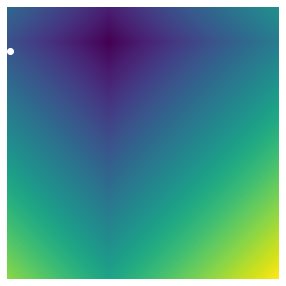

In [80]:
i = 0
area_maps = get_all_area_maps("./test_maps/")

# area_map = max_pool(area_maps[i])
# area_map = area_maps[i]
area_map = np.full((1000,1000),0)
start_point = get_random_coords(area_map, 1)[0]
center_point = get_random_coords(area_map,1)[0]
dist_map = dist_fill(area_map,[center_point])

imshow(dist_map);
plt.scatter(start_point[1],start_point[0], color="white")

print("sp",start_point, "\ncp",center_point)

In [82]:
coverage_path , backtrack_paths, backtrack_starts = wavefront(area_map, start_point, center_point)

In [46]:
def bt_len(backtrack_paths):
    return np.sum([len(bt) for bt in backtrack_paths])

array([[126, 125, 124, ...,  -1,  -1,  -1],
       [125, 124, 123, ...,  -1,  -1,  -1],
       [124, 123, 122, ...,  -1,  -1,  -1],
       ...,
       [361, 360, 359, ...,  -1,  -1,  -1],
       [362, 361, 360, ...,  -1,  -1,  -1],
       [363, 362, 361, ...,  -1,  -1,  -1]])

(57, 716)

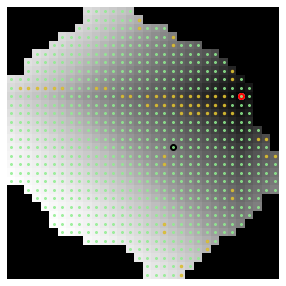

In [47]:
imshow(dist_map, cmap="Greys_r")

plt.scatter(start_point[1],start_point[0], color="black")
plt.scatter(center_point[1],center_point[0], color="white")
plt.scatter(coverage_path[-1][1],coverage_path[-1][0], color="red")
imshow_scatter(coverage_path, "lightgreen", 0.8, 4)

for backtrack_path in backtrack_paths:
    imshow_scatter(backtrack_path, "orange", 0.5, 7)
    
bt_len(backtrack_paths), len(coverage_path)

In [51]:
# failed : index 19 

# imshow(area_maps[19], figsize=(20,20))
# imshow_scatter(fail_path, "lightgreen", 0.3,10)

time taken : 61.228 ms
num br: 16, bt_len : 1290, cp_len :716
time taken : 19.406 ms
num br: 8, bt_len : 71, cp_len :689
time taken : 22.261 ms
num br: 18, bt_len : 131, cp_len :639
time taken : 29.634 ms
num br: 19, bt_len : 634, cp_len :654
time taken : 38.870 ms
num br: 8, bt_len : 1025, cp_len :794
time taken : 33.092 ms
num br: 14, bt_len : 572, cp_len :725
time taken : 29.530 ms
num br: 13, bt_len : 77, cp_len :723
time taken : 58.958 ms
num br: 39, bt_len : 1422, cp_len :772
time taken : 218.235 ms
num br: 64, bt_len : 9540, cp_len :610
time taken : 166.162 ms
num br: 27, bt_len : 3335, cp_len :1529
time taken : 47.353 ms
num br: 47, bt_len : 164, cp_len :1318
time taken : 107.850 ms
num br: 26, bt_len : 2419, cp_len :1472
time taken : 429.807 ms
num br: 14, bt_len : 12362, cp_len :6042
time taken : 287.420 ms
num br: 87, bt_len : 3946, cp_len :3680
time taken : 339.696 ms
num br: 31, bt_len : 5536, cp_len :4161
time taken : 248.356 ms
num br: 12, bt_len : 4892, cp_len :4383
tim

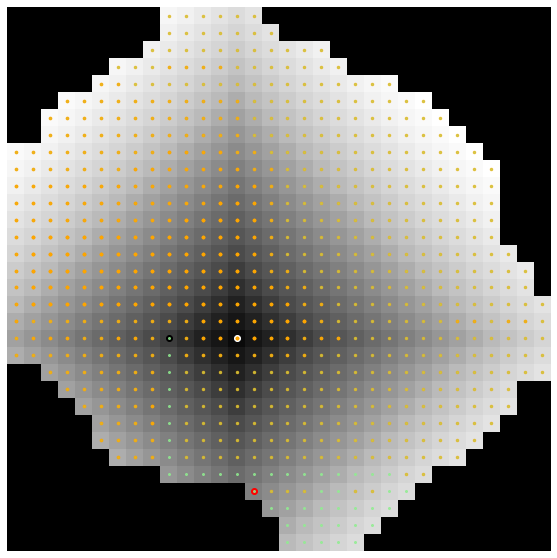

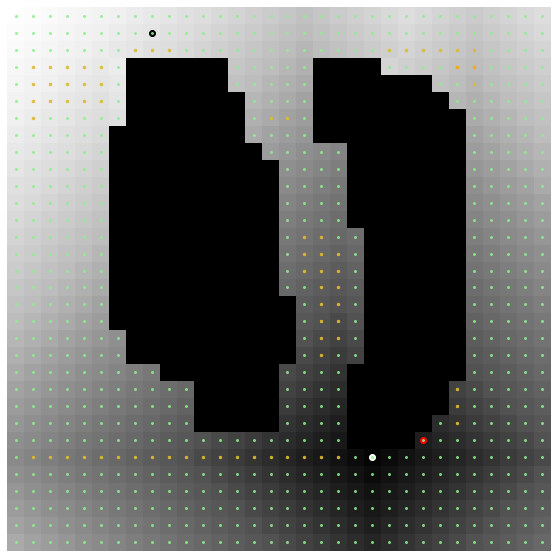

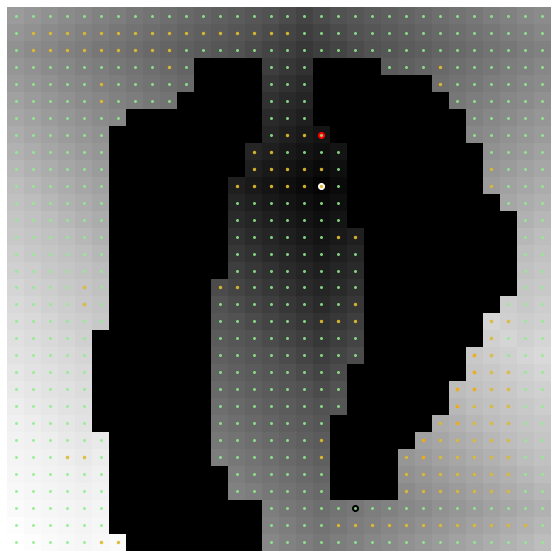

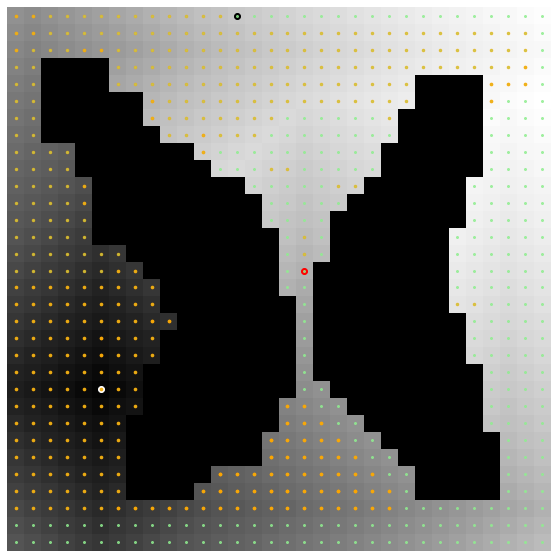

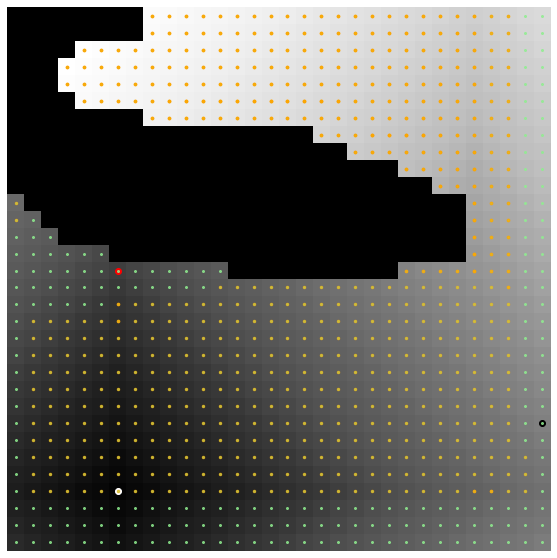

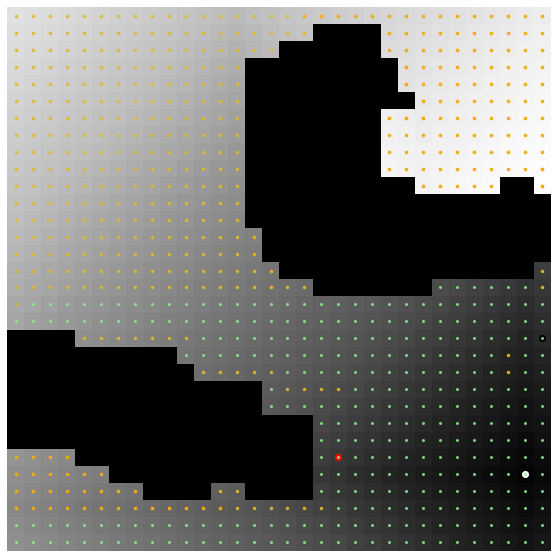

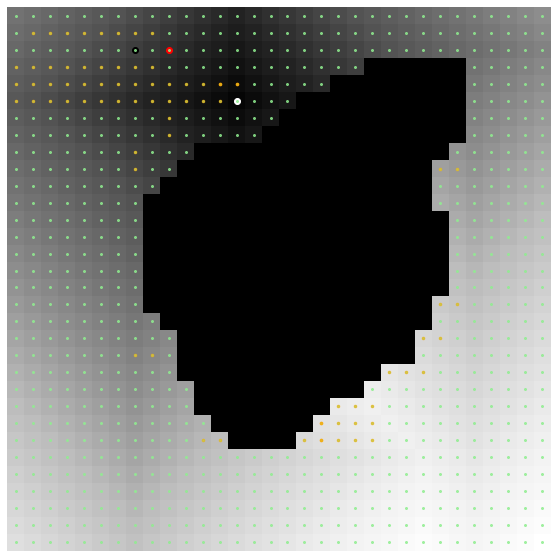

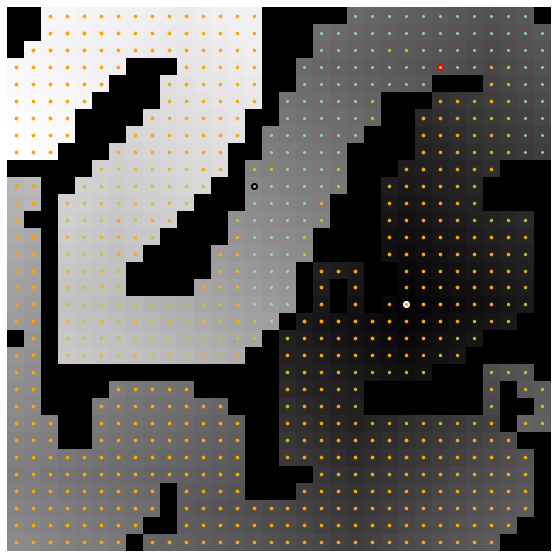

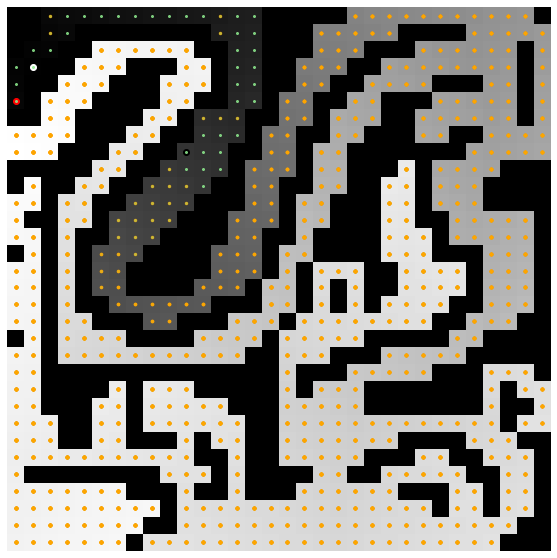

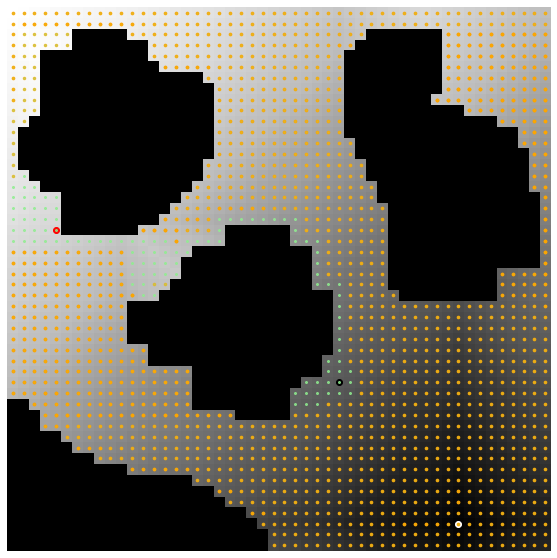

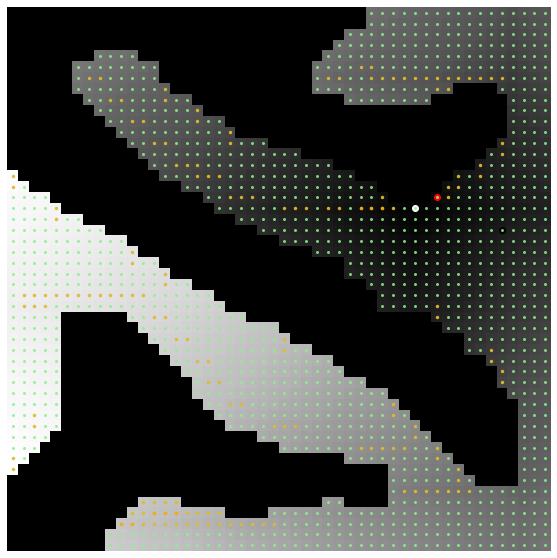

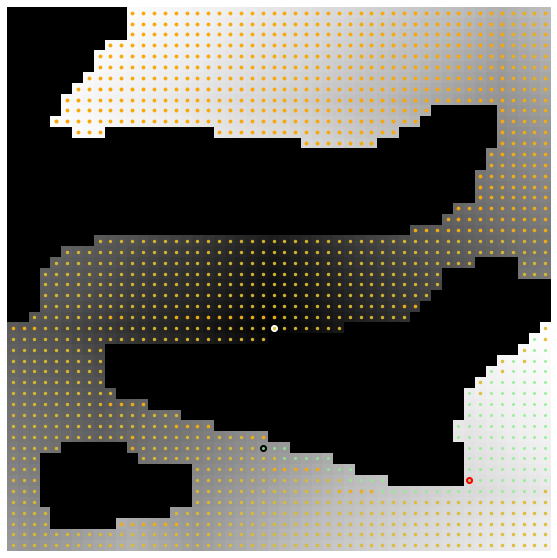

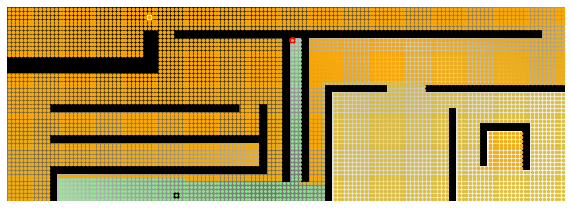

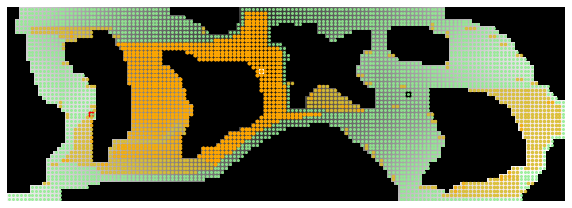

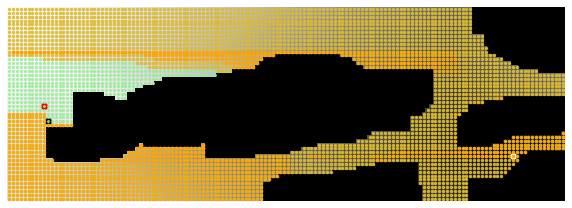

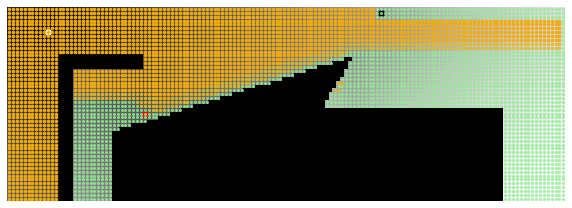

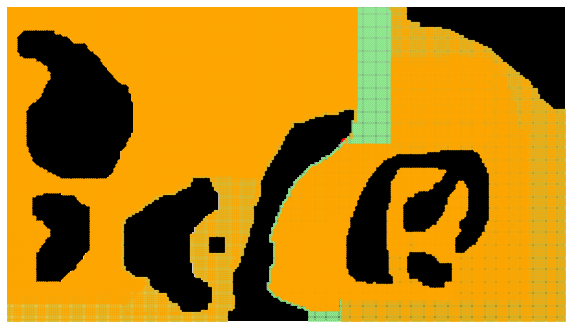

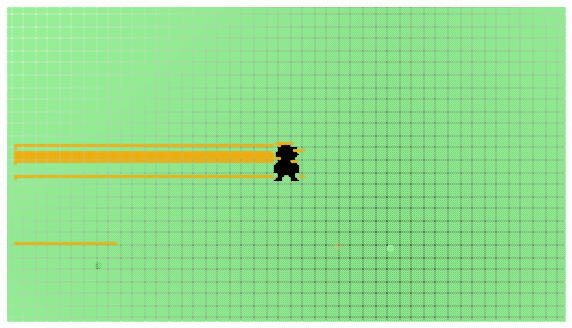

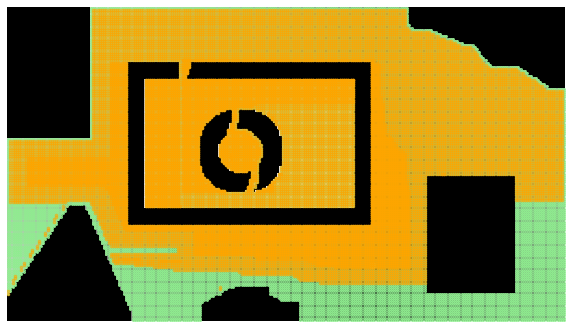

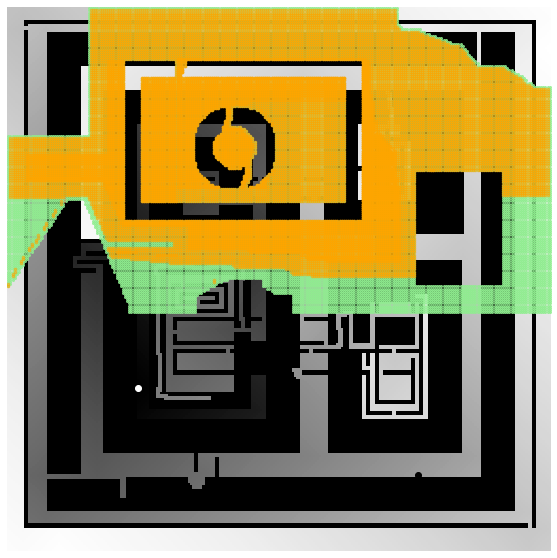

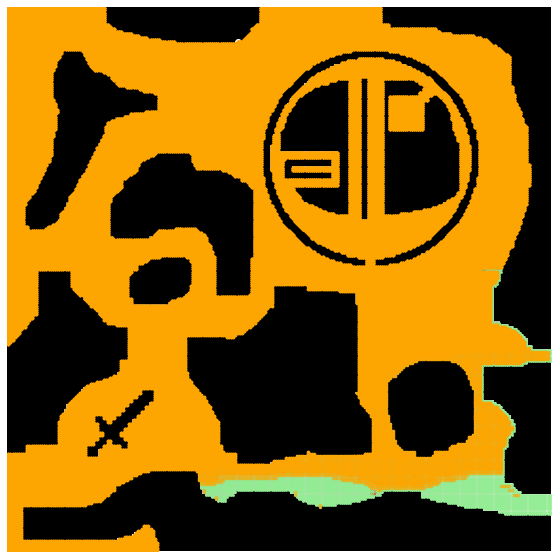

In [54]:
for area_map in area_maps:
    start_point = get_random_coords(area_map, 1)[0]
    center_point = get_random_coords(area_map,1)[0]
    dist_map = dist_fill(area_map,[center_point])
    t1 = time.time()
    try:
        coverage_path , backtrack_paths, backtrack_starts = wavefront(area_map, start_point, center_point)
    except:
        print("failed cause locked in areas")
    print(f"time taken : {(time.time()-t1)*1000:0.3f} ms")
    print(f"num br: {len(backtrack_paths)}, bt_len : {bt_len(backtrack_paths)}, cp_len :{len(coverage_path)}")
    
    imshow(dist_map, cmap="Greys_r", figsize=(10,10))

    plt.scatter(start_point[1],start_point[0], color="black")
    plt.scatter(center_point[1],center_point[0], color="white")
    plt.scatter(coverage_path[-1][1],coverage_path[-1][0], color="red")
    imshow_scatter(coverage_path, "lightgreen", 0.8, 4)

    for backtrack_path in backtrack_paths:
        imshow_scatter(backtrack_path, "orange", 0.5, 7)

In [37]:
fail_path = [(237, 160), (237, 161), (237, 162), (237, 163), (237, 164), (237, 165), (237, 166), (237, 167), (237, 168), (237, 169), (237, 170), (237, 171), (237, 172), (237, 173), (237, 174), (237, 175), (237, 176), (237, 177), (237, 178), (237, 179), (237, 180), (237, 181), (237, 182), (237, 183), (237, 184), (237, 185), (237, 186), (237, 187), (237, 188), (237, 189), (237, 190), (237, 191), (237, 192), (237, 193), (237, 194), (237, 195), (237, 196), (237, 197), (237, 198), (237, 199), (237, 200), (237, 201), (237, 202), (237, 203), (237, 204), (237, 205), (237, 206), (237, 207), (237, 208), (237, 209), (237, 210), (237, 211), (237, 212), (237, 213), (237, 214), (237, 215), (237, 216), (237, 217), (237, 218), (237, 219), (237, 220), (237, 221), (237, 222), (237, 223), (237, 224), (237, 225), (237, 226), (237, 227), (237, 228), (237, 229), (237, 230), (237, 231), (237, 232), (237, 233), (237, 234), (237, 235), (237, 236), (237, 237), (237, 238), (237, 239), (237, 240), (237, 241), (237, 242), (237, 243), (237, 244), (237, 245), (237, 246), (238, 246), (239, 246), (240, 246), (241, 246), (242, 246), (243, 246), (244, 246), (245, 246), (245, 247), (245, 248), (245, 249), (245, 250), (245, 251), (245, 252), (245, 253), (245, 254), (245, 255), (246, 255), (247, 255), (248, 255), (249, 255), (250, 255), (251, 255), (252, 255), (253, 255), (254, 255), (255, 255), (255, 254), (255, 253), (255, 252), (255, 251), (255, 250), (255, 249), (255, 248), (255, 247), (255, 246), (255, 245), (255, 244), (255, 243), (255, 242), (255, 241), (255, 240), (255, 239), (255, 238), (255, 237), (255, 236), (255, 235), (255, 234), (255, 233), (255, 232), (255, 231), (255, 230), (255, 229), (255, 228), (255, 227), (255, 226), (255, 225), (255, 224), (255, 223), (255, 222), (255, 221), (255, 220), (255, 219), (255, 218), (255, 217), (255, 216), (255, 215), (255, 214), (255, 213), (255, 212), (255, 211), (255, 210), (255, 209), (255, 208), (255, 207), (255, 206), (255, 205), (255, 204), (255, 203), (255, 202), (255, 201), (255, 200), (255, 199), (255, 198), (255, 197), (255, 196), (255, 195), (255, 194), (255, 193), (255, 192), (255, 191), (255, 190), (255, 189), (255, 188), (255, 187), (255, 186), (255, 185), (255, 184), (255, 183), (255, 182), (255, 181), (255, 180), (255, 179), (255, 178), (255, 177), (255, 176), (255, 175), (255, 174), (255, 173), (255, 172), (255, 171), (255, 170), (255, 169), (255, 168), (255, 167), (255, 166), (255, 165), (255, 164), (255, 163), (255, 162), (255, 161), (255, 160), (255, 159), (255, 158), (255, 157), (255, 156), (255, 155), (255, 154), (255, 153), (255, 152), (255, 151), (255, 150), (255, 149), (255, 148), (255, 147), (255, 146), (255, 145), (255, 144), (255, 143), (255, 142), (255, 141), (255, 140), (255, 139), (255, 138), (255, 137), (255, 136), (255, 135), (255, 134), (255, 133), (255, 132), (255, 131), (255, 130), (255, 129), (255, 128), (255, 127), (255, 126), (255, 125), (255, 124), (255, 123), (255, 122), (255, 121), (255, 120), (255, 119), (255, 118), (255, 117), (255, 116), (255, 115), (255, 114), (255, 113), (255, 112), (255, 111), (255, 110), (255, 109), (255, 108), (255, 107), (255, 106), (255, 105), (255, 104), (255, 103), (255, 102), (255, 101), (255, 100), (255, 99), (255, 98), (255, 97), (255, 96), (255, 95), (255, 94), (255, 93), (255, 92), (255, 91), (255, 90), (255, 89), (255, 88), (255, 87), (255, 86), (255, 85), (255, 84), (255, 83), (255, 82), (255, 81), (255, 80), (255, 79), (255, 78), (255, 77), (255, 76), (255, 75), (255, 74), (255, 73), (255, 72), (255, 71), (255, 70), (255, 69), (255, 68), (255, 67), (255, 66), (255, 65), (255, 64), (255, 63), (255, 62), (255, 61), (255, 60), (255, 59), (255, 58), (255, 57), (255, 56), (255, 55), (255, 54), (255, 53), (255, 52), (255, 51), (255, 50), (255, 49), (255, 48), (255, 47), (255, 46), (255, 45), (255, 44), (255, 43), (255, 42), (255, 41), (255, 40), (255, 39), (255, 38), (255, 37), (255, 36), (255, 35), (255, 34), (255, 33), (255, 32), (255, 31), (255, 30), (255, 29), (255, 28), (255, 27), (255, 26), (255, 25), (255, 24), (255, 23), (255, 22), (255, 21), (255, 20), (255, 19), (255, 18), (255, 17), (255, 16), (255, 15), (255, 14), (255, 13), (255, 12), (255, 11), (255, 10), (255, 9), (255, 8), (255, 7), (255, 6), (255, 5), (255, 4), (255, 3), (255, 2), (255, 1), (255, 0), (254, 0), (254, 1), (254, 2), (254, 3), (254, 4), (254, 5), (254, 6), (254, 7), (254, 8), (254, 9), (254, 10), (254, 11), (254, 12), (254, 13), (254, 14), (254, 15), (254, 16), (254, 17), (254, 18), (254, 19), (254, 20), (254, 21), (254, 22), (254, 23), (254, 24), (254, 25), (254, 26), (254, 27), (254, 28), (254, 29), (254, 30), (254, 31), (254, 32), (254, 33), (254, 34), (254, 35), (254, 36), (254, 37), (254, 38), (254, 39), (254, 40), (254, 41), (254, 42), (254, 43), (254, 44), (254, 45), (254, 46), (254, 47), (254, 48), (254, 49), (254, 50), (254, 51), (254, 52), (254, 53), (254, 54), (254, 55), (254, 56), (254, 57), (254, 58), (254, 59), (254, 60), (254, 61), (254, 62), (254, 63), (254, 64), (254, 65), (254, 66), (254, 67), (254, 68), (254, 69), (254, 70), (254, 71), (254, 72), (254, 73), (254, 74), (254, 75), (254, 76), (254, 77), (254, 78), (254, 79), (254, 80), (254, 81), (254, 82), (254, 83), (254, 84), (254, 85), (254, 86), (254, 87), (254, 88), (254, 89), (254, 90), (254, 91), (254, 92), (254, 93), (254, 94), (254, 95), (254, 96), (254, 97), (254, 98), (254, 99), (254, 100), (254, 101), (254, 102), (254, 103), (254, 104), (254, 105), (254, 106), (254, 107), (254, 108), (254, 109), (254, 110), (254, 111), (254, 112), (254, 113), (254, 114), (254, 115), (254, 116), (254, 117), (254, 118), (254, 119), (254, 120), (254, 121), (254, 122), (254, 123), (254, 124), (254, 125), (254, 126), (254, 127), (254, 128), (254, 129), (254, 130), (254, 131), (254, 132), (254, 133), (254, 134), (254, 135), (254, 136), (254, 137), (254, 138), (254, 139), (254, 140), (254, 141), (254, 142), (254, 143), (254, 144), (254, 145), (254, 146), (254, 147), (254, 148), (254, 149), (254, 150), (254, 151), (254, 152), (254, 153), (254, 154), (254, 155), (254, 156), (254, 157), (254, 158), (254, 159), (254, 160), (254, 161), (254, 162), (254, 163), (254, 164), (254, 165), (254, 166), (254, 167), (254, 168), (254, 169), (254, 170), (254, 171), (254, 172), (254, 173), (254, 174), (254, 175), (254, 176), (254, 177), (254, 178), (254, 179), (254, 180), (254, 181), (254, 182), (254, 183), (254, 184), (254, 185), (254, 186), (254, 187), (254, 188), (254, 189), (254, 190), (254, 191), (254, 192), (254, 193), (254, 194), (254, 195), (254, 196), (254, 197), (254, 198), (254, 199), (254, 200), (254, 201), (254, 202), (254, 203), (254, 204), (254, 205), (254, 206), (254, 207), (254, 208), (254, 209), (254, 210), (254, 211), (254, 212), (254, 213), (254, 214), (254, 215), (254, 216), (254, 217), (254, 218), (254, 219), (254, 220), (254, 221), (254, 222), (254, 223), (254, 224), (254, 225), (254, 226), (254, 227), (254, 228), (254, 229), (254, 230), (254, 231), (254, 232), (254, 233), (254, 234), (254, 235), (254, 236), (254, 237), (254, 238), (254, 239), (254, 240), (254, 241), (254, 242), (254, 243), (254, 244), (254, 245), (254, 246), (254, 247), (254, 248), (254, 249), (254, 250), (254, 251), (254, 252), (254, 253), (254, 254), (253, 254), (253, 253), (253, 252), (253, 251), (253, 250), (253, 249), (253, 248), (253, 247), (253, 246), (253, 245), (253, 244), (253, 243), (253, 242), (253, 241), (253, 240), (253, 239), (253, 238), (253, 237), (253, 236), (253, 235), (253, 234), (253, 233), (253, 232), (253, 231), (253, 230), (253, 229), (253, 228), (253, 227), (253, 226), (253, 225), (253, 224), (253, 223), (253, 222), (253, 221), (253, 220), (253, 219), (253, 218), (253, 217), (253, 216), (253, 215), (253, 214), (253, 213), (253, 212), (253, 211), (253, 210), (253, 209), (253, 208), (253, 207), (253, 206), (253, 205), (253, 204), (253, 203), (253, 202), (253, 201), (253, 200), (253, 199), (253, 198), (253, 197), (253, 196), (253, 195), (253, 194), (253, 193), (253, 192), (253, 191), (253, 190), (253, 189), (253, 188), (253, 187), (253, 186), (253, 185), (253, 184), (253, 183), (253, 182), (253, 181), (253, 180), (253, 179), (253, 178), (253, 177), (253, 176), (253, 175), (253, 174), (253, 173), (253, 172), (253, 171), (253, 170), (253, 169), (253, 168), (253, 167), (253, 166), (253, 165), (253, 164), (253, 163), (253, 162), (253, 161), (253, 160), (253, 159), (253, 158), (253, 157), (253, 156), (253, 155), (253, 154), (253, 153), (253, 152), (253, 151), (253, 150), (253, 149), (253, 148), (253, 147), (253, 146), (253, 145), (253, 144), (253, 143), (253, 142), (253, 141), (253, 140), (253, 139), (253, 138), (253, 137), (253, 136), (253, 135), (253, 134), (253, 133), (253, 132), (253, 131), (253, 130), (253, 129), (253, 128), (253, 127), (253, 126), (253, 125), (253, 124), (253, 123), (253, 122), (253, 121), (253, 120), (253, 119), (253, 118), (253, 117), (253, 116), (253, 115), (253, 114), (253, 113), (253, 112), (253, 111), (253, 110), (253, 109), (253, 108), (253, 107), (253, 106), (253, 105), (253, 104), (253, 103), (253, 102), (253, 101), (253, 100), (253, 99), (253, 98), (253, 97), (253, 96), (253, 95), (253, 94), (253, 93), (253, 92), (253, 91), (253, 90), (253, 89), (253, 88), (253, 87), (253, 86), (253, 85), (253, 84), (253, 83), (253, 82), (253, 81), (253, 80), (253, 79), (253, 78), (253, 77), (253, 76), (253, 75), (253, 74), (253, 73), (253, 72), (253, 71), (253, 70), (253, 69), (253, 68), (253, 67), (253, 66), (253, 65), (253, 64), (253, 63), (253, 62), (253, 61), (253, 60), (253, 59), (253, 58), (253, 57), (253, 56), (253, 55), (253, 54), (253, 53), (253, 52), (253, 51), (253, 50), (253, 49), (253, 48), (253, 47), (253, 46), (253, 45), (253, 44), (253, 43), (253, 42), (253, 41), (253, 40), (253, 39), (253, 38), (253, 37), (253, 36), (253, 35), (253, 34), (253, 33), (253, 32), (253, 31), (253, 30), (253, 29), (253, 28), (253, 27), (253, 26), (253, 25), (253, 24), (253, 23), (253, 22), (253, 21), (253, 20), (253, 19), (253, 18), (253, 17), (253, 16), (253, 15), (253, 14), (253, 13), (253, 12), (253, 11), (253, 10), (253, 9), (253, 8), (253, 7), (253, 6), (253, 5), (253, 4), (253, 3), (253, 2), (253, 1), (253, 0), (252, 0), (252, 1), (252, 2), (252, 3), (252, 4), (252, 5), (252, 6), (252, 7), (252, 8), (252, 9), (252, 10), (252, 11), (252, 12), (252, 13), (252, 14), (252, 15), (252, 16), (252, 17), (252, 18), (252, 19), (252, 20), (252, 21), (252, 22), (252, 23), (252, 24), (252, 25), (252, 26), (252, 27), (252, 28), (252, 29), (252, 30), (252, 31), (252, 32), (252, 33), (252, 34), (252, 35), (252, 36), (252, 37), (252, 38), (252, 39), (252, 40), (252, 41), (252, 42), (252, 43), (252, 44), (252, 45), (252, 46), (252, 47), (252, 48), (252, 49), (252, 50), (252, 51), (252, 52), (252, 53), (252, 54), (252, 55), (252, 56), (252, 57), (252, 58), (252, 59), (252, 60), (252, 61), (252, 62), (252, 63), (252, 64), (252, 65), (252, 66), (252, 67), (252, 68), (252, 69), (252, 70), (252, 71), (252, 72), (252, 73), (252, 74), (252, 75), (252, 76), (252, 77), (252, 78), (252, 79), (252, 80), (252, 81), (252, 82), (252, 83), (252, 84), (252, 85), (252, 86), (252, 87), (252, 88), (252, 89), (252, 90), (252, 91), (252, 92), (252, 93), (252, 94), (252, 95), (252, 96), (252, 97), (252, 98), (252, 99), (252, 100), (252, 101), (252, 102), (252, 103), (252, 104), (252, 105), (252, 106), (252, 107), (252, 108), (252, 109), (252, 110), (252, 111), (252, 112), (252, 113), (252, 114), (252, 115), (252, 116), (252, 117), (252, 118), (252, 119), (252, 120), (252, 121), (252, 122), (252, 123), (252, 124), (252, 125), (252, 126), (252, 127), (252, 128), (252, 129), (252, 130), (252, 131), (252, 132), (252, 133), (252, 134), (252, 135), (252, 136), (252, 137), (252, 138), (252, 139), (252, 140), (252, 141), (252, 142), (252, 143), (252, 144), (252, 145), (252, 146), (252, 147), (252, 148), (252, 149), (252, 150), (252, 151), (252, 152), (252, 153), (252, 154), (252, 155), (252, 156), (252, 157), (252, 158), (252, 159), (252, 160), (252, 161), (252, 162), (252, 163), (252, 164), (252, 165), (252, 166), (252, 167), (252, 168), (252, 169), (252, 170), (252, 171), (252, 172), (252, 173), (252, 174), (252, 175), (252, 176), (252, 177), (252, 178), (252, 179), (252, 180), (252, 181), (252, 182), (252, 183), (252, 184), (252, 185), (252, 186), (252, 187), (252, 188), (252, 189), (252, 190), (252, 191), (252, 192), (252, 193), (252, 194), (252, 195), (252, 196), (252, 197), (252, 198), (252, 199), (252, 200), (252, 201), (252, 202), (252, 203), (252, 204), (252, 205), (252, 206), (252, 207), (252, 208), (252, 209), (252, 210), (252, 211), (252, 212), (252, 213), (252, 214), (252, 215), (252, 216), (252, 217), (252, 218), (252, 219), (252, 220), (252, 221), (252, 222), (252, 223), (252, 224), (252, 225), (252, 226), (252, 227), (252, 228), (252, 229), (252, 230), (252, 231), (252, 232), (252, 233), (252, 234), (252, 235), (252, 236), (252, 237), (252, 238), (252, 239), (252, 240), (252, 241), (252, 242), (252, 243), (252, 244), (252, 245), (252, 246), (252, 247), (252, 248), (252, 249), (252, 250), (252, 251), (252, 252), (252, 253), (252, 254), (251, 254), (251, 253), (251, 252), (251, 251), (251, 250), (251, 249), (251, 248), (251, 247), (251, 246), (251, 245), (251, 244), (251, 243), (251, 242), (251, 241), (251, 240), (251, 239), (251, 238), (251, 237), (251, 236), (251, 235), (251, 234), (251, 233), (251, 232), (251, 231), (251, 230), (251, 229), (251, 228), (251, 227), (251, 226), (251, 225), (251, 224), (251, 223), (251, 222), (251, 221), (251, 220), (251, 219), (251, 218), (251, 217), (251, 216), (251, 215), (251, 214), (251, 213), (251, 212), (251, 211), (251, 210), (251, 209), (251, 208), (251, 207), (251, 206), (251, 205), (251, 204), (251, 203), (251, 202), (251, 201), (251, 200), (251, 199), (251, 198), (251, 197), (251, 196), (251, 195), (251, 194), (251, 193), (251, 192), (251, 191), (251, 190), (251, 189), (251, 188), (251, 187), (251, 186), (251, 185), (251, 184), (251, 183), (251, 182), (251, 181), (251, 180), (251, 179), (251, 178), (251, 177), (251, 176), (251, 175), (251, 174), (251, 173), (251, 172), (251, 171), (251, 170), (251, 169), (251, 168), (251, 167), (251, 166), (251, 165), (251, 164), (251, 163), (251, 162), (251, 161), (251, 160), (251, 159), (251, 158), (251, 157), (251, 156), (251, 155), (251, 154), (251, 153), (251, 152), (251, 151), (251, 150), (251, 149), (251, 148), (251, 147), (251, 146), (251, 145), (251, 144), (251, 143), (251, 142), (251, 141), (251, 140), (251, 139), (251, 138), (251, 137), (251, 136), (251, 135), (251, 134), (251, 133), (251, 132), (251, 131), (251, 130), (251, 129), (251, 128), (251, 127), (251, 126), (251, 125), (251, 124), (251, 123), (251, 122), (251, 121), (251, 120), (251, 119), (251, 118), (251, 117), (251, 116), (251, 115), (251, 114), (251, 113), (251, 112), (251, 111), (251, 110), (251, 109), (251, 108), (251, 107), (251, 106), (251, 105), (251, 104), (251, 103), (251, 102), (251, 101), (251, 100), (251, 99), (251, 98), (251, 97), (251, 96), (251, 95), (251, 94), (251, 93), (251, 92), (251, 91), (251, 90), (251, 89), (251, 88), (251, 87), (251, 86), (251, 85), (251, 84), (251, 83), (251, 82), (251, 81), (251, 80), (251, 79), (251, 78), (251, 77), (251, 76), (251, 75), (251, 74), (251, 73), (251, 72), (251, 71), (251, 70), (251, 69), (251, 68), (251, 67), (251, 66), (251, 65), (251, 64), (251, 63), (251, 62), (251, 61), (251, 60), (251, 59), (251, 58), (251, 57), (251, 56), (251, 55), (251, 54), (251, 53), (251, 52), (251, 51), (251, 50), (251, 49), (251, 48), (251, 47), (251, 46), (251, 45), (251, 44), (251, 43), (251, 42), (251, 41), (251, 40), (251, 39), (251, 38), (251, 37), (251, 36), (251, 35), (251, 34), (251, 33), (251, 32), (251, 31), (251, 30), (251, 29), (251, 28), (251, 27), (251, 26), (251, 25), (251, 24), (251, 23), (251, 22), (251, 21), (251, 20), (251, 19), (251, 18), (251, 17), (251, 16), (251, 15), (251, 14), (251, 13), (251, 12), (251, 11), (251, 10), (251, 9), (251, 8), (251, 7), (251, 6), (251, 5), (251, 4), (251, 3), (251, 2), (251, 1), (251, 0), (250, 0), (250, 1), (250, 2), (250, 3), (250, 4), (250, 5), (250, 6), (250, 7), (250, 8), (250, 9), (250, 10), (250, 11), (250, 12), (250, 13), (250, 14), (250, 15), (250, 16), (250, 17), (250, 18), (250, 19), (250, 20), (250, 21), (250, 22), (250, 23), (250, 24), (250, 25), (250, 26), (250, 27), (250, 28), (250, 29), (250, 30), (250, 31), (250, 32), (250, 33), (250, 34), (250, 35), (250, 36), (250, 37), (250, 38), (250, 39), (250, 40), (250, 41), (250, 42), (250, 43), (250, 44), (250, 45), (250, 46), (250, 47), (250, 48), (250, 49), (250, 50), (250, 51), (250, 52), (250, 53), (250, 54), (250, 55), (250, 56), (250, 57), (250, 58), (250, 59), (250, 60), (250, 61), (250, 62), (250, 63), (250, 64), (250, 65), (250, 66), (250, 67), (250, 68), (250, 69), (250, 70), (250, 71), (250, 72), (250, 73), (250, 74), (250, 75), (250, 76), (250, 77), (250, 78), (250, 79), (250, 80), (250, 81), (250, 82), (250, 83), (250, 84), (250, 85), (250, 86), (250, 87), (250, 88), (250, 89), (250, 90), (250, 91), (250, 92), (250, 93), (250, 94), (250, 95), (250, 96), (250, 97), (250, 98), (250, 99), (250, 100), (250, 101), (250, 102), (250, 103), (250, 104), (250, 105), (250, 106), (250, 107), (250, 108), (250, 109), (250, 110), (250, 111), (250, 112), (250, 113), (250, 114), (250, 115), (250, 116), (250, 117), (250, 118), (250, 119), (250, 120), (250, 121), (250, 122), (250, 123), (250, 124), (250, 125), (250, 126), (250, 127), (250, 128), (250, 129), (250, 130), (250, 131), (250, 132), (250, 133), (250, 134), (250, 135), (250, 136), (250, 137), (250, 138), (250, 139), (250, 140), (250, 141), (250, 142), (250, 143), (250, 144), (250, 145), (250, 146), (250, 147), (250, 148), (250, 149), (250, 150), (250, 151), (250, 152), (250, 153), (250, 154), (250, 155), (250, 156), (250, 157), (250, 158), (250, 159), (250, 160), (250, 161), (250, 162), (250, 163), (250, 164), (250, 165), (250, 166), (250, 167), (250, 168), (250, 169), (250, 170), (250, 171), (250, 172), (250, 173), (250, 174), (250, 175), (250, 176), (250, 177), (250, 178), (250, 179), (250, 180), (250, 181), (250, 182), (250, 183), (250, 184), (250, 185), (250, 186), (250, 187), (250, 188), (250, 189), (250, 190), (250, 191), (250, 192), (250, 193), (250, 194), (250, 195), (250, 196), (250, 197), (250, 198), (250, 199), (250, 200), (250, 201), (250, 202), (250, 203), (250, 204), (250, 205), (250, 206), (250, 207), (250, 208), (250, 209), (250, 210), (250, 211), (250, 212), (250, 213), (250, 214), (250, 215), (250, 216), (250, 217), (250, 218), (250, 219), (250, 220), (250, 221), (250, 222), (250, 223), (250, 224), (250, 225), (250, 226), (250, 227), (250, 228), (250, 229), (250, 230), (250, 231), (250, 232), (250, 233), (250, 234), (250, 235), (250, 236), (250, 237), (250, 238), (250, 239), (250, 240), (250, 241), (250, 242), (250, 243), (250, 244), (250, 245), (250, 246), (250, 247), (250, 248), (250, 249), (250, 250), (250, 251), (250, 252), (250, 253), (250, 254), (249, 254), (249, 253), (249, 252), (249, 251), (249, 250), (249, 249), (249, 248), (249, 247), (249, 246), (249, 245), (249, 244), (249, 243), (249, 242), (249, 241), (249, 240), (249, 239), (249, 238), (249, 237), (249, 236), (249, 235), (249, 234), (249, 233), (249, 232), (249, 231), (249, 230), (249, 229), (249, 228), (249, 227), (249, 226), (249, 225), (249, 224), (249, 223), (249, 222), (249, 221), (249, 220), (249, 219), (249, 218), (249, 217), (249, 216), (249, 215), (249, 214), (249, 213), (249, 212), (249, 211), (249, 210), (249, 209), (249, 208), (249, 207), (249, 206), (249, 205), (249, 204), (249, 203), (249, 202), (249, 201), (249, 200), (249, 199), (249, 198), (249, 197), (249, 196), (249, 195), (249, 194), (249, 193), (249, 192), (249, 191), (249, 190), (249, 189), (249, 188), (249, 187), (249, 186), (249, 185), (249, 184), (249, 183), (249, 182), (249, 181), (249, 180), (249, 179), (249, 178), (249, 177), (249, 176), (249, 175), (249, 174), (249, 173), (249, 172), (249, 171), (249, 170), (249, 169), (249, 168), (249, 167), (249, 166), (249, 165), (249, 164), (249, 163), (249, 162), (249, 161), (249, 160), (249, 159), (249, 158), (249, 157), (249, 156), (249, 155), (249, 154), (249, 153), (249, 152), (249, 151), (249, 150), (249, 149), (249, 148), (249, 147), (249, 146), (249, 145), (249, 144), (249, 143), (249, 142), (249, 141), (249, 140), (249, 139), (249, 138), (249, 137), (249, 136), (249, 135), (249, 134), (249, 133), (249, 132), (249, 131), (249, 130), (249, 129), (249, 128), (249, 127), (249, 126), (249, 125), (249, 124), (249, 123), (249, 122), (249, 121), (249, 120), (249, 119), (249, 118), (249, 117), (249, 116), (249, 115), (249, 114), (249, 113), (249, 112), (249, 111), (249, 110), (249, 109), (249, 108), (249, 107), (249, 106), (249, 105), (249, 104), (249, 103), (249, 102), (249, 101), (249, 100), (249, 99), (249, 98), (249, 97), (249, 96), (249, 95), (249, 94), (249, 93), (249, 92), (249, 91), (249, 90), (249, 89), (249, 88), (249, 87), (249, 86), (249, 85), (249, 84), (249, 83), (249, 82), (249, 81), (249, 80), (249, 79), (249, 78), (249, 77), (249, 76), (249, 75), (249, 74), (249, 73), (249, 72), (249, 71), (249, 70), (249, 69), (249, 68), (249, 67), (249, 66), (249, 65), (249, 64), (249, 63), (249, 62), (249, 61), (249, 60), (249, 59), (249, 58), (249, 57), (249, 56), (249, 55), (249, 54), (249, 53), (249, 52), (249, 51), (249, 50), (249, 49), (249, 48), (249, 47), (249, 46), (249, 45), (249, 44), (249, 43), (249, 42), (249, 41), (249, 40), (249, 39), (249, 38), (249, 37), (249, 36), (249, 35), (249, 34), (249, 33), (249, 32), (249, 31), (249, 30), (249, 29), (249, 28), (249, 27), (249, 26), (249, 25), (249, 24), (249, 23), (249, 22), (249, 21), (249, 20), (249, 19), (249, 18), (249, 17), (249, 16), (249, 15), (249, 14), (249, 13), (249, 12), (249, 11), (249, 10), (249, 9), (249, 8), (249, 7), (249, 6), (249, 5), (249, 4), (249, 3), (249, 2), (249, 1), (249, 0), (248, 0), (248, 1), (248, 2), (248, 3), (248, 4), (248, 5), (248, 6), (248, 7), (248, 8), (248, 9), (248, 10), (248, 11), (248, 12), (248, 13), (248, 14), (248, 15), (248, 16), (248, 17), (248, 18), (248, 19), (248, 20), (248, 21), (248, 22), (248, 23), (248, 24), (248, 25), (248, 26), (248, 27), (248, 28), (248, 29), (248, 30), (248, 31), (248, 32), (248, 33), (248, 34), (248, 35), (248, 36), (248, 37), (248, 38), (248, 39), (248, 40), (248, 41), (248, 42), (248, 43), (248, 44), (248, 45), (248, 46), (248, 47), (248, 48), (248, 49), (248, 50), (248, 51), (248, 52), (248, 53), (248, 54), (248, 55), (248, 56), (248, 57), (248, 58), (248, 59), (248, 60), (248, 61), (248, 62), (248, 63), (248, 64), (248, 65), (248, 66), (248, 67), (248, 68), (248, 69), (248, 70), (248, 71), (248, 72), (248, 73), (248, 74), (248, 75), (248, 76), (248, 77), (248, 78), (248, 79), (248, 80), (248, 81), (248, 82), (248, 83), (248, 84), (248, 85), (248, 86), (248, 87), (248, 88), (248, 89), (248, 90), (248, 91), (248, 92), (248, 93), (248, 94), (248, 95), (248, 96), (248, 97), (248, 98), (248, 99), (248, 100), (248, 101), (248, 102), (248, 103), (248, 104), (248, 105), (248, 106), (248, 107), (248, 108), (248, 109), (248, 110), (248, 111), (248, 112), (248, 113), (248, 114), (248, 115), (248, 116), (248, 117), (248, 118), (248, 119), (248, 120), (248, 121), (248, 122), (248, 123), (248, 124), (248, 125), (248, 126), (248, 127), (248, 128), (248, 129), (248, 130), (248, 131), (248, 132), (248, 133), (248, 134), (248, 135), (248, 136), (248, 137), (248, 138), (248, 139), (248, 140), (248, 141), (248, 142), (248, 143), (248, 144), (248, 145), (248, 146), (248, 147), (248, 148), (248, 149), (248, 150), (248, 151), (248, 152), (248, 153), (248, 154), (248, 155), (248, 156), (248, 157), (248, 158), (248, 159), (248, 160), (248, 161), (248, 162), (248, 163), (248, 164), (248, 165), (248, 166), (248, 167), (248, 168), (248, 169), (248, 170), (248, 171), (248, 172), (248, 173), (248, 174), (248, 175), (248, 176), (248, 177), (248, 178), (248, 179), (248, 180), (248, 181), (248, 182), (248, 183), (248, 184), (248, 185), (248, 186), (248, 187), (248, 188), (248, 189), (248, 190), (248, 191), (248, 192), (248, 193), (248, 194), (248, 195), (248, 196), (248, 197), (248, 198), (248, 199), (248, 200), (248, 201), (248, 202), (248, 203), (248, 204), (248, 205), (248, 206), (248, 207), (248, 208), (248, 209), (248, 210), (248, 211), (248, 212), (248, 213), (248, 214), (248, 215), (248, 216), (248, 217), (248, 218), (248, 219), (248, 220), (248, 221), (248, 222), (248, 223), (248, 224), (248, 225), (248, 226), (248, 227), (248, 228), (248, 229), (248, 230), (248, 231), (248, 232), (248, 233), (248, 234), (248, 235), (248, 236), (248, 237), (248, 238), (248, 239), (248, 240), (248, 241), (248, 242), (248, 243), (248, 244), (248, 245), (248, 246), (248, 247), (248, 248), (248, 249), (248, 250), (248, 251), (248, 252), (248, 253), (248, 254), (247, 254), (247, 253), (247, 252), (247, 251), (247, 250), (247, 249), (247, 248), (247, 247), (247, 246), (247, 245), (247, 244), (247, 243), (247, 242), (247, 241), (247, 240), (247, 239), (247, 238), (247, 237), (247, 236), (247, 235), (247, 234), (247, 233), (247, 232), (247, 231), (247, 230), (247, 229), (247, 228), (247, 227), (247, 226), (247, 225), (247, 224), (247, 223), (247, 222), (247, 221), (247, 220), (247, 219), (247, 218), (247, 217), (247, 216), (247, 215), (247, 214), (247, 213), (247, 212), (247, 211), (247, 210), (247, 209), (247, 208), (247, 207), (247, 206), (247, 205), (247, 204), (247, 203), (247, 202), (247, 201), (247, 200), (247, 199), (247, 198), (247, 197), (247, 196), (247, 195), (247, 194), (247, 193), (247, 192), (247, 191), (247, 190), (247, 189), (247, 188), (247, 187), (247, 186), (247, 185), (247, 184), (247, 183), (247, 182), (247, 181), (247, 180), (247, 179), (247, 178), (247, 177), (247, 176), (247, 175), (247, 174), (247, 173), (247, 172), (247, 171), (247, 170), (247, 169), (247, 168), (247, 167), (247, 166), (247, 165), (247, 164), (247, 163), (247, 162), (247, 161), (247, 160), (247, 159), (247, 158), (247, 157), (247, 156), (247, 155), (247, 154), (247, 153), (247, 152), (247, 151), (247, 150), (247, 149), (247, 148), (247, 147), (247, 146), (247, 145), (247, 144), (247, 143), (247, 142), (247, 141), (247, 140), (247, 139), (247, 138), (247, 137), (247, 136), (247, 135), (247, 134), (247, 133), (247, 132), (247, 131), (247, 130), (247, 129), (247, 128), (247, 127), (247, 126), (247, 125), (247, 124), (247, 123), (247, 122), (247, 121), (247, 120), (247, 119), (247, 118), (247, 117), (247, 116), (247, 115), (247, 114), (247, 113), (247, 112), (247, 111), (247, 110), (247, 109), (247, 108), (247, 107), (247, 106), (247, 105), (247, 104), (247, 103), (247, 102), (247, 101), (247, 100), (247, 99), (247, 98), (247, 97), (247, 96), (247, 95), (247, 94), (247, 93), (247, 92), (247, 91), (247, 90), (247, 89), (247, 88), (247, 87), (247, 86), (247, 85), (247, 84), (247, 83), (247, 82), (247, 81), (247, 80), (247, 79), (247, 78), (247, 77), (247, 76), (247, 75), (247, 74), (247, 73), (247, 72), (247, 71), (247, 70), (247, 69), (247, 68), (247, 67), (247, 66), (247, 65), (247, 64), (247, 63), (247, 62), (247, 61), (247, 60), (247, 59), (247, 58), (247, 57), (247, 56), (247, 55), (247, 54), (247, 53), (247, 52), (247, 51), (247, 50), (247, 49), (247, 48), (247, 47), (247, 46), (247, 45), (247, 44), (247, 43), (247, 42), (247, 41), (247, 40), (247, 39), (247, 38), (247, 37), (247, 36), (247, 35), (247, 34), (247, 33), (247, 32), (247, 31), (247, 30), (247, 29), (247, 28), (247, 27), (247, 26), (247, 25), (247, 24), (247, 23), (247, 22), (247, 21), (247, 20), (247, 19), (247, 18), (247, 17), (247, 16), (247, 15), (247, 14), (247, 13), (247, 12), (247, 11), (247, 10), (247, 9), (247, 8), (247, 7), (247, 6), (247, 5), (247, 4), (247, 3), (247, 2), (247, 1), (247, 0), (246, 0), (246, 1), (246, 2), (246, 3), (246, 4), (246, 5), (246, 6), (246, 7), (246, 8), (246, 9), (246, 10), (246, 11), (246, 12), (246, 13), (246, 14), (246, 15), (246, 16), (246, 17), (246, 18), (246, 19), (246, 20), (246, 21), (246, 22), (246, 23), (246, 24), (246, 25), (246, 26), (246, 27), (246, 28), (246, 29), (246, 30), (246, 31), (246, 32), (246, 33), (246, 34), (246, 35), (246, 36), (246, 37), (246, 38), (246, 39), (246, 40), (246, 41), (246, 42), (246, 43), (246, 44), (246, 45), (246, 46), (246, 47), (246, 48), (246, 49), (246, 50), (246, 51), (246, 52), (246, 53), (246, 54), (246, 55), (246, 56), (246, 57), (246, 58), (246, 59), (246, 60), (246, 61), (246, 62), (246, 63), (246, 64), (246, 65), (246, 66), (246, 67), (246, 68), (246, 69), (246, 70), (246, 71), (246, 72), (246, 73), (246, 74), (246, 75), (246, 76), (246, 77), (246, 78), (246, 79), (246, 80), (246, 81), (246, 82), (246, 83), (246, 84), (246, 85), (246, 86), (246, 87), (246, 88), (246, 89), (246, 90), (246, 91), (246, 92), (246, 93), (246, 94), (246, 95), (246, 96), (246, 97), (246, 98), (246, 99), (246, 100), (246, 101), (246, 102), (246, 103), (246, 104), (246, 105), (246, 106), (246, 107), (246, 108), (246, 109), (246, 110), (246, 111), (246, 112), (246, 113), (246, 114), (246, 115), (246, 116), (246, 117), (246, 118), (246, 119), (246, 120), (246, 121), (246, 122), (246, 123), (246, 124), (246, 125), (246, 126), (246, 127), (246, 128), (246, 129), (246, 130), (246, 131), (246, 132), (246, 133), (246, 134), (246, 135), (246, 136), (246, 137), (246, 138), (246, 139), (246, 140), (246, 141), (246, 142), (246, 143), (246, 144), (246, 145), (246, 146), (246, 147), (246, 148), (246, 149), (246, 150), (246, 151), (246, 152), (246, 153), (246, 154), (246, 155), (246, 156), (246, 157), (246, 158), (246, 159), (246, 160), (246, 161), (246, 162), (246, 163), (246, 164), (246, 165), (246, 166), (246, 167), (246, 168), (246, 169), (246, 170), (246, 171), (246, 172), (246, 173), (246, 174), (246, 175), (246, 176), (246, 177), (246, 178), (246, 179), (246, 180), (246, 181), (246, 182), (246, 183), (246, 184), (246, 185), (246, 186), (246, 187), (246, 188), (246, 189), (246, 190), (246, 191), (246, 192), (246, 193), (246, 194), (246, 195), (246, 196), (246, 197), (246, 198), (246, 199), (246, 200), (246, 201), (246, 202), (246, 203), (246, 204), (246, 205), (246, 206), (246, 207), (246, 208), (246, 209), (246, 210), (246, 211), (246, 212), (246, 213), (246, 214), (246, 215), (246, 216), (246, 217), (246, 218), (246, 219), (246, 220), (246, 221), (246, 222), (246, 223), (246, 224), (246, 225), (246, 226), (246, 227), (246, 228), (246, 229), (246, 230), (246, 231), (246, 232), (246, 233), (246, 234), (246, 235), (246, 236), (246, 237), (246, 238), (246, 239), (246, 240), (246, 241), (246, 242), (246, 243), (246, 244), (246, 245), (246, 246), (246, 247), (246, 248), (246, 249), (246, 250), (246, 251), (246, 252), (246, 253), (246, 254), (245, 245), (245, 244), (245, 243), (245, 242), (245, 241), (245, 240), (245, 239), (245, 238), (245, 237), (245, 236), (245, 235), (245, 234), (245, 233), (245, 232), (245, 231), (245, 230), (245, 229), (245, 228), (245, 227), (245, 226), (245, 225), (245, 224), (245, 223), (245, 222), (245, 221), (245, 220), (245, 219), (245, 218), (245, 217), (245, 216), (245, 215), (245, 214), (245, 213), (245, 212), (245, 211), (245, 210), (245, 209), (245, 208), (245, 207), (245, 206), (245, 205), (245, 204), (245, 203), (245, 202), (245, 201), (245, 200), (245, 199), (245, 198), (245, 197), (245, 196), (245, 195), (245, 194), (245, 193), (245, 192), (245, 191), (245, 190), (245, 189), (245, 188), (245, 187), (245, 186), (245, 185), (245, 184), (245, 183), (245, 182), (245, 181), (245, 180), (245, 179), (245, 178), (245, 177), (245, 176), (245, 175), (245, 174), (245, 173), (245, 172), (245, 171), (245, 170), (245, 169), (245, 168), (245, 167), (245, 166), (245, 165), (245, 164), (245, 163), (245, 162), (245, 161), (245, 160), (245, 159), (245, 158), (245, 157), (245, 156), (245, 155), (245, 154), (245, 153), (245, 152), (245, 151), (245, 150), (245, 149), (245, 148), (245, 147), (245, 146), (245, 145), (245, 144), (245, 143), (245, 142), (245, 141), (245, 140), (245, 139), (245, 138), (245, 137), (245, 136), (245, 135), (245, 134), (245, 133), (245, 132), (245, 131), (245, 130), (245, 129), (245, 128), (245, 127), (245, 126), (245, 125), (245, 124), (245, 123), (245, 122), (245, 121), (245, 120), (245, 119), (245, 118), (245, 117), (245, 116), (245, 115), (245, 114), (245, 113), (245, 112), (245, 111), (245, 110), (245, 109), (245, 108), (245, 107), (245, 106), (245, 105), (245, 104), (245, 103), (245, 102), (245, 101), (245, 100), (245, 99), (245, 98), (245, 97), (245, 96), (245, 95), (245, 94), (245, 93), (245, 92), (245, 91), (245, 90), (245, 89), (245, 88), (245, 87), (245, 86), (245, 85), (245, 84), (245, 83), (245, 82), (245, 81), (245, 80), (245, 79), (245, 78), (245, 77), (245, 76), (245, 75), (245, 74), (245, 73), (245, 72), (245, 71), (245, 70), (245, 69), (245, 68), (245, 67), (245, 66), (245, 65), (245, 64), (245, 63), (245, 62), (245, 61), (245, 60), (245, 59), (245, 58), (245, 57), (245, 56), (245, 55), (245, 54), (245, 53), (245, 52), (245, 51), (245, 50), (245, 49), (245, 48), (245, 47), (245, 46), (245, 45), (245, 44), (245, 43), (245, 42), (245, 41), (245, 40), (245, 39), (245, 38), (245, 37), (245, 36), (245, 35), (245, 34), (245, 33), (245, 32), (245, 31), (245, 30), (245, 29), (245, 28), (245, 27), (245, 26), (245, 25), (245, 24), (245, 23), (245, 22), (245, 21), (245, 20), (245, 19), (245, 18), (245, 17), (245, 16), (245, 15), (245, 14), (245, 13), (245, 12), (245, 11), (245, 10), (245, 9), (245, 8), (245, 7), (245, 6), (245, 5), (245, 4), (245, 3), (245, 2), (245, 1), (245, 0), (244, 0), (244, 1), (244, 2), (244, 3), (244, 4), (244, 5), (244, 6), (244, 7), (243, 7), (243, 6), (243, 5), (243, 4), (243, 3), (243, 2), (243, 1), (243, 0), (242, 0), (242, 1), (242, 2), (242, 3), (242, 4), (242, 5), (242, 6), (242, 7), (241, 7), (241, 6), (241, 5), (241, 4), (241, 3), (241, 2), (241, 1), (241, 0), (240, 0), (240, 1), (240, 2), (240, 3), (240, 4), (240, 5), (240, 6), (240, 7), (239, 7), (239, 6), (239, 5), (239, 4), (239, 3), (239, 2), (239, 1), (239, 0), (238, 0), (238, 1), (238, 2), (238, 3), (238, 4), (238, 5), (238, 6), (238, 7), (237, 7), (237, 6), (237, 5), (237, 4), (237, 3), (237, 2), (237, 1), (237, 0), (236, 0), (236, 1), (236, 2), (236, 3), (236, 4), (236, 5), (236, 6), (236, 7), (235, 7), (235, 6), (235, 5), (235, 4), (235, 3), (235, 2), (235, 1), (235, 0), (234, 0), (234, 1), (234, 2), (234, 3), (234, 4), (234, 5), (234, 6), (234, 7), (233, 7), (233, 6), (233, 5), (233, 4), (233, 3), (233, 2), (233, 1), (233, 0), (232, 0), (232, 1), (232, 2), (232, 3), (232, 4), (232, 5), (232, 6), (232, 7), (231, 7), (231, 6), (231, 5), (231, 4), (231, 3), (231, 2), (231, 1), (231, 0), (230, 0), (230, 1), (230, 2), (230, 3), (230, 4), (230, 5), (230, 6), (230, 7), (229, 7), (229, 6), (229, 5), (229, 4), (229, 3), (229, 2), (229, 1), (229, 0), (228, 0), (228, 1), (228, 2), (228, 3), (228, 4), (228, 5), (228, 6), (228, 7), (227, 7), (227, 6), (227, 5), (227, 4), (227, 3), (227, 2), (227, 1), (227, 0), (226, 0), (226, 1), (226, 2), (226, 3), (226, 4), (226, 5), (226, 6), (226, 7), (225, 7), (225, 6), (225, 5), (225, 4), (225, 3), (225, 2), (225, 1), (225, 0), (224, 0), (224, 1), (224, 2), (224, 3), (224, 4), (224, 5), (224, 6), (224, 7), (223, 7), (223, 6), (223, 5), (223, 4), (223, 3), (223, 2), (223, 1), (223, 0), (222, 0), (222, 1), (222, 2), (222, 3), (222, 4), (222, 5), (222, 6), (222, 7), (221, 7), (221, 6), (221, 5), (221, 4), (221, 3), (221, 2), (221, 1), (221, 0), (220, 0), (220, 1), (220, 2), (220, 3), (220, 4), (220, 5), (220, 6), (220, 7), (219, 7), (219, 6), (219, 5), (219, 4), (219, 3), (219, 2), (219, 1), (219, 0), (218, 0), (218, 1), (218, 2), (218, 3), (218, 4), (218, 5), (218, 6), (218, 7), (217, 7), (217, 6), (217, 5), (217, 4), (217, 3), (217, 2), (217, 1), (217, 0), (216, 0), (216, 1), (216, 2), (216, 3), (216, 4), (216, 5), (216, 6), (216, 7), (215, 7), (215, 6), (215, 5), (215, 4), (215, 3), (215, 2), (215, 1), (215, 0), (214, 0), (214, 1), (214, 2), (214, 3), (214, 4), (214, 5), (214, 6), (214, 7), (213, 7), (213, 6), (213, 5), (213, 4), (213, 3), (213, 2), (213, 1), (213, 0), (212, 0), (212, 1), (212, 2), (212, 3), (212, 4), (212, 5), (212, 6), (212, 7), (211, 7), (211, 6), (211, 5), (211, 4), (211, 3), (211, 2), (211, 1), (211, 0), (210, 0), (210, 1), (210, 2), (210, 3), (210, 4), (210, 5), (210, 6), (210, 7), (209, 7), (209, 6), (209, 5), (209, 4), (209, 3), (209, 2), (209, 1), (209, 0), (208, 0), (208, 1), (208, 2), (208, 3), (208, 4), (208, 5), (208, 6), (208, 7), (207, 7), (207, 6), (207, 5), (207, 4), (207, 3), (207, 2), (207, 1), (207, 0), (206, 0), (206, 1), (206, 2), (206, 3), (206, 4), (206, 5), (206, 6), (206, 7), (205, 7), (205, 6), (205, 5), (205, 4), (205, 3), (205, 2), (205, 1), (205, 0), (204, 0), (204, 1), (204, 2), (204, 3), (204, 4), (204, 5), (204, 6), (204, 7), (203, 7), (203, 6), (203, 5), (203, 4), (203, 3), (203, 2), (203, 1), (203, 0), (202, 0), (202, 1), (202, 2), (202, 3), (202, 4), (202, 5), (202, 6), (202, 7), (201, 7), (201, 6), (201, 5), (201, 4), (201, 3), (201, 2), (201, 1), (201, 0), (200, 0), (200, 1), (200, 2), (200, 3), (200, 4), (200, 5), (200, 6), (200, 7), (199, 7), (199, 6), (199, 5), (199, 4), (199, 3), (199, 2), (199, 1), (199, 0), (198, 0), (198, 1), (198, 2), (198, 3), (198, 4), (198, 5), (198, 6), (198, 7), (197, 7), (197, 6), (197, 5), (197, 4), (197, 3), (197, 2), (197, 1), (197, 0), (196, 0), (196, 1), (196, 2), (196, 3), (196, 4), (196, 5), (196, 6), (196, 7), (195, 7), (195, 6), (195, 5), (195, 4), (195, 3), (195, 2), (195, 1), (195, 0), (194, 0), (194, 1), (194, 2), (194, 3), (194, 4), (194, 5), (194, 6), (194, 7), (193, 7), (193, 6), (193, 5), (193, 4), (193, 3), (193, 2), (193, 1), (193, 0), (192, 0), (192, 1), (192, 2), (192, 3), (192, 4), (192, 5), (192, 6), (192, 7), (191, 7), (191, 6), (191, 5), (191, 4), (191, 3), (191, 2), (191, 1), (191, 0), (190, 0), (190, 1), (190, 2), (190, 3), (190, 4), (190, 5), (190, 6), (190, 7), (189, 7), (189, 6), (189, 5), (189, 4), (189, 3), (189, 2), (189, 1), (189, 0), (188, 0), (188, 1), (188, 2), (188, 3), (188, 4), (188, 5), (188, 6), (188, 7), (187, 7), (187, 6), (187, 5), (187, 4), (187, 3), (187, 2), (187, 1), (187, 0), (186, 0), (186, 1), (186, 2), (186, 3), (186, 4), (186, 5), (186, 6), (186, 7), (185, 7), (185, 6), (185, 5), (185, 4), (185, 3), (185, 2), (185, 1), (185, 0), (184, 0), (184, 1), (184, 2), (184, 3), (184, 4), (184, 5), (184, 6), (184, 7), (183, 7), (183, 6), (183, 5), (183, 4), (183, 3), (183, 2), (183, 1), (183, 0), (182, 0), (182, 1), (182, 2), (182, 3), (182, 4), (182, 5), (182, 6), (182, 7), (181, 7), (181, 6), (181, 5), (181, 4), (181, 3), (181, 2), (181, 1), (181, 0), (180, 0), (180, 1), (180, 2), (180, 3), (180, 4), (180, 5), (180, 6), (180, 7), (179, 7), (179, 6), (179, 5), (179, 4), (179, 3), (179, 2), (179, 1), (179, 0), (178, 0), (178, 1), (178, 2), (178, 3), (178, 4), (178, 5), (178, 6), (178, 7), (177, 7), (177, 6), (177, 5), (177, 4), (177, 3), (177, 2), (177, 1), (177, 0), (176, 0), (176, 1), (176, 2), (176, 3), (176, 4), (176, 5), (176, 6), (176, 7), (175, 7), (175, 6), (175, 5), (175, 4), (175, 3), (175, 2), (175, 1), (175, 0), (174, 0), (174, 1), (174, 2), (174, 3), (174, 4), (174, 5), (174, 6), (174, 7), (173, 7), (173, 6), (173, 5), (173, 4), (173, 3), (173, 2), (173, 1), (173, 0), (172, 0), (172, 1), (172, 2), (172, 3), (172, 4), (172, 5), (172, 6), (172, 7), (171, 7), (171, 6), (171, 5), (171, 4), (171, 3), (171, 2), (171, 1), (171, 0), (170, 0), (170, 1), (170, 2), (170, 3), (170, 4), (170, 5), (170, 6), (170, 7), (169, 7), (169, 6), (169, 5), (169, 4), (169, 3), (169, 2), (169, 1), (169, 0), (168, 0), (168, 1), (168, 2), (168, 3), (168, 4), (168, 5), (168, 6), (168, 7), (167, 7), (167, 6), (167, 5), (167, 4), (167, 3), (167, 2), (167, 1), (167, 0), (166, 0), (166, 1), (166, 2), (166, 3), (166, 4), (166, 5), (166, 6), (166, 7), (165, 7), (165, 6), (165, 5), (165, 4), (165, 3), (165, 2), (165, 1), (165, 0), (164, 0), (164, 1), (164, 2), (164, 3), (164, 4), (164, 5), (164, 6), (164, 7), (163, 7), (163, 6), (163, 5), (163, 4), (163, 3), (163, 2), (163, 1), (163, 0), (162, 0), (162, 1), (162, 2), (162, 3), (162, 4), (162, 5), (162, 6), (162, 7), (161, 7), (161, 6), (161, 5), (161, 4), (161, 3), (161, 2), (161, 1), (161, 0), (160, 0), (160, 1), (160, 2), (160, 3), (160, 4), (160, 5), (160, 6), (160, 7), (159, 7), (159, 6), (159, 5), (159, 4), (159, 3), (159, 2), (159, 1), (159, 0), (158, 0), (158, 1), (158, 2), (158, 3), (158, 4), (158, 5), (158, 6), (158, 7), (157, 7), (157, 6), (157, 5), (157, 4), (157, 3), (157, 2), (157, 1), (157, 0), (156, 0), (156, 1), (156, 2), (156, 3), (156, 4), (156, 5), (156, 6), (156, 7), (155, 7), (155, 6), (155, 5), (155, 4), (155, 3), (155, 2), (155, 1), (155, 0), (154, 0), (154, 1), (154, 2), (154, 3), (154, 4), (154, 5), (154, 6), (154, 7), (153, 7), (153, 6), (153, 5), (153, 4), (153, 3), (153, 2), (153, 1), (153, 0), (152, 0), (152, 1), (152, 2), (152, 3), (152, 4), (152, 5), (152, 6), (152, 7), (151, 7), (151, 6), (151, 5), (151, 4), (151, 3), (151, 2), (151, 1), (151, 0), (150, 0), (150, 1), (150, 2), (150, 3), (150, 4), (150, 5), (150, 6), (150, 7), (149, 7), (149, 6), (149, 5), (149, 4), (149, 3), (149, 2), (149, 1), (149, 0), (148, 0), (148, 1), (148, 2), (148, 3), (148, 4), (148, 5), (148, 6), (148, 7), (147, 7), (147, 6), (147, 5), (147, 4), (147, 3), (147, 2), (147, 1), (147, 0), (146, 0), (146, 1), (146, 2), (146, 3), (146, 4), (146, 5), (146, 6), (146, 7), (145, 7), (145, 6), (145, 5), (145, 4), (145, 3), (145, 2), (145, 1), (145, 0), (144, 0), (144, 1), (144, 2), (144, 3), (144, 4), (144, 5), (144, 6), (144, 7), (143, 7), (143, 6), (143, 5), (143, 4), (143, 3), (143, 2), (143, 1), (143, 0), (142, 0), (142, 1), (142, 2), (142, 3), (142, 4), (142, 5), (142, 6), (142, 7), (141, 7), (141, 6), (141, 5), (141, 4), (141, 3), (141, 2), (141, 1), (141, 0), (140, 0), (140, 1), (140, 2), (140, 3), (140, 4), (140, 5), (140, 6), (140, 7), (139, 7), (139, 6), (139, 5), (139, 4), (139, 3), (139, 2), (139, 1), (139, 0), (138, 0), (138, 1), (138, 2), (138, 3), (138, 4), (138, 5), (138, 6), (138, 7), (137, 7), (137, 6), (137, 5), (137, 4), (137, 3), (137, 2), (137, 1), (137, 0), (136, 0), (136, 1), (136, 2), (136, 3), (136, 4), (136, 5), (136, 6), (136, 7), (135, 7), (135, 6), (135, 5), (135, 4), (135, 3), (135, 2), (135, 1), (135, 0), (134, 0), (134, 1), (134, 2), (134, 3), (134, 4), (134, 5), (134, 6), (134, 7), (133, 7), (133, 6), (133, 5), (133, 4), (133, 3), (133, 2), (133, 1), (133, 0), (132, 0), (132, 1), (132, 2), (132, 3), (132, 4), (132, 5), (132, 6), (132, 7), (131, 7), (131, 6), (131, 5), (131, 4), (131, 3), (131, 2), (131, 1), (131, 0), (130, 0), (130, 1), (130, 2), (130, 3), (130, 4), (130, 5), (130, 6), (130, 7), (129, 7), (129, 6), (129, 5), (129, 4), (129, 3), (129, 2), (129, 1), (129, 0), (128, 0), (128, 1), (128, 2), (128, 3), (128, 4), (128, 5), (128, 6), (128, 7), (127, 7), (127, 6), (127, 5), (127, 4), (127, 3), (127, 2), (127, 1), (127, 0), (126, 0), (126, 1), (126, 2), (126, 3), (126, 4), (126, 5), (126, 6), (126, 7), (125, 7), (125, 6), (125, 5), (125, 4), (125, 3), (125, 2), (125, 1), (125, 0), (124, 0), (124, 1), (124, 2), (124, 3), (124, 4), (124, 5), (124, 6), (124, 7), (123, 7), (123, 6), (123, 5), (123, 4), (123, 3), (123, 2), (123, 1), (123, 0), (122, 0), (122, 1), (122, 2), (122, 3), (122, 4), (122, 5), (122, 6), (122, 7), (121, 7), (121, 6), (121, 5), (121, 4), (121, 3), (121, 2), (121, 1), (121, 0), (120, 0), (120, 1), (120, 2), (120, 3), (120, 4), (120, 5), (120, 6), (120, 7), (119, 7), (119, 6), (119, 5), (119, 4), (119, 3), (119, 2), (119, 1), (119, 0), (118, 0), (118, 1), (118, 2), (118, 3), (118, 4), (118, 5), (118, 6), (118, 7), (117, 7), (117, 6), (117, 5), (117, 4), (117, 3), (117, 2), (117, 1), (117, 0), (116, 0), (116, 1), (116, 2), (116, 3), (116, 4), (116, 5), (116, 6), (116, 7), (115, 7), (115, 6), (115, 5), (115, 4), (115, 3), (115, 2), (115, 1), (115, 0), (114, 0), (114, 1), (114, 2), (114, 3), (114, 4), (114, 5), (114, 6), (114, 7), (113, 7), (113, 6), (113, 5), (113, 4), (113, 3), (113, 2), (113, 1), (113, 0), (112, 0), (112, 1), (112, 2), (112, 3), (112, 4), (112, 5), (112, 6), (112, 7), (111, 7), (111, 6), (111, 5), (111, 4), (111, 3), (111, 2), (111, 1), (111, 0), (110, 0), (110, 1), (110, 2), (110, 3), (110, 4), (110, 5), (110, 6), (110, 7), (109, 7), (109, 6), (109, 5), (109, 4), (109, 3), (109, 2), (109, 1), (109, 0), (108, 0), (108, 1), (108, 2), (108, 3), (108, 4), (108, 5), (108, 6), (108, 7), (107, 7), (107, 6), (107, 5), (107, 4), (107, 3), (107, 2), (107, 1), (107, 0), (106, 0), (106, 1), (106, 2), (106, 3), (106, 4), (106, 5), (106, 6), (106, 7), (105, 7), (105, 6), (105, 5), (105, 4), (105, 3), (105, 2), (105, 1), (105, 0), (104, 0), (104, 1), (104, 2), (104, 3), (104, 4), (104, 5), (104, 6), (104, 7), (103, 7), (103, 6), (103, 5), (103, 4), (103, 3), (103, 2), (103, 1), (103, 0), (102, 0), (102, 1), (102, 2), (102, 3), (102, 4), (102, 5), (102, 6), (102, 7), (101, 7), (101, 6), (101, 5), (101, 4), (101, 3), (101, 2), (101, 1), (101, 0), (100, 0), (100, 1), (100, 2), (100, 3), (100, 4), (100, 5), (100, 6), (100, 7), (99, 7), (99, 6), (99, 5), (99, 4), (99, 3), (99, 2), (99, 1), (99, 0), (98, 0), (98, 1), (98, 2), (98, 3), (98, 4), (98, 5), (98, 6), (98, 7), (97, 7), (97, 6), (97, 5), (97, 4), (97, 3), (97, 2), (97, 1), (97, 0), (96, 0), (96, 1), (96, 2), (96, 3), (96, 4), (96, 5), (96, 6), (96, 7), (95, 7), (95, 6), (95, 5), (95, 4), (95, 3), (95, 2), (95, 1), (95, 0), (94, 0), (94, 1), (94, 2), (94, 3), (94, 4), (94, 5), (94, 6), (94, 7), (93, 7), (93, 6), (93, 5), (93, 4), (93, 3), (93, 2), (93, 1), (93, 0), (92, 0), (92, 1), (92, 2), (92, 3), (92, 4), (92, 5), (92, 6), (92, 7), (91, 7), (91, 6), (91, 5), (91, 4), (91, 3), (91, 2), (91, 1), (91, 0), (90, 0), (90, 1), (90, 2), (90, 3), (90, 4), (90, 5), (90, 6), (90, 7), (89, 7), (89, 6), (89, 5), (89, 4), (89, 3), (89, 2), (89, 1), (89, 0), (88, 0), (88, 1), (88, 2), (88, 3), (88, 4), (88, 5), (88, 6), (88, 7), (87, 7), (87, 6), (87, 5), (87, 4), (87, 3), (87, 2), (87, 1), (87, 0), (86, 0), (86, 1), (86, 2), (86, 3), (86, 4), (86, 5), (86, 6), (86, 7), (85, 7), (85, 6), (85, 5), (85, 4), (85, 3), (85, 2), (85, 1), (85, 0), (84, 0), (84, 1), (84, 2), (84, 3), (84, 4), (84, 5), (84, 6), (84, 7), (83, 7), (83, 6), (83, 5), (83, 4), (83, 3), (83, 2), (83, 1), (83, 0), (82, 0), (82, 1), (82, 2), (82, 3), (82, 4), (82, 5), (82, 6), (82, 7), (81, 7), (81, 6), (81, 5), (81, 4), (81, 3), (81, 2), (81, 1), (81, 0), (80, 0), (80, 1), (80, 2), (80, 3), (80, 4), (80, 5), (80, 6), (80, 7), (79, 7), (79, 6), (79, 5), (79, 4), (79, 3), (79, 2), (79, 1), (79, 0), (78, 0), (78, 1), (78, 2), (78, 3), (78, 4), (78, 5), (78, 6), (78, 7), (77, 7), (77, 6), (77, 5), (77, 4), (77, 3), (77, 2), (77, 1), (77, 0), (76, 0), (76, 1), (76, 2), (76, 3), (76, 4), (76, 5), (76, 6), (76, 7), (75, 7), (75, 6), (75, 5), (75, 4), (75, 3), (75, 2), (75, 1), (75, 0), (74, 0), (74, 1), (74, 2), (74, 3), (74, 4), (74, 5), (74, 6), (74, 7), (73, 7), (73, 6), (73, 5), (73, 4), (73, 3), (73, 2), (73, 1), (73, 0), (72, 0), (72, 1), (72, 2), (72, 3), (72, 4), (72, 5), (72, 6), (72, 7), (71, 7), (71, 6), (71, 5), (71, 4), (71, 3), (71, 2), (71, 1), (71, 0), (70, 0), (70, 1), (70, 2), (70, 3), (70, 4), (70, 5), (70, 6), (70, 7), (69, 7), (69, 6), (69, 5), (69, 4), (69, 3), (69, 2), (69, 1), (69, 0), (68, 0), (68, 1), (68, 2), (68, 3), (68, 4), (68, 5), (68, 6), (68, 7), (67, 7), (67, 6), (67, 5), (67, 4), (67, 3), (67, 2), (67, 1), (67, 0), (66, 0), (66, 1), (66, 2), (66, 3), (66, 4), (66, 5), (66, 6), (66, 7), (65, 7), (65, 6), (65, 5), (65, 4), (65, 3), (65, 2), (65, 1), (65, 0), (64, 0), (64, 1), (64, 2), (64, 3), (64, 4), (64, 5), (64, 6), (64, 7), (63, 7), (63, 6), (63, 5), (63, 4), (63, 3), (63, 2), (63, 1), (63, 0), (62, 0), (62, 1), (62, 2), (62, 3), (62, 4), (62, 5), (62, 6), (62, 7), (61, 7), (61, 6), (61, 5), (61, 4), (61, 3), (61, 2), (61, 1), (61, 0), (60, 0), (60, 1), (60, 2), (60, 3), (60, 4), (60, 5), (60, 6), (60, 7), (59, 7), (59, 6), (59, 5), (59, 4), (59, 3), (59, 2), (59, 1), (59, 0), (58, 0), (58, 1), (58, 2), (58, 3), (58, 4), (58, 5), (58, 6), (58, 7), (57, 7), (57, 6), (57, 5), (57, 4), (57, 3), (57, 2), (57, 1), (57, 0), (56, 0), (56, 1), (56, 2), (56, 3), (56, 4), (56, 5), (56, 6), (56, 7), (55, 7), (55, 6), (55, 5), (55, 4), (55, 3), (55, 2), (55, 1), (55, 0), (54, 0), (54, 1), (54, 2), (54, 3), (54, 4), (54, 5), (54, 6), (54, 7), (53, 7), (53, 6), (53, 5), (53, 4), (53, 3), (53, 2), (53, 1), (53, 0), (52, 0), (52, 1), (52, 2), (52, 3), (52, 4), (52, 5), (52, 6), (52, 7), (51, 7), (51, 6), (51, 5), (51, 4), (51, 3), (51, 2), (51, 1), (51, 0), (50, 0), (50, 1), (50, 2), (50, 3), (50, 4), (50, 5), (50, 6), (50, 7), (49, 7), (49, 6), (49, 5), (49, 4), (49, 3), (49, 2), (49, 1), (49, 0), (48, 0), (48, 1), (48, 2), (48, 3), (48, 4), (48, 5), (48, 6), (48, 7), (47, 7), (47, 6), (47, 5), (47, 4), (47, 3), (47, 2), (47, 1), (47, 0), (46, 0), (46, 1), (46, 2), (46, 3), (46, 4), (46, 5), (46, 6), (46, 7), (45, 7), (45, 6), (45, 5), (45, 4), (45, 3), (45, 2), (45, 1), (45, 0), (44, 0), (44, 1), (44, 2), (44, 3), (44, 4), (44, 5), (44, 6), (44, 7), (43, 7), (43, 6), (43, 5), (43, 4), (43, 3), (43, 2), (43, 1), (43, 0), (42, 0), (42, 1), (42, 2), (42, 3), (42, 4), (42, 5), (42, 6), (42, 7), (41, 7), (41, 6), (41, 5), (41, 4), (41, 3), (41, 2), (41, 1), (41, 0), (40, 0), (40, 1), (40, 2), (40, 3), (40, 4), (40, 5), (40, 6), (40, 7), (39, 7), (39, 6), (39, 5), (39, 4), (39, 3), (39, 2), (39, 1), (39, 0), (38, 0), (38, 1), (38, 2), (38, 3), (38, 4), (38, 5), (38, 6), (38, 7), (37, 7), (37, 6), (37, 5), (37, 4), (37, 3), (37, 2), (37, 1), (37, 0), (36, 0), (36, 1), (36, 2), (36, 3), (36, 4), (36, 5), (36, 6), (36, 7), (35, 7), (35, 6), (35, 5), (35, 4), (35, 3), (35, 2), (35, 1), (35, 0), (34, 0), (34, 1), (34, 2), (34, 3), (34, 4), (34, 5), (34, 6), (34, 7), (33, 7), (33, 6), (33, 5), (33, 4), (33, 3), (33, 2), (33, 1), (33, 0), (32, 0), (32, 1), (32, 2), (32, 3), (32, 4), (32, 5), (32, 6), (32, 7), (31, 7), (31, 6), (31, 5), (31, 4), (31, 3), (31, 2), (31, 1), (31, 0), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (29, 7), (29, 6), (29, 5), (29, 4), (29, 3), (29, 2), (29, 1), (29, 0), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (27, 7), (27, 6), (27, 5), (27, 4), (27, 3), (27, 2), (27, 1), (27, 0), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (25, 7), (25, 6), (25, 5), (25, 4), (25, 3), (25, 2), (25, 1), (25, 0), (24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (23, 7), (23, 6), (23, 5), (23, 4), (23, 3), (23, 2), (23, 1), (23, 0), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (21, 7), (21, 6), (21, 5), (21, 4), (21, 3), (21, 2), (21, 1), (21, 0), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (19, 7), (19, 6), (19, 5), (19, 4), (19, 3), (19, 2), (19, 1), (19, 0), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (17, 7), (17, 6), (17, 5), (17, 4), (17, 3), (17, 2), (17, 1), (17, 0), (16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (15, 7), (15, 6), (15, 5), (15, 4), (15, 3), (15, 2), (15, 1), (15, 0), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (13, 7), (13, 6), (13, 5), (13, 4), (13, 3), (13, 2), (13, 1), (13, 0), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (11, 7), (11, 6), (11, 5), (11, 4), (11, 3), (11, 2), (11, 1), (11, 0), (10, 0), (9, 0), (8, 0), (7, 0), (6, 0), (5, 0), (4, 0), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0, 100), (0, 101), (0, 102), (0, 103), (0, 104), (0, 105), (0, 106), (0, 107), (0, 108), (0, 109), (0, 110), (0, 111), (0, 112), (0, 113), (0, 114), (0, 115), (0, 116), (0, 117), (0, 118), (0, 119), (0, 120), (0, 121), (0, 122), (0, 123), (0, 124), (0, 125), (0, 126), (0, 127), (0, 128), (0, 129), (0, 130), (0, 131), (0, 132), (0, 133), (0, 134), (0, 135), (0, 136), (0, 137), (0, 138), (0, 139), (0, 140), (0, 141), (0, 142), (0, 143), (0, 144), (0, 145), (0, 146), (0, 147), (0, 148), (0, 149), (0, 150), (0, 151), (0, 152), (0, 153), (0, 154), (0, 155), (0, 156), (0, 157), (0, 158), (0, 159), (0, 160), (0, 161), (0, 162), (0, 163), (0, 164), (0, 165), (0, 166), (0, 167), (0, 168), (0, 169), (0, 170), (0, 171), (0, 172), (0, 173), (0, 174), (0, 175), (0, 176), (0, 177), (0, 178), (0, 179), (0, 180), (0, 181), (0, 182), (0, 183), (0, 184), (0, 185), (0, 186), (0, 187), (0, 188), (0, 189), (0, 190), (0, 191), (0, 192), (0, 193), (0, 194), (0, 195), (0, 196), (0, 197), (0, 198), (0, 199), (0, 200), (0, 201), (0, 202), (0, 203), (0, 204), (0, 205), (0, 206), (0, 207), (0, 208), (0, 209), (0, 210), (0, 211), (0, 212), (0, 213), (0, 214), (0, 215), (0, 216), (0, 217), (0, 218), (0, 219), (0, 220), (0, 221), (0, 222), (0, 223), (0, 224), (0, 225), (0, 226), (0, 227), (0, 228), (0, 229), (0, 230), (0, 231), (0, 232), (0, 233), (0, 234), (0, 235), (0, 236), (0, 237), (0, 238), (0, 239), (0, 240), (0, 241), (0, 242), (0, 243), (0, 244), (0, 245), (0, 246), (0, 247), (0, 248), (0, 249), (0, 250), (0, 251), (0, 252), (0, 253), (0, 254), (0, 255), (1, 255), (2, 255), (3, 255), (4, 255), (5, 255), (6, 255), (7, 255), (8, 255), (9, 255), (10, 255), (11, 255), (12, 255), (13, 255), (14, 255), (15, 255), (16, 255), (17, 255), (18, 255), (19, 255), (20, 255), (21, 255), (22, 255), (23, 255), (24, 255), (25, 255), (26, 255), (27, 255), (28, 255), (29, 255), (30, 255), (31, 255), (32, 255), (33, 255), (34, 255), (35, 255), (36, 255), (37, 255), (38, 255), (39, 255), (40, 255), (41, 255), (42, 255), (43, 255), (44, 255), (45, 255), (46, 255), (47, 255), (48, 255), (49, 255), (50, 255), (51, 255), (52, 255), (53, 255), (54, 255), (55, 255), (56, 255), (57, 255), (58, 255), (59, 255), (60, 255), (61, 255), (62, 255), (63, 255), (64, 255), (65, 255), (66, 255), (67, 255), (68, 255), (69, 255), (70, 255), (71, 255), (72, 255), (73, 255), (74, 255), (75, 255), (76, 255), (77, 255), (78, 255), (79, 255), (80, 255), (81, 255), (82, 255), (83, 255), (84, 255), (85, 255), (86, 255), (87, 255), (88, 255), (89, 255), (90, 255), (91, 255), (92, 255), (93, 255), (94, 255), (95, 255), (96, 255), (97, 255), (98, 255), (99, 255), (100, 255), (101, 255), (102, 255), (103, 255), (104, 255), (105, 255), (106, 255), (107, 255), (108, 255), (109, 255), (110, 255), (111, 255), (112, 255), (113, 255), (114, 255), (115, 255), (116, 255), (117, 255), (118, 255), (119, 255), (120, 255), (121, 255), (122, 255), (123, 255), (124, 255), (125, 255), (126, 255), (127, 255), (128, 255), (129, 255), (130, 255), (131, 255), (132, 255), (133, 255), (134, 255), (135, 255), (136, 255), (137, 255), (138, 255), (139, 255), (140, 255), (141, 255), (142, 255), (143, 255), (144, 255), (145, 255), (146, 255), (147, 255), (148, 255), (149, 255), (150, 255), (151, 255), (152, 255), (153, 255), (154, 255), (155, 255), (156, 255), (157, 255), (158, 255), (159, 255), (160, 255), (161, 255), (162, 255), (163, 255), (164, 255), (165, 255), (166, 255), (167, 255), (168, 255), (169, 255), (170, 255), (171, 255), (172, 255), (173, 255), (174, 255), (175, 255), (176, 255), (177, 255), (178, 255), (179, 255), (180, 255), (181, 255), (182, 255), (183, 255), (184, 255), (185, 255), (186, 255), (187, 255), (188, 255), (189, 255), (190, 255), (191, 255), (192, 255), (193, 255), (194, 255), (195, 255), (196, 255), (197, 255), (198, 255), (199, 255), (200, 255), (201, 255), (202, 255), (203, 255), (204, 255), (205, 255), (206, 255), (207, 255), (208, 255), (209, 255), (210, 255), (211, 255), (212, 255), (213, 255), (214, 255), (215, 255), (216, 255), (217, 255), (218, 255), (219, 255), (220, 255), (221, 255), (222, 255), (223, 255), (224, 255), (225, 255), (226, 255), (227, 255), (228, 255), (229, 255), (230, 255), (231, 255), (232, 255), (233, 255), (234, 255), (235, 255), (236, 255), (237, 255), (238, 255), (239, 255), (240, 255), (241, 255), (242, 255), (243, 255), (244, 255), (244, 254), (243, 254), (242, 254), (241, 254), (240, 254), (239, 254), (238, 254), (237, 254), (236, 254), (235, 254), (234, 254), (233, 254), (232, 254), (231, 254), (230, 254), (229, 254), (228, 254), (227, 254), (226, 254), (225, 254), (224, 254), (223, 254), (222, 254), (221, 254), (220, 254), (219, 254), (218, 254), (217, 254), (216, 254), (215, 254), (214, 254), (213, 254), (212, 254), (211, 254), (210, 254), (209, 254), (208, 254), (207, 254), (206, 254), (205, 254), (204, 254), (203, 254), (202, 254), (201, 254), (200, 254), (199, 254), (198, 254), (197, 254), (196, 254), (195, 254), (194, 254), (193, 254), (192, 254), (191, 254), (190, 254), (189, 254), (188, 254), (187, 254), (186, 254), (185, 254), (184, 254), (183, 254), (182, 254), (181, 254), (180, 254), (179, 254), (178, 254), (177, 254), (176, 254), (175, 254), (174, 254), (173, 254), (172, 254), (171, 254), (170, 254), (169, 254), (168, 254), (167, 254), (166, 254), (165, 254), (164, 254), (163, 254), (162, 254), (161, 254), (160, 254), (159, 254), (158, 254), (157, 254), (156, 254), (155, 254), (154, 254), (153, 254), (152, 254), (151, 254), (150, 254), (149, 254), (148, 254), (147, 254), (146, 254), (145, 254), (144, 254), (143, 254), (142, 254), (141, 254), (140, 254), (139, 254), (138, 254), (137, 254), (136, 254), (135, 254), (134, 254), (133, 254), (132, 254), (131, 254), (130, 254), (129, 254), (128, 254), (127, 254), (126, 254), (125, 254), (124, 254), (123, 254), (122, 254), (121, 254), (120, 254), (119, 254), (118, 254), (117, 254), (116, 254), (115, 254), (114, 254), (113, 254), (112, 254), (111, 254), (110, 254), (109, 254), (108, 254), (107, 254), (106, 254), (105, 254), (104, 254), (103, 254), (102, 254), (101, 254), (100, 254), (99, 254), (98, 254), (97, 254), (96, 254), (95, 254), (94, 254), (93, 254), (92, 254), (91, 254), (90, 254), (89, 254), (88, 254), (87, 254), (86, 254), (85, 254), (84, 254), (83, 254), (82, 254), (81, 254), (80, 254), (79, 254), (78, 254), (77, 254), (76, 254), (75, 254), (74, 254), (73, 254), (72, 254), (71, 254), (70, 254), (69, 254), (68, 254), (67, 254), (66, 254), (65, 254), (64, 254), (63, 254), (62, 254), (61, 254), (60, 254), (59, 254), (58, 254), (57, 254), (56, 254), (55, 254), (54, 254), (53, 254), (52, 254), (51, 254), (50, 254), (49, 254), (48, 254), (47, 254), (46, 254), (45, 254), (44, 254), (43, 254), (42, 254), (41, 254), (40, 254), (39, 254), (38, 254), (37, 254), (36, 254), (35, 254), (34, 254), (33, 254), (32, 254), (31, 254), (30, 254), (29, 254), (28, 254), (27, 254), (26, 254), (25, 254), (24, 254), (23, 254), (22, 254), (21, 254), (20, 254), (19, 254), (19, 253), (20, 253), (21, 253), (22, 253), (23, 253), (24, 253), (25, 253), (26, 253), (27, 253), (28, 253), (29, 253), (30, 253), (31, 253), (32, 253), (33, 253), (34, 253), (35, 253), (36, 253), (37, 253), (38, 253), (39, 253), (40, 253), (41, 253), (42, 253), (43, 253), (44, 253), (45, 253), (46, 253), (47, 253), (48, 253), (49, 253), (50, 253), (51, 253), (52, 253), (53, 253), (54, 253), (55, 253), (56, 253), (57, 253), (58, 253), (59, 253), (60, 253), (61, 253), (62, 253), (63, 253), (64, 253), (65, 253), (66, 253), (67, 253), (68, 253), (69, 253), (70, 253), (71, 253), (72, 253), (73, 253), (74, 253), (75, 253), (76, 253), (77, 253), (78, 253), (79, 253), (80, 253), (81, 253), (82, 253), (83, 253), (84, 253), (85, 253), (86, 253), (87, 253), (88, 253), (89, 253), (90, 253), (91, 253), (92, 253), (93, 253), (94, 253), (95, 253), (96, 253), (97, 253), (98, 253), (99, 253), (100, 253), (101, 253), (102, 253), (103, 253), (104, 253), (105, 253), (106, 253), (107, 253), (108, 253), (109, 253), (110, 253), (111, 253), (112, 253), (113, 253), (114, 253), (115, 253), (116, 253), (117, 253), (118, 253), (119, 253), (120, 253), (121, 253), (122, 253), (123, 253), (124, 253), (125, 253), (126, 253), (127, 253), (128, 253), (129, 253), (130, 253), (131, 253), (132, 253), (133, 253), (134, 253), (135, 253), (136, 253), (137, 253), (138, 253), (139, 253), (140, 253), (141, 253), (142, 253), (143, 253), (144, 253), (145, 253), (146, 253), (147, 253), (148, 253), (149, 253), (150, 253), (151, 253), (152, 253), (153, 253), (154, 253), (155, 253), (156, 253), (157, 253), (158, 253), (159, 253), (160, 253), (161, 253), (162, 253), (163, 253), (164, 253), (165, 253), (166, 253), (167, 253), (168, 253), (169, 253), (170, 253), (171, 253), (172, 253), (173, 253), (174, 253), (175, 253), (176, 253), (177, 253), (178, 253), (179, 253), (180, 253), (181, 253), (182, 253), (183, 253), (184, 253), (185, 253), (186, 253), (187, 253), (188, 253), (189, 253), (190, 253), (191, 253), (192, 253), (193, 253), (194, 253), (195, 253), (196, 253), (197, 253), (198, 253), (199, 253), (200, 253), (201, 253), (202, 253), (203, 253), (204, 253), (205, 253), (206, 253), (207, 253), (208, 253), (209, 253), (210, 253), (211, 253), (212, 253), (213, 253), (214, 253), (215, 253), (216, 253), (217, 253), (218, 253), (219, 253), (220, 253), (221, 253), (222, 253), (223, 253), (224, 253), (225, 253), (226, 253), (227, 253), (228, 253), (229, 253), (230, 253), (231, 253), (232, 253), (233, 253), (234, 253), (235, 253), (236, 253), (237, 253), (238, 253), (239, 253), (240, 253), (241, 253), (242, 253), (243, 253), (244, 253), (244, 252), (243, 252), (242, 252), (241, 252), (240, 252), (239, 252), (238, 252), (237, 252), (236, 252), (235, 252), (234, 252), (233, 252), (232, 252), (231, 252), (230, 252), (229, 252), (228, 252), (227, 252), (226, 252), (225, 252), (224, 252), (223, 252), (222, 252), (221, 252), (220, 252), (219, 252), (218, 252), (217, 252), (216, 252), (215, 252), (214, 252), (213, 252), (212, 252), (211, 252), (210, 252), (209, 252), (208, 252), (207, 252), (206, 252), (205, 252), (204, 252), (203, 252), (202, 252), (201, 252), (200, 252), (199, 252), (198, 252), (197, 252), (196, 252), (195, 252), (194, 252), (193, 252), (192, 252), (191, 252), (190, 252), (189, 252), (188, 252), (187, 252), (186, 252), (185, 252), (184, 252), (183, 252), (182, 252), (181, 252), (180, 252), (179, 252), (178, 252), (177, 252), (176, 252), (175, 252), (174, 252), (173, 252), (172, 252), (171, 252), (170, 252), (169, 252), (168, 252), (167, 252), (166, 252), (165, 252), (164, 252), (163, 252), (162, 252), (161, 252), (160, 252), (159, 252), (158, 252), (157, 252), (156, 252), (155, 252), (154, 252), (153, 252), (152, 252), (151, 252), (150, 252), (149, 252), (148, 252), (147, 252), (146, 252), (145, 252), (144, 252), (143, 252), (142, 252), (141, 252), (140, 252), (139, 252), (138, 252), (137, 252), (136, 252), (135, 252), (134, 252), (133, 252), (132, 252), (131, 252), (130, 252), (129, 252), (128, 252), (127, 252), (126, 252), (125, 252), (124, 252), (123, 252), (122, 252), (121, 252), (120, 252), (119, 252), (118, 252), (117, 252), (116, 252), (115, 252), (114, 252), (113, 252), (112, 252), (111, 252), (110, 252), (109, 252), (108, 252), (107, 252), (106, 252), (105, 252), (104, 252), (103, 252), (102, 252), (101, 252), (100, 252), (99, 252), (98, 252), (97, 252), (96, 252), (95, 252), (94, 252), (93, 252), (92, 252), (91, 252), (90, 252), (89, 252), (88, 252), (87, 252), (86, 252), (85, 252), (84, 252), (83, 252), (82, 252), (81, 252), (80, 252), (79, 252), (78, 252), (77, 252), (76, 252), (75, 252), (74, 252), (73, 252), (72, 252), (71, 252), (70, 252), (69, 252), (68, 252), (67, 252), (66, 252), (65, 252), (64, 252), (63, 252), (62, 252), (61, 252), (60, 252), (59, 252), (58, 252), (57, 252), (56, 252), (55, 252), (54, 252), (53, 252), (52, 252), (51, 252), (50, 252), (49, 252), (48, 252), (47, 252), (46, 252), (45, 252), (44, 252), (43, 252), (42, 252), (41, 252), (40, 252), (39, 252), (38, 252), (37, 252), (36, 252), (35, 252), (34, 252), (33, 252), (32, 252), (31, 252), (30, 252), (29, 252), (28, 252), (27, 252), (26, 252), (25, 252), (24, 252), (23, 252), (22, 252), (21, 252), (20, 252), (19, 252), (19, 251), (20, 251), (21, 251), (22, 251), (23, 251), (24, 251), (25, 251), (26, 251), (27, 251), (28, 251), (29, 251), (30, 251), (31, 251), (32, 251), (33, 251), (34, 251), (35, 251), (36, 251), (37, 251), (38, 251), (39, 251), (40, 251), (41, 251), (42, 251), (43, 251), (44, 251), (45, 251), (46, 251), (47, 251), (48, 251), (49, 251), (50, 251), (51, 251), (52, 251), (53, 251), (54, 251), (55, 251), (56, 251), (57, 251), (58, 251), (59, 251), (60, 251), (61, 251), (62, 251), (63, 251), (64, 251), (65, 251), (66, 251), (67, 251), (68, 251), (69, 251), (70, 251), (71, 251), (72, 251), (73, 251), (74, 251), (75, 251), (76, 251), (77, 251), (78, 251), (79, 251), (80, 251), (81, 251), (82, 251), (83, 251), (84, 251), (85, 251), (86, 251), (87, 251), (88, 251), (89, 251), (90, 251), (91, 251), (92, 251), (93, 251), (94, 251), (95, 251), (96, 251), (97, 251), (98, 251), (99, 251), (100, 251), (101, 251), (102, 251), (103, 251), (104, 251), (105, 251), (106, 251), (107, 251), (108, 251), (109, 251), (110, 251), (111, 251), (112, 251), (113, 251), (114, 251), (115, 251), (116, 251), (117, 251), (118, 251), (119, 251), (120, 251), (121, 251), (122, 251), (123, 251), (124, 251), (125, 251), (126, 251), (127, 251), (128, 251), (129, 251), (130, 251), (131, 251), (132, 251), (133, 251), (134, 251), (135, 251), (136, 251), (137, 251), (138, 251), (139, 251), (140, 251), (141, 251), (142, 251), (143, 251), (144, 251), (145, 251), (146, 251), (147, 251), (148, 251), (149, 251), (150, 251), (151, 251), (152, 251), (153, 251), (154, 251), (155, 251), (156, 251), (157, 251), (158, 251), (159, 251), (160, 251), (161, 251), (162, 251), (163, 251), (164, 251), (165, 251), (166, 251), (167, 251), (168, 251), (169, 251), (170, 251), (171, 251), (172, 251), (173, 251), (174, 251), (175, 251), (176, 251), (177, 251), (178, 251), (179, 251), (180, 251), (181, 251), (182, 251), (183, 251), (184, 251), (185, 251), (186, 251), (187, 251), (188, 251), (189, 251), (190, 251), (191, 251), (192, 251), (193, 251), (194, 251), (195, 251), (196, 251), (197, 251), (198, 251), (199, 251), (200, 251), (201, 251), (202, 251), (203, 251), (204, 251), (205, 251), (206, 251), (207, 251), (208, 251), (209, 251), (210, 251), (211, 251), (212, 251), (213, 251), (214, 251), (215, 251), (216, 251), (217, 251), (218, 251), (219, 251), (220, 251), (221, 251), (222, 251), (223, 251), (224, 251), (225, 251), (226, 251), (227, 251), (228, 251), (229, 251), (230, 251), (231, 251), (232, 251), (233, 251), (234, 251), (235, 251), (236, 251), (237, 251), (238, 251), (239, 251), (240, 251), (241, 251), (242, 251), (243, 251), (244, 251), (244, 250), (243, 250), (242, 250), (241, 250), (240, 250), (239, 250), (238, 250), (237, 250), (236, 250), (235, 250), (234, 250), (233, 250), (232, 250), (231, 250), (230, 250), (229, 250), (228, 250), (227, 250), (226, 250), (225, 250), (224, 250), (223, 250), (222, 250), (221, 250), (220, 250), (219, 250), (218, 250), (217, 250), (216, 250), (215, 250), (214, 250), (213, 250), (212, 250), (211, 250), (210, 250), (209, 250), (208, 250), (207, 250), (206, 250), (205, 250), (204, 250), (203, 250), (202, 250), (201, 250), (200, 250), (199, 250), (198, 250), (197, 250), (196, 250), (195, 250), (194, 250), (193, 250), (192, 250), (191, 250), (190, 250), (189, 250), (188, 250), (187, 250), (186, 250), (185, 250), (184, 250), (183, 250), (182, 250), (181, 250), (180, 250), (179, 250), (178, 250), (177, 250), (176, 250), (175, 250), (174, 250), (173, 250), (172, 250), (171, 250), (170, 250), (169, 250), (168, 250), (167, 250), (166, 250), (165, 250), (164, 250), (163, 250), (162, 250), (161, 250), (160, 250), (159, 250), (158, 250), (157, 250), (156, 250), (155, 250), (154, 250), (153, 250), (152, 250), (151, 250), (150, 250), (149, 250), (148, 250), (147, 250), (146, 250), (145, 250), (144, 250), (143, 250), (142, 250), (141, 250), (140, 250), (139, 250), (138, 250), (137, 250), (136, 250), (135, 250), (134, 250), (133, 250), (132, 250), (131, 250), (130, 250), (129, 250), (128, 250), (127, 250), (126, 250), (125, 250), (124, 250), (123, 250), (122, 250), (121, 250), (120, 250), (119, 250), (118, 250), (117, 250), (116, 250), (115, 250), (114, 250), (113, 250), (112, 250), (111, 250), (110, 250), (109, 250), (108, 250), (107, 250), (106, 250), (105, 250), (104, 250), (103, 250), (102, 250), (101, 250), (100, 250), (99, 250), (98, 250), (97, 250), (96, 250), (95, 250), (94, 250), (93, 250), (92, 250), (91, 250), (90, 250), (89, 250), (88, 250), (87, 250), (86, 250), (85, 250), (84, 250), (83, 250), (82, 250), (81, 250), (80, 250), (79, 250), (78, 250), (77, 250), (76, 250), (75, 250), (74, 250), (73, 250), (72, 250), (71, 250), (70, 250), (69, 250), (68, 250), (67, 250), (66, 250), (65, 250), (64, 250), (63, 250), (62, 250), (61, 250), (60, 250), (59, 250), (58, 250), (57, 250), (56, 250), (55, 250), (54, 250), (53, 250), (52, 250), (51, 250), (50, 250), (49, 250), (48, 250), (47, 250), (46, 250), (45, 250), (44, 250), (43, 250), (42, 250), (41, 250), (40, 250), (39, 250), (38, 250), (37, 250), (36, 250), (35, 250), (34, 250), (33, 250), (32, 250), (31, 250), (30, 250), (29, 250), (28, 250), (27, 250), (26, 250), (25, 250), (24, 250), (23, 250), (22, 250), (21, 250), (20, 250), (19, 250), (19, 249), (20, 249), (21, 249), (22, 249), (23, 249), (24, 249), (25, 249), (26, 249), (27, 249), (28, 249), (29, 249), (30, 249), (31, 249), (32, 249), (33, 249), (34, 249), (35, 249), (36, 249), (37, 249), (38, 249), (39, 249), (40, 249), (41, 249), (42, 249), (43, 249), (44, 249), (45, 249), (46, 249), (47, 249), (48, 249), (49, 249), (50, 249), (51, 249), (52, 249), (53, 249), (54, 249), (55, 249), (56, 249), (57, 249), (58, 249), (59, 249), (60, 249), (61, 249), (62, 249), (63, 249), (64, 249), (65, 249), (66, 249), (67, 249), (68, 249), (69, 249), (70, 249), (71, 249), (72, 249), (73, 249), (74, 249), (75, 249), (76, 249), (77, 249), (78, 249), (79, 249), (80, 249), (81, 249), (82, 249), (83, 249), (84, 249), (85, 249), (86, 249), (87, 249), (88, 249), (89, 249), (90, 249), (91, 249), (92, 249), (93, 249), (94, 249), (95, 249), (96, 249), (97, 249), (98, 249), (99, 249), (100, 249), (101, 249), (102, 249), (103, 249), (104, 249), (105, 249), (106, 249), (107, 249), (108, 249), (109, 249), (110, 249), (111, 249), (112, 249), (113, 249), (114, 249), (115, 249), (116, 249), (117, 249), (118, 249), (119, 249), (120, 249), (121, 249), (122, 249), (123, 249), (124, 249), (125, 249), (126, 249), (127, 249), (128, 249), (129, 249), (130, 249), (131, 249), (132, 249), (133, 249), (134, 249), (135, 249), (136, 249), (137, 249), (138, 249), (139, 249), (140, 249), (141, 249), (142, 249), (143, 249), (144, 249), (145, 249), (146, 249), (147, 249), (148, 249), (149, 249), (150, 249), (151, 249), (152, 249), (153, 249), (154, 249), (155, 249), (156, 249), (157, 249), (158, 249), (159, 249), (160, 249), (161, 249), (162, 249), (163, 249), (164, 249), (165, 249), (166, 249), (167, 249), (168, 249), (169, 249), (170, 249), (171, 249), (172, 249), (173, 249), (174, 249), (175, 249), (176, 249), (177, 249), (178, 249), (179, 249), (180, 249), (181, 249), (182, 249), (183, 249), (184, 249), (185, 249), (186, 249), (187, 249), (188, 249), (189, 249), (190, 249), (191, 249), (192, 249), (193, 249), (194, 249), (195, 249), (196, 249), (197, 249), (198, 249), (199, 249), (200, 249), (201, 249), (202, 249), (203, 249), (204, 249), (205, 249), (206, 249), (207, 249), (208, 249), (209, 249), (210, 249), (211, 249), (212, 249), (213, 249), (214, 249), (215, 249), (216, 249), (217, 249), (218, 249), (219, 249), (220, 249), (221, 249), (222, 249), (223, 249), (224, 249), (225, 249), (226, 249), (227, 249), (228, 249), (229, 249), (230, 249), (231, 249), (232, 249), (233, 249), (234, 249), (235, 249), (236, 249), (237, 249), (238, 249), (239, 249), (240, 249), (241, 249), (242, 249), (243, 249), (244, 249), (18, 249), (18, 250), (18, 251), (18, 252), (18, 253), (18, 254), (17, 254), (17, 253), (17, 252), (17, 251), (17, 250), (17, 249), (16, 249), (16, 250), (16, 251), (16, 252), (16, 253), (16, 254), (15, 254), (15, 253), (15, 252), (15, 251), (15, 250), (15, 249), (14, 249), (14, 250), (14, 251), (14, 252), (14, 253), (14, 254), (13, 254), (13, 253), (13, 252), (13, 251), (13, 250), (13, 249), (12, 249), (12, 250), (12, 251), (12, 252), (12, 253), (12, 254), (11, 254), (11, 253), (11, 252), (11, 251), (11, 250), (11, 249), (10, 249), (10, 250), (10, 251), (10, 252), (10, 253), (10, 254), (9, 254), (9, 253), (9, 252), (9, 251), (9, 250), (9, 249), (8, 249), (8, 250), (8, 251), (8, 252), (8, 253), (8, 254), (7, 254), (7, 253), (7, 252), (7, 251), (7, 250), (7, 249), (6, 249), (6, 250), (6, 251), (6, 252), (6, 253), (6, 254), (5, 254), (4, 254), (3, 254), (2, 254), (1, 254), (1, 253), (2, 253), (3, 253), (4, 253), (5, 253), (5, 252), (4, 252), (3, 252), (2, 252), (1, 252), (1, 251), (2, 251), (3, 251), (4, 251), (5, 251), (5, 250), (4, 250), (3, 250), (2, 250), (1, 250), (1, 249), (2, 249), (3, 249), (4, 249), (5, 249), (5, 248), (4, 248), (3, 248), (2, 248), (1, 248), (1, 247), (2, 247), (3, 247), (4, 247), (5, 247), (5, 246), (4, 246), (3, 246), (2, 246), (1, 246), (1, 245), (2, 245), (3, 245), (4, 245), (5, 245), (5, 244), (4, 244), (3, 244), (2, 244), (1, 244), (1, 243), (2, 243), (3, 243), (4, 243), (5, 243), (5, 242), (4, 242), (3, 242), (2, 242), (1, 242), (1, 241), (2, 241), (3, 241), (4, 241), (5, 241), (5, 240), (4, 240), (3, 240), (2, 240), (1, 240), (1, 239), (2, 239), (3, 239), (4, 239), (5, 239), (5, 238), (4, 238), (3, 238), (2, 238), (1, 238), (1, 237), (2, 237), (3, 237), (4, 237), (5, 237), (5, 236), (4, 236), (3, 236), (2, 236), (1, 236), (1, 235), (2, 235), (3, 235), (4, 235), (5, 235), (5, 234), (4, 234), (3, 234), (2, 234), (1, 234), (1, 233), (2, 233), (3, 233), (4, 233), (5, 233), (5, 232), (4, 232), (3, 232), (2, 232), (1, 232), (1, 231), (2, 231), (3, 231), (4, 231), (5, 231), (5, 230), (4, 230), (3, 230), (2, 230), (1, 230), (1, 229), (2, 229), (3, 229), (4, 229), (5, 229), (5, 228), (4, 228), (3, 228), (2, 228), (1, 228), (1, 227), (2, 227), (3, 227), (4, 227), (5, 227), (5, 226), (4, 226), (3, 226), (2, 226), (1, 226), (1, 225), (2, 225), (3, 225), (4, 225), (5, 225), (5, 224), (4, 224), (3, 224), (2, 224), (1, 224), (1, 223), (2, 223), (3, 223), (4, 223), (5, 223), (5, 222), (4, 222), (3, 222), (2, 222), (1, 222), (1, 221), (2, 221), (3, 221), (4, 221), (5, 221), (5, 220), (4, 220), (3, 220), (2, 220), (1, 220), (1, 219), (2, 219), (3, 219), (4, 219), (5, 219), (5, 218), (4, 218), (3, 218), (2, 218), (1, 218), (1, 217), (2, 217), (3, 217), (4, 217), (5, 217), (5, 216), (4, 216), (3, 216), (2, 216), (1, 216), (1, 215), (2, 215), (3, 215), (4, 215), (5, 215), (5, 214), (4, 214), (3, 214), (2, 214), (1, 214), (1, 213), (2, 213), (3, 213), (4, 213), (5, 213), (5, 212), (4, 212), (3, 212), (2, 212), (1, 212), (1, 211), (2, 211), (3, 211), (4, 211), (5, 211), (5, 210), (4, 210), (3, 210), (2, 210), (1, 210), (1, 209), (2, 209), (3, 209), (4, 209), (5, 209), (5, 208), (4, 208), (3, 208), (2, 208), (1, 208), (1, 207), (2, 207), (3, 207), (4, 207), (5, 207), (5, 206), (4, 206), (3, 206), (2, 206), (1, 206), (1, 205), (2, 205), (3, 205), (4, 205), (5, 205), (5, 204), (4, 204), (3, 204), (2, 204), (1, 204), (1, 203), (2, 203), (3, 203), (4, 203), (5, 203), (5, 202), (4, 202), (3, 202), (2, 202), (1, 202), (1, 201), (2, 201), (3, 201), (4, 201), (5, 201), (5, 200), (4, 200), (3, 200), (2, 200), (1, 200), (1, 199), (2, 199), (3, 199), (4, 199), (5, 199), (5, 198), (4, 198), (3, 198), (2, 198), (1, 198), (1, 197), (2, 197), (3, 197), (4, 197), (5, 197), (5, 196), (4, 196), (3, 196), (2, 196), (1, 196), (1, 195), (2, 195), (3, 195), (4, 195), (5, 195), (5, 194), (4, 194), (3, 194), (2, 194), (1, 194), (1, 193), (2, 193), (3, 193), (4, 193), (5, 193), (5, 192), (4, 192), (3, 192), (2, 192), (1, 192), (1, 191), (2, 191), (3, 191), (4, 191), (5, 191), (5, 190), (4, 190), (3, 190), (2, 190), (1, 190), (1, 189), (2, 189), (3, 189), (4, 189), (5, 189), (5, 188), (4, 188), (3, 188), (2, 188), (1, 188), (1, 187), (2, 187), (3, 187), (4, 187), (5, 187), (5, 186), (4, 186), (3, 186), (2, 186), (1, 186), (1, 185), (2, 185), (3, 185), (4, 185), (5, 185), (5, 184), (4, 184), (3, 184), (2, 184), (1, 184), (1, 183), (2, 183), (3, 183), (4, 183), (5, 183), (5, 182), (4, 182), (3, 182), (2, 182), (1, 182), (1, 181), (2, 181), (3, 181), (4, 181), (5, 181), (5, 180), (4, 180), (3, 180), (2, 180), (1, 180), (1, 179), (2, 179), (3, 179), (4, 179), (5, 179), (5, 178), (4, 178), (3, 178), (2, 178), (1, 178), (1, 177), (2, 177), (3, 177), (4, 177), (5, 177), (5, 176), (4, 176), (3, 176), (2, 176), (1, 176), (1, 175), (2, 175), (3, 175), (4, 175), (5, 175), (5, 174), (4, 174), (3, 174), (2, 174), (1, 174), (1, 173), (2, 173), (3, 173), (4, 173), (5, 173), (5, 172), (4, 172), (3, 172), (2, 172), (1, 172), (1, 171), (2, 171), (3, 171), (4, 171), (5, 171), (5, 170), (4, 170), (3, 170), (2, 170), (1, 170), (1, 169), (2, 169), (3, 169), (4, 169), (5, 169), (5, 168), (4, 168), (3, 168), (2, 168), (1, 168), (1, 167), (2, 167), (3, 167), (4, 167), (5, 167), (5, 166), (4, 166), (3, 166), (2, 166), (1, 166), (1, 165), (2, 165), (3, 165), (4, 165), (5, 165), (5, 164), (4, 164), (3, 164), (2, 164), (1, 164), (1, 163), (2, 163), (3, 163), (4, 163), (5, 163), (5, 162), (4, 162), (3, 162), (2, 162), (1, 162), (1, 161), (2, 161), (3, 161), (4, 161), (5, 161), (5, 160), (4, 160), (3, 160), (2, 160), (1, 160), (1, 159), (2, 159), (3, 159), (4, 159), (5, 159), (5, 158), (4, 158), (3, 158), (2, 158), (1, 158), (1, 157), (2, 157), (3, 157), (4, 157), (5, 157), (5, 156), (4, 156), (3, 156), (2, 156), (1, 156), (1, 155), (2, 155), (3, 155), (4, 155), (5, 155), (5, 154), (4, 154), (3, 154), (2, 154), (1, 154), (1, 153), (2, 153), (3, 153), (4, 153), (5, 153), (5, 152), (4, 152), (3, 152), (2, 152), (1, 152), (1, 151), (2, 151), (3, 151), (4, 151), (5, 151), (5, 150), (4, 150), (3, 150), (2, 150), (1, 150), (1, 149), (2, 149), (3, 149), (4, 149), (5, 149), (5, 148), (4, 148), (3, 148), (2, 148), (1, 148), (1, 147), (2, 147), (3, 147), (4, 147), (5, 147), (5, 146), (4, 146), (3, 146), (2, 146), (1, 146), (1, 145), (2, 145), (3, 145), (4, 145), (5, 145), (5, 144), (4, 144), (3, 144), (2, 144), (1, 144), (1, 143), (2, 143), (3, 143), (4, 143), (5, 143), (5, 142), (4, 142), (3, 142), (2, 142), (1, 142), (1, 141), (2, 141), (3, 141), (4, 141), (5, 141), (5, 140), (4, 140), (3, 140), (2, 140), (1, 140), (1, 139), (2, 139), (3, 139), (4, 139), (5, 139), (5, 138), (4, 138), (3, 138), (2, 138), (1, 138), (1, 137), (2, 137), (3, 137), (4, 137), (5, 137), (5, 136), (4, 136), (3, 136), (2, 136), (1, 136), (1, 135), (2, 135), (3, 135), (4, 135), (5, 135), (5, 134), (4, 134), (3, 134), (2, 134), (1, 134), (1, 133), (2, 133), (3, 133), (4, 133), (5, 133), (5, 132), (4, 132), (3, 132), (2, 132), (1, 132), (1, 131), (2, 131), (3, 131), (4, 131), (5, 131), (5, 130), (4, 130), (3, 130), (2, 130), (1, 130), (1, 129), (2, 129), (3, 129), (4, 129), (5, 129), (5, 128), (4, 128), (3, 128), (2, 128), (1, 128), (1, 127), (2, 127), (3, 127), (4, 127), (5, 127), (5, 126), (4, 126), (3, 126), (2, 126), (1, 126), (1, 125), (2, 125), (3, 125), (4, 125), (5, 125), (5, 124), (4, 124), (3, 124), (2, 124), (1, 124), (1, 123), (2, 123), (3, 123), (4, 123), (5, 123), (5, 122), (4, 122), (3, 122), (2, 122), (1, 122), (1, 121), (2, 121), (3, 121), (4, 121), (5, 121), (5, 120), (4, 120), (3, 120), (2, 120), (1, 120), (1, 119), (2, 119), (3, 119), (4, 119), (5, 119), (5, 118), (4, 118), (3, 118), (2, 118), (1, 118), (1, 117), (2, 117), (3, 117), (4, 117), (5, 117), (5, 116), (4, 116), (3, 116), (2, 116), (1, 116), (1, 115), (2, 115), (3, 115), (4, 115), (5, 115), (5, 114), (4, 114), (3, 114), (2, 114), (1, 114), (1, 113), (2, 113), (3, 113), (4, 113), (5, 113), (5, 112), (4, 112), (3, 112), (2, 112), (1, 112), (1, 111), (2, 111), (3, 111), (4, 111), (5, 111), (5, 110), (4, 110), (3, 110), (2, 110), (1, 110), (1, 109), (2, 109), (3, 109), (4, 109), (5, 109), (5, 108), (4, 108), (3, 108), (2, 108), (1, 108), (1, 107), (2, 107), (3, 107), (4, 107), (5, 107), (5, 106), (4, 106), (3, 106), (2, 106), (1, 106), (1, 105), (2, 105), (3, 105), (4, 105), (5, 105), (5, 104), (4, 104), (3, 104), (2, 104), (1, 104), (1, 103), (2, 103), (3, 103), (4, 103), (5, 103), (5, 102), (4, 102), (3, 102), (2, 102), (1, 102), (1, 101), (2, 101), (3, 101), (4, 101), (5, 101), (5, 100), (4, 100), (3, 100), (2, 100), (1, 100), (1, 99), (2, 99), (3, 99), (4, 99), (5, 99), (5, 98), (4, 98), (3, 98), (2, 98), (1, 98), (1, 97), (2, 97), (3, 97), (4, 97), (5, 97), (5, 96), (4, 96), (3, 96), (2, 96), (1, 96), (1, 95), (2, 95), (3, 95), (4, 95), (5, 95), (5, 94), (4, 94), (3, 94), (2, 94), (1, 94), (1, 93), (2, 93), (3, 93), (4, 93), (5, 93), (5, 92), (4, 92), (3, 92), (2, 92), (1, 92), (1, 91), (2, 91), (3, 91), (4, 91), (5, 91), (5, 90), (4, 90), (3, 90), (2, 90), (1, 90), (1, 89), (2, 89), (3, 89), (4, 89), (5, 89), (5, 88), (4, 88), (3, 88), (2, 88), (1, 88), (1, 87), (2, 87), (3, 87), (4, 87), (5, 87), (5, 86), (4, 86), (3, 86), (2, 86), (1, 86), (1, 85), (2, 85), (3, 85), (4, 85), (5, 85), (5, 84), (4, 84), (3, 84), (2, 84), (1, 84), (1, 83), (2, 83), (3, 83), (4, 83), (5, 83), (5, 82), (4, 82), (3, 82), (2, 82), (1, 82), (1, 81), (2, 81), (3, 81), (4, 81), (5, 81), (5, 80), (4, 80), (3, 80), (2, 80), (1, 80), (1, 79), (2, 79), (3, 79), (4, 79), (5, 79), (5, 78), (4, 78), (3, 78), (2, 78), (1, 78), (1, 77), (2, 77), (3, 77), (4, 77), (5, 77), (5, 76), (4, 76), (3, 76), (2, 76), (1, 76), (1, 75), (2, 75), (3, 75), (4, 75), (5, 75), (5, 74), (4, 74), (3, 74), (2, 74), (1, 74), (1, 73), (2, 73), (3, 73), (4, 73), (5, 73), (5, 72), (4, 72), (3, 72), (2, 72), (1, 72), (1, 71), (2, 71), (3, 71), (4, 71), (5, 71), (5, 70), (4, 70), (3, 70), (2, 70), (1, 70), (1, 69), (2, 69), (3, 69), (4, 69), (5, 69), (5, 68), (4, 68), (3, 68), (2, 68), (1, 68), (1, 67), (2, 67), (3, 67), (4, 67), (5, 67), (5, 66), (4, 66), (3, 66), (2, 66), (1, 66), (1, 65), (2, 65), (3, 65), (4, 65), (5, 65), (5, 64), (4, 64), (3, 64), (2, 64), (1, 64), (1, 63), (2, 63), (3, 63), (4, 63), (5, 63), (5, 62), (4, 62), (3, 62), (2, 62), (1, 62), (1, 61), (2, 61), (3, 61), (4, 61), (5, 61), (5, 60), (4, 60), (3, 60), (2, 60), (1, 60), (1, 59), (2, 59), (3, 59), (4, 59), (5, 59), (5, 58), (4, 58), (3, 58), (2, 58), (1, 58), (1, 57), (2, 57), (3, 57), (4, 57), (5, 57), (5, 56), (4, 56), (3, 56), (2, 56), (1, 56), (1, 55), (2, 55), (3, 55), (4, 55), (5, 55), (5, 54), (4, 54), (3, 54), (2, 54), (1, 54), (1, 53), (2, 53), (3, 53), (4, 53), (5, 53), (5, 52), (4, 52), (3, 52), (2, 52), (1, 52), (1, 51), (2, 51), (3, 51), (4, 51), (5, 51), (5, 50), (4, 50), (3, 50), (2, 50), (1, 50), (1, 49), (2, 49), (3, 49), (4, 49), (5, 49), (5, 48), (4, 48), (3, 48), (2, 48), (1, 48), (1, 47), (2, 47), (3, 47), (4, 47), (5, 47), (5, 46), (4, 46), (3, 46), (2, 46), (1, 46), (1, 45), (2, 45), (3, 45), (4, 45), (5, 45), (5, 44), (4, 44), (3, 44), (2, 44), (1, 44), (1, 43), (2, 43), (3, 43), (4, 43), (5, 43), (5, 42), (4, 42), (3, 42), (2, 42), (1, 42), (1, 41), (2, 41), (3, 41), (4, 41), (5, 41), (5, 40), (4, 40), (3, 40), (2, 40), (1, 40), (1, 39), (2, 39), (3, 39), (4, 39), (5, 39), (5, 38), (4, 38), (3, 38), (2, 38), (1, 38), (1, 37), (2, 37), (3, 37), (4, 37), (5, 37), (5, 36), (4, 36), (3, 36), (2, 36), (1, 36), (1, 35), (2, 35), (3, 35), (4, 35), (5, 35), (5, 34), (4, 34), (3, 34), (2, 34), (1, 34), (1, 33), (2, 33), (3, 33), (4, 33), (5, 33), (5, 32), (4, 32), (3, 32), (2, 32), (1, 32), (1, 31), (2, 31), (3, 31), (4, 31), (5, 31), (5, 30), (4, 30), (3, 30), (2, 30), (1, 30), (1, 29), (2, 29), (3, 29), (4, 29), (5, 29), (5, 28), (4, 28), (3, 28), (2, 28), (1, 28), (1, 27), (2, 27), (3, 27), (4, 27), (5, 27), (5, 26), (4, 26), (3, 26), (2, 26), (1, 26), (1, 25), (2, 25), (3, 25), (4, 25), (5, 25), (5, 24), (4, 24), (3, 24), (2, 24), (1, 24), (1, 23), (2, 23), (3, 23), (4, 23), (5, 23), (5, 22), (4, 22), (3, 22), (2, 22), (1, 22), (1, 21), (2, 21), (3, 21), (4, 21), (5, 21), (5, 20), (4, 20), (3, 20), (2, 20), (1, 20), (1, 19), (2, 19), (3, 19), (4, 19), (5, 19), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (1, 17), (2, 17), (3, 17), (4, 17), (5, 17), (5, 16), (4, 16), (3, 16), (2, 16), (1, 16), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (5, 14), (4, 14), (3, 14), (2, 14), (1, 14), (1, 13), (2, 13), (3, 13), (4, 13), (5, 13), (5, 12), (4, 12), (3, 12), (2, 12), (1, 12), (1, 11), (2, 11), (3, 11), (4, 11), (5, 11), (5, 10), (4, 10), (3, 10), (2, 10), (1, 10), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (5, 8), (4, 8), (3, 8), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 7), (5, 6), (5, 5), (5, 4), (5, 3), (5, 2), (5, 1), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 7), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (9, 1), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (9, 9), (9, 10), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (8, 21), (8, 22), (8, 23), (8, 24), (8, 25), (8, 26), (8, 27), (8, 28), (8, 29), (8, 30), (8, 31), (8, 32), (8, 33), (8, 34), (8, 35), (8, 36), (8, 37), (8, 38), (8, 39), (8, 40), (8, 41), (8, 42), (8, 43), (8, 44), (8, 45), (8, 46), (8, 47), (8, 48), (8, 49), (8, 50), (8, 51), (8, 52), (8, 53), (8, 54), (8, 55), (8, 56), (8, 57), (8, 58), (8, 59), (8, 60), (8, 61), (8, 62), (8, 63), (8, 64), (8, 65), (8, 66), (8, 67), (8, 68), (8, 69), (8, 70), (8, 71), (8, 72), (8, 73), (8, 74), (8, 75), (8, 76), (8, 77), (8, 78), (8, 79), (8, 80), (8, 81), (8, 82), (8, 83), (8, 84), (8, 85), (8, 86), (8, 87), (8, 88), (8, 89), (8, 90), (8, 91), (8, 92), (8, 93), (8, 94), (8, 95), (8, 96), (8, 97), (8, 98), (8, 99), (8, 100), (8, 101), (8, 102), (8, 103), (8, 104), (8, 105), (8, 106), (8, 107), (8, 108), (8, 109), (8, 110), (8, 111), (8, 112), (8, 113), (8, 114), (8, 115), (8, 116), (8, 117), (8, 118), (8, 119), (8, 120), (8, 121), (8, 122), (8, 123), (8, 124), (8, 125), (8, 126), (8, 127), (8, 128), (8, 129), (8, 130), (8, 131), (8, 132), (8, 133), (8, 134), (8, 135), (8, 136), (8, 137), (8, 138), (8, 139), (8, 140), (8, 141), (8, 142), (8, 143), (8, 144), (8, 145), (8, 146), (8, 147), (8, 148), (8, 149), (8, 150), (8, 151), (8, 152), (8, 153), (8, 154), (8, 155), (8, 156), (8, 157), (8, 158), (8, 159), (8, 160), (8, 161), (8, 162), (8, 163), (8, 164), (8, 165), (8, 166), (8, 167), (8, 168), (8, 169), (8, 170), (8, 171), (8, 172), (8, 173), (8, 174), (8, 175), (8, 176), (8, 177), (8, 178), (8, 179), (8, 180), (8, 181), (8, 182), (8, 183), (8, 184), (8, 185), (8, 186), (8, 187), (8, 188), (8, 189), (8, 190), (8, 191), (8, 192), (8, 193), (8, 194), (8, 195), (8, 196), (8, 197), (8, 198), (8, 199), (8, 200), (8, 201), (8, 202), (8, 203), (8, 204), (8, 205), (8, 206), (8, 207), (8, 208), (8, 209), (8, 210), (8, 211), (8, 212), (8, 213), (8, 214), (8, 215), (8, 216), (8, 217), (8, 218), (8, 219), (8, 220), (8, 221), (8, 222), (8, 223), (8, 224), (8, 225), (8, 226), (8, 227), (8, 228), (8, 229), (8, 230), (8, 231), (8, 232), (8, 233), (8, 234), (8, 235), (8, 236), (8, 237), (8, 238), (8, 239), (8, 240), (8, 241), (8, 242), (8, 243), (8, 244), (8, 245), (8, 246), (9, 246), (10, 246), (11, 246), (12, 246), (13, 246), (14, 246), (15, 246), (16, 246), (17, 246), (18, 246), (19, 246), (20, 246), (21, 246), (22, 246), (23, 246), (24, 246), (25, 246), (26, 246), (27, 246), (28, 246), (29, 246), (30, 246), (31, 246), (32, 246), (33, 246), (34, 246), (35, 246), (36, 246), (37, 246), (38, 246), (39, 246), (40, 246), (41, 246), (42, 246), (43, 246), (44, 246), (45, 246), (46, 246), (47, 246), (48, 246), (49, 246), (50, 246), (51, 246), (52, 246), (53, 246), (54, 246), (55, 246), (56, 246), (57, 246), (58, 246), (59, 246), (60, 246), (61, 246), (62, 246), (63, 246), (64, 246), (65, 246), (66, 246), (67, 246), (68, 246), (69, 246), (70, 246), (71, 246), (72, 246), (73, 246), (74, 246), (75, 246), (76, 246), (77, 246), (78, 246), (79, 246), (80, 246), (81, 246), (82, 246), (83, 246), (84, 246), (85, 246), (86, 246), (87, 246), (88, 246), (89, 246), (90, 246), (91, 246), (92, 246), (93, 246), (94, 246), (95, 246), (96, 246), (97, 246), (98, 246), (99, 246), (100, 246), (101, 246), (102, 246), (103, 246), (104, 246), (105, 246), (106, 246), (107, 246), (108, 246), (109, 246), (110, 246), (111, 246), (112, 246), (113, 246), (114, 246), (115, 246), (116, 246), (117, 246), (118, 246), (119, 246), (120, 246), (121, 246), (122, 246), (123, 246), (124, 246), (125, 246), (126, 246), (127, 246), (128, 246), (129, 246), (130, 246), (131, 246), (132, 246), (133, 246), (134, 246), (135, 246), (136, 246), (137, 246), (138, 246), (139, 246), (140, 246), (141, 246), (142, 246), (143, 246), (144, 246), (145, 246), (146, 246), (147, 246), (148, 246), (149, 246), (150, 246), (151, 246), (152, 246), (153, 246), (154, 246), (155, 246), (156, 246), (157, 246), (158, 246), (159, 246), (160, 246), (161, 246), (162, 246), (163, 246), (164, 246), (165, 246), (166, 246), (167, 246), (168, 246), (169, 246), (170, 246), (171, 246), (172, 246), (173, 246), (174, 246), (175, 246), (176, 246), (177, 246), (178, 246), (179, 246), (180, 246), (181, 246), (182, 246), (183, 246), (184, 246), (185, 246), (186, 246), (187, 246), (188, 246), (189, 246), (190, 246), (191, 246), (192, 246), (193, 246), (194, 246), (195, 246), (196, 246), (197, 246), (198, 246), (199, 246), (200, 246), (201, 246), (202, 246), (203, 246), (204, 246), (205, 246), (206, 246), (207, 246), (208, 246), (209, 246), (210, 246), (211, 246), (212, 246), (213, 246), (214, 246), (215, 246), (216, 246), (217, 246), (218, 246), (219, 246), (220, 246), (221, 246), (222, 246), (223, 246), (224, 246), (225, 246), (226, 246), (227, 246), (228, 246), (229, 246), (230, 246), (231, 246), (232, 246), (233, 246), (234, 246), (235, 246), (236, 246), (236, 245), (235, 245), (234, 245), (233, 245), (232, 245), (231, 245), (230, 245), (229, 245), (228, 245), (227, 245), (226, 245), (225, 245), (224, 245), (223, 245), (222, 245), (221, 245), (220, 245), (219, 245), (218, 245), (217, 245), (216, 245), (215, 245), (214, 245), (213, 245), (212, 245), (211, 245), (210, 245), (209, 245), (208, 245), (207, 245), (206, 245), (205, 245), (204, 245), (203, 245), (202, 245), (201, 245), (200, 245), (199, 245), (198, 245), (197, 245), (196, 245), (195, 245), (194, 245), (193, 245), (192, 245), (191, 245), (190, 245), (189, 245), (188, 245), (187, 245), (186, 245), (185, 245), (184, 245), (183, 245), (182, 245), (181, 245), (180, 245), (179, 245), (178, 245), (177, 245), (176, 245), (175, 245), (174, 245), (173, 245), (172, 245), (171, 245), (170, 245), (169, 245), (168, 245), (167, 245), (166, 245), (165, 245), (164, 245), (163, 245), (162, 245), (161, 245), (160, 245), (159, 245), (158, 245), (157, 245), (156, 245), (155, 245), (154, 245), (153, 245), (152, 245), (151, 245), (150, 245), (149, 245), (148, 245), (147, 245), (146, 245), (145, 245), (144, 245), (143, 245), (142, 245), (141, 245), (140, 245), (139, 245), (138, 245), (137, 245), (136, 245), (135, 245), (134, 245), (133, 245), (132, 245), (131, 245), (130, 245), (129, 245), (128, 245), (127, 245), (126, 245), (125, 245), (124, 245), (123, 245), (122, 245), (121, 245), (120, 245), (119, 245), (118, 245), (117, 245), (116, 245), (115, 245), (114, 245), (113, 245), (112, 245), (111, 245), (110, 245), (109, 245), (108, 245), (107, 245), (106, 245), (105, 245), (104, 245), (103, 245), (102, 245), (101, 245), (100, 245), (99, 245), (98, 245), (97, 245), (96, 245), (95, 245), (94, 245), (93, 245), (92, 245), (91, 245), (90, 245), (89, 245), (88, 245), (87, 245), (86, 245), (85, 245), (84, 245), (83, 245), (82, 245), (81, 245), (80, 245), (79, 245), (78, 245), (77, 245), (76, 245), (75, 245), (74, 245), (73, 245), (72, 245), (71, 245), (70, 245), (69, 245), (68, 245), (67, 245), (66, 245), (65, 245), (64, 245), (63, 245), (62, 245), (61, 245), (60, 245), (59, 245), (58, 245), (57, 245), (56, 245), (55, 245), (54, 245), (53, 245), (53, 244), (54, 244), (55, 244), (56, 244), (57, 244), (58, 244), (59, 244), (60, 244), (61, 244), (62, 244), (63, 244), (64, 244), (65, 244), (66, 244), (67, 244), (68, 244), (69, 244), (70, 244), (71, 244), (72, 244), (73, 244), (74, 244), (75, 244), (76, 244), (77, 244), (78, 244), (79, 244), (80, 244), (81, 244), (82, 244), (83, 244), (84, 244), (85, 244), (86, 244), (87, 244), (88, 244), (89, 244), (90, 244), (91, 244), (92, 244), (93, 244), (94, 244), (95, 244), (96, 244), (97, 244), (98, 244), (99, 244), (100, 244), (101, 244), (102, 244), (103, 244), (104, 244), (105, 244), (106, 244), (107, 244), (108, 244), (109, 244), (110, 244), (111, 244), (112, 244), (113, 244), (114, 244), (115, 244), (116, 244), (117, 244), (118, 244), (119, 244), (120, 244), (121, 244), (122, 244), (123, 244), (124, 244), (125, 244), (126, 244), (127, 244), (128, 244), (129, 244), (130, 244), (131, 244), (132, 244), (133, 244), (134, 244), (135, 244), (136, 244), (137, 244), (138, 244), (139, 244), (140, 244), (141, 244), (142, 244), (143, 244), (144, 244), (145, 244), (146, 244), (147, 244), (148, 244), (149, 244), (150, 244), (151, 244), (152, 244), (153, 244), (154, 244), (155, 244), (156, 244), (157, 244), (158, 244), (159, 244), (160, 244), (161, 244), (162, 244), (163, 244), (164, 244), (165, 244), (166, 244), (167, 244), (168, 244), (169, 244), (170, 244), (171, 244), (172, 244), (173, 244), (174, 244), (175, 244), (176, 244), (177, 244), (178, 244), (179, 244), (180, 244), (181, 244), (182, 244), (183, 244), (184, 244), (185, 244), (186, 244), (187, 244), (188, 244), (189, 244), (190, 244), (191, 244), (192, 244), (193, 244), (194, 244), (195, 244), (196, 244), (197, 244), (198, 244), (199, 244), (200, 244), (201, 244), (202, 244), (203, 244), (204, 244), (205, 244), (206, 244), (207, 244), (208, 244), (209, 244), (210, 244), (211, 244), (212, 244), (213, 244), (214, 244), (215, 244), (216, 244), (217, 244), (218, 244), (219, 244), (220, 244), (221, 244), (222, 244), (223, 244), (224, 244), (225, 244), (226, 244), (227, 244), (228, 244), (229, 244), (230, 244), (231, 244), (232, 244), (233, 244), (234, 244), (235, 244), (236, 244), (236, 243), (235, 243), (234, 243), (233, 243), (232, 243), (231, 243), (230, 243), (229, 243), (228, 243), (227, 243), (226, 243), (225, 243), (224, 243), (223, 243), (222, 243), (221, 243), (220, 243), (219, 243), (218, 243), (217, 243), (216, 243), (215, 243), (214, 243), (213, 243), (212, 243), (211, 243), (210, 243), (209, 243), (208, 243), (207, 243), (206, 243), (205, 243), (204, 243), (203, 243), (202, 243), (201, 243), (200, 243), (199, 243), (198, 243), (197, 243), (196, 243), (195, 243), (194, 243), (193, 243), (192, 243), (191, 243), (190, 243), (189, 243), (188, 243), (187, 243), (186, 243), (185, 243), (184, 243), (183, 243), (182, 243), (181, 243), (180, 243), (179, 243), (178, 243), (177, 243), (176, 243), (175, 243), (174, 243), (173, 243), (172, 243), (171, 243), (170, 243), (169, 243), (168, 243), (167, 243), (166, 243), (165, 243), (164, 243), (163, 243), (162, 243), (161, 243), (160, 243), (159, 243), (158, 243), (157, 243), (156, 243), (155, 243), (154, 243), (153, 243), (152, 243), (151, 243), (150, 243), (149, 243), (148, 243), (147, 243), (146, 243), (145, 243), (144, 243), (143, 243), (142, 243), (141, 243), (140, 243), (139, 243), (138, 243), (137, 243), (136, 243), (135, 243), (134, 243), (133, 243), (132, 243), (131, 243), (130, 243), (129, 243), (128, 243), (127, 243), (126, 243), (125, 243), (124, 243), (123, 243), (122, 243), (121, 243), (120, 243), (119, 243), (118, 243), (117, 243), (116, 243), (115, 243), (114, 243), (113, 243), (112, 243), (111, 243), (110, 243), (109, 243), (108, 243), (107, 243), (106, 243), (105, 243), (104, 243), (103, 243), (102, 243), (101, 243), (100, 243), (99, 243), (98, 243), (97, 243), (96, 243), (95, 243), (94, 243), (93, 243), (92, 243), (91, 243), (90, 243), (89, 243), (88, 243), (87, 243), (86, 243), (85, 243), (84, 243), (83, 243), (82, 243), (81, 243), (80, 243), (79, 243), (78, 243), (77, 243), (76, 243), (75, 243), (74, 243), (73, 243), (72, 243), (71, 243), (70, 243), (69, 243), (68, 243), (67, 243), (66, 243), (65, 243), (64, 243), (63, 243), (62, 243), (61, 243), (60, 243), (59, 243), (58, 243), (57, 243), (56, 243), (55, 243), (54, 243), (53, 243), (53, 242), (54, 242), (55, 242), (56, 242), (57, 242), (58, 242), (59, 242), (60, 242), (61, 242), (62, 242), (63, 242), (64, 242), (65, 242), (66, 242), (67, 242), (68, 242), (69, 242), (70, 242), (71, 242), (72, 242), (73, 242), (74, 242), (75, 242), (76, 242), (77, 242), (78, 242), (79, 242), (80, 242), (81, 242), (82, 242), (83, 242), (84, 242), (85, 242), (86, 242), (87, 242), (88, 242), (89, 242), (90, 242), (91, 242), (92, 242), (93, 242), (94, 242), (95, 242), (96, 242), (97, 242), (98, 242), (99, 242), (100, 242), (101, 242), (102, 242), (103, 242), (104, 242), (105, 242), (106, 242), (107, 242), (108, 242), (109, 242), (110, 242), (111, 242), (112, 242), (113, 242), (114, 242), (115, 242), (116, 242), (117, 242), (118, 242), (119, 242), (120, 242), (121, 242), (122, 242), (123, 242), (124, 242), (125, 242), (126, 242), (127, 242), (128, 242), (129, 242), (130, 242), (131, 242), (132, 242), (133, 242), (134, 242), (135, 242), (136, 242), (137, 242), (138, 242), (139, 242), (140, 242), (141, 242), (142, 242), (143, 242), (144, 242), (145, 242), (146, 242), (147, 242), (148, 242), (149, 242), (150, 242), (151, 242), (152, 242), (153, 242), (154, 242), (155, 242), (156, 242), (157, 242), (158, 242), (159, 242), (160, 242), (161, 242), (162, 242), (163, 242), (164, 242), (165, 242), (166, 242), (167, 242), (168, 242), (169, 242), (170, 242), (171, 242), (172, 242), (173, 242), (174, 242), (175, 242), (176, 242), (177, 242), (178, 242), (179, 242), (180, 242), (181, 242), (182, 242), (183, 242), (184, 242), (185, 242), (186, 242), (187, 242), (188, 242), (189, 242), (190, 242), (191, 242), (192, 242), (193, 242), (194, 242), (195, 242), (196, 242), (197, 242), (198, 242), (199, 242), (200, 242), (201, 242), (202, 242), (203, 242), (204, 242), (205, 242), (206, 242), (207, 242), (208, 242), (209, 242), (210, 242), (211, 242), (212, 242), (213, 242), (214, 242), (215, 242), (216, 242), (217, 242), (218, 242), (219, 242), (220, 242), (221, 242), (222, 242), (223, 242), (224, 242), (225, 242), (226, 242), (227, 242), (228, 242), (229, 242), (230, 242), (231, 242), (232, 242), (233, 242), (234, 242), (235, 242), (236, 242), (236, 241), (235, 241), (234, 241), (233, 241), (232, 241), (231, 241), (230, 241), (229, 241), (228, 241), (227, 241), (226, 241), (225, 241), (224, 241), (223, 241), (222, 241), (221, 241), (220, 241), (219, 241), (218, 241), (217, 241), (216, 241), (215, 241), (214, 241), (213, 241), (212, 241), (211, 241), (210, 241), (209, 241), (208, 241), (207, 241), (206, 241), (205, 241), (204, 241), (203, 241), (202, 241), (201, 241), (200, 241), (199, 241), (198, 241), (197, 241), (196, 241), (195, 241), (194, 241), (193, 241), (192, 241), (191, 241), (190, 241), (189, 241), (188, 241), (187, 241), (186, 241), (185, 241), (184, 241), (183, 241), (182, 241), (181, 241), (180, 241), (179, 241), (178, 241), (177, 241), (176, 241), (175, 241), (174, 241), (173, 241), (172, 241), (171, 241), (170, 241), (169, 241), (168, 241), (167, 241), (166, 241), (165, 241), (164, 241), (163, 241), (162, 241), (161, 241), (160, 241), (159, 241), (158, 241), (157, 241), (156, 241), (155, 241), (154, 241), (153, 241), (152, 241), (151, 241), (150, 241), (149, 241), (148, 241), (147, 241), (146, 241), (145, 241), (144, 241), (143, 241), (142, 241), (141, 241), (140, 241), (139, 241), (138, 241), (137, 241), (136, 241), (135, 241), (134, 241), (133, 241), (132, 241), (131, 241), (130, 241), (129, 241), (128, 241), (127, 241), (126, 241), (125, 241), (124, 241), (123, 241), (122, 241), (121, 241), (120, 241), (119, 241), (118, 241), (117, 241), (116, 241), (115, 241), (114, 241), (113, 241), (112, 241), (111, 241), (110, 241), (109, 241), (108, 241), (107, 241), (106, 241), (105, 241), (104, 241), (103, 241), (102, 241), (101, 241), (100, 241), (99, 241), (98, 241), (97, 241), (96, 241), (95, 241), (94, 241), (93, 241), (92, 241), (91, 241), (90, 241), (89, 241), (88, 241), (87, 241), (86, 241), (85, 241), (84, 241), (83, 241), (82, 241), (81, 241), (80, 241), (79, 241), (78, 241), (77, 241), (76, 241), (75, 241), (74, 241), (73, 241), (72, 241), (71, 241), (70, 241), (69, 241), (68, 241), (67, 241), (66, 241), (65, 241), (64, 241), (63, 241), (62, 241), (61, 241), (60, 241), (59, 241), (58, 241), (57, 241), (56, 241), (55, 241), (54, 241), (53, 241), (53, 240), (54, 240), (55, 240), (56, 240), (57, 240), (58, 240), (59, 240), (60, 240), (61, 240), (62, 240), (63, 240), (64, 240), (65, 240), (66, 240), (67, 240), (68, 240), (69, 240), (70, 240), (71, 240), (72, 240), (73, 240), (74, 240), (75, 240), (76, 240), (77, 240), (78, 240), (79, 240), (80, 240), (81, 240), (82, 240), (83, 240), (84, 240), (85, 240), (86, 240), (87, 240), (88, 240), (89, 240), (90, 240), (91, 240), (92, 240), (93, 240), (94, 240), (95, 240), (96, 240), (97, 240), (98, 240), (99, 240), (100, 240), (101, 240), (102, 240), (103, 240), (104, 240), (105, 240), (106, 240), (107, 240), (108, 240), (109, 240), (110, 240), (111, 240), (112, 240), (113, 240), (114, 240), (115, 240), (116, 240), (117, 240), (118, 240), (119, 240), (120, 240), (121, 240), (122, 240), (123, 240), (124, 240), (125, 240), (126, 240), (127, 240), (128, 240), (129, 240), (130, 240), (131, 240), (132, 240), (133, 240), (134, 240), (135, 240), (136, 240), (137, 240), (138, 240), (139, 240), (140, 240), (141, 240), (142, 240), (143, 240), (144, 240), (145, 240), (146, 240), (147, 240), (148, 240), (149, 240), (150, 240), (151, 240), (152, 240), (153, 240), (154, 240), (155, 240), (156, 240), (157, 240), (158, 240), (159, 240), (160, 240), (161, 240), (162, 240), (163, 240), (164, 240), (165, 240), (166, 240), (167, 240), (168, 240), (169, 240), (170, 240), (171, 240), (172, 240), (173, 240), (174, 240), (175, 240), (176, 240), (177, 240), (178, 240), (179, 240), (180, 240), (181, 240), (182, 240), (183, 240), (184, 240), (185, 240), (186, 240), (187, 240), (188, 240), (189, 240), (190, 240), (191, 240), (192, 240), (193, 240), (194, 240), (195, 240), (196, 240), (197, 240), (198, 240), (199, 240), (200, 240), (201, 240), (202, 240), (203, 240), (204, 240), (205, 240), (206, 240), (207, 240), (208, 240), (209, 240), (210, 240), (211, 240), (212, 240), (213, 240), (214, 240), (215, 240), (216, 240), (217, 240), (218, 240), (219, 240), (220, 240), (221, 240), (222, 240), (223, 240), (224, 240), (225, 240), (226, 240), (227, 240), (228, 240), (229, 240), (230, 240), (231, 240), (232, 240), (233, 240), (234, 240), (235, 240), (236, 240), (236, 239), (235, 239), (234, 239), (233, 239), (232, 239), (231, 239), (230, 239), (229, 239), (228, 239), (227, 239), (226, 239), (225, 239), (224, 239), (223, 239), (222, 239), (221, 239), (220, 239), (219, 239), (218, 239), (217, 239), (216, 239), (215, 239), (214, 239), (213, 239), (212, 239), (211, 239), (210, 239), (209, 239), (208, 239), (207, 239), (206, 239), (205, 239), (204, 239), (203, 239), (202, 239), (201, 239), (200, 239), (199, 239), (198, 239), (197, 239), (196, 239), (195, 239), (194, 239), (193, 239), (192, 239), (191, 239), (190, 239), (189, 239), (188, 239), (187, 239), (186, 239), (185, 239), (184, 239), (183, 239), (182, 239), (181, 239), (180, 239), (179, 239), (178, 239), (177, 239), (176, 239), (175, 239), (174, 239), (173, 239), (172, 239), (171, 239), (170, 239), (169, 239), (168, 239), (167, 239), (166, 239), (165, 239), (164, 239), (163, 239), (162, 239), (161, 239), (160, 239), (159, 239), (158, 239), (157, 239), (156, 239), (155, 239), (154, 239), (153, 239), (152, 239), (151, 239), (150, 239), (149, 239), (148, 239), (147, 239), (146, 239), (145, 239), (144, 239), (143, 239), (142, 239), (141, 239), (140, 239), (139, 239), (138, 239), (137, 239), (136, 239), (135, 239), (134, 239), (133, 239), (132, 239), (131, 239), (130, 239), (129, 239), (128, 239), (127, 239), (126, 239), (125, 239), (124, 239), (123, 239), (122, 239), (121, 239), (120, 239), (119, 239), (118, 239), (117, 239), (116, 239), (115, 239), (114, 239), (113, 239), (112, 239), (111, 239), (110, 239), (109, 239), (108, 239), (107, 239), (106, 239), (105, 239), (104, 239), (103, 239), (102, 239), (101, 239), (100, 239), (99, 239), (98, 239), (97, 239), (96, 239), (95, 239), (94, 239), (93, 239), (92, 239), (91, 239), (90, 239), (89, 239), (88, 239), (87, 239), (86, 239), (85, 239), (84, 239), (83, 239), (82, 239), (81, 239), (80, 239), (79, 239), (78, 239), (77, 239), (76, 239), (75, 239), (74, 239), (73, 239), (72, 239), (71, 239), (70, 239), (69, 239), (68, 239), (67, 239), (66, 239), (65, 239), (64, 239), (63, 239), (62, 239), (61, 239), (60, 239), (59, 239), (58, 239), (57, 239), (56, 239), (55, 239), (54, 239), (53, 239), (52, 239), (52, 240), (52, 241), (52, 242), (52, 243), (52, 244), (52, 245), (51, 245), (51, 244), (51, 243), (51, 242), (51, 241), (51, 240), (51, 239), (50, 239), (50, 240), (50, 241), (50, 242), (50, 243), (50, 244), (50, 245), (49, 245), (49, 244), (49, 243), (49, 242), (49, 241), (49, 240), (49, 239), (48, 239), (48, 240), (48, 241), (48, 242), (48, 243), (48, 244), (48, 245), (47, 245), (47, 244), (47, 243), (47, 242), (47, 241), (47, 240), (47, 239), (46, 239), (46, 240), (46, 241), (46, 242), (46, 243), (46, 244), (46, 245), (45, 245), (45, 244), (45, 243), (45, 242), (45, 241), (45, 240), (45, 239), (44, 239), (44, 240), (44, 241), (44, 242), (44, 243), (44, 244), (44, 245), (43, 245), (43, 244), (43, 243), (43, 242), (43, 241), (43, 240), (43, 239), (42, 239), (42, 240), (42, 241), (42, 242), (42, 243), (42, 244), (42, 245), (41, 245), (41, 244), (41, 243), (41, 242), (41, 241), (41, 240), (41, 239), (40, 239), (40, 240), (40, 241), (40, 242), (40, 243), (40, 244), (40, 245), (39, 245), (39, 244), (39, 243), (39, 242), (39, 241), (39, 240), (39, 239), (38, 239), (38, 240), (38, 241), (38, 242), (38, 243), (38, 244), (38, 245), (37, 245), (37, 244), (37, 243), (37, 242), (37, 241), (37, 240), (37, 239), (36, 239), (36, 240), (36, 241), (36, 242), (36, 243), (36, 244), (36, 245), (35, 245), (35, 244), (35, 243), (35, 242), (35, 241), (35, 240), (35, 239), (34, 239), (34, 240), (34, 241), (34, 242), (34, 243), (34, 244), (34, 245), (33, 245), (33, 244), (33, 243), (33, 242), (33, 241), (33, 240), (33, 239), (32, 239), (32, 240), (32, 241), (32, 242), (32, 243), (32, 244), (32, 245), (31, 245), (31, 244), (31, 243), (31, 242), (31, 241), (31, 240), (31, 239), (30, 239), (30, 240), (30, 241), (30, 242), (30, 243), (30, 244), (30, 245), (29, 245), (29, 244), (29, 243), (29, 242), (29, 241), (29, 240), (29, 239), (28, 239), (28, 240), (28, 241), (28, 242), (28, 243), (28, 244), (28, 245), (27, 245), (27, 244), (27, 243), (27, 242), (27, 241), (27, 240), (27, 239), (26, 239), (26, 240), (26, 241), (26, 242), (26, 243), (26, 244), (26, 245), (25, 245), (25, 244), (25, 243), (25, 242), (25, 241), (25, 240), (25, 239), (24, 239), (24, 240), (24, 241), (24, 242), (24, 243), (24, 244), (24, 245), (23, 245), (23, 244), (23, 243), (23, 242), (23, 241), (23, 240), (23, 239), (22, 239), (22, 240), (22, 241), (22, 242), (22, 243), (22, 244), (22, 245), (21, 245), (21, 244), (21, 243), (21, 242), (21, 241), (21, 240), (21, 239), (20, 239), (20, 240), (20, 241), (20, 242), (20, 243), (20, 244), (20, 245), (19, 245), (19, 244), (19, 243), (19, 242), (19, 241), (19, 240), (19, 239), (18, 239), (18, 240), (18, 241), (18, 242), (18, 243), (18, 244), (18, 245), (17, 245), (17, 244), (17, 243), (17, 242), (17, 241), (17, 240), (17, 239), (16, 239), (16, 240), (16, 241), (16, 242), (16, 243), (16, 244), (16, 245), (15, 245), (15, 244), (15, 243), (15, 242), (15, 241), (15, 240), (15, 239), (14, 239), (14, 240), (14, 241), (14, 242), (14, 243), (14, 244), (14, 245), (13, 245), (13, 244), (13, 243), (13, 242), (13, 241), (13, 240), (13, 239), (12, 239), (12, 240), (12, 241), (12, 242), (12, 243), (12, 244), (12, 245), (11, 245), (10, 245), (9, 245), (9, 244), (10, 244), (11, 244), (11, 243), (10, 243), (9, 243), (9, 242), (10, 242), (11, 242), (11, 241), (10, 241), (9, 241), (9, 240), (10, 240), (11, 240), (11, 239), (10, 239), (9, 239), (9, 238), (10, 238), (11, 238), (11, 237), (10, 237), (9, 237), (9, 236), (10, 236), (11, 236), (11, 235), (10, 235), (9, 235), (9, 234), (10, 234), (11, 234), (11, 233), (10, 233), (9, 233), (9, 232), (10, 232), (11, 232), (11, 231), (10, 231), (9, 231), (9, 230), (10, 230), (11, 230), (11, 229), (10, 229), (9, 229), (9, 228), (10, 228), (11, 228), (11, 227), (10, 227), (9, 227), (9, 226), (10, 226), (11, 226), (11, 225), (10, 225), (9, 225), (9, 224), (10, 224), (11, 224), (11, 223), (10, 223), (9, 223), (9, 222), (10, 222), (11, 222), (12, 222), (13, 222), (14, 222), (15, 222), (16, 222), (17, 222), (18, 222), (19, 222), (20, 222), (21, 222), (22, 222), (23, 222), (24, 222), (25, 222), (26, 222), (27, 222), (28, 222), (29, 222), (30, 222), (31, 222), (32, 222), (33, 222), (34, 222), (35, 222), (36, 222), (37, 222), (38, 222), (39, 222), (40, 222), (41, 222), (42, 222), (43, 222), (44, 222), (45, 222), (46, 222), (47, 222), (48, 222), (49, 222), (50, 222), (51, 222), (52, 222), (53, 222), (54, 222), (55, 222), (56, 222), (57, 222), (58, 222), (59, 222), (60, 222), (61, 222), (62, 222), (63, 222), (64, 222), (65, 222), (66, 222), (67, 222), (68, 222), (69, 222), (70, 222), (71, 222), (72, 222), (73, 222), (74, 222), (75, 222), (76, 222), (77, 222), (78, 222), (79, 222), (80, 222), (81, 222), (82, 222), (83, 222), (84, 222), (85, 222), (86, 222), (87, 222), (88, 222), (89, 222), (90, 222), (91, 222), (92, 222), (93, 222), (94, 222), (95, 222), (96, 222), (97, 222), (98, 222), (99, 222), (100, 222), (101, 222), (102, 222), (103, 222), (104, 222), (105, 222), (106, 222), (107, 222), (108, 222), (109, 222), (110, 222), (111, 222), (112, 222), (113, 222), (114, 222), (115, 222), (116, 222), (117, 222), (118, 222), (119, 222), (120, 222), (121, 222), (122, 222), (123, 222), (124, 222), (125, 222), (126, 222), (127, 222), (128, 222), (129, 222), (130, 222), (131, 222), (132, 222), (133, 222), (134, 222), (135, 222), (136, 222), (137, 222), (138, 222), (139, 222), (140, 222), (141, 222), (142, 222), (143, 222), (144, 222), (145, 222), (146, 222), (147, 222), (148, 222), (149, 222), (150, 222), (151, 222), (152, 222), (153, 222), (154, 222), (155, 222), (156, 222), (157, 222), (158, 222), (159, 222), (160, 222), (161, 222), (162, 222), (163, 222), (164, 222), (165, 222), (166, 222), (167, 222), (168, 222), (169, 222), (170, 222), (171, 222), (172, 222), (173, 222), (174, 222), (175, 222), (176, 222), (177, 222), (178, 222), (179, 222), (180, 222), (181, 222), (182, 222), (183, 222), (184, 222), (185, 222), (186, 222), (187, 222), (188, 222), (189, 222), (190, 222), (191, 222), (192, 222), (193, 222), (194, 222), (195, 222), (196, 222), (197, 222), (198, 222), (199, 222), (200, 222), (201, 222), (202, 222), (203, 222), (204, 222), (205, 222), (206, 222), (207, 222), (208, 222), (209, 222), (210, 222), (211, 222), (212, 222), (213, 222), (214, 222), (215, 222), (216, 222), (217, 222), (218, 222), (219, 222), (220, 222), (220, 221), (220, 220), (220, 219), (220, 218), (220, 217), (220, 216), (220, 215), (220, 214), (220, 213), (220, 212), (220, 211), (220, 210), (220, 209), (220, 208), (220, 207), (220, 206), (220, 205), (220, 204), (220, 203), (220, 202), (220, 201), (220, 200), (220, 199), (220, 198), (220, 197), (220, 196), (220, 195), (220, 194), (220, 193), (220, 192), (220, 191), (220, 190), (220, 189), (220, 188), (220, 187), (220, 186), (220, 185), (220, 184), (220, 183), (220, 182), (220, 181), (220, 180), (220, 179), (220, 178), (220, 177), (220, 176), (220, 175), (220, 174), (220, 173), (220, 172), (220, 171), (220, 170), (220, 169), (220, 168), (220, 167), (220, 166), (220, 165), (220, 164), (220, 163), (220, 162), (220, 161), (220, 160), (220, 159), (220, 158), (220, 157), (220, 156), (220, 155), (220, 154), (220, 153), (220, 152), (220, 151), (220, 150), (220, 149), (220, 148), (220, 147), (220, 146), (220, 145), (220, 144), (220, 143), (220, 142), (220, 141), (220, 140), (220, 139), (220, 138), (220, 137), (220, 136), (220, 135), (220, 134), (220, 133), (220, 132), (220, 131), (220, 130), (220, 129), (220, 128), (220, 127), (220, 126), (220, 125), (220, 124), (220, 123), (220, 122), (220, 121), (220, 120), (220, 119), (220, 118), (220, 117), (220, 116), (220, 115), (220, 114), (220, 113), (220, 112), (220, 111), (220, 110), (220, 109), (220, 108), (220, 107), (220, 106), (220, 105), (220, 104), (220, 103), (220, 102), (220, 101), (220, 100), (219, 100), (219, 101), (219, 102), (219, 103), (219, 104), (219, 105), (219, 106), (219, 107), (219, 108), (219, 109), (219, 110), (219, 111), (219, 112), (219, 113), (219, 114), (219, 115), (219, 116), (219, 117), (219, 118), (219, 119), (219, 120), (219, 121), (219, 122), (219, 123), (219, 124), (219, 125), (219, 126), (219, 127), (219, 128), (219, 129), (219, 130), (219, 131), (219, 132), (219, 133), (219, 134), (219, 135), (219, 136), (219, 137), (219, 138), (219, 139), (219, 140), (219, 141), (219, 142), (219, 143), (219, 144), (219, 145), (219, 146), (219, 147), (219, 148), (219, 149), (219, 150), (219, 151), (219, 152), (219, 153), (219, 154), (219, 155), (219, 156), (219, 157), (219, 158), (219, 159), (219, 160), (219, 161), (219, 162), (219, 163), (219, 164), (219, 165), (219, 166), (219, 167), (219, 168), (219, 169), (219, 170), (219, 171), (219, 172), (219, 173), (219, 174), (219, 175), (219, 176), (219, 177), (219, 178), (219, 179), (219, 180), (219, 181), (219, 182), (219, 183), (219, 184), (219, 185), (219, 186), (219, 187), (219, 188), (219, 189), (219, 190), (219, 191), (219, 192), (219, 193), (219, 194), (219, 195), (219, 196), (219, 197), (219, 198), (219, 199), (219, 200), (219, 201), (219, 202), (219, 203), (219, 204), (219, 205), (219, 206), (219, 207), (219, 208), (219, 209), (219, 210), (219, 211), (219, 212), (219, 213), (219, 214), (219, 215), (219, 216), (219, 217), (219, 218), (219, 219), (219, 220), (219, 221), (218, 221), (218, 220), (218, 219), (218, 218), (218, 217), (218, 216), (218, 215), (218, 214), (218, 213), (218, 212), (218, 211), (218, 210), (218, 209), (218, 208), (218, 207), (218, 206), (218, 205), (218, 204), (218, 203), (218, 202), (218, 201), (218, 200), (218, 199), (218, 198), (218, 197), (218, 196), (218, 195), (218, 194), (218, 193), (218, 192), (218, 191), (218, 190), (218, 189), (218, 188), (218, 187), (218, 186), (218, 185), (218, 184), (218, 183), (218, 182), (218, 181), (218, 180), (218, 179), (218, 178), (218, 177), (218, 176), (218, 175), (218, 174), (218, 173), (218, 172), (218, 171), (218, 170), (218, 169), (218, 168), (218, 167), (218, 166), (218, 165), (218, 164), (218, 163), (218, 162), (218, 161), (218, 160), (218, 159), (218, 158), (218, 157), (218, 156), (218, 155), (218, 154), (218, 153), (218, 152), (218, 151), (218, 150), (218, 149), (218, 148), (218, 147), (218, 146), (218, 145), (218, 144), (218, 143), (218, 142), (218, 141), (218, 140), (218, 139), (218, 138), (218, 137), (218, 136), (218, 135), (218, 134), (218, 133), (218, 132), (218, 131), (218, 130), (218, 129), (218, 128), (218, 127), (218, 126), (218, 125), (218, 124), (218, 123), (218, 122), (218, 121), (218, 120), (218, 119), (218, 118), (218, 117), (218, 116), (218, 115), (218, 114), (218, 113), (218, 112), (218, 111), (218, 110), (218, 109), (218, 108), (218, 107), (218, 106), (218, 105), (218, 104), (218, 103), (218, 102), (218, 101), (218, 100), (217, 100), (217, 101), (217, 102), (217, 103), (217, 104), (217, 105), (217, 106), (217, 107), (217, 108), (217, 109), (217, 110), (217, 111), (217, 112), (217, 113), (217, 114), (217, 115), (217, 116), (217, 117), (217, 118), (217, 119), (217, 120), (217, 121), (217, 122), (217, 123), (217, 124), (217, 125), (217, 126), (217, 127), (217, 128), (217, 129), (217, 130), (217, 131), (217, 132), (217, 133), (217, 134), (217, 135), (217, 136), (217, 137), (217, 138), (217, 139), (217, 140), (217, 141), (217, 142), (217, 143), (217, 144), (217, 145), (217, 146), (217, 147), (217, 148), (217, 149), (217, 150), (217, 151), (217, 152), (217, 153), (217, 154), (217, 155), (217, 156), (217, 157), (217, 158), (217, 159), (217, 160), (217, 161), (217, 162), (217, 163), (217, 164), (217, 165), (217, 166), (217, 167), (217, 168), (217, 169), (217, 170), (217, 171), (217, 172), (217, 173), (217, 174), (217, 175), (217, 176), (217, 177), (217, 178), (217, 179), (217, 180), (217, 181), (217, 182), (217, 183), (217, 184), (217, 185), (217, 186), (217, 187), (217, 188), (217, 189), (217, 190), (217, 191), (217, 192), (217, 193), (217, 194), (217, 195), (217, 196), (217, 197), (217, 198), (217, 199), (217, 200), (217, 201), (217, 202), (217, 203), (217, 204), (217, 205), (217, 206), (217, 207), (217, 208), (217, 209), (217, 210), (217, 211), (217, 212), (217, 213), (217, 214), (217, 215), (217, 216), (217, 217), (217, 218), (217, 219), (217, 220), (217, 221), (216, 221), (216, 220), (216, 219), (216, 218), (216, 217), (216, 216), (216, 215), (216, 214), (216, 213), (216, 212), (216, 211), (216, 210), (216, 209), (216, 208), (216, 207), (216, 206), (216, 205), (216, 204), (216, 203), (216, 202), (216, 201), (216, 200), (216, 199), (216, 198), (216, 197), (216, 196), (216, 195), (216, 194), (216, 193), (216, 192), (216, 191), (216, 190), (216, 189), (216, 188), (216, 187), (216, 186), (216, 185), (216, 184), (216, 183), (216, 182), (216, 181), (216, 180), (216, 179), (216, 178), (216, 177), (216, 176), (216, 175), (216, 174), (216, 173), (216, 172), (216, 171), (216, 170), (216, 169), (216, 168), (216, 167), (216, 166), (216, 165), (216, 164), (216, 163), (216, 162), (216, 161), (216, 160), (216, 159), (216, 158), (216, 157), (216, 156), (216, 155), (216, 154), (216, 153), (216, 152), (216, 151), (216, 150), (216, 149), (216, 148), (216, 147), (216, 146), (216, 145), (216, 144), (216, 143), (216, 142), (216, 141), (216, 140), (216, 139), (216, 138), (216, 137), (216, 136), (216, 135), (216, 134), (216, 133), (216, 132), (216, 131), (216, 130), (216, 129), (216, 128), (216, 127), (216, 126), (216, 125), (216, 124), (216, 123), (216, 122), (216, 121), (216, 120), (216, 119), (216, 118), (216, 117), (216, 116), (216, 115), (216, 114), (216, 113), (216, 112), (216, 111), (216, 110), (216, 109), (216, 108), (216, 107), (216, 106), (216, 105), (216, 104), (216, 103), (216, 102), (216, 101), (216, 100), (215, 100), (215, 101), (215, 102), (215, 103), (215, 104), (215, 105), (215, 106), (215, 107), (215, 108), (215, 109), (215, 110), (215, 111), (215, 112), (215, 113), (215, 114), (215, 115), (215, 116), (215, 117), (215, 118), (215, 119), (215, 120), (215, 121), (215, 122), (215, 123), (215, 124), (215, 125), (215, 126), (215, 127), (215, 128), (215, 129), (215, 130), (215, 131), (215, 132), (215, 133), (215, 134), (215, 135), (215, 136), (215, 137), (215, 138), (215, 139), (215, 140), (215, 141), (215, 142), (215, 143), (215, 144), (215, 145), (215, 146), (215, 147), (215, 148), (215, 149), (215, 150), (215, 151), (215, 152), (215, 153), (215, 154), (215, 155), (215, 156), (215, 157), (215, 158), (215, 159), (215, 160), (215, 161), (215, 162), (215, 163), (215, 164), (215, 165), (215, 166), (215, 167), (215, 168), (215, 169), (215, 170), (215, 171), (215, 172), (215, 173), (215, 174), (215, 175), (215, 176), (215, 177), (215, 178), (215, 179), (215, 180), (215, 181), (215, 182), (215, 183), (215, 184), (215, 185), (215, 186), (215, 187), (215, 188), (215, 189), (215, 190), (215, 191), (215, 192), (215, 193), (215, 194), (215, 195), (215, 196), (215, 197), (215, 198), (215, 199), (215, 200), (215, 201), (215, 202), (215, 203), (215, 204), (215, 205), (215, 206), (215, 207), (215, 208), (215, 209), (215, 210), (215, 211), (215, 212), (215, 213), (215, 214), (215, 215), (215, 216), (215, 217), (215, 218), (215, 219), (215, 220), (215, 221), (214, 221), (214, 220), (214, 219), (214, 218), (214, 217), (214, 216), (214, 215), (214, 214), (214, 213), (214, 212), (214, 211), (214, 210), (214, 209), (214, 208), (214, 207), (214, 206), (214, 205), (214, 204), (214, 203), (214, 202), (214, 201), (214, 200), (214, 199), (214, 198), (214, 197), (214, 196), (214, 195), (214, 194), (214, 193), (214, 192), (214, 191), (214, 190), (214, 189), (214, 188), (214, 187), (214, 186), (214, 185), (214, 184), (214, 183), (214, 182), (214, 181), (214, 180), (214, 179), (214, 178), (214, 177), (214, 176), (214, 175), (214, 174), (214, 173), (214, 172), (214, 171), (214, 170), (214, 169), (214, 168), (214, 167), (214, 166), (214, 165), (214, 164), (214, 163), (214, 162), (214, 161), (214, 160), (214, 159), (214, 158), (214, 157), (214, 156), (214, 155), (214, 154), (214, 153), (214, 152), (214, 151), (214, 150), (214, 149), (214, 148), (214, 147), (214, 146), (214, 145), (214, 144), (214, 143), (214, 142), (214, 141), (214, 140), (214, 139), (214, 138), (214, 137), (214, 136), (214, 135), (214, 134), (214, 133), (214, 132), (214, 131), (214, 130), (214, 129), (214, 128), (214, 127), (214, 126), (214, 125), (214, 124), (214, 123), (214, 122), (214, 121), (214, 120), (214, 119), (214, 118), (214, 117), (214, 116), (214, 115), (214, 114), (214, 113), (214, 112), (214, 111), (214, 110), (214, 109), (214, 108), (214, 107), (214, 106), (214, 105), (214, 104), (214, 103), (214, 102), (214, 101), (214, 100), (213, 100), (213, 101), (213, 102), (213, 103), (213, 104), (213, 105), (213, 106), (213, 107), (213, 108), (213, 109), (213, 110), (213, 111), (213, 112), (213, 113), (213, 114), (213, 115), (213, 116), (213, 117), (213, 118), (213, 119), (213, 120), (213, 121), (213, 122), (213, 123), (213, 124), (213, 125), (213, 126), (213, 127), (213, 128), (213, 129), (213, 130), (213, 131), (213, 132), (213, 133), (213, 134), (213, 135), (213, 136), (213, 137), (213, 138), (213, 139), (213, 140), (213, 141), (213, 142), (213, 143), (213, 144), (213, 145), (213, 146), (213, 147), (213, 148), (213, 149), (213, 150), (213, 151), (213, 152), (213, 153), (213, 154), (213, 155), (213, 156), (213, 157), (213, 158), (213, 159), (213, 160), (213, 161), (213, 162), (213, 163), (213, 164), (213, 165), (213, 166), (213, 167), (213, 168), (213, 169), (213, 170), (213, 171), (213, 172), (213, 173), (213, 174), (213, 175), (213, 176), (213, 177), (213, 178), (213, 179), (213, 180), (213, 181), (213, 182), (213, 183), (213, 184), (213, 185), (213, 186), (213, 187), (213, 188), (213, 189), (213, 190), (213, 191), (213, 192), (213, 193), (213, 194), (213, 195), (213, 196), (213, 197), (213, 198), (213, 199), (213, 200), (213, 201), (213, 202), (213, 203), (213, 204), (213, 205), (213, 206), (213, 207), (213, 208), (213, 209), (213, 210), (213, 211), (213, 212), (213, 213), (213, 214), (213, 215), (213, 216), (213, 217), (213, 218), (213, 219), (213, 220), (213, 221), (212, 221), (212, 220), (212, 219), (212, 218), (212, 217), (212, 216), (212, 215), (212, 214), (212, 213), (212, 212), (212, 211), (212, 210), (212, 209), (212, 208), (212, 207), (212, 206), (212, 205), (212, 204), (212, 203), (212, 202), (212, 201), (212, 200), (212, 199), (212, 198), (212, 197), (212, 196), (212, 195), (212, 194), (212, 193), (212, 192), (212, 191), (212, 190), (212, 189), (212, 188), (212, 187), (212, 186), (212, 185), (212, 184), (212, 183), (212, 182), (212, 181), (212, 180), (212, 179), (212, 178), (212, 177), (212, 176), (212, 175), (212, 174), (212, 173), (212, 172), (212, 171), (212, 170), (212, 169), (212, 168), (212, 167), (212, 166), (212, 165), (212, 164), (212, 163), (212, 162), (212, 161), (212, 160), (212, 159), (212, 158), (212, 157), (212, 156), (212, 155), (212, 154), (212, 153), (212, 152), (212, 151), (212, 150), (212, 149), (212, 148), (212, 147), (212, 146), (212, 145), (212, 144), (212, 143), (212, 142), (212, 141), (212, 140), (212, 139), (212, 138), (212, 137), (212, 136), (212, 135), (212, 134), (212, 133), (212, 132), (212, 131), (212, 130), (212, 129), (212, 128), (212, 127), (212, 126), (212, 125), (212, 124), (212, 123), (212, 122), (212, 121), (212, 120), (212, 119), (212, 118), (212, 117), (212, 116), (212, 115), (212, 114), (212, 113), (212, 112), (212, 111), (212, 110), (212, 109), (212, 108), (212, 107), (212, 106), (212, 105), (212, 104), (212, 103), (212, 102), (212, 101), (212, 100), (211, 100), (211, 101), (211, 102), (211, 103), (211, 104), (211, 105), (211, 106), (211, 107), (211, 108), (211, 109), (211, 110), (211, 111), (211, 112), (211, 113), (211, 114), (211, 115), (211, 116), (211, 117), (211, 118), (211, 119), (211, 120), (211, 121), (211, 122), (211, 123), (211, 124), (211, 125), (211, 126), (211, 127), (211, 128), (211, 129), (211, 130), (211, 131), (211, 132), (211, 133), (211, 134), (211, 135), (211, 136), (211, 137), (211, 138), (211, 139), (211, 140), (211, 141), (211, 142), (211, 143), (211, 144), (211, 145), (211, 146), (211, 147), (211, 148), (211, 149), (211, 150), (211, 151), (211, 152), (211, 153), (211, 154), (211, 155), (211, 156), (211, 157), (211, 158), (211, 159), (211, 160), (211, 161), (211, 162), (211, 163), (211, 164), (211, 165), (211, 166), (211, 167), (211, 168), (211, 169), (211, 170), (211, 171), (211, 172), (211, 173), (211, 174), (211, 175), (211, 176), (211, 177), (211, 178), (211, 179), (211, 180), (211, 181), (211, 182), (211, 183), (211, 184), (211, 185), (211, 186), (211, 187), (211, 188), (211, 189), (211, 190), (211, 191), (211, 192), (211, 193), (211, 194), (211, 195), (211, 196), (211, 197), (211, 198), (211, 199), (211, 200), (211, 201), (211, 202), (211, 203), (211, 204), (211, 205), (211, 206), (211, 207), (211, 208), (211, 209), (211, 210), (211, 211), (211, 212), (211, 213), (211, 214), (211, 215), (211, 216), (211, 217), (211, 218), (211, 219), (211, 220), (211, 221), (210, 221), (209, 221), (208, 221), (207, 221), (206, 221), (205, 221), (204, 221), (203, 221), (202, 221), (201, 221), (200, 221), (199, 221), (198, 221), (197, 221), (196, 221), (195, 221), (194, 221), (193, 221), (192, 221), (191, 221), (190, 221), (189, 221), (188, 221), (187, 221), (186, 221), (185, 221), (184, 221), (183, 221), (182, 221), (181, 221), (180, 221), (179, 221), (178, 221), (177, 221), (176, 221), (175, 221), (174, 221), (173, 221), (172, 221), (171, 221), (170, 221), (169, 221), (168, 221), (167, 221), (166, 221), (165, 221), (164, 221), (163, 221), (162, 221), (161, 221), (160, 221), (159, 221), (158, 221), (157, 221), (156, 221), (155, 221), (154, 221), (153, 221), (152, 221), (151, 221), (150, 221), (149, 221), (148, 221), (147, 221), (146, 221), (145, 221), (144, 221), (143, 221), (142, 221), (141, 221), (140, 221), (139, 221), (138, 221), (137, 221), (136, 221), (135, 221), (134, 221), (133, 221), (132, 221), (131, 221), (130, 221), (129, 221), (128, 221), (127, 221), (126, 221), (125, 221), (124, 221), (123, 221), (122, 221), (121, 221), (120, 221), (119, 221), (118, 221), (117, 221), (116, 221), (115, 221), (114, 221), (113, 221), (112, 221), (111, 221), (110, 221), (109, 221), (108, 221), (107, 221), (106, 221), (105, 221), (104, 221), (103, 221), (102, 221), (101, 221), (100, 221), (99, 221), (98, 221), (97, 221), (96, 221), (95, 221), (94, 221), (93, 221), (92, 221), (91, 221), (90, 221), (89, 221), (88, 221), (87, 221), (86, 221), (85, 221), (84, 221), (83, 221), (82, 221), (81, 221), (80, 221), (79, 221), (78, 221), (77, 221), (76, 221), (75, 221), (74, 221), (73, 221), (72, 221), (71, 221), (70, 221), (69, 221), (68, 221), (67, 221), (66, 221), (65, 221), (64, 221), (63, 221), (62, 221), (61, 221), (60, 221), (59, 221), (58, 221), (57, 221), (56, 221), (55, 221), (54, 221), (53, 221), (52, 221), (51, 221), (50, 221), (49, 221), (48, 221), (47, 221), (46, 221), (45, 221), (44, 221), (43, 221), (42, 221), (41, 221), (40, 221), (39, 221), (38, 221), (37, 221), (36, 221), (35, 221), (34, 221), (33, 221), (32, 221), (31, 221), (30, 221), (29, 221), (28, 221), (27, 221), (26, 221), (25, 221), (24, 221), (23, 221), (22, 221), (21, 221), (20, 221), (19, 221), (18, 221), (17, 221), (16, 221), (15, 221), (14, 221), (13, 221), (12, 221), (11, 221), (11, 220), (11, 219), (11, 218), (11, 217), (11, 216), (11, 215), (11, 214), (11, 213), (11, 212), (11, 211), (11, 210), (11, 209), (11, 208), (11, 207), (11, 206), (11, 205), (11, 204), (11, 203), (11, 202), (11, 201), (11, 200), (11, 199), (11, 198), (11, 197), (11, 196), (10, 196), (9, 196), (9, 197), (9, 198), (9, 199), (9, 200), (9, 201), (9, 202), (9, 203), (9, 204), (9, 205), (9, 206), (9, 207), (9, 208), (9, 209), (9, 210), (9, 211), (9, 212), (9, 213), (9, 214), (9, 215), (9, 216), (9, 217), (9, 218), (9, 219), (9, 220), (9, 221), (10, 221), (10, 220), (10, 219), (10, 218), (10, 217), (10, 216), (10, 215), (10, 214), (10, 213), (10, 212), (10, 211), (10, 210), (10, 209), (10, 208), (10, 207), (10, 206), (10, 205), (10, 204), (10, 203), (10, 202), (10, 201), (10, 200), (10, 199), (10, 198), (10, 197), (9, 195), (10, 195), (11, 195), (11, 194), (10, 194), (9, 194), (9, 193), (10, 193), (11, 193), (11, 192), (10, 192), (9, 192), (9, 191), (10, 191), (11, 191), (11, 190), (10, 190), (9, 190), (9, 189), (10, 189), (11, 189), (11, 188), (10, 188), (9, 188), (9, 187), (10, 187), (11, 187), (11, 186), (10, 186), (9, 186), (9, 185), (10, 185), (11, 185), (11, 184), (10, 184), (9, 184), (9, 183), (10, 183), (11, 183), (11, 182), (10, 182), (9, 182), (9, 181), (10, 181), (11, 181), (11, 180), (10, 180), (9, 180), (9, 179), (10, 179), (11, 179), (11, 178), (10, 178), (9, 178), (9, 177), (10, 177), (11, 177), (11, 176), (10, 176), (9, 176), (9, 175), (10, 175), (11, 175), (11, 174), (10, 174), (9, 174), (9, 173), (10, 173), (11, 173), (11, 172), (10, 172), (9, 172), (9, 171), (10, 171), (11, 171), (11, 170), (10, 170), (9, 170), (9, 169), (10, 169), (11, 169), (11, 168), (10, 168), (9, 168), (9, 167), (10, 167), (11, 167), (11, 166), (10, 166), (9, 166), (9, 165), (10, 165), (11, 165), (11, 164), (10, 164), (9, 164), (9, 163), (10, 163), (11, 163), (11, 162), (10, 162), (9, 162), (9, 161), (10, 161), (11, 161), (11, 160), (10, 160), (9, 160), (9, 159), (10, 159), (11, 159), (11, 158), (10, 158), (9, 158), (9, 157), (10, 157), (11, 157), (11, 156), (10, 156), (9, 156), (9, 155), (10, 155), (11, 155), (11, 154), (10, 154), (9, 154), (9, 153), (10, 153), (11, 153), (11, 152), (10, 152), (9, 152), (9, 151), (10, 151), (11, 151), (11, 150), (10, 150), (9, 150), (9, 149), (10, 149), (11, 149), (11, 148), (10, 148), (9, 148), (9, 147), (10, 147), (11, 147), (11, 146), (10, 146), (9, 146), (9, 145), (10, 145), (11, 145), (11, 144), (10, 144), (9, 144), (9, 143), (10, 143), (11, 143), (11, 142), (10, 142), (9, 142), (9, 141), (10, 141), (11, 141), (11, 140), (10, 140), (9, 140), (9, 139), (10, 139), (11, 139), (11, 138), (10, 138), (9, 138), (9, 137), (10, 137), (11, 137), (11, 136), (10, 136), (9, 136), (9, 135), (10, 135), (11, 135), (11, 134), (10, 134), (9, 134), (9, 133), (10, 133), (11, 133), (11, 132), (10, 132), (9, 132), (9, 131), (10, 131), (11, 131), (11, 130), (10, 130), (9, 130), (9, 129), (10, 129), (11, 129), (11, 128), (10, 128), (9, 128), (9, 127), (10, 127), (11, 127), (11, 126), (10, 126), (9, 126), (9, 125), (10, 125), (11, 125), (11, 124), (10, 124), (9, 124), (9, 123), (10, 123), (11, 123), (11, 122), (10, 122), (9, 122), (9, 121), (10, 121), (11, 121), (11, 120), (10, 120), (9, 120), (9, 119), (10, 119), (11, 119), (11, 118), (10, 118), (9, 118), (9, 117), (10, 117), (11, 117), (11, 116), (10, 116), (9, 116), (9, 115), (10, 115), (11, 115), (11, 114), (10, 114), (9, 114), (9, 113), (10, 113), (11, 113), (11, 112), (10, 112), (9, 112), (9, 111), (10, 111), (11, 111), (11, 110), (10, 110), (9, 110), (9, 109), (10, 109), (11, 109), (11, 108), (10, 108), (9, 108), (9, 107), (10, 107), (11, 107), (11, 106), (10, 106), (9, 106), (9, 105), (10, 105), (11, 105), (11, 104), (10, 104), (9, 104), (9, 103), (10, 103), (11, 103), (11, 102), (10, 102), (9, 102), (9, 101), (10, 101), (11, 101), (11, 100), (10, 100), (9, 100), (9, 99), (10, 99), (11, 99), (11, 98), (10, 98), (9, 98), (9, 97), (10, 97), (11, 97), (11, 96), (10, 96), (9, 96), (9, 95), (10, 95), (11, 95), (11, 94), (10, 94), (9, 94), (9, 93), (10, 93), (11, 93), (11, 92), (10, 92), (9, 92), (9, 91), (10, 91), (11, 91), (11, 90), (10, 90), (9, 90), (9, 89), (10, 89), (11, 89), (11, 88), (10, 88), (9, 88), (9, 87), (10, 87), (11, 87), (11, 86), (10, 86), (9, 86), (9, 85), (10, 85), (11, 85), (11, 84), (10, 84), (9, 84), (9, 83), (10, 83), (11, 83), (11, 82), (10, 82), (9, 82), (9, 81), (10, 81), (11, 81), (11, 80), (10, 80), (9, 80), (9, 79), (10, 79), (11, 79), (11, 78), (10, 78), (9, 78), (9, 77), (10, 77), (11, 77), (11, 76), (10, 76), (9, 76), (9, 75), (10, 75), (11, 75), (11, 74), (10, 74), (9, 74), (9, 73), (10, 73), (11, 73), (11, 72), (10, 72), (9, 72), (9, 71), (10, 71), (11, 71), (11, 70), (10, 70), (9, 70), (9, 69), (10, 69), (11, 69), (11, 68), (10, 68), (9, 68), (9, 67), (10, 67), (11, 67), (11, 66), (10, 66), (9, 66), (9, 65), (10, 65), (11, 65), (11, 64), (10, 64), (9, 64), (9, 63), (10, 63), (11, 63), (11, 62), (10, 62), (9, 62), (9, 61), (10, 61), (11, 61), (11, 60), (10, 60), (9, 60), (9, 59), (10, 59), (11, 59), (11, 58), (10, 58), (9, 58), (9, 57), (10, 57), (11, 57), (11, 56), (10, 56), (9, 56), (9, 55), (10, 55), (11, 55), (11, 54), (10, 54), (9, 54), (9, 53), (10, 53), (11, 53), (11, 52), (10, 52), (9, 52), (9, 51), (10, 51), (11, 51), (11, 50), (10, 50), (9, 50), (9, 49), (10, 49), (11, 49), (11, 48), (10, 48), (9, 48), (9, 47), (10, 47), (11, 47), (11, 46), (10, 46), (9, 46), (9, 45), (10, 45), (11, 45), (11, 44), (10, 44), (9, 44), (9, 43), (10, 43), (11, 43), (11, 42), (10, 42), (9, 42), (9, 41), (10, 41), (11, 41), (11, 40), (10, 40), (9, 40), (9, 39), (10, 39), (11, 39), (11, 38), (10, 38), (9, 38), (9, 37), (10, 37), (11, 37), (11, 36), (10, 36), (9, 36), (9, 35), (10, 35), (11, 35), (11, 34), (10, 34), (9, 34), (9, 33), (10, 33), (11, 33), (11, 32), (10, 32), (9, 32), (9, 31), (10, 31), (11, 31), (11, 30), (10, 30), (9, 30), (9, 29), (10, 29), (11, 29), (11, 28), (10, 28), (9, 28), (9, 27), (10, 27), (11, 27), (11, 26), (10, 26), (9, 26), (9, 25), (10, 25), (11, 25), (11, 24), (10, 24), (9, 24), (9, 23), (10, 23), (11, 23), (11, 22), (10, 22), (9, 22), (9, 21), (10, 21), (11, 21), (11, 20), (10, 20), (9, 20), (9, 19), (10, 19), (11, 19), (11, 18), (11, 17), (11, 16), (11, 15), (11, 14), (11, 13), (11, 12), (11, 11), (11, 10), (10, 10), (10, 9), (10, 11), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (10, 18), (10, 17), (10, 16), (10, 15), (10, 14), (10, 13), (10, 12), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (12, 16), (12, 17), (12, 18), (13, 18), (13, 17), (13, 16), (13, 15), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (14, 16), (14, 17), (14, 18), (15, 18), (15, 17), (15, 16), (15, 15), (15, 14), (15, 13), (15, 12), (15, 11), (15, 10), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (16, 16), (16, 17), (16, 18), (17, 18), (17, 17), (17, 16), (17, 15), (17, 14), (17, 13), (17, 12), (17, 11), (17, 10), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (18, 16), (18, 17), (18, 18), (19, 18), (19, 17), (19, 16), (19, 15), (19, 14), (19, 13), (19, 12), (19, 11), (19, 10), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (20, 16), (20, 17), (20, 18), (21, 18), (21, 17), (21, 16), (21, 15), (21, 14), (21, 13), (21, 12), (21, 11), (21, 10), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (22, 16), (22, 17), (22, 18), (23, 18), (23, 17), (23, 16), (23, 15), (23, 14), (23, 13), (23, 12), (23, 11), (23, 10), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (24, 16), (24, 17), (24, 18), (25, 18), (25, 17), (25, 16), (25, 15), (25, 14), (25, 13), (25, 12), (25, 11), (25, 10), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (26, 16), (26, 17), (26, 18), (27, 18), (27, 17), (27, 16), (27, 15), (27, 14), (27, 13), (27, 12), (27, 11), (27, 10), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (28, 16), (28, 17), (28, 18), (29, 18), (29, 17), (29, 16), (29, 15), (29, 14), (29, 13), (29, 12), (29, 11), (29, 10), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (30, 16), (30, 17), (30, 18), (31, 18), (31, 17), (31, 16), (31, 15), (31, 14), (31, 13), (31, 12), (31, 11), (31, 10), (32, 10), (32, 11), (32, 12), (32, 13), (32, 14), (32, 15), (32, 16), (32, 17), (32, 18), (33, 18), (33, 17), (33, 16), (33, 15), (33, 14), (33, 13), (33, 12), (33, 11), (33, 10), (34, 10), (34, 11), (34, 12), (34, 13), (34, 14), (34, 15), (34, 16), (34, 17), (34, 18), (35, 18), (35, 17), (35, 16), (35, 15), (35, 14), (35, 13), (35, 12), (35, 11), (35, 10), (36, 10), (36, 11), (36, 12), (36, 13), (36, 14), (36, 15), (36, 16), (36, 17), (36, 18), (37, 18), (37, 17), (37, 16), (37, 15), (37, 14), (37, 13), (37, 12), (37, 11), (37, 10), (38, 10), (38, 11), (38, 12), (38, 13), (38, 14), (38, 15), (38, 16), (38, 17), (38, 18), (39, 18), (39, 17), (39, 16), (39, 15), (39, 14), (39, 13), (39, 12), (39, 11), (39, 10), (40, 10), (40, 11), (40, 12), (40, 13), (40, 14), (40, 15), (40, 16), (40, 17), (40, 18), (41, 18), (41, 17), (41, 16), (41, 15), (41, 14), (41, 13), (41, 12), (41, 11), (41, 10), (42, 10), (42, 11), (42, 12), (42, 13), (42, 14), (42, 15), (42, 16), (42, 17), (42, 18), (43, 18), (43, 17), (43, 16), (43, 15), (43, 14), (43, 13), (43, 12), (43, 11), (43, 10), (44, 10), (44, 11), (44, 12), (44, 13), (44, 14), (44, 15), (44, 16), (44, 17), (44, 18), (45, 18), (45, 17), (45, 16), (45, 15), (45, 14), (45, 13), (45, 12), (45, 11), (45, 10), (46, 10), (46, 11), (46, 12), (46, 13), (46, 14), (46, 15), (46, 16), (46, 17), (46, 18), (47, 18), (47, 17), (47, 16), (47, 15), (47, 14), (47, 13), (47, 12), (47, 11), (47, 10), (48, 10), (48, 11), (48, 12), (48, 13), (48, 14), (48, 15), (48, 16), (48, 17), (48, 18), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (49, 11), (49, 10), (50, 10), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (51, 18), (51, 17), (51, 16), (51, 15), (51, 14), (51, 13), (51, 12), (51, 11), (51, 10), (52, 10), (52, 11), (52, 12), (52, 13), (52, 14), (52, 15), (52, 16), (52, 17), (52, 18), (53, 18), (53, 17), (53, 16), (53, 15), (53, 14), (53, 13), (53, 12), (53, 11), (53, 10), (54, 10), (54, 11), (54, 12), (54, 13), (54, 14), (54, 15), (54, 16), (54, 17), (54, 18), (55, 18), (55, 17), (55, 16), (55, 15), (55, 14), (55, 13), (55, 12), (55, 11), (55, 10), (56, 10), (56, 11), (56, 12), (56, 13), (56, 14), (56, 15), (56, 16), (56, 17), (56, 18), (57, 18), (57, 17), (57, 16), (57, 15), (57, 14), (57, 13), (57, 12), (57, 11), (57, 10), (58, 10), (58, 11), (58, 12), (58, 13), (58, 14), (58, 15), (58, 16), (58, 17), (58, 18), (59, 18), (59, 17), (59, 16), (59, 15), (59, 14), (59, 13), (59, 12), (59, 11), (59, 10), (60, 10), (60, 11), (60, 12), (60, 13), (60, 14), (60, 15), (60, 16), (60, 17), (60, 18), (61, 18), (61, 17), (61, 16), (61, 15), (61, 14), (61, 13), (61, 12), (61, 11), (61, 10), (62, 10), (62, 11), (62, 12), (62, 13), (62, 14), (62, 15), (62, 16), (62, 17), (62, 18), (63, 18), (63, 17), (63, 16), (63, 15), (63, 14), (63, 13), (63, 12), (63, 11), (63, 10), (64, 10), (64, 11), (64, 12), (64, 13), (64, 14), (64, 15), (64, 16), (64, 17), (64, 18), (65, 18), (65, 17), (65, 16), (65, 15), (65, 14), (65, 13), (65, 12), (65, 11), (65, 10), (66, 10), (66, 11), (66, 12), (66, 13), (66, 14), (66, 15), (66, 16), (66, 17), (66, 18), (67, 18), (67, 17), (67, 16), (67, 15), (67, 14), (67, 13), (67, 12), (67, 11), (67, 10), (68, 10), (68, 11), (68, 12), (68, 13), (68, 14), (68, 15), (68, 16), (68, 17), (68, 18), (69, 18), (69, 17), (69, 16), (69, 15), (69, 14), (69, 13), (69, 12), (69, 11), (69, 10), (70, 10), (70, 11), (70, 12), (70, 13), (70, 14), (70, 15), (70, 16), (70, 17), (70, 18), (71, 18), (71, 17), (71, 16), (71, 15), (71, 14), (71, 13), (71, 12), (71, 11), (71, 10), (72, 10), (72, 11), (72, 12), (72, 13), (72, 14), (72, 15), (72, 16), (72, 17), (72, 18), (73, 18), (73, 17), (73, 16), (73, 15), (73, 14), (73, 13), (73, 12), (73, 11), (73, 10), (74, 10), (74, 11), (74, 12), (74, 13), (74, 14), (74, 15), (74, 16), (74, 17), (74, 18), (75, 18), (75, 17), (75, 16), (75, 15), (75, 14), (75, 13), (75, 12), (75, 11), (75, 10), (76, 10), (76, 11), (76, 12), (76, 13), (76, 14), (76, 15), (76, 16), (76, 17), (76, 18), (77, 18), (77, 17), (77, 16), (77, 15), (77, 14), (77, 13), (77, 12), (77, 11), (77, 10), (78, 10), (78, 11), (78, 12), (78, 13), (78, 14), (78, 15), (78, 16), (78, 17), (78, 18), (79, 18), (79, 17), (79, 16), (79, 15), (79, 14), (79, 13), (79, 12), (79, 11), (79, 10), (80, 10), (80, 11), (80, 12), (80, 13), (80, 14), (80, 15), (80, 16), (80, 17), (80, 18), (81, 18), (81, 17), (81, 16), (81, 15), (81, 14), (81, 13), (81, 12), (81, 11), (81, 10), (82, 10), (82, 11), (82, 12), (82, 13), (82, 14), (82, 15), (82, 16), (82, 17), (82, 18), (83, 18), (83, 17), (83, 16), (83, 15), (83, 14), (83, 13), (83, 12), (83, 11), (83, 10), (84, 10), (84, 11), (84, 12), (84, 13), (84, 14), (84, 15), (84, 16), (84, 17), (84, 18), (85, 18), (85, 17), (85, 16), (85, 15), (85, 14), (85, 13), (85, 12), (85, 11), (85, 10), (86, 10), (86, 11), (86, 12), (86, 13), (86, 14), (86, 15), (86, 16), (86, 17), (86, 18), (87, 18), (87, 17), (87, 16), (87, 15), (87, 14), (87, 13), (87, 12), (87, 11), (87, 10), (88, 10), (88, 11), (88, 12), (88, 13), (88, 14), (88, 15), (88, 16), (88, 17), (88, 18), (89, 18), (89, 17), (89, 16), (89, 15), (89, 14), (89, 13), (89, 12), (89, 11), (89, 10), (90, 10), (90, 11), (90, 12), (90, 13), (90, 14), (90, 15), (90, 16), (90, 17), (90, 18), (91, 18), (91, 17), (91, 16), (91, 15), (91, 14), (91, 13), (91, 12), (91, 11), (91, 10), (92, 10), (92, 11), (92, 12), (92, 13), (92, 14), (92, 15), (92, 16), (92, 17), (92, 18), (93, 18), (93, 17), (93, 16), (93, 15), (93, 14), (93, 13), (93, 12), (93, 11), (93, 10), (94, 10), (94, 11), (94, 12), (94, 13), (94, 14), (94, 15), (94, 16), (94, 17), (94, 18), (95, 18), (95, 17), (95, 16), (95, 15), (95, 14), (95, 13), (95, 12), (95, 11), (95, 10), (96, 10), (96, 11), (96, 12), (96, 13), (96, 14), (96, 15), (96, 16), (96, 17), (96, 18), (97, 18), (97, 17), (97, 16), (97, 15), (97, 14), (97, 13), (97, 12), (97, 11), (97, 10), (98, 10), (98, 11), (98, 12), (98, 13), (98, 14), (98, 15), (98, 16), (98, 17), (98, 18), (99, 18), (99, 17), (99, 16), (99, 15), (99, 14), (99, 13), (99, 12), (99, 11), (99, 10), (100, 10), (100, 11), (100, 12), (100, 13), (100, 14), (100, 15), (100, 16), (100, 17), (100, 18), (101, 18), (101, 17), (101, 16), (101, 15), (101, 14), (101, 13), (101, 12), (101, 11), (101, 10), (102, 10), (102, 11), (102, 12), (102, 13), (102, 14), (102, 15), (102, 16), (102, 17), (102, 18), (103, 18), (103, 17), (103, 16), (103, 15), (103, 14), (103, 13), (103, 12), (103, 11), (103, 10), (104, 10), (104, 11), (104, 12), (104, 13), (104, 14), (104, 15), (104, 16), (104, 17), (104, 18), (105, 18), (105, 17), (105, 16), (105, 15), (105, 14), (105, 13), (105, 12), (105, 11), (105, 10), (106, 10), (106, 11), (106, 12), (106, 13), (106, 14), (106, 15), (106, 16), (106, 17), (106, 18), (107, 18), (107, 17), (107, 16), (107, 15), (107, 14), (107, 13), (107, 12), (107, 11), (107, 10), (108, 10), (108, 11), (108, 12), (108, 13), (108, 14), (108, 15), (108, 16), (108, 17), (108, 18), (109, 18), (109, 17), (109, 16), (109, 15), (109, 14), (109, 13), (109, 12), (109, 11), (109, 10), (110, 10), (110, 11), (110, 12), (110, 13), (110, 14), (110, 15), (110, 16), (110, 17), (110, 18), (111, 18), (111, 17), (111, 16), (111, 15), (111, 14), (111, 13), (111, 12), (111, 11), (111, 10), (112, 10), (112, 11), (112, 12), (112, 13), (112, 14), (112, 15), (112, 16), (112, 17), (112, 18), (113, 18), (113, 17), (113, 16), (113, 15), (113, 14), (113, 13), (113, 12), (113, 11), (113, 10), (114, 10), (114, 11), (114, 12), (114, 13), (114, 14), (114, 15), (114, 16), (114, 17), (114, 18), (115, 18), (115, 17), (115, 16), (115, 15), (115, 14), (115, 13), (115, 12), (115, 11), (115, 10), (116, 10), (116, 11), (116, 12), (116, 13), (116, 14), (116, 15), (116, 16), (116, 17), (116, 18), (117, 18), (117, 17), (117, 16), (117, 15), (117, 14), (117, 13), (117, 12), (117, 11), (117, 10), (118, 10), (118, 11), (118, 12), (118, 13), (118, 14), (118, 15), (118, 16), (118, 17), (118, 18), (119, 18), (119, 17), (119, 16), (119, 15), (119, 14), (119, 13), (119, 12), (119, 11), (119, 10), (120, 10), (120, 11), (120, 12), (120, 13), (120, 14), (120, 15), (120, 16), (120, 17), (120, 18), (121, 18), (121, 17), (121, 16), (121, 15), (121, 14), (121, 13), (121, 12), (121, 11), (121, 10), (122, 10), (122, 11), (122, 12), (122, 13), (122, 14), (122, 15), (122, 16), (122, 17), (122, 18), (123, 18), (123, 17), (123, 16), (123, 15), (123, 14), (123, 13), (123, 12), (123, 11), (123, 10), (124, 10), (124, 11), (124, 12), (124, 13), (124, 14), (124, 15), (124, 16), (124, 17), (124, 18), (125, 18), (125, 17), (125, 16), (125, 15), (125, 14), (125, 13), (125, 12), (125, 11), (125, 10), (126, 10), (126, 11), (126, 12), (126, 13), (126, 14), (126, 15), (126, 16), (126, 17), (126, 18), (127, 18), (127, 17), (127, 16), (127, 15), (127, 14), (127, 13), (127, 12), (127, 11), (127, 10), (128, 10), (128, 11), (128, 12), (128, 13), (128, 14), (128, 15), (128, 16), (128, 17), (128, 18), (129, 18), (129, 17), (129, 16), (129, 15), (129, 14), (129, 13), (129, 12), (129, 11), (129, 10), (130, 10), (130, 11), (130, 12), (130, 13), (130, 14), (130, 15), (130, 16), (130, 17), (130, 18), (131, 18), (131, 17), (131, 16), (131, 15), (131, 14), (131, 13), (131, 12), (131, 11), (131, 10), (132, 10), (132, 11), (132, 12), (132, 13), (132, 14), (132, 15), (132, 16), (132, 17), (132, 18), (133, 18), (133, 17), (133, 16), (133, 15), (133, 14), (133, 13), (133, 12), (133, 11), (133, 10), (134, 10), (134, 11), (134, 12), (134, 13), (134, 14), (134, 15), (134, 16), (134, 17), (134, 18), (135, 18), (135, 17), (135, 16), (135, 15), (135, 14), (135, 13), (135, 12), (135, 11), (135, 10), (136, 10), (136, 11), (136, 12), (136, 13), (136, 14), (136, 15), (136, 16), (136, 17), (136, 18), (137, 18), (137, 17), (137, 16), (137, 15), (137, 14), (137, 13), (137, 12), (137, 11), (137, 10), (138, 10), (138, 11), (138, 12), (138, 13), (138, 14), (138, 15), (138, 16), (138, 17), (138, 18), (139, 18), (139, 17), (139, 16), (139, 15), (139, 14), (139, 13), (139, 12), (139, 11), (139, 10), (140, 10), (140, 11), (140, 12), (140, 13), (140, 14), (140, 15), (140, 16), (140, 17), (140, 18), (141, 18), (141, 17), (141, 16), (141, 15), (141, 14), (141, 13), (141, 12), (141, 11), (141, 10), (142, 10), (142, 11), (142, 12), (142, 13), (142, 14), (142, 15), (142, 16), (142, 17), (142, 18), (143, 18), (143, 17), (143, 16), (143, 15), (143, 14), (143, 13), (143, 12), (143, 11), (143, 10), (144, 10), (144, 11), (144, 12), (144, 13), (144, 14), (144, 15), (144, 16), (144, 17), (144, 18), (145, 18), (145, 17), (145, 16), (145, 15), (145, 14), (145, 13), (145, 12), (145, 11), (145, 10), (146, 10), (146, 11), (146, 12), (146, 13), (146, 14), (146, 15), (146, 16), (146, 17), (146, 18), (147, 18), (147, 17), (147, 16), (147, 15), (147, 14), (147, 13), (147, 12), (147, 11), (147, 10), (148, 10), (148, 11), (148, 12), (148, 13), (148, 14), (148, 15), (148, 16), (148, 17), (148, 18), (149, 18), (149, 17), (149, 16), (149, 15), (149, 14), (149, 13), (149, 12), (149, 11), (149, 10), (150, 10), (150, 11), (150, 12), (150, 13), (150, 14), (150, 15), (150, 16), (150, 17), (150, 18), (151, 18), (151, 17), (151, 16), (151, 15), (151, 14), (151, 13), (151, 12), (151, 11), (151, 10), (152, 10), (152, 11), (152, 12), (152, 13), (152, 14), (152, 15), (152, 16), (152, 17), (152, 18), (153, 18), (153, 17), (153, 16), (153, 15), (153, 14), (153, 13), (153, 12), (153, 11), (153, 10), (154, 10), (154, 11), (154, 12), (154, 13), (154, 14), (154, 15), (154, 16), (154, 17), (154, 18), (155, 18), (155, 17), (155, 16), (155, 15), (155, 14), (155, 13), (155, 12), (155, 11), (155, 10), (156, 10), (156, 11), (156, 12), (156, 13), (156, 14), (156, 15), (156, 16), (156, 17), (156, 18), (157, 18), (157, 17), (157, 16), (157, 15), (157, 14), (157, 13), (157, 12), (157, 11), (157, 10), (158, 10), (158, 11), (158, 12), (158, 13), (158, 14), (158, 15), (158, 16), (158, 17), (158, 18), (159, 18), (159, 17), (159, 16), (159, 15), (159, 14), (159, 13), (159, 12), (159, 11), (159, 10), (160, 10), (160, 11), (160, 12), (160, 13), (160, 14), (160, 15), (160, 16), (160, 17), (160, 18), (161, 18), (161, 17), (161, 16), (161, 15), (161, 14), (161, 13), (161, 12), (161, 11), (161, 10), (162, 10), (162, 11), (162, 12), (162, 13), (162, 14), (162, 15), (162, 16), (162, 17), (162, 18), (163, 18), (163, 17), (163, 16), (163, 15), (163, 14), (163, 13), (163, 12), (163, 11), (163, 10), (164, 10), (164, 11), (164, 12), (164, 13), (164, 14), (164, 15), (164, 16), (164, 17), (164, 18), (165, 18), (165, 17), (165, 16), (165, 15), (165, 14), (165, 13), (165, 12), (165, 11), (165, 10), (166, 10), (166, 11), (166, 12), (166, 13), (166, 14), (166, 15), (166, 16), (166, 17), (166, 18), (167, 18), (167, 17), (167, 16), (167, 15), (167, 14), (167, 13), (167, 12), (167, 11), (167, 10), (168, 10), (168, 11), (168, 12), (168, 13), (168, 14), (168, 15), (168, 16), (168, 17), (168, 18), (169, 18), (169, 17), (169, 16), (169, 15), (169, 14), (169, 13), (169, 12), (169, 11), (169, 10), (170, 10), (170, 11), (170, 12), (170, 13), (170, 14), (170, 15), (170, 16), (170, 17), (170, 18), (171, 18), (171, 17), (171, 16), (171, 15), (171, 14), (171, 13), (171, 12), (171, 11), (171, 10), (172, 10), (172, 11), (172, 12), (172, 13), (172, 14), (172, 15), (172, 16), (172, 17), (172, 18), (173, 18), (173, 17), (173, 16), (173, 15), (173, 14), (173, 13), (173, 12), (173, 11), (173, 10), (174, 10), (174, 11), (174, 12), (174, 13), (174, 14), (174, 15), (174, 16), (174, 17), (174, 18), (175, 18), (175, 17), (175, 16), (175, 15), (175, 14), (175, 13), (175, 12), (175, 11), (175, 10), (176, 10), (176, 11), (176, 12), (176, 13), (176, 14), (176, 15), (176, 16), (176, 17), (176, 18), (177, 18), (177, 17), (177, 16), (177, 15), (177, 14), (177, 13), (177, 12), (177, 11), (177, 10), (178, 10), (178, 11), (178, 12), (178, 13), (178, 14), (178, 15), (178, 16), (178, 17), (178, 18), (179, 18), (179, 17), (179, 16), (179, 15), (179, 14), (179, 13), (179, 12), (179, 11), (179, 10), (180, 10), (180, 11), (180, 12), (180, 13), (180, 14), (180, 15), (180, 16), (180, 17), (180, 18), (181, 18), (181, 17), (181, 16), (181, 15), (181, 14), (181, 13), (181, 12), (181, 11), (181, 10), (182, 10), (182, 11), (182, 12), (182, 13), (182, 14), (182, 15), (182, 16), (182, 17), (182, 18), (183, 18), (183, 17), (183, 16), (183, 15), (183, 14), (183, 13), (183, 12), (183, 11), (183, 10), (184, 10), (184, 11), (184, 12), (184, 13), (184, 14), (184, 15), (184, 16), (184, 17), (184, 18), (185, 18), (185, 17), (185, 16), (185, 15), (185, 14), (185, 13), (185, 12), (185, 11), (185, 10), (186, 10), (186, 11), (186, 12), (186, 13), (186, 14), (186, 15), (186, 16), (186, 17), (186, 18), (187, 18), (187, 17), (187, 16), (187, 15), (187, 14), (187, 13), (187, 12), (187, 11), (187, 10), (188, 10), (188, 11), (188, 12), (188, 13), (188, 14), (188, 15), (188, 16), (188, 17), (188, 18), (189, 18), (189, 17), (189, 16), (189, 15), (189, 14), (189, 13), (189, 12), (189, 11), (189, 10), (190, 10), (190, 11), (190, 12), (190, 13), (190, 14), (190, 15), (190, 16), (190, 17), (190, 18), (191, 18), (191, 17), (191, 16), (191, 15), (191, 14), (191, 13), (191, 12), (191, 11), (191, 10), (192, 10), (192, 11), (192, 12), (192, 13), (192, 14), (192, 15), (192, 16), (192, 17), (192, 18), (193, 18), (193, 17), (193, 16), (193, 15), (193, 14), (193, 13), (193, 12), (193, 11), (193, 10), (194, 10), (194, 11), (194, 12), (194, 13), (194, 14), (194, 15), (194, 16), (194, 17), (194, 18), (195, 18), (195, 17), (195, 16), (195, 15), (195, 14), (195, 13), (195, 12), (195, 11), (195, 10), (196, 10), (196, 11), (196, 12), (196, 13), (196, 14), (196, 15), (196, 16), (196, 17), (196, 18), (197, 18), (197, 17), (197, 16), (197, 15), (197, 14), (197, 13), (197, 12), (197, 11), (197, 10), (198, 10), (198, 11), (198, 12), (198, 13), (198, 14), (198, 15), (198, 16), (198, 17), (198, 18), (199, 18), (199, 17), (199, 16), (199, 15), (199, 14), (199, 13), (199, 12), (199, 11), (199, 10), (200, 10), (200, 11), (200, 12), (200, 13), (200, 14), (200, 15), (200, 16), (200, 17), (200, 18), (201, 18), (201, 17), (201, 16), (201, 15), (201, 14), (201, 13), (201, 12), (201, 11), (201, 10), (202, 10), (202, 11), (202, 12), (202, 13), (202, 14), (202, 15), (202, 16), (202, 17), (202, 18), (203, 18), (203, 17), (203, 16), (203, 15), (203, 14), (203, 13), (203, 12), (203, 11), (203, 10), (204, 10), (204, 11), (204, 12), (204, 13), (204, 14), (204, 15), (204, 16), (204, 17), (204, 18), (205, 18), (205, 17), (205, 16), (205, 15), (205, 14), (205, 13), (205, 12), (205, 11), (205, 10), (206, 10), (206, 11), (206, 12), (206, 13), (206, 14), (206, 15), (206, 16), (206, 17), (206, 18), (207, 18), (207, 17), (207, 16), (207, 15), (207, 14), (207, 13), (207, 12), (207, 11), (207, 10), (208, 10), (208, 11), (208, 12), (208, 13), (208, 14), (208, 15), (208, 16), (208, 17), (208, 18), (209, 18), (209, 17), (209, 16), (209, 15), (209, 14), (209, 13), (209, 12), (209, 11), (209, 10), (210, 10), (210, 11), (210, 12), (210, 13), (210, 14), (210, 15), (210, 16), (210, 17), (210, 18), (211, 18), (211, 17), (211, 16), (211, 15), (211, 14), (211, 13), (211, 12), (211, 11), (211, 10), (212, 10), (212, 11), (212, 12), (212, 13), (212, 14), (212, 15), (212, 16), (212, 17), (212, 18), (213, 18), (213, 17), (213, 16), (213, 15), (213, 14), (213, 13), (213, 12), (213, 11), (213, 10), (214, 10), (214, 11), (214, 12), (214, 13), (214, 14), (214, 15), (214, 16), (214, 17), (214, 18), (215, 18), (215, 17), (215, 16), (215, 15), (215, 14), (215, 13), (215, 12), (215, 11), (215, 10), (216, 10), (216, 11), (216, 12), (216, 13), (216, 14), (216, 15), (216, 16), (216, 17), (216, 18), (217, 18), (217, 17), (217, 16), (217, 15), (217, 14), (217, 13), (217, 12), (217, 11), (217, 10), (218, 10), (218, 11), (218, 12), (218, 13), (218, 14), (218, 15), (218, 16), (218, 17), (218, 18), (219, 18), (219, 17), (219, 16), (219, 15), (219, 14), (219, 13), (219, 12), (219, 11), (219, 10), (220, 10), (221, 10), (222, 10), (223, 10), (224, 10), (225, 10), (226, 10), (227, 10), (228, 10), (229, 10), (230, 10), (231, 10), (232, 10), (233, 10), (234, 10), (235, 10), (236, 10), (237, 10), (238, 10), (239, 10), (240, 10), (241, 10), (242, 10), (242, 11), (242, 12), (242, 13), (242, 14), (242, 15), (242, 16), (242, 17), (242, 18), (242, 19), (242, 20), (242, 21), (242, 22), (242, 23), (242, 24), (242, 25), (242, 26), (242, 27), (242, 28), (242, 29), (242, 30), (242, 31), (242, 32), (242, 33), (242, 34), (242, 35), (242, 36), (242, 37), (242, 38), (242, 39), (242, 40), (242, 41), (242, 42), (242, 43), (242, 44), (242, 45), (242, 46), (242, 47), (242, 48), (242, 49), (242, 50), (242, 51), (242, 52), (242, 53), (242, 54), (242, 55), (242, 56), (242, 57), (242, 58), (242, 59), (242, 60), (242, 61), (242, 62), (242, 63), (242, 64), (242, 65), (242, 66), (242, 67), (242, 68), (242, 69), (242, 70), (242, 71), (242, 72), (242, 73), (242, 74), (242, 75), (242, 76), (242, 77), (242, 78), (242, 79), (242, 80), (242, 81), (242, 82), (242, 83), (242, 84), (242, 85), (242, 86), (242, 87), (242, 88), (242, 89), (242, 90), (242, 91), (242, 92), (242, 93), (242, 94), (242, 95), (242, 96), (242, 97), (242, 98), (242, 99), (242, 100), (242, 101), (242, 102), (242, 103), (242, 104), (242, 105), (242, 106), (242, 107), (242, 108), (242, 109), (242, 110), (242, 111), (242, 112), (242, 113), (242, 114), (242, 115), (242, 116), (242, 117), (242, 118), (242, 119), (242, 120), (242, 121), (242, 122), (242, 123), (242, 124), (242, 125), (242, 126), (242, 127), (242, 128), (242, 129), (242, 130), (242, 131), (242, 132), (242, 133), (242, 134), (242, 135), (242, 136), (242, 137), (242, 138), (242, 139), (242, 140), (242, 141), (242, 142), (242, 143), (242, 144), (242, 145), (242, 146), (242, 147), (242, 148), (242, 149), (242, 150), (242, 151), (242, 152), (242, 153), (242, 154), (242, 155), (242, 156), (242, 157), (242, 158), (242, 159), (242, 160), (242, 161), (242, 162), (242, 163), (242, 164), (242, 165), (242, 166), (242, 167), (242, 168), (242, 169), (242, 170), (242, 171), (242, 172), (242, 173), (242, 174), (242, 175), (242, 176), (242, 177), (242, 178), (242, 179), (242, 180), (242, 181), (242, 182), (242, 183), (242, 184), (242, 185), (242, 186), (242, 187), (242, 188), (242, 189), (242, 190), (242, 191), (242, 192), (242, 193), (242, 194), (242, 195), (242, 196), (242, 197), (242, 198), (242, 199), (242, 200), (242, 201), (242, 202), (242, 203), (242, 204), (242, 205), (242, 206), (242, 207), (242, 208), (242, 209), (242, 210), (242, 211), (242, 212), (242, 213), (242, 214), (242, 215), (242, 216), (242, 217), (242, 218), (242, 219), (242, 220), (242, 221), (242, 222), (242, 223), (242, 224), (242, 225), (242, 226), (242, 227), (242, 228), (242, 229), (242, 230), (242, 231), (242, 232), (242, 233), (242, 234), (242, 235), (242, 236), (242, 237), (242, 238), (242, 239), (242, 240), (242, 241), (242, 242), (242, 243), (242, 244), (242, 245), (243, 245), (244, 245), (241, 245), (241, 244), (241, 243), (241, 242), (241, 241), (241, 240), (241, 239), (241, 238), (241, 237), (241, 236), (241, 235), (241, 234), (241, 233), (241, 232), (241, 231), (241, 230), (241, 229), (241, 228), (241, 227), (241, 226), (241, 225), (241, 224), (241, 223), (241, 222), (241, 221), (241, 220), (241, 219), (241, 218), (241, 217), (241, 216), (241, 215), (241, 214), (241, 213), (241, 212), (241, 211), (241, 210), (241, 209), (241, 208), (241, 207), (241, 206), (241, 205), (241, 204), (241, 203), (241, 202), (241, 201), (241, 200), (241, 199), (241, 198), (241, 197), (241, 196), (241, 195), (241, 194), (241, 193), (241, 192), (241, 191), (241, 190), (241, 189), (241, 188), (241, 187), (241, 186), (241, 185), (241, 184), (241, 183), (241, 182), (241, 181), (241, 180), (241, 179), (241, 178), (241, 177), (241, 176), (241, 175), (241, 174), (241, 173), (241, 172), (241, 171), (241, 170), (241, 169), (241, 168), (241, 167), (241, 166), (241, 165), (241, 164), (241, 163), (241, 162), (241, 161), (241, 160), (241, 159), (241, 158), (241, 157), (241, 156), (241, 155), (241, 154), (241, 153), (241, 152), (241, 151), (241, 150), (241, 149), (241, 148), (241, 147), (241, 146), (241, 145), (241, 144), (241, 143), (241, 142), (241, 141), (241, 140), (241, 139), (241, 138), (241, 137), (241, 136), (241, 135), (241, 134), (241, 133), (241, 132), (241, 131), (241, 130), (241, 129), (241, 128), (241, 127), (241, 126), (241, 125), (241, 124), (241, 123), (241, 122), (241, 121), (241, 120), (241, 119), (241, 118), (241, 117), (241, 116), (241, 115), (241, 114), (241, 113), (241, 112), (241, 111), (241, 110), (241, 109), (241, 108), (241, 107), (241, 106), (241, 105), (241, 104), (241, 103), (241, 102), (241, 101), (241, 100), (241, 99), (241, 98), (241, 97), (241, 96), (241, 95), (241, 94), (241, 93), (241, 92), (241, 91), (241, 90), (241, 89), (241, 88), (241, 87), (241, 86), (241, 85), (241, 84), (241, 83), (241, 82), (241, 81), (241, 80), (241, 79), (241, 78), (241, 77), (241, 76), (241, 75), (241, 74), (241, 73), (241, 72), (241, 71), (241, 70), (241, 69), (241, 68), (241, 67), (241, 66), (241, 65), (241, 64), (241, 63), (241, 62), (241, 61), (241, 60), (241, 59), (241, 58), (241, 57), (241, 56), (241, 55), (241, 54), (241, 53), (241, 52), (241, 51), (241, 50), (241, 49), (241, 48), (241, 47), (241, 46), (241, 45), (241, 44), (241, 43), (241, 42), (241, 41), (241, 40), (241, 39), (241, 38), (241, 37), (241, 36), (241, 35), (241, 34), (241, 33), (241, 32), (241, 31), (241, 30), (241, 29), (241, 28), (241, 27), (241, 26), (241, 25), (241, 24), (241, 23), (241, 22), (241, 21), (241, 20), (241, 19), (241, 18), (241, 17), (241, 16), (241, 15), (241, 14), (241, 13), (241, 12), (241, 11), (240, 11), (240, 12), (240, 13), (240, 14), (240, 15), (240, 16), (240, 17), (240, 18), (240, 19), (240, 20), (240, 21), (240, 22), (240, 23), (240, 24), (240, 25), (240, 26), (240, 27), (240, 28), (240, 29), (240, 30), (240, 31), (240, 32), (240, 33), (240, 34), (240, 35), (240, 36), (240, 37), (240, 38), (240, 39), (240, 40), (240, 41), (240, 42), (240, 43), (240, 44), (240, 45), (240, 46), (240, 47), (240, 48), (240, 49), (240, 50), (240, 51), (240, 52), (240, 53), (240, 54), (240, 55), (240, 56), (240, 57), (240, 58), (240, 59), (240, 60), (240, 61), (240, 62), (240, 63), (240, 64), (240, 65), (240, 66), (240, 67), (240, 68), (240, 69), (240, 70), (240, 71), (240, 72), (240, 73), (240, 74), (240, 75), (240, 76), (240, 77), (240, 78), (240, 79), (240, 80), (240, 81), (240, 82), (240, 83), (240, 84), (240, 85), (240, 86), (240, 87), (240, 88), (240, 89), (240, 90), (240, 91), (240, 92), (240, 93), (240, 94), (240, 95), (240, 96), (240, 97), (240, 98), (240, 99), (240, 100), (240, 101), (240, 102), (240, 103), (240, 104), (240, 105), (240, 106), (240, 107), (240, 108), (240, 109), (240, 110), (240, 111), (240, 112), (240, 113), (240, 114), (240, 115), (240, 116), (240, 117), (240, 118), (240, 119), (240, 120), (240, 121), (240, 122), (240, 123), (240, 124), (240, 125), (240, 126), (240, 127), (240, 128), (240, 129), (240, 130), (240, 131), (240, 132), (240, 133), (240, 134), (240, 135), (240, 136), (240, 137), (240, 138), (240, 139), (240, 140), (240, 141), (240, 142), (240, 143), (240, 144), (240, 145), (240, 146), (240, 147), (240, 148), (240, 149), (240, 150), (240, 151), (240, 152), (240, 153), (240, 154), (240, 155), (240, 156), (240, 157), (240, 158), (240, 159), (240, 160), (240, 161), (240, 162), (240, 163), (240, 164), (240, 165), (240, 166), (240, 167), (240, 168), (240, 169), (240, 170), (240, 171), (240, 172), (240, 173), (240, 174), (240, 175), (240, 176), (240, 177), (240, 178), (240, 179), (240, 180), (240, 181), (240, 182), (240, 183), (240, 184), (240, 185), (240, 186), (240, 187), (240, 188), (240, 189), (240, 190), (240, 191), (240, 192), (240, 193), (240, 194), (240, 195), (240, 196), (240, 197), (240, 198), (240, 199), (240, 200), (240, 201), (240, 202), (240, 203), (240, 204), (240, 205), (240, 206), (240, 207), (240, 208), (240, 209), (240, 210), (240, 211), (240, 212), (240, 213), (240, 214), (240, 215), (240, 216), (240, 217), (240, 218), (240, 219), (240, 220), (240, 221), (240, 222), (240, 223), (240, 224), (240, 225), (240, 226), (240, 227), (240, 228), (240, 229), (240, 230), (240, 231), (240, 232), (240, 233), (240, 234), (240, 235), (240, 236), (240, 237), (240, 238), (240, 239), (240, 240), (240, 241), (240, 242), (240, 243), (240, 244), (240, 245), (239, 245), (239, 244), (239, 243), (239, 242), (239, 241), (239, 240), (239, 239), (239, 238), (239, 237), (239, 236), (239, 235), (239, 234), (239, 233), (239, 232), (239, 231), (239, 230), (239, 229), (239, 228), (239, 227), (239, 226), (239, 225), (239, 224), (239, 223), (239, 222), (239, 221), (239, 220), (239, 219), (239, 218), (239, 217), (239, 216), (239, 215), (239, 214), (239, 213), (239, 212), (239, 211), (239, 210), (239, 209), (239, 208), (239, 207), (239, 206), (239, 205), (239, 204), (239, 203), (239, 202), (239, 201), (239, 200), (239, 199), (239, 198), (239, 197), (239, 196), (239, 195), (239, 194), (239, 193), (239, 192), (239, 191), (239, 190), (239, 189), (239, 188), (239, 187), (239, 186), (239, 185), (239, 184), (239, 183), (239, 182), (239, 181), (239, 180), (239, 179), (239, 178), (239, 177), (239, 176), (239, 175), (239, 174), (239, 173), (239, 172), (239, 171), (239, 170), (239, 169), (239, 168), (239, 167), (239, 166), (239, 165), (239, 164), (239, 163), (239, 162), (239, 161), (239, 160), (239, 159), (239, 158), (239, 157), (239, 156), (239, 155), (239, 154), (239, 153), (239, 152), (239, 151), (239, 150), (239, 149), (239, 148), (239, 147), (239, 146), (239, 145), (239, 144), (239, 143), (239, 142), (239, 141), (239, 140), (239, 139), (239, 138), (239, 137), (239, 136), (239, 135), (239, 134), (239, 133), (239, 132), (239, 131), (239, 130), (239, 129), (239, 128), (239, 127), (239, 126), (239, 125), (239, 124), (239, 123), (239, 122), (239, 121), (239, 120), (239, 119), (239, 118), (239, 117), (239, 116), (239, 115), (239, 114), (239, 113), (239, 112), (239, 111), (239, 110), (239, 109), (239, 108), (239, 107), (239, 106), (239, 105), (239, 104), (239, 103), (239, 102), (239, 101), (239, 100), (239, 99), (239, 98), (239, 97), (239, 96), (239, 95), (239, 94), (239, 93), (239, 92), (239, 91), (239, 90), (239, 89), (239, 88), (239, 87), (239, 86), (239, 85), (239, 84), (239, 83), (239, 82), (239, 81), (239, 80), (239, 79), (239, 78), (239, 77), (239, 76), (239, 75), (239, 74), (239, 73), (239, 72), (239, 71), (239, 70), (239, 69), (239, 68), (239, 67), (239, 66), (239, 65), (239, 64), (239, 63), (239, 62), (239, 61), (239, 60), (239, 59), (239, 58), (239, 57), (239, 56), (239, 55), (239, 54), (239, 53), (239, 52), (239, 51), (239, 50), (239, 49), (239, 48), (239, 47), (239, 46), (239, 45), (239, 44), (239, 43), (239, 42), (239, 41), (239, 40), (239, 39), (239, 38), (239, 37), (239, 36), (239, 35), (239, 34), (239, 33), (239, 32), (239, 31), (239, 30), (239, 29), (239, 28), (239, 27), (239, 26), (239, 25), (239, 24), (239, 23), (239, 22), (239, 21), (239, 20), (239, 19), (239, 18), (239, 17), (239, 16), (239, 15), (239, 14), (239, 13), (239, 12), (239, 11), (238, 11), (238, 12), (238, 13), (238, 14), (238, 15), (238, 16), (238, 17), (238, 18), (238, 19), (238, 20), (238, 21), (238, 22), (238, 23), (238, 24), (238, 25), (238, 26), (238, 27), (238, 28), (238, 29), (238, 30), (238, 31), (238, 32), (238, 33), (238, 34), (238, 35), (238, 36), (238, 37), (238, 38), (238, 39), (238, 40), (238, 41), (238, 42), (238, 43), (238, 44), (238, 45), (238, 46), (238, 47), (238, 48), (238, 49), (238, 50), (238, 51), (238, 52), (238, 53), (238, 54), (238, 55), (238, 56), (238, 57), (238, 58), (238, 59), (238, 60), (238, 61), (238, 62), (238, 63), (238, 64), (238, 65), (238, 66), (238, 67), (238, 68), (238, 69), (238, 70), (238, 71), (238, 72), (238, 73), (238, 74), (238, 75), (238, 76), (238, 77), (238, 78), (238, 79), (238, 80), (238, 81), (238, 82), (238, 83), (238, 84), (238, 85), (238, 86), (238, 87), (238, 88), (238, 89), (238, 90), (238, 91), (238, 92), (238, 93), (238, 94), (238, 95), (238, 96), (238, 97), (238, 98), (238, 99), (238, 100), (238, 101), (238, 102), (238, 103), (238, 104), (238, 105), (238, 106), (238, 107), (238, 108), (238, 109), (238, 110), (238, 111), (238, 112), (238, 113), (238, 114), (238, 115), (238, 116), (238, 117), (238, 118), (238, 119), (238, 120), (238, 121), (238, 122), (238, 123), (238, 124), (238, 125), (238, 126), (238, 127), (238, 128), (238, 129), (238, 130), (238, 131), (238, 132), (238, 133), (238, 134), (238, 135), (238, 136), (238, 137), (238, 138), (238, 139), (238, 140), (238, 141), (238, 142), (238, 143), (238, 144), (238, 145), (238, 146), (238, 147), (238, 148), (238, 149), (238, 150), (238, 151), (238, 152), (238, 153), (238, 154), (238, 155), (238, 156), (238, 157), (238, 158), (238, 159), (238, 160), (238, 161), (238, 162), (238, 163), (238, 164), (238, 165), (238, 166), (238, 167), (238, 168), (238, 169), (238, 170), (238, 171), (238, 172), (238, 173), (238, 174), (238, 175), (238, 176), (238, 177), (238, 178), (238, 179), (238, 180), (238, 181), (238, 182), (238, 183), (238, 184), (238, 185), (238, 186), (238, 187), (238, 188), (238, 189), (238, 190), (238, 191), (238, 192), (238, 193), (238, 194), (238, 195), (238, 196), (238, 197), (238, 198), (238, 199), (238, 200), (238, 201), (238, 202), (238, 203), (238, 204), (238, 205), (238, 206), (238, 207), (238, 208), (238, 209), (238, 210), (238, 211), (238, 212), (238, 213), (238, 214), (238, 215), (238, 216), (238, 217), (238, 218), (238, 219), (238, 220), (238, 221), (238, 222), (238, 223), (238, 224), (238, 225), (238, 226), (238, 227), (238, 228), (238, 229), (238, 230), (238, 231), (238, 232), (238, 233), (238, 234), (238, 235), (238, 236), (238, 237), (238, 238), (238, 239), (238, 240), (238, 241), (238, 242), (238, 243), (238, 244), (238, 245), (237, 159), (237, 158), (237, 157), (237, 156), (237, 155), (237, 154), (237, 153), (237, 152), (237, 151), (237, 150), (237, 149), (237, 148), (237, 147), (237, 146), (237, 145), (237, 144), (237, 143), (237, 142), (237, 141), (237, 140), (237, 139), (237, 138), (237, 137), (237, 136), (237, 135), (237, 134), (237, 133), (237, 132), (237, 131), (237, 130), (237, 129), (237, 128), (237, 127), (237, 126), (237, 125), (237, 124), (237, 123), (237, 122), (237, 121), (237, 120), (237, 119), (237, 118), (237, 117), (237, 116), (237, 115), (237, 114), (237, 113), (237, 112), (237, 111), (237, 110), (237, 109), (237, 108), (237, 107), (237, 106), (237, 105), (237, 104), (237, 103), (237, 102), (237, 101), (237, 100), (237, 99), (237, 98), (237, 97), (237, 96), (237, 95), (237, 94), (237, 93), (237, 92), (237, 91), (237, 90), (237, 89), (237, 88), (237, 87), (237, 86), (237, 85), (237, 84), (237, 83), (237, 82), (237, 81), (237, 80), (237, 79), (237, 78), (237, 77), (237, 76), (237, 75), (237, 74), (237, 73), (237, 72), (237, 71), (237, 70), (237, 69), (237, 68), (237, 67), (237, 66), (237, 65), (237, 64), (237, 63), (237, 62), (237, 61), (237, 60), (237, 59), (237, 58), (237, 57), (237, 56), (237, 55), (237, 54), (237, 53), (237, 52), (237, 51), (237, 50), (237, 49), (237, 48), (237, 47), (237, 46), (237, 45), (237, 44), (237, 43), (237, 42), (237, 41), (237, 40), (237, 39), (237, 38), (237, 37), (237, 36), (237, 35), (237, 34), (237, 33), (237, 32), (237, 31), (237, 30), (237, 29), (237, 28), (237, 27), (237, 26), (237, 25), (237, 24), (237, 23), (237, 22), (237, 21), (237, 20), (237, 19), (237, 18), (237, 17), (237, 16), (237, 15), (237, 14), (237, 13), (237, 12), (237, 11), (236, 11), (236, 12), (236, 13), (236, 14), (236, 15), (236, 16), (236, 17), (236, 18), (235, 18), (235, 17), (235, 16), (235, 15), (235, 14), (235, 13), (235, 12), (235, 11), (234, 11), (234, 12), (234, 13), (234, 14), (234, 15), (234, 16), (234, 17), (234, 18), (233, 18), (233, 17), (233, 16), (233, 15), (233, 14), (233, 13), (233, 12), (233, 11), (232, 11), (232, 12), (232, 13), (232, 14), (232, 15), (232, 16), (232, 17), (232, 18), (231, 18), (231, 17), (231, 16), (231, 15), (231, 14), (231, 13), (231, 12), (231, 11), (230, 11), (230, 12), (230, 13), (230, 14), (230, 15), (230, 16), (230, 17), (230, 18), (229, 18), (229, 17), (229, 16), (229, 15), (229, 14), (229, 13), (229, 12), (229, 11), (228, 11), (228, 12), (228, 13), (228, 14), (228, 15), (228, 16), (228, 17), (228, 18), (227, 18), (227, 17), (227, 16), (227, 15), (227, 14), (227, 13), (227, 12), (227, 11), (226, 11), (226, 12), (226, 13), (226, 14), (226, 15), (226, 16), (226, 17), (226, 18), (225, 18), (225, 17), (225, 16), (225, 15), (225, 14), (225, 13), (225, 12), (225, 11), (224, 11), (224, 12), (224, 13), (224, 14), (224, 15), (224, 16), (224, 17), (224, 18), (223, 18), (223, 17), (223, 16), (223, 15), (223, 14), (223, 13), (223, 12), (223, 11), (222, 11), (222, 12), (222, 13), (222, 14), (222, 15), (222, 16), (222, 17), (222, 18), (221, 18), (221, 17), (221, 16), (221, 15), (221, 14), (221, 13), (221, 12), (221, 11), (220, 11), (220, 12), (220, 13), (220, 14), (220, 15), (220, 16), (220, 17), (220, 18), (220, 19), (221, 19), (221, 20), (221, 21), (221, 22), (221, 23), (221, 24), (221, 25), (221, 26), (221, 27), (221, 28), (221, 29), (221, 30), (221, 31), (221, 32), (221, 33), (221, 34), (221, 35), (221, 36), (221, 37), (221, 38), (221, 39), (221, 40), (221, 41), (221, 42), (221, 43), (221, 44), (221, 45), (221, 46), (221, 47), (221, 48), (221, 49), (221, 50), (221, 51), (221, 52), (221, 53), (221, 54), (221, 55), (222, 55), (223, 55), (224, 55), (225, 55), (226, 55), (227, 55), (228, 55), (229, 55), (230, 55), (230, 54), (230, 53), (229, 53), (229, 54), (228, 54), (228, 53), (227, 53), (227, 54), (226, 54), (226, 53), (225, 53), (225, 54), (224, 54), (224, 53), (223, 53), (223, 54), (222, 54), (222, 53), (220, 55), (220, 56), (220, 57), (220, 58), (220, 59), (220, 60), (220, 61), (220, 62), (220, 63), (220, 64), (220, 65), (220, 66), (220, 67), (220, 68), (220, 69), (220, 70), (220, 71), (220, 72), (220, 73), (220, 74), (220, 75), (220, 76), (220, 77), (220, 78), (220, 79), (220, 80), (220, 81), (220, 82), (220, 83), (220, 84), (220, 85), (220, 86), (220, 87), (220, 88), (220, 89), (220, 90), (220, 91), (220, 92), (220, 93), (220, 94), (220, 95), (220, 96), (220, 97), (219, 97), (218, 97), (217, 97), (216, 97), (215, 97), (214, 97), (213, 97), (212, 97), (211, 97), (211, 98), (211, 99), (210, 99), (210, 100), (210, 101), (210, 102), (210, 103), (210, 104), (210, 105), (210, 106), (210, 107), (210, 108), (210, 109), (210, 110), (210, 111), (210, 112), (210, 113), (210, 114), (210, 115), (210, 116), (210, 117), (210, 118), (210, 119), (210, 120), (210, 121), (210, 122), (210, 123), (210, 124), (210, 125), (210, 126), (210, 127), (210, 128), (210, 129), (210, 130), (210, 131), (210, 132), (210, 133), (210, 134), (210, 135), (210, 136), (210, 137), (210, 138), (210, 139), (210, 140), (210, 141), (210, 142), (210, 143), (210, 144), (210, 145), (210, 146), (210, 147), (210, 148), (210, 149), (210, 150), (210, 151), (210, 152), (210, 153), (210, 154), (210, 155), (210, 156), (210, 157), (210, 158), (210, 159), (210, 160), (210, 161), (210, 162), (210, 163), (210, 164), (210, 165), (210, 166), (210, 167), (210, 168), (210, 169), (210, 170), (210, 171), (210, 172), (210, 173), (210, 174), (210, 175), (210, 176), (210, 177), (210, 178), (210, 179), (210, 180), (210, 181), (210, 182), (210, 183), (210, 184), (210, 185), (210, 186), (210, 187), (210, 188), (210, 189), (210, 190), (210, 191), (210, 192), (210, 193), (210, 194), (210, 195), (210, 196), (210, 197), (210, 198), (210, 199), (210, 200), (210, 201), (210, 202), (210, 203), (210, 204), (210, 205), (210, 206), (210, 207), (210, 208), (210, 209), (210, 210), (210, 211), (210, 212), (210, 213), (210, 214), (210, 215), (210, 216), (210, 217), (210, 218), (210, 219), (210, 220), (209, 220), (208, 220), (207, 220), (206, 220), (205, 220), (204, 220), (203, 220), (202, 220), (201, 220), (200, 220), (199, 220), (198, 220), (197, 220), (196, 220), (195, 220), (194, 220), (193, 220), (192, 220), (191, 220), (190, 220), (189, 220), (188, 220), (187, 220), (186, 220), (185, 220), (184, 220), (183, 220), (182, 220), (181, 220), (180, 220), (179, 220), (178, 220), (177, 220), (176, 220), (175, 220), (174, 220), (173, 220), (172, 220), (171, 220), (170, 220), (169, 220), (168, 220), (167, 220), (166, 220), (165, 220), (164, 220), (163, 220), (162, 220), (161, 220), (160, 220), (159, 220), (158, 220), (157, 220), (156, 220), (155, 220), (154, 220), (153, 220), (152, 220), (151, 220), (150, 220), (149, 220), (148, 220), (147, 220), (146, 220), (145, 220), (144, 220), (143, 220), (142, 220), (141, 220), (140, 220), (139, 220), (138, 220), (137, 220), (136, 220), (135, 220), (134, 220), (133, 220), (132, 220), (131, 220), (130, 220), (129, 220), (128, 220), (127, 220), (126, 220), (125, 220), (124, 220), (123, 220), (122, 220), (121, 220), (120, 220), (119, 220), (118, 220), (117, 220), (116, 220), (115, 220), (114, 220), (113, 220), (112, 220), (111, 220), (110, 220), (109, 220), (108, 220), (107, 220), (106, 220), (105, 220), (104, 220), (103, 220), (102, 220), (101, 220), (100, 220), (99, 220), (98, 220), (97, 220), (96, 220), (95, 220), (94, 220), (93, 220), (92, 220), (91, 220), (90, 220), (89, 220), (88, 220), (87, 220), (86, 220), (85, 220), (84, 220), (83, 220), (82, 220), (81, 220), (80, 220), (79, 220), (78, 220), (77, 220), (76, 220), (75, 220), (74, 220), (73, 220), (72, 220), (71, 220), (70, 220), (69, 220), (68, 220), (67, 220), (66, 220), (65, 220), (64, 220), (63, 220), (62, 220), (61, 220), (60, 220), (59, 220), (58, 220), (57, 220), (56, 220), (55, 220), (54, 220), (53, 220), (52, 220), (51, 220), (50, 220), (49, 220), (48, 220), (47, 220), (46, 220), (45, 220), (44, 220), (43, 220), (42, 220), (41, 220), (40, 220), (39, 220), (38, 220), (37, 220), (36, 220), (35, 220), (34, 220), (33, 220), (32, 220), (31, 220), (30, 220), (29, 220), (28, 220), (28, 219), (29, 219), (30, 219), (31, 219), (32, 219), (33, 219), (34, 219), (35, 219), (36, 219), (37, 219), (38, 219), (39, 219), (40, 219), (41, 219), (42, 219), (43, 219), (44, 219), (45, 219), (46, 219), (47, 219), (48, 219), (49, 219), (50, 219), (51, 219), (52, 219), (53, 219), (54, 219), (55, 219), (56, 219), (57, 219), (58, 219), (59, 219), (60, 219), (61, 219), (62, 219), (63, 219), (64, 219), (65, 219), (66, 219), (67, 219), (68, 219), (69, 219), (70, 219), (71, 219), (72, 219), (73, 219), (74, 219), (75, 219), (76, 219), (77, 219), (78, 219), (79, 219), (80, 219), (81, 219), (82, 219), (83, 219), (84, 219), (85, 219), (86, 219), (87, 219), (88, 219), (89, 219), (90, 219), (91, 219), (92, 219), (93, 219), (94, 219), (95, 219), (96, 219), (97, 219), (98, 219), (99, 219), (100, 219), (101, 219), (102, 219), (103, 219), (104, 219), (105, 219), (106, 219), (107, 219), (108, 219), (109, 219), (110, 219), (111, 219), (112, 219), (113, 219), (114, 219), (115, 219), (116, 219), (117, 219), (118, 219), (119, 219), (120, 219), (121, 219), (122, 219), (123, 219), (124, 219), (125, 219), (126, 219), (127, 219), (128, 219), (129, 219), (130, 219), (131, 219), (132, 219), (133, 219), (134, 219), (135, 219), (136, 219), (137, 219), (138, 219), (139, 219), (140, 219), (141, 219), (142, 219), (143, 219), (144, 219), (145, 219), (146, 219), (147, 219), (148, 219), (149, 219), (150, 219), (151, 219), (152, 219), (153, 219), (154, 219), (155, 219), (156, 219), (157, 219), (158, 219), (159, 219), (160, 219), (161, 219), (162, 219), (163, 219), (164, 219), (165, 219), (166, 219), (167, 219), (168, 219), (169, 219), (170, 219), (171, 219), (172, 219), (173, 219), (174, 219), (175, 219), (176, 219), (177, 219), (178, 219), (179, 219), (180, 219), (181, 219), (182, 219), (183, 219), (184, 219), (185, 219), (186, 219), (187, 219), (188, 219), (189, 219), (190, 219), (191, 219), (192, 219), (193, 219), (194, 219), (195, 219), (196, 219), (197, 219), (198, 219), (199, 219), (200, 219), (201, 219), (202, 219), (203, 219), (204, 219), (205, 219), (206, 219), (207, 219), (208, 219), (209, 219), (209, 218), (208, 218), (207, 218), (206, 218), (205, 218), (204, 218), (203, 218), (202, 218), (201, 218), (200, 218), (199, 218), (198, 218), (197, 218), (196, 218), (195, 218), (194, 218), (193, 218), (192, 218), (191, 218), (190, 218), (189, 218), (188, 218), (187, 218), (186, 218), (185, 218), (184, 218), (183, 218), (182, 218), (181, 218), (180, 218), (179, 218), (178, 218), (177, 218), (176, 218), (175, 218), (174, 218), (173, 218), (172, 218), (171, 218), (170, 218), (169, 218), (168, 218), (167, 218), (166, 218), (165, 218), (164, 218), (163, 218), (162, 218), (161, 218), (160, 218), (159, 218), (158, 218), (157, 218), (156, 218), (155, 218), (154, 218), (153, 218), (152, 218), (151, 218), (150, 218), (149, 218), (148, 218), (147, 218), (146, 218), (145, 218), (144, 218), (143, 218), (142, 218), (141, 218), (140, 218), (139, 218), (138, 218), (137, 218), (136, 218), (135, 218), (134, 218), (133, 218), (132, 218), (131, 218), (130, 218), (129, 218), (128, 218), (127, 218), (126, 218), (125, 218), (124, 218), (123, 218), (122, 218), (121, 218), (120, 218), (119, 218), (118, 218), (117, 218), (116, 218), (115, 218), (114, 218), (113, 218), (112, 218), (111, 218), (110, 218), (109, 218), (108, 218), (107, 218), (106, 218), (105, 218), (104, 218), (103, 218), (102, 218), (101, 218), (100, 218), (99, 218), (98, 218), (97, 218), (96, 218), (95, 218), (94, 218), (93, 218), (92, 218), (91, 218), (90, 218), (89, 218), (88, 218), (87, 218), (86, 218), (85, 218), (84, 218), (83, 218), (82, 218), (81, 218), (80, 218), (79, 218), (78, 218), (77, 218), (76, 218), (75, 218), (74, 218), (73, 218), (72, 218), (71, 218), (70, 218), (69, 218), (68, 218), (67, 218), (66, 218), (65, 218), (64, 218), (63, 218), (62, 218), (61, 218), (60, 218), (59, 218), (58, 218), (57, 218), (56, 218), (55, 218), (54, 218), (53, 218), (52, 218), (51, 218), (50, 218), (49, 218), (48, 218), (47, 218), (46, 218), (45, 218), (44, 218), (43, 218), (42, 218), (41, 218), (40, 218), (39, 218), (38, 218), (37, 218), (36, 218), (35, 218), (34, 218), (33, 218), (32, 218), (31, 218), (30, 218), (29, 218), (28, 218), (28, 217), (29, 217), (30, 217), (31, 217), (32, 217), (33, 217), (34, 217), (35, 217), (36, 217), (37, 217), (38, 217), (39, 217), (40, 217), (41, 217), (42, 217), (43, 217), (44, 217), (45, 217), (46, 217), (47, 217), (48, 217), (49, 217), (50, 217), (51, 217), (52, 217), (53, 217), (54, 217), (55, 217), (56, 217), (57, 217), (58, 217), (59, 217), (60, 217), (61, 217), (62, 217), (63, 217), (64, 217), (65, 217), (66, 217), (67, 217), (68, 217), (69, 217), (70, 217), (71, 217), (72, 217), (73, 217), (74, 217), (75, 217), (76, 217), (77, 217), (78, 217), (79, 217), (80, 217), (81, 217), (82, 217), (83, 217), (84, 217), (85, 217), (86, 217), (87, 217), (88, 217), (89, 217), (90, 217), (91, 217), (92, 217), (93, 217), (94, 217), (95, 217), (96, 217), (97, 217), (98, 217), (99, 217), (100, 217), (101, 217), (102, 217), (103, 217), (104, 217), (105, 217), (106, 217), (107, 217), (108, 217), (109, 217), (110, 217), (111, 217), (112, 217), (113, 217), (114, 217), (115, 217), (116, 217), (117, 217), (118, 217), (119, 217), (120, 217), (121, 217), (122, 217), (123, 217), (124, 217), (125, 217), (126, 217), (127, 217), (128, 217), (129, 217), (130, 217), (131, 217), (132, 217), (133, 217), (134, 217), (135, 217), (136, 217), (137, 217), (138, 217), (139, 217), (140, 217), (141, 217), (142, 217), (143, 217), (144, 217), (145, 217), (146, 217), (147, 217), (148, 217), (149, 217), (150, 217), (151, 217), (152, 217), (153, 217), (154, 217), (155, 217), (156, 217), (157, 217), (158, 217), (159, 217), (160, 217), (161, 217), (162, 217), (163, 217), (164, 217), (165, 217), (166, 217), (167, 217), (168, 217), (169, 217), (170, 217), (171, 217), (172, 217), (173, 217), (174, 217), (175, 217), (176, 217), (177, 217), (178, 217), (179, 217), (180, 217), (181, 217), (182, 217), (183, 217), (184, 217), (185, 217), (186, 217), (187, 217), (188, 217), (189, 217), (190, 217), (191, 217), (192, 217), (193, 217), (194, 217), (195, 217), (196, 217), (197, 217), (198, 217), (199, 217), (200, 217), (201, 217), (202, 217), (203, 217), (204, 217), (205, 217), (206, 217), (207, 217), (208, 217), (209, 217), (209, 216), (208, 216), (207, 216), (206, 216), (205, 216), (204, 216), (203, 216), (202, 216), (201, 216), (200, 216), (199, 216), (198, 216), (197, 216), (196, 216), (195, 216), (194, 216), (193, 216), (192, 216), (191, 216), (190, 216), (189, 216), (188, 216), (187, 216), (186, 216), (185, 216), (184, 216), (183, 216), (182, 216), (181, 216), (180, 216), (179, 216), (178, 216), (177, 216), (176, 216), (175, 216), (174, 216), (173, 216), (172, 216), (171, 216), (170, 216), (169, 216), (168, 216), (167, 216), (166, 216), (165, 216), (164, 216), (163, 216), (162, 216), (161, 216), (160, 216), (159, 216), (158, 216), (157, 216), (156, 216), (155, 216), (154, 216), (153, 216), (152, 216), (151, 216), (150, 216), (149, 216), (148, 216), (147, 216), (146, 216), (145, 216), (144, 216), (143, 216), (142, 216), (141, 216), (140, 216), (139, 216), (138, 216), (137, 216), (136, 216), (135, 216), (134, 216), (133, 216), (132, 216), (131, 216), (130, 216), (129, 216), (128, 216), (127, 216), (126, 216), (125, 216), (124, 216), (123, 216), (122, 216), (121, 216), (120, 216), (119, 216), (118, 216), (117, 216), (116, 216), (115, 216), (114, 216), (113, 216), (112, 216), (111, 216), (110, 216), (109, 216), (108, 216), (107, 216), (106, 216), (105, 216), (104, 216), (103, 216), (102, 216), (101, 216), (100, 216), (99, 216), (98, 216), (97, 216), (96, 216), (95, 216), (94, 216), (93, 216), (92, 216), (91, 216), (90, 216), (89, 216), (88, 216), (87, 216), (86, 216), (85, 216), (84, 216), (83, 216), (82, 216), (81, 216), (80, 216), (79, 216), (78, 216), (77, 216), (76, 216), (75, 216), (74, 216), (73, 216), (72, 216), (71, 216), (70, 216), (69, 216), (68, 216), (67, 216), (66, 216), (65, 216), (64, 216), (63, 216), (62, 216), (61, 216), (60, 216), (59, 216), (58, 216), (57, 216), (56, 216), (55, 216), (54, 216), (53, 216), (52, 216), (51, 216), (50, 216), (49, 216), (48, 216), (47, 216), (46, 216), (45, 216), (44, 216), (43, 216), (42, 216), (41, 216), (40, 216), (39, 216), (38, 216), (37, 216), (36, 216), (35, 216), (34, 216), (33, 216), (32, 216), (31, 216), (30, 216), (29, 216), (28, 216), (28, 215), (28, 214), (28, 213), (28, 212), (28, 211), (28, 210), (28, 209), (28, 208), (28, 207), (28, 206), (28, 205), (28, 204), (28, 203), (28, 202), (28, 201), (29, 201), (29, 202), (29, 203), (29, 204), (29, 205), (29, 206), (29, 207), (29, 208), (29, 209), (29, 210), (29, 211), (29, 212), (29, 213), (29, 214), (29, 215), (30, 215), (30, 214), (30, 213), (30, 212), (30, 211), (30, 210), (30, 209), (30, 208), (30, 207), (30, 206), (30, 205), (30, 204), (30, 203), (30, 202), (30, 201), (31, 201), (31, 202), (31, 203), (31, 204), (31, 205), (31, 206), (31, 207), (31, 208), (31, 209), (31, 210), (31, 211), (31, 212), (31, 213), (31, 214), (31, 215), (32, 215), (32, 214), (32, 213), (32, 212), (32, 211), (32, 210), (32, 209), (32, 208), (32, 207), (32, 206), (32, 205), (32, 204), (32, 203), (32, 202), (32, 201), (33, 201), (33, 202), (33, 203), (33, 204), (33, 205), (33, 206), (33, 207), (33, 208), (33, 209), (33, 210), (33, 211), (33, 212), (33, 213), (33, 214), (33, 215), (34, 215), (34, 214), (34, 213), (34, 212), (34, 211), (34, 210), (34, 209), (34, 208), (34, 207), (34, 206), (34, 205), (34, 204), (34, 203), (34, 202), (34, 201), (35, 201), (35, 202), (35, 203), (35, 204), (35, 205), (35, 206), (35, 207), (35, 208), (35, 209), (35, 210), (35, 211), (35, 212), (35, 213), (35, 214), (35, 215), (36, 215), (36, 214), (36, 213), (36, 212), (36, 211), (36, 210), (36, 209), (36, 208), (36, 207), (36, 206), (36, 205), (36, 204), (36, 203), (36, 202), (36, 201), (37, 201), (37, 202), (37, 203), (37, 204), (37, 205), (37, 206), (37, 207), (37, 208), (37, 209), (37, 210), (37, 211), (37, 212), (37, 213), (37, 214), (37, 215), (38, 215), (38, 214), (38, 213), (38, 212), (38, 211), (38, 210), (38, 209), (38, 208), (38, 207), (38, 206), (38, 205), (38, 204), (38, 203), (38, 202), (38, 201), (38, 200), (37, 200), (36, 200), (35, 200), (34, 200), (33, 200), (32, 200), (31, 200), (30, 200), (29, 200), (28, 200), (28, 199), (29, 199), (30, 199), (31, 199), (32, 199), (33, 199), (34, 199), (35, 199), (36, 199), (37, 199), (38, 199), (38, 198), (37, 198), (36, 198), (35, 198), (34, 198), (33, 198), (32, 198), (31, 198), (30, 198), (29, 198), (28, 198), (28, 197), (29, 197), (30, 197), (31, 197), (32, 197), (33, 197), (34, 197), (35, 197), (36, 197), (37, 197), (38, 197), (38, 196), (37, 196), (36, 196), (35, 196), (34, 196), (33, 196), (32, 196), (31, 196), (30, 196), (29, 196), (28, 196), (28, 195), (29, 195), (30, 195), (31, 195), (32, 195), (33, 195), (34, 195), (35, 195), (36, 195), (37, 195), (38, 195), (38, 194), (37, 194), (36, 194), (35, 194), (34, 194), (33, 194), (32, 194), (31, 194), (30, 194), (29, 194), (28, 194), (28, 193), (29, 193), (30, 193), (31, 193), (32, 193), (33, 193), (34, 193), (35, 193), (36, 193), (37, 193), (38, 193), (38, 192), (37, 192), (36, 192), (35, 192), (34, 192), (33, 192), (32, 192), (31, 192), (30, 192), (29, 192), (28, 192), (28, 191), (29, 191), (30, 191), (31, 191), (32, 191), (33, 191), (34, 191), (35, 191), (36, 191), (37, 191), (38, 191), (38, 190), (37, 190), (36, 190), (35, 190), (34, 190), (33, 190), (32, 190), (31, 190), (30, 190), (29, 190), (28, 190), (28, 189), (29, 189), (30, 189), (31, 189), (32, 189), (33, 189), (34, 189), (35, 189), (36, 189), (37, 189), (38, 189), (38, 188), (37, 188), (36, 188), (35, 188), (34, 188), (33, 188), (32, 188), (31, 188), (30, 188), (29, 188), (28, 188), (28, 187), (29, 187), (30, 187), (31, 187), (32, 187), (33, 187), (34, 187), (35, 187), (36, 187), (37, 187), (38, 187), (38, 186), (37, 186), (36, 186), (35, 186), (34, 186), (33, 186), (32, 186), (31, 186), (30, 186), (29, 186), (28, 186), (28, 185), (29, 185), (30, 185), (31, 185), (32, 185), (33, 185), (34, 185), (35, 185), (36, 185), (37, 185), (38, 185), (38, 184), (37, 184), (36, 184), (35, 184), (34, 184), (33, 184), (32, 184), (31, 184), (30, 184), (29, 184), (28, 184), (28, 183), (29, 183), (30, 183), (31, 183), (32, 183), (33, 183), (34, 183), (35, 183), (36, 183), (37, 183), (38, 183), (38, 182), (37, 182), (36, 182), (35, 182), (34, 182), (33, 182), (32, 182), (31, 182), (30, 182), (29, 182), (28, 182), (28, 181), (29, 181), (30, 181), (31, 181), (32, 181), (33, 181), (34, 181), (35, 181), (36, 181), (37, 181), (38, 181), (38, 180), (37, 180), (36, 180), (35, 180), (34, 180), (33, 180), (32, 180), (31, 180), (30, 180), (29, 180), (28, 180), (28, 179), (29, 179), (30, 179), (31, 179), (32, 179), (33, 179), (34, 179), (35, 179), (36, 179), (37, 179), (38, 179), (39, 179), (40, 179), (40, 180), (41, 180), (42, 180), (43, 180), (44, 180), (45, 180), (46, 180), (47, 180), (47, 181), (48, 181), (49, 181), (50, 181), (51, 181), (52, 181), (53, 181), (54, 181), (55, 181), (55, 182), (55, 183), (55, 184), (56, 184), (57, 184), (58, 184), (59, 184), (60, 184), (60, 183), (60, 182), (60, 181), (60, 180), (59, 180), (59, 181), (59, 182), (59, 183), (58, 183), (58, 182), (58, 181), (58, 180), (57, 180), (57, 181), (57, 182), (57, 183), (56, 183), (56, 182), (56, 181), (56, 180), (56, 179), (56, 178), (56, 177), (57, 177), (58, 177), (59, 177), (60, 177), (60, 176), (60, 175), (60, 174), (60, 173), (60, 172), (61, 172), (62, 172), (63, 172), (64, 172), (65, 172), (66, 172), (67, 172), (68, 172), (69, 172), (70, 172), (71, 172), (72, 172), (73, 172), (74, 172), (75, 172), (76, 172), (77, 172), (78, 172), (79, 172), (80, 172), (81, 172), (82, 172), (83, 172), (84, 172), (85, 172), (86, 172), (87, 172), (88, 172), (89, 172), (89, 173), (89, 174), (89, 175), (89, 176), (89, 177), (89, 178), (89, 179), (89, 180), (89, 181), (89, 182), (89, 183), (89, 184), (89, 185), (89, 186), (89, 187), (89, 188), (89, 189), (90, 189), (90, 188), (90, 187), (90, 186), (90, 185), (90, 184), (90, 183), (90, 182), (90, 181), (90, 180), (90, 179), (90, 178), (90, 177), (90, 176), (90, 175), (90, 174), (90, 173), (90, 172), (90, 171), (90, 170), (90, 169), (90, 168), (90, 167), (90, 166), (90, 165), (89, 165), (89, 166), (89, 167), (89, 168), (89, 169), (89, 170), (89, 171), (88, 171), (88, 170), (88, 169), (88, 168), (88, 167), (88, 166), (88, 165), (87, 165), (87, 166), (87, 167), (87, 168), (87, 169), (87, 170), (87, 171), (86, 171), (86, 170), (86, 169), (86, 168), (86, 167), (86, 166), (86, 165), (85, 165), (85, 166), (85, 167), (85, 168), (85, 169), (85, 170), (85, 171), (84, 171), (84, 170), (84, 169), (84, 168), (84, 167), (84, 166), (84, 165), (83, 165), (83, 166), (83, 167), (83, 168), (83, 169), (83, 170), (83, 171), (82, 171), (82, 170), (82, 169), (82, 168), (82, 167), (82, 166), (82, 165), (81, 165), (81, 166), (81, 167), (81, 168), (81, 169), (81, 170), (81, 171), (80, 171), (80, 170), (80, 169), (80, 168), (80, 167), (80, 166), (80, 165), (79, 165), (79, 166), (79, 167), (79, 168), (79, 169), (79, 170), (79, 171), (78, 171), (78, 170), (78, 169), (78, 168), (78, 167), (78, 166), (78, 165), (77, 165), (77, 166), (77, 167), (77, 168), (77, 169), (77, 170), (77, 171), (76, 171), (75, 171), (74, 171), (74, 170), (74, 169), (74, 168), (74, 167), (74, 166), (74, 165), (73, 165), (73, 166), (73, 167), (73, 168), (73, 169), (73, 170), (73, 171), (72, 171), (72, 170), (72, 169), (72, 168), (72, 167), (72, 166), (72, 165), (71, 165), (71, 166), (71, 167), (71, 168), (71, 169), (71, 170), (71, 171), (70, 171), (70, 170), (70, 169), (70, 168), (70, 167), (70, 166), (70, 165), (69, 165), (69, 166), (69, 167), (69, 168), (69, 169), (69, 170), (69, 171), (68, 171), (68, 170), (68, 169), (68, 168), (68, 167), (68, 166), (68, 165), (67, 165), (67, 166), (67, 167), (67, 168), (67, 169), (67, 170), (67, 171), (66, 171), (66, 170), (66, 169), (66, 168), (66, 167), (66, 166), (66, 165), (65, 165), (65, 166), (65, 167), (65, 168), (65, 169), (65, 170), (65, 171), (64, 171), (64, 170), (64, 169), (64, 168), (64, 167), (64, 166), (64, 165), (63, 165), (63, 166), (63, 167), (63, 168), (63, 169), (63, 170), (63, 171), (62, 171), (62, 170), (62, 169), (62, 168), (62, 167), (62, 166), (62, 165), (61, 165), (61, 166), (61, 167), (61, 168), (61, 169), (61, 170), (61, 171), (60, 171), (60, 170), (60, 169), (60, 168), (60, 167), (60, 166), (60, 165), (59, 165), (59, 166), (59, 167), (59, 168), (59, 169), (59, 170), (59, 171), (59, 172), (59, 173), (59, 174), (59, 175), (59, 176), (58, 176), (58, 175), (58, 174), (58, 173), (58, 172), (58, 171), (58, 170), (58, 169), (58, 168), (58, 167), (58, 166), (58, 165), (57, 165), (57, 166), (57, 167), (57, 168), (57, 169), (57, 170), (57, 171), (57, 172), (57, 173), (57, 174), (57, 175), (57, 176), (56, 176), (56, 175), (56, 174), (56, 173), (56, 172), (56, 171), (56, 170), (56, 169), (56, 168), (56, 167), (56, 166), (56, 165), (55, 165), (55, 166), (55, 167), (55, 168), (55, 169), (55, 170), (55, 171), (55, 172), (55, 173), (55, 174), (55, 175), (55, 176), (55, 177), (55, 178), (55, 179), (55, 180), (54, 180), (54, 179), (53, 179), (53, 180), (52, 180), (51, 180), (50, 180), (49, 180), (48, 180), (88, 189), (87, 189), (86, 189), (85, 189), (84, 189), (83, 189), (82, 189), (81, 189), (80, 189), (79, 189), (78, 189), (77, 189), (76, 189), (75, 189), (74, 189), (73, 189), (72, 189), (71, 189), (70, 189), (69, 189), (68, 189), (67, 189), (66, 189), (65, 189), (64, 189), (63, 189), (63, 188), (64, 188), (65, 188), (66, 188), (67, 188), (68, 188), (69, 188), (70, 188), (71, 188), (72, 188), (73, 188), (74, 188), (75, 188), (76, 188), (77, 188), (78, 188), (79, 188), (80, 188), (81, 188), (82, 188), (83, 188), (84, 188), (85, 188), (86, 188), (87, 188), (88, 188), (88, 187), (87, 187), (86, 187), (85, 187), (84, 187), (83, 187), (82, 187), (81, 187), (80, 187), (79, 187), (78, 187), (77, 187), (76, 187), (75, 187), (74, 187), (73, 187), (72, 187), (71, 187), (70, 187), (69, 187), (68, 187), (67, 187), (66, 187), (65, 187), (64, 187), (63, 187), (63, 186), (64, 186), (64, 185), (63, 185), (63, 184), (64, 184), (65, 184), (66, 184), (67, 184), (68, 184), (69, 184), (70, 184), (71, 184), (72, 184), (73, 184), (74, 184), (74, 183), (73, 183), (72, 183), (71, 183), (70, 183), (69, 183), (68, 183), (67, 183), (66, 183), (65, 183), (64, 183), (63, 183), (63, 182), (64, 182), (65, 182), (66, 182), (67, 182), (68, 182), (69, 182), (70, 182), (71, 182), (72, 182), (73, 182), (74, 182), (74, 181), (73, 181), (72, 181), (71, 181), (70, 181), (69, 181), (68, 181), (67, 181), (66, 181), (65, 181), (64, 181), (63, 181), (63, 180), (64, 180), (65, 180), (66, 180), (67, 180), (68, 180), (69, 180), (70, 180), (71, 180), (72, 180), (73, 180), (74, 180), (75, 180), (75, 181), (76, 181), (77, 181), (77, 182), (77, 183), (77, 184), (78, 184), (79, 184), (80, 184), (81, 184), (82, 184), (83, 184), (84, 184), (85, 184), (85, 183), (85, 182), (85, 181), (85, 180), (84, 180), (84, 181), (84, 182), (84, 183), (83, 183), (83, 182), (83, 181), (83, 180), (82, 180), (82, 181), (82, 182), (82, 183), (81, 183), (81, 182), (81, 181), (81, 180), (80, 180), (80, 181), (80, 182), (80, 183), (79, 183), (79, 182), (79, 181), (79, 180), (78, 180), (78, 181), (78, 182), (78, 183), (77, 180), (76, 180), (76, 179), (75, 179), (74, 179), (73, 179), (72, 179), (72, 178), (73, 178), (74, 178), (75, 178), (76, 178), (77, 178), (77, 179), (78, 179), (78, 178), (78, 177), (77, 177), (76, 177), (75, 177), (74, 177), (74, 176), (74, 175), (73, 175), (72, 175), (71, 175), (70, 175), (69, 175), (68, 175), (67, 175), (66, 175), (65, 175), (64, 175), (63, 175), (63, 176), (63, 177), (64, 177), (64, 176), (65, 176), (65, 177), (66, 177), (66, 176), (67, 176), (67, 177), (68, 177), (68, 176), (69, 176), (69, 177), (70, 177), (70, 176), (71, 176), (71, 177), (72, 177), (72, 176), (73, 176), (73, 177), (77, 176), (78, 176), (79, 176), (79, 177), (80, 177), (81, 177), (82, 177), (83, 177), (84, 177), (85, 177), (86, 177), (87, 177), (88, 177), (88, 178), (88, 179), (88, 180), (88, 181), (88, 182), (88, 183), (88, 184), (88, 185), (88, 186), (88, 176), (87, 176), (86, 176), (85, 176), (84, 176), (83, 176), (82, 176), (81, 176), (80, 176), (80, 175), (79, 175), (78, 175), (77, 175), (81, 175), (82, 175), (83, 175), (84, 175), (85, 175), (86, 175), (87, 175), (88, 175), (47, 179), (46, 179), (45, 179), (44, 179), (43, 179), (42, 179), (41, 179), (40, 178), (39, 178), (38, 178), (37, 178), (36, 178), (35, 178), (34, 178), (33, 178), (32, 178), (31, 178), (30, 178), (29, 178), (28, 178), (28, 177), (29, 177), (30, 177), (31, 177), (32, 177), (33, 177), (34, 177), (35, 177), (36, 177), (37, 177), (38, 177), (38, 176), (37, 176), (36, 176), (35, 176), (34, 176), (33, 176), (32, 176), (31, 176), (30, 176), (29, 176), (28, 176), (28, 175), (29, 175), (30, 175), (31, 175), (32, 175), (33, 175), (34, 175), (35, 175), (36, 175), (37, 175), (38, 175), (38, 174), (37, 174), (36, 174), (35, 174), (34, 174), (33, 174), (32, 174), (31, 174), (30, 174), (29, 174), (28, 174), (28, 173), (29, 173), (30, 173), (31, 173), (32, 173), (33, 173), (34, 173), (35, 173), (36, 173), (37, 173), (38, 173), (38, 172), (37, 172), (36, 172), (35, 172), (34, 172), (33, 172), (32, 172), (31, 172), (30, 172), (29, 172), (28, 172), (28, 171), (29, 171), (30, 171), (31, 171), (32, 171), (33, 171), (34, 171), (35, 171), (36, 171), (37, 171), (38, 171), (38, 170), (37, 170), (36, 170), (35, 170), (34, 170), (33, 170), (32, 170), (31, 170), (30, 170), (29, 170), (28, 170), (28, 169), (29, 169), (30, 169), (31, 169), (32, 169), (33, 169), (34, 169), (35, 169), (36, 169), (37, 169), (38, 169), (38, 168), (37, 168), (36, 168), (35, 168), (34, 168), (33, 168), (32, 168), (31, 168), (30, 168), (29, 168), (28, 168), (28, 167), (29, 167), (30, 167), (31, 167), (32, 167), (33, 167), (34, 167), (35, 167), (36, 167), (37, 167), (38, 167), (38, 166), (37, 166), (36, 166), (35, 166), (34, 166), (33, 166), (32, 166), (31, 166), (30, 166), (29, 166), (28, 166), (28, 165), (29, 165), (30, 165), (31, 165), (32, 165), (33, 165), (34, 165), (35, 165), (36, 165), (37, 165), (38, 165), (38, 164), (37, 164), (36, 164), (35, 164), (34, 164), (33, 164), (32, 164), (31, 164), (30, 164), (29, 164), (28, 164), (28, 163), (29, 163), (30, 163), (31, 163), (32, 163), (33, 163), (34, 163), (35, 163), (36, 163), (37, 163), (38, 163), (38, 162), (37, 162), (36, 162), (35, 162), (34, 162), (33, 162), (32, 162), (31, 162), (30, 162), (29, 162), (28, 162), (28, 161), (29, 161), (30, 161), (31, 161), (32, 161), (33, 161), (34, 161), (35, 161), (36, 161), (37, 161), (38, 161), (38, 160), (37, 160), (36, 160), (35, 160), (34, 160), (33, 160), (32, 160), (31, 160), (30, 160), (29, 160), (28, 160), (28, 159), (29, 159), (30, 159), (31, 159), (32, 159), (33, 159), (34, 159), (35, 159), (36, 159), (37, 159), (38, 159), (38, 158), (37, 158), (36, 158), (35, 158), (34, 158), (33, 158), (32, 158), (31, 158), (30, 158), (29, 158), (28, 158), (28, 157), (29, 157), (30, 157), (31, 157), (32, 157), (33, 157), (34, 157), (35, 157), (36, 157), (37, 157), (38, 157), (38, 156), (37, 156), (36, 156), (35, 156), (34, 156), (33, 156), (32, 156), (31, 156), (30, 156), (29, 156), (28, 156), (28, 155), (29, 155), (30, 155), (31, 155), (32, 155), (33, 155), (34, 155), (35, 155), (36, 155), (37, 155), (38, 155), (38, 154), (37, 154), (36, 154), (35, 154), (34, 154), (33, 154), (32, 154), (31, 154), (30, 154), (29, 154), (28, 154), (28, 153), (29, 153), (30, 153), (31, 153), (32, 153), (33, 153), (34, 153), (35, 153), (36, 153), (37, 153), (38, 153), (38, 152), (37, 152), (36, 152), (35, 152), (34, 152), (33, 152), (32, 152), (31, 152), (30, 152), (29, 152), (28, 152), (28, 151), (29, 151), (30, 151), (31, 151), (32, 151), (33, 151), (34, 151), (35, 151), (36, 151), (37, 151), (38, 151), (38, 150), (37, 150), (36, 150), (35, 150), (34, 150), (33, 150), (32, 150), (31, 150), (30, 150), (29, 150), (28, 150), (28, 149), (29, 149), (30, 149), (31, 149), (32, 149), (33, 149), (34, 149), (35, 149), (36, 149), (37, 149), (38, 149), (38, 148), (37, 148), (36, 148), (35, 148), (34, 148), (33, 148), (32, 148), (31, 148), (30, 148), (29, 148), (28, 148), (28, 147), (29, 147), (30, 147), (31, 147), (32, 147), (33, 147), (34, 147), (35, 147), (36, 147), (37, 147), (38, 147), (39, 147), (39, 148), (40, 148), (41, 148), (42, 148), (43, 148), (44, 148), (45, 148), (46, 148), (47, 148), (48, 148), (49, 148), (50, 148), (51, 148), (52, 148), (53, 148), (54, 148), (55, 148), (56, 148), (57, 148), (58, 148), (59, 148), (60, 148), (61, 148), (62, 148), (63, 148), (64, 148), (65, 148), (66, 148), (67, 148), (68, 148), (69, 148), (70, 148), (71, 148), (72, 148), (73, 148), (74, 148), (75, 148), (76, 148), (77, 148), (78, 148), (79, 148), (79, 147), (78, 147), (77, 147), (76, 147), (75, 147), (74, 147), (73, 147), (72, 147), (71, 147), (70, 147), (69, 147), (68, 147), (67, 147), (66, 147), (65, 147), (64, 147), (63, 147), (62, 147), (61, 147), (60, 147), (59, 147), (58, 147), (57, 147), (56, 147), (55, 147), (54, 147), (53, 147), (52, 147), (51, 147), (50, 147), (49, 147), (48, 147), (47, 147), (46, 147), (45, 147), (44, 147), (43, 147), (42, 147), (41, 147), (40, 147), (40, 146), (39, 146), (38, 146), (37, 146), (36, 146), (35, 146), (34, 146), (33, 146), (32, 146), (31, 146), (30, 146), (29, 146), (28, 146), (28, 145), (29, 145), (30, 145), (31, 145), (32, 145), (33, 145), (34, 145), (35, 145), (36, 145), (37, 145), (38, 145), (39, 145), (40, 145), (41, 145), (41, 146), (42, 146), (43, 146), (44, 146), (45, 146), (46, 146), (47, 146), (48, 146), (49, 146), (50, 146), (51, 146), (52, 146), (53, 146), (54, 146), (55, 146), (56, 146), (57, 146), (58, 146), (59, 146), (60, 146), (61, 146), (62, 146), (63, 146), (64, 146), (65, 146), (66, 146), (67, 146), (68, 146), (69, 146), (70, 146), (71, 146), (72, 146), (73, 146), (74, 146), (75, 146), (76, 146), (77, 146), (78, 146), (79, 146), (79, 145), (78, 145), (77, 145), (76, 145), (75, 145), (74, 145), (73, 145), (72, 145), (71, 145), (70, 145), (69, 145), (68, 145), (67, 145), (66, 145), (65, 145), (64, 145), (63, 145), (62, 145), (61, 145), (60, 145), (59, 145), (58, 145), (57, 145), (56, 145), (55, 145), (54, 145), (53, 145), (52, 145), (51, 145), (50, 145), (49, 145), (48, 145), (47, 145), (46, 145), (45, 145), (44, 145), (43, 145), (42, 145), (42, 144), (41, 144), (40, 144), (39, 144), (38, 144), (37, 144), (36, 144), (35, 144), (34, 144), (33, 144), (32, 144), (31, 144), (30, 144), (29, 144), (28, 144), (28, 143), (29, 143), (30, 143), (31, 143), (32, 143), (33, 143), (34, 143), (35, 143), (36, 143), (37, 143), (38, 143), (39, 143), (40, 143), (41, 143), (42, 143), (43, 143), (43, 144), (44, 144), (45, 144), (46, 144), (47, 144), (48, 144), (49, 144), (50, 144), (51, 144), (52, 144), (53, 144), (54, 144), (55, 144), (56, 144), (57, 144), (58, 144), (59, 144), (60, 144), (61, 144), (62, 144), (63, 144), (64, 144), (65, 144), (66, 144), (67, 144), (68, 144), (69, 144), (70, 144), (71, 144), (72, 144), (73, 144), (74, 144), (75, 144), (76, 144), (77, 144), (78, 144), (79, 144), (79, 143), (78, 143), (77, 143), (76, 143), (75, 143), (74, 143), (73, 143), (72, 143), (71, 143), (70, 143), (69, 143), (68, 143), (67, 143), (66, 143), (65, 143), (64, 143), (63, 143), (62, 143), (61, 143), (60, 143), (59, 143), (58, 143), (57, 143), (56, 143), (55, 143), (54, 143), (53, 143), (52, 143), (51, 143), (50, 143), (49, 143), (48, 143), (47, 143), (46, 143), (45, 143), (44, 143), (44, 142), (43, 142), (42, 142), (41, 142), (40, 142), (39, 142), (38, 142), (37, 142), (36, 142), (35, 142), (34, 142), (33, 142), (32, 142), (31, 142), (30, 142), (29, 142), (28, 142), (28, 141), (29, 141), (30, 141), (31, 141), (32, 141), (33, 141), (34, 141), (35, 141), (36, 141), (37, 141), (38, 141), (39, 141), (40, 141), (41, 141), (42, 141), (43, 141), (44, 141), (45, 141), (45, 142), (46, 142), (47, 142), (48, 142), (49, 142), (50, 142), (51, 142), (52, 142), (53, 142), (54, 142), (55, 142), (56, 142), (57, 142), (58, 142), (59, 142), (60, 142), (61, 142), (62, 142), (63, 142), (64, 142), (65, 142), (66, 142), (67, 142), (68, 142), (69, 142), (70, 142), (71, 142), (72, 142), (73, 142), (74, 142), (75, 142), (76, 142), (77, 142), (78, 142), (79, 142), (79, 141), (78, 141), (77, 141), (76, 141), (75, 141), (74, 141), (73, 141), (72, 141), (71, 141), (70, 141), (69, 141), (68, 141), (67, 141), (66, 141), (65, 141), (64, 141), (63, 141), (62, 141), (61, 141), (60, 141), (59, 141), (58, 141), (57, 141), (56, 141), (55, 141), (54, 141), (53, 141), (52, 141), (51, 141), (50, 141), (49, 141), (48, 141), (47, 141), (46, 141), (46, 140), (45, 140), (44, 140), (43, 140), (42, 140), (41, 140), (40, 140), (39, 140), (38, 140), (37, 140), (36, 140), (35, 140), (34, 140), (33, 140), (32, 140), (31, 140), (30, 140), (29, 140), (28, 140), (28, 139), (28, 138), (28, 137), (28, 136), (28, 135), (28, 134), (28, 133), (28, 132), (28, 131), (28, 130), (28, 129), (28, 128), (28, 127), (28, 126), (28, 125), (28, 124), (28, 123), (28, 122), (28, 121), (28, 120), (28, 119), (28, 118), (28, 117), (28, 116), (28, 115), (28, 114), (28, 113), (28, 112), (28, 111), (28, 110), (28, 109), (28, 108), (28, 107), (28, 106), (28, 105), (28, 104), (28, 103), (28, 102), (28, 101), (28, 100), (28, 99), (28, 98), (28, 97), (28, 96), (28, 95), (28, 94), (28, 93), (28, 92), (28, 91), (28, 90), (28, 89), (28, 88), (28, 87), (28, 86), (28, 85), (28, 84), (28, 83), (28, 82), (28, 81), (28, 80), (28, 79), (28, 78), (28, 77), (28, 76), (28, 75), (28, 74), (28, 73), (28, 72), (28, 71), (28, 70), (28, 69), (28, 68), (28, 67), (28, 66), (28, 65), (28, 64), (28, 63), (28, 62), (28, 61), (28, 60), (28, 59), (28, 58), (28, 57), (28, 56), (28, 55), (28, 54), (28, 53), (28, 52), (28, 51), (28, 50), (28, 49), (28, 48), (28, 47), (28, 46), (28, 45), (28, 44), (28, 43), (28, 42), (28, 41), (28, 40), (28, 39), (28, 38), (28, 37), (28, 36), (28, 35), (29, 35), (29, 36), (29, 37), (29, 38), (29, 39), (29, 40), (29, 41), (29, 42), (29, 43), (29, 44), (29, 45), (29, 46), (29, 47), (29, 48), (29, 49), (29, 50), (29, 51), (29, 52), (29, 53), (29, 54), (29, 55), (29, 56), (29, 57), (29, 58), (29, 59), (29, 60), (29, 61), (29, 62), (29, 63), (29, 64), (29, 65), (29, 66), (29, 67), (29, 68), (29, 69), (29, 70), (29, 71), (29, 72), (29, 73), (29, 74), (29, 75), (29, 76), (29, 77), (29, 78), (29, 79), (29, 80), (29, 81), (29, 82), (29, 83), (29, 84), (29, 85), (29, 86), (29, 87), (29, 88), (29, 89), (29, 90), (29, 91), (29, 92), (29, 93), (29, 94), (29, 95), (29, 96), (29, 97), (29, 98), (29, 99), (29, 100), (29, 101), (29, 102), (29, 103), (29, 104), (29, 105), (29, 106), (29, 107), (29, 108), (29, 109), (29, 110), (29, 111), (29, 112), (29, 113), (29, 114), (29, 115), (29, 116), (29, 117), (29, 118), (29, 119), (29, 120), (29, 121), (29, 122), (29, 123), (29, 124), (29, 125), (29, 126), (29, 127), (29, 128), (29, 129), (29, 130), (29, 131), (29, 132), (29, 133), (29, 134), (29, 135), (29, 136), (29, 137), (29, 138), (29, 139), (30, 139), (30, 138), (30, 137), (30, 136), (30, 135), (30, 134), (30, 133), (30, 132), (30, 131), (30, 130), (30, 129), (30, 128), (30, 127), (30, 126), (30, 125), (30, 124), (30, 123), (30, 122), (30, 121), (30, 120), (30, 119), (30, 118), (30, 117), (30, 116), (30, 115), (30, 114), (30, 113), (30, 112), (30, 111), (30, 110), (30, 109), (30, 108), (30, 107), (30, 106), (30, 105), (30, 104), (30, 103), (30, 102), (30, 101), (30, 100), (30, 99), (30, 98), (30, 97), (30, 96), (30, 95), (30, 94), (30, 93), (30, 92), (30, 91), (30, 90), (30, 89), (30, 88), (30, 87), (30, 86), (30, 85), (30, 84), (30, 83), (30, 82), (30, 81), (30, 80), (30, 79), (30, 78), (30, 77), (30, 76), (30, 75), (30, 74), (30, 73), (30, 72), (30, 71), (30, 70), (30, 69), (30, 68), (30, 67), (30, 66), (30, 65), (30, 64), (30, 63), (30, 62), (30, 61), (30, 60), (30, 59), (30, 58), (30, 57), (30, 56), (30, 55), (30, 54), (30, 53), (30, 52), (30, 51), (30, 50), (30, 49), (30, 48), (30, 47), (30, 46), (30, 45), (30, 44), (30, 43), (30, 42), (30, 41), (30, 40), (30, 39), (30, 38), (30, 37), (30, 36), (30, 35), (31, 35), (31, 36), (31, 37), (31, 38), (31, 39), (31, 40), (31, 41), (31, 42), (31, 43), (31, 44), (31, 45), (31, 46), (31, 47), (31, 48), (31, 49), (31, 50), (31, 51), (31, 52), (31, 53), (31, 54), (31, 55), (31, 56), (31, 57), (31, 58), (31, 59), (31, 60), (31, 61), (31, 62), (31, 63), (31, 64), (31, 65), (31, 66), (31, 67), (31, 68), (31, 69), (31, 70), (31, 71), (31, 72), (31, 73), (31, 74), (31, 75), (31, 76), (31, 77), (31, 78), (31, 79), (31, 80), (31, 81), (31, 82), (31, 83), (31, 84), (31, 85), (31, 86), (31, 87), (31, 88), (31, 89), (31, 90), (31, 91), (31, 92), (31, 93), (31, 94), (31, 95), (31, 96), (31, 97), (31, 98), (31, 99), (31, 100), (31, 101), (31, 102), (31, 103), (31, 104), (31, 105), (31, 106), (31, 107), (31, 108), (31, 109), (31, 110), (31, 111), (31, 112), (31, 113), (31, 114), (31, 115), (31, 116), (31, 117), (31, 118), (31, 119), (31, 120), (31, 121), (31, 122), (31, 123), (31, 124), (31, 125), (31, 126), (31, 127), (31, 128), (31, 129), (31, 130), (31, 131), (31, 132), (31, 133), (31, 134), (31, 135), (31, 136), (31, 137), (31, 138), (31, 139), (32, 139), (32, 138), (32, 137), (32, 136), (32, 135), (32, 134), (32, 133), (32, 132), (32, 131), (32, 130), (32, 129), (32, 128), (32, 127), (32, 126), (32, 125), (32, 124), (32, 123), (32, 122), (32, 121), (32, 120), (32, 119), (32, 118), (32, 117), (32, 116), (32, 115), (32, 114), (32, 113), (32, 112), (32, 111), (32, 110), (32, 109), (32, 108), (32, 107), (32, 106), (32, 105), (32, 104), (32, 103), (32, 102), (32, 101), (32, 100), (32, 99), (32, 98), (32, 97), (32, 96), (32, 95), (32, 94), (32, 93), (32, 92), (32, 91), (32, 90), (32, 89), (32, 88), (32, 87), (32, 86), (32, 85), (32, 84), (32, 83), (32, 82), (32, 81), (32, 80), (32, 79), (32, 78), (32, 77), (32, 76), (32, 75), (32, 74), (32, 73), (32, 72), (32, 71), (32, 70), (32, 69), (32, 68), (32, 67), (32, 66), (32, 65), (32, 64), (32, 63), (32, 62), (32, 61), (32, 60), (32, 59), (32, 58), (32, 57), (32, 56), (32, 55), (32, 54), (32, 53), (32, 52), (32, 51), (32, 50), (32, 49), (32, 48), (32, 47), (32, 46), (32, 45), (32, 44), (32, 43), (32, 42), (32, 41), (32, 40), (32, 39), (32, 38), (32, 37), (32, 36), (32, 35), (33, 35), (33, 36), (33, 37), (33, 38), (33, 39), (33, 40), (33, 41), (33, 42), (33, 43), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (33, 50), (33, 51), (33, 52), (33, 53), (33, 54), (33, 55), (33, 56), (33, 57), (33, 58), (33, 59), (33, 60), (33, 61), (33, 62), (33, 63), (33, 64), (33, 65), (33, 66), (33, 67), (33, 68), (33, 69), (33, 70), (33, 71), (33, 72), (33, 73), (33, 74), (33, 75), (33, 76), (33, 77), (33, 78), (33, 79), (33, 80), (33, 81), (33, 82), (33, 83), (33, 84), (33, 85), (33, 86), (33, 87), (33, 88), (33, 89), (33, 90), (33, 91), (33, 92), (33, 93), (33, 94), (33, 95), (33, 96), (33, 97), (33, 98), (33, 99), (33, 100), (33, 101), (33, 102), (33, 103), (33, 104), (33, 105), (33, 106), (33, 107), (33, 108), (33, 109), (33, 110), (33, 111), (33, 112), (33, 113), (33, 114), (33, 115), (33, 116), (33, 117), (33, 118), (33, 119), (33, 120), (33, 121), (33, 122), (33, 123), (33, 124), (33, 125), (33, 126), (33, 127), (33, 128), (33, 129), (33, 130), (33, 131), (33, 132), (33, 133), (33, 134), (33, 135), (33, 136), (33, 137), (33, 138), (33, 139), (34, 139), (34, 138), (34, 137), (34, 136), (34, 135), (34, 134), (34, 133), (34, 132), (34, 131), (34, 130), (34, 129), (34, 128), (34, 127), (34, 126), (34, 125), (34, 124), (34, 123), (34, 122), (34, 121), (34, 120), (34, 119), (34, 118), (34, 117), (34, 116), (34, 115), (34, 114), (34, 113), (34, 112), (34, 111), (34, 110), (34, 109), (34, 108), (34, 107), (34, 106), (34, 105), (34, 104), (34, 103), (34, 102), (34, 101), (34, 100), (34, 99), (34, 98), (34, 97), (34, 96), (34, 95), (34, 94), (34, 93), (34, 92), (34, 91), (34, 90), (34, 89), (34, 88), (34, 87), (34, 86), (34, 85), (34, 84), (34, 83), (34, 82), (34, 81), (34, 80), (34, 79), (34, 78), (34, 77), (34, 76), (34, 75), (34, 74), (34, 73), (34, 72), (34, 71), (34, 70), (34, 69), (34, 68), (34, 67), (34, 66), (34, 65), (34, 64), (34, 63), (34, 62), (34, 61), (34, 60), (34, 59), (34, 58), (34, 57), (34, 56), (34, 55), (34, 54), (34, 53), (34, 52), (34, 51), (34, 50), (34, 49), (34, 48), (34, 47), (34, 46), (34, 45), (34, 44), (34, 43), (34, 42), (34, 41), (34, 40), (34, 39), (34, 38), (34, 37), (34, 36), (34, 35), (35, 35), (35, 36), (35, 37), (35, 38), (35, 39), (35, 40), (35, 41), (35, 42), (35, 43), (35, 44), (35, 45), (35, 46), (35, 47), (35, 48), (35, 49), (35, 50), (35, 51), (35, 52), (35, 53), (35, 54), (35, 55), (35, 56), (35, 57), (35, 58), (35, 59), (35, 60), (35, 61), (35, 62), (35, 63), (35, 64), (35, 65), (35, 66), (35, 67), (35, 68), (35, 69), (35, 70), (35, 71), (35, 72), (35, 73), (35, 74), (35, 75), (35, 76), (35, 77), (35, 78), (35, 79), (35, 80), (35, 81), (35, 82), (35, 83), (35, 84), (35, 85), (35, 86), (35, 87), (35, 88), (35, 89), (35, 90), (35, 91), (35, 92), (35, 93), (35, 94), (35, 95), (35, 96), (35, 97), (35, 98), (35, 99), (35, 100), (35, 101), (35, 102), (35, 103), (35, 104), (35, 105), (35, 106), (35, 107), (35, 108), (35, 109), (35, 110), (35, 111), (35, 112), (35, 113), (35, 114), (35, 115), (35, 116), (35, 117), (35, 118), (35, 119), (35, 120), (35, 121), (35, 122), (35, 123), (35, 124), (35, 125), (35, 126), (35, 127), (35, 128), (35, 129), (35, 130), (35, 131), (35, 132), (35, 133), (35, 134), (35, 135), (35, 136), (35, 137), (35, 138), (35, 139), (36, 139), (36, 138), (36, 137), (36, 136), (36, 135), (36, 134), (36, 133), (36, 132), (36, 131), (36, 130), (36, 129), (36, 128), (36, 127), (36, 126), (36, 125), (36, 124), (36, 123), (36, 122), (36, 121), (36, 120), (36, 119), (36, 118), (36, 117), (36, 116), (36, 115), (36, 114), (36, 113), (36, 112), (36, 111), (36, 110), (36, 109), (36, 108), (36, 107), (36, 106), (36, 105), (36, 104), (36, 103), (36, 102), (36, 101), (36, 100), (36, 99), (36, 98), (36, 97), (36, 96), (36, 95), (36, 94), (36, 93), (36, 92), (36, 91), (36, 90), (36, 89), (36, 88), (36, 87), (36, 86), (36, 85), (36, 84), (36, 83), (36, 82), (36, 81), (36, 80), (36, 79), (36, 78), (36, 77), (36, 76), (36, 75), (36, 74), (36, 73), (36, 72), (36, 71), (36, 70), (36, 69), (36, 68), (36, 67), (36, 66), (36, 65), (36, 64), (36, 63), (36, 62), (36, 61), (36, 60), (36, 59), (36, 58), (36, 57), (36, 56), (36, 55), (36, 54), (36, 53), (36, 52), (36, 51), (36, 50), (36, 49), (36, 48), (36, 47), (36, 46), (36, 45), (36, 44), (36, 43), (36, 42), (36, 41), (36, 40), (36, 39), (36, 38), (36, 37), (36, 36), (36, 35), (37, 35), (37, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (37, 44), (37, 45), (37, 46), (37, 47), (37, 48), (37, 49), (37, 50), (37, 51), (37, 52), (37, 53), (37, 54), (37, 55), (37, 56), (37, 57), (37, 58), (37, 59), (37, 60), (37, 61), (37, 62), (37, 63), (37, 64), (37, 65), (37, 66), (37, 67), (37, 68), (37, 69), (37, 70), (37, 71), (37, 72), (37, 73), (37, 74), (37, 75), (37, 76), (37, 77), (37, 78), (37, 79), (37, 80), (37, 81), (37, 82), (37, 83), (37, 84), (37, 85), (37, 86), (37, 87), (37, 88), (37, 89), (37, 90), (37, 91), (37, 92), (37, 93), (37, 94), (37, 95), (37, 96), (37, 97), (37, 98), (37, 99), (37, 100), (37, 101), (37, 102), (37, 103), (37, 104), (37, 105), (37, 106), (37, 107), (37, 108), (37, 109), (37, 110), (37, 111), (37, 112), (37, 113), (37, 114), (37, 115), (37, 116), (37, 117), (37, 118), (37, 119), (37, 120), (37, 121), (37, 122), (37, 123), (37, 124), (37, 125), (37, 126), (37, 127), (37, 128), (37, 129), (37, 130), (37, 131), (37, 132), (37, 133), (37, 134), (37, 135), (37, 136), (37, 137), (37, 138), (37, 139), (38, 139), (38, 138), (38, 137), (38, 136), (38, 135), (38, 134), (38, 133), (38, 132), (38, 131), (38, 130), (38, 129), (38, 128), (38, 127), (38, 126), (38, 125), (38, 124), (38, 123), (38, 122), (38, 121), (38, 120), (38, 119), (38, 118), (38, 117), (38, 116), (38, 115), (38, 114), (38, 113), (38, 112), (38, 111), (38, 110), (38, 109), (38, 108), (38, 107), (38, 106), (38, 105), (38, 104), (38, 103), (38, 102), (38, 101), (38, 100), (38, 99), (38, 98), (38, 97), (38, 96), (38, 95), (38, 94), (38, 93), (38, 92), (38, 91), (38, 90), (38, 89), (38, 88), (38, 87), (38, 86), (38, 85), (38, 84), (38, 83), (38, 82), (38, 81), (38, 80), (38, 79), (38, 78), (38, 77), (38, 76), (38, 75), (38, 74), (38, 73), (38, 72), (38, 71), (38, 70), (38, 69), (38, 68), (38, 67), (38, 66), (38, 65), (38, 64), (38, 63), (38, 62), (38, 61), (38, 60), (38, 59), (38, 58), (38, 57), (38, 56), (38, 55), (38, 54), (38, 53), (38, 52), (38, 51), (38, 50), (38, 49), (38, 48), (38, 47), (38, 46), (38, 45), (38, 44), (39, 44), (40, 44), (41, 44), (42, 44), (43, 44), (44, 44), (45, 44), (46, 44), (47, 44), (48, 44), (49, 44), (50, 44), (51, 44), (52, 44), (53, 44), (54, 44), (55, 44), (56, 44), (57, 44), (58, 44), (59, 44), (60, 44), (61, 44), (62, 44), (63, 44), (64, 44), (65, 44), (66, 44), (67, 44), (68, 44), (69, 44), (70, 44), (71, 44), (72, 44), (73, 44), (74, 44), (75, 44), (76, 44), (77, 44), (78, 44), (79, 44), (80, 44), (81, 44), (82, 44), (83, 44), (84, 44), (85, 44), (86, 44), (87, 44), (88, 44), (89, 44), (90, 44), (91, 44), (92, 44), (93, 44), (94, 44), (95, 44), (96, 44), (97, 44), (98, 44), (99, 44), (100, 44), (101, 44), (102, 44), (103, 44), (104, 44), (105, 44), (106, 44), (107, 44), (108, 44), (108, 43), (108, 42), (108, 41), (108, 40), (108, 39), (108, 38), (108, 37), (108, 36), (108, 35), (107, 35), (107, 36), (107, 37), (107, 38), (107, 39), (107, 40), (107, 41), (107, 42), (107, 43), (106, 43), (106, 42), (106, 41), (106, 40), (106, 39), (106, 38), (106, 37), (106, 36), (106, 35), (105, 35), (105, 36), (105, 37), (105, 38), (105, 39), (105, 40), (105, 41), (105, 42), (105, 43), (104, 43), (104, 42), (104, 41), (104, 40), (104, 39), (104, 38), (104, 37), (104, 36), (104, 35), (103, 35), (103, 36), (103, 37), (103, 38), (103, 39), (103, 40), (103, 41), (103, 42), (103, 43), (102, 43), (102, 42), (102, 41), (102, 40), (102, 39), (102, 38), (102, 37), (102, 36), (102, 35), (101, 35), (101, 36), (101, 37), (101, 38), (101, 39), (101, 40), (101, 41), (101, 42), (101, 43), (100, 43), (100, 42), (100, 41), (100, 40), (100, 39), (100, 38), (100, 37), (100, 36), (100, 35), (99, 35), (99, 36), (99, 37), (99, 38), (99, 39), (99, 40), (99, 41), (99, 42), (99, 43), (98, 43), (98, 42), (98, 41), (98, 40), (98, 39), (98, 38), (98, 37), (98, 36), (98, 35), (97, 35), (97, 36), (97, 37), (97, 38), (97, 39), (97, 40), (97, 41), (97, 42), (97, 43), (96, 43), (96, 42), (96, 41), (96, 40), (96, 39), (96, 38), (96, 37), (96, 36), (96, 35), (95, 35), (95, 36), (95, 37), (95, 38), (95, 39), (95, 40), (95, 41), (95, 42), (95, 43), (94, 43), (94, 42), (94, 41), (94, 40), (94, 39), (94, 38), (94, 37), (94, 36), (94, 35), (93, 35), (93, 36), (93, 37), (93, 38), (93, 39), (93, 40), (93, 41), (93, 42), (93, 43), (92, 43), (92, 42), (92, 41), (92, 40), (92, 39), (92, 38), (92, 37), (92, 36), (92, 35), (91, 35), (91, 36), (91, 37), (91, 38), (91, 39), (91, 40), (91, 41), (91, 42), (91, 43), (90, 43), (90, 42), (90, 41), (90, 40), (90, 39), (90, 38), (90, 37), (90, 36), (90, 35), (89, 35), (89, 36), (89, 37), (89, 38), (89, 39), (89, 40), (89, 41), (89, 42), (89, 43), (88, 43), (88, 42), (88, 41), (88, 40), (88, 39), (88, 38), (88, 37), (88, 36), (88, 35), (87, 35), (87, 36), (87, 37), (87, 38), (87, 39), (87, 40), (87, 41), (87, 42), (87, 43), (86, 43), (86, 42), (86, 41), (86, 40), (86, 39), (86, 38), (86, 37), (86, 36), (86, 35), (85, 35), (85, 36), (85, 37), (85, 38), (85, 39), (85, 40), (85, 41), (85, 42), (85, 43), (84, 43), (84, 42), (84, 41), (84, 40), (84, 39), (84, 38), (84, 37), (84, 36), (84, 35), (83, 35), (83, 36), (83, 37), (83, 38), (83, 39), (83, 40), (83, 41), (83, 42), (83, 43), (82, 43), (82, 42), (82, 41), (82, 40), (82, 39), (82, 38), (82, 37), (82, 36), (82, 35), (81, 35), (81, 36), (81, 37), (81, 38), (81, 39), (81, 40), (81, 41), (81, 42), (81, 43), (80, 43), (80, 42), (80, 41), (80, 40), (80, 39), (80, 38), (80, 37), (80, 36), (80, 35), (79, 35), (79, 36), (79, 37), (79, 38), (79, 39), (79, 40), (79, 41), (79, 42), (79, 43), (78, 43), (78, 42), (78, 41), (78, 40), (78, 39), (78, 38), (78, 37), (78, 36), (78, 35), (77, 35), (77, 36), (77, 37), (77, 38), (77, 39), (77, 40), (77, 41), (77, 42), (77, 43), (76, 43), (76, 42), (76, 41), (76, 40), (76, 39), (76, 38), (76, 37), (76, 36), (76, 35), (75, 35), (75, 36), (75, 37), (75, 38), (75, 39), (75, 40), (75, 41), (75, 42), (75, 43), (74, 43), (74, 42), (74, 41), (74, 40), (74, 39), (74, 38), (74, 37), (74, 36), (74, 35), (73, 35), (73, 36), (73, 37), (73, 38), (73, 39), (73, 40), (73, 41), (73, 42), (73, 43), (72, 43), (72, 42), (72, 41), (72, 40), (72, 39), (72, 38), (72, 37), (72, 36), (72, 35), (71, 35), (71, 36), (71, 37), (71, 38), (71, 39), (71, 40), (71, 41), (71, 42), (71, 43), (70, 43), (70, 42), (70, 41), (70, 40), (70, 39), (70, 38), (70, 37), (70, 36), (70, 35), (69, 35), (69, 36), (69, 37), (69, 38), (69, 39), (69, 40), (69, 41), (69, 42), (69, 43), (68, 43), (68, 42), (68, 41), (68, 40), (68, 39), (68, 38), (68, 37), (68, 36), (68, 35), (67, 35), (67, 36), (67, 37), (67, 38), (67, 39), (67, 40), (67, 41), (67, 42), (67, 43), (66, 43), (66, 42), (66, 41), (66, 40), (66, 39), (66, 38), (66, 37), (66, 36), (66, 35), (65, 35), (65, 36), (65, 37), (65, 38), (65, 39), (65, 40), (65, 41), (65, 42), (65, 43), (64, 43), (64, 42), (64, 41), (64, 40), (64, 39), (64, 38), (64, 37), (64, 36), (64, 35), (63, 35), (63, 36), (63, 37), (63, 38), (63, 39), (63, 40), (63, 41), (63, 42), (63, 43), (62, 43), (62, 42), (62, 41), (62, 40), (62, 39), (62, 38), (62, 37), (62, 36), (62, 35), (61, 35), (61, 36), (61, 37), (61, 38), (61, 39), (61, 40), (61, 41), (61, 42), (61, 43), (60, 43), (60, 42), (60, 41), (60, 40), (60, 39), (60, 38), (60, 37), (60, 36), (60, 35), (59, 35), (59, 36), (59, 37), (59, 38), (59, 39), (59, 40), (59, 41), (59, 42), (59, 43), (58, 43), (58, 42), (58, 41), (58, 40), (58, 39), (58, 38), (58, 37), (58, 36), (58, 35), (57, 35), (57, 36), (57, 37), (57, 38), (57, 39), (57, 40), (57, 41), (57, 42), (57, 43), (56, 43), (56, 42), (56, 41), (56, 40), (56, 39), (56, 38), (56, 37), (56, 36), (56, 35), (55, 35), (55, 36), (55, 37), (55, 38), (55, 39), (55, 40), (55, 41), (55, 42), (55, 43), (54, 43), (54, 42), (54, 41), (54, 40), (54, 39), (54, 38), (54, 37), (54, 36), (54, 35), (53, 35), (53, 36), (53, 37), (53, 38), (53, 39), (53, 40), (53, 41), (53, 42), (53, 43), (52, 43), (52, 42), (52, 41), (52, 40), (52, 39), (52, 38), (52, 37), (52, 36), (52, 35), (51, 35), (51, 36), (51, 37), (51, 38), (51, 39), (51, 40), (51, 41), (51, 42), (51, 43), (50, 43), (50, 42), (50, 41), (50, 40), (50, 39), (50, 38), (50, 37), (50, 36), (50, 35), (49, 35), (49, 36), (49, 37), (49, 38), (49, 39), (49, 40), (49, 41), (49, 42), (49, 43), (48, 43), (48, 42), (48, 41), (48, 40), (48, 39), (48, 38), (48, 37), (48, 36), (48, 35), (47, 35), (47, 36), (47, 37), (47, 38), (47, 39), (47, 40), (47, 41), (47, 42), (47, 43), (46, 43), (46, 42), (46, 41), (46, 40), (46, 39), (46, 38), (46, 37), (46, 36), (46, 35), (45, 35), (45, 36), (45, 37), (45, 38), (45, 39), (45, 40), (45, 41), (45, 42), (45, 43), (44, 43), (44, 42), (44, 41), (44, 40), (44, 39), (44, 38), (44, 37), (44, 36), (44, 35), (43, 35), (43, 36), (43, 37), (43, 38), (43, 39), (43, 40), (43, 41), (43, 42), (43, 43), (42, 43), (42, 42), (42, 41), (42, 40), (42, 39), (42, 38), (42, 37), (42, 36), (42, 35), (41, 35), (41, 36), (41, 37), (41, 38), (41, 39), (41, 40), (41, 41), (41, 42), (41, 43), (40, 43), (40, 42), (40, 41), (40, 40), (40, 39), (40, 38), (40, 37), (40, 36), (40, 35), (39, 35), (39, 36), (39, 37), (39, 38), (39, 39), (39, 40), (39, 41), (39, 42), (39, 43), (38, 43), (38, 42), (38, 41), (38, 40), (38, 39), (38, 38), (38, 37), (38, 36), (38, 35), (39, 138), (39, 139), (40, 139), (40, 138), (41, 138), (41, 139), (42, 139), (42, 138), (43, 138), (43, 139), (44, 139), (44, 138), (45, 138), (45, 139), (46, 139), (46, 138), (47, 138), (47, 139), (47, 140), (48, 140), (49, 140), (50, 140), (51, 140), (52, 140), (53, 140), (54, 140), (55, 140), (56, 140), (57, 140), (58, 140), (59, 140), (60, 140), (61, 140), (62, 140), (63, 140), (64, 140), (65, 140), (66, 140), (67, 140), (68, 140), (69, 140), (70, 140), (71, 140), (72, 140), (73, 140), (74, 140), (75, 140), (76, 140), (77, 140), (78, 140), (79, 140), (79, 139), (79, 138), (78, 138), (77, 138), (76, 138), (75, 138), (74, 138), (73, 138), (72, 138), (71, 138), (70, 138), (69, 138), (68, 138), (67, 138), (66, 138), (65, 138), (64, 138), (63, 138), (62, 138), (61, 138), (60, 138), (59, 138), (58, 138), (57, 138), (56, 138), (55, 138), (54, 138), (53, 138), (52, 138), (51, 138), (50, 138), (49, 138), (48, 138), (48, 139), (49, 139), (50, 139), (51, 139), (52, 139), (53, 139), (54, 139), (55, 139), (56, 139), (57, 139), (58, 139), (59, 139), (60, 139), (61, 139), (62, 139), (63, 139), (64, 139), (65, 139), (66, 139), (67, 139), (68, 139), (69, 139), (70, 139), (71, 139), (72, 139), (73, 139), (74, 139), (75, 139), (76, 139), (77, 139), (78, 139), (80, 138), (80, 139), (81, 139), (81, 138), (82, 138), (82, 139), (82, 140), (82, 141), (82, 142), (82, 143), (82, 144), (82, 145), (82, 146), (82, 147), (82, 148), (83, 148), (84, 148), (85, 148), (86, 148), (87, 148), (88, 148), (88, 147), (87, 147), (86, 147), (85, 147), (84, 147), (83, 147), (83, 146), (84, 146), (85, 146), (86, 146), (87, 146), (88, 146), (88, 145), (87, 145), (86, 145), (85, 145), (84, 145), (83, 145), (83, 144), (84, 144), (85, 144), (86, 144), (87, 144), (88, 144), (89, 144), (89, 145), (90, 145), (91, 145), (91, 146), (91, 147), (91, 148), (92, 148), (93, 148), (94, 148), (95, 148), (96, 148), (97, 148), (98, 148), (99, 148), (100, 148), (101, 148), (102, 148), (103, 148), (104, 148), (105, 148), (106, 148), (107, 148), (107, 149), (107, 150), (107, 151), (107, 152), (107, 153), (107, 154), (107, 155), (107, 156), (107, 157), (107, 158), (107, 159), (107, 160), (107, 161), (107, 162), (107, 163), (107, 164), (107, 165), (107, 166), (107, 167), (107, 168), (107, 169), (107, 170), (107, 171), (107, 172), (108, 172), (109, 172), (110, 172), (111, 172), (112, 172), (113, 172), (114, 172), (115, 172), (116, 172), (117, 172), (118, 172), (118, 171), (117, 171), (116, 171), (115, 171), (114, 171), (113, 171), (112, 171), (111, 171), (110, 171), (109, 171), (108, 171), (108, 170), (109, 170), (110, 170), (111, 170), (112, 170), (113, 170), (114, 170), (115, 170), (116, 170), (117, 170), (118, 170), (118, 169), (117, 169), (116, 169), (115, 169), (114, 169), (113, 169), (112, 169), (111, 169), (110, 169), (109, 169), (108, 169), (108, 168), (109, 168), (110, 168), (111, 168), (112, 168), (113, 168), (114, 168), (115, 168), (116, 168), (117, 168), (118, 168), (118, 167), (117, 167), (116, 167), (115, 167), (114, 167), (113, 167), (112, 167), (111, 167), (110, 167), (109, 167), (108, 167), (108, 166), (109, 166), (110, 166), (111, 166), (112, 166), (113, 166), (114, 166), (115, 166), (116, 166), (117, 166), (118, 166), (118, 165), (117, 165), (116, 165), (115, 165), (114, 165), (113, 165), (112, 165), (111, 165), (110, 165), (109, 165), (108, 165), (108, 164), (109, 164), (110, 164), (111, 164), (112, 164), (113, 164), (114, 164), (115, 164), (116, 164), (117, 164), (118, 164), (118, 163), (117, 163), (116, 163), (115, 163), (114, 163), (113, 163), (112, 163), (111, 163), (110, 163), (109, 163), (108, 163), (108, 162), (109, 162), (110, 162), (111, 162), (112, 162), (113, 162), (114, 162), (115, 162), (116, 162), (117, 162), (118, 162), (118, 161), (117, 161), (116, 161), (115, 161), (114, 161), (113, 161), (112, 161), (111, 161), (110, 161), (109, 161), (108, 161), (108, 160), (109, 160), (110, 160), (111, 160), (112, 160), (113, 160), (114, 160), (115, 160), (116, 160), (117, 160), (118, 160), (118, 159), (117, 159), (116, 159), (115, 159), (114, 159), (113, 159), (112, 159), (111, 159), (110, 159), (109, 159), (108, 159), (108, 158), (109, 158), (110, 158), (111, 158), (112, 158), (113, 158), (114, 158), (115, 158), (116, 158), (117, 158), (118, 158), (118, 157), (117, 157), (116, 157), (115, 157), (114, 157), (113, 157), (112, 157), (111, 157), (110, 157), (109, 157), (108, 157), (108, 156), (109, 156), (110, 156), (111, 156), (112, 156), (113, 156), (114, 156), (115, 156), (116, 156), (117, 156), (118, 156), (118, 155), (117, 155), (116, 155), (115, 155), (114, 155), (113, 155), (112, 155), (111, 155), (110, 155), (109, 155), (108, 155), (108, 154), (109, 154), (110, 154), (111, 154), (112, 154), (113, 154), (114, 154), (115, 154), (116, 154), (117, 154), (118, 154), (118, 153), (117, 153), (116, 153), (115, 153), (114, 153), (113, 153), (112, 153), (111, 153), (110, 153), (109, 153), (108, 153), (108, 152), (109, 152), (110, 152), (111, 152), (112, 152), (113, 152), (114, 152), (115, 152), (116, 152), (117, 152), (118, 152), (118, 151), (117, 151), (116, 151), (115, 151), (114, 151), (113, 151), (112, 151), (111, 151), (110, 151), (109, 151), (108, 151), (108, 150), (109, 150), (110, 150), (111, 150), (112, 150), (113, 150), (114, 150), (115, 150), (116, 150), (117, 150), (118, 150), (119, 150), (120, 150), (121, 150), (122, 150), (123, 150), (124, 150), (125, 150), (126, 150), (127, 150), (128, 150), (129, 150), (130, 150), (131, 150), (132, 150), (133, 150), (134, 150), (135, 150), (136, 150), (137, 150), (138, 150), (139, 150), (140, 150), (141, 150), (142, 150), (143, 150), (144, 150), (145, 150), (145, 149), (144, 149), (143, 149), (142, 149), (141, 149), (140, 149), (139, 149), (138, 149), (137, 149), (136, 149), (135, 149), (134, 149), (133, 149), (132, 149), (131, 149), (130, 149), (129, 149), (128, 149), (127, 149), (126, 149), (125, 149), (124, 149), (123, 149), (122, 149), (121, 149), (120, 149), (119, 149), (118, 149), (117, 149), (116, 149), (115, 149), (114, 149), (113, 149), (112, 149), (111, 149), (110, 149), (109, 149), (108, 149), (108, 148), (109, 148), (110, 148), (111, 148), (112, 148), (113, 148), (114, 148), (115, 148), (116, 148), (117, 148), (118, 148), (119, 148), (120, 148), (121, 148), (122, 148), (123, 148), (124, 148), (125, 148), (126, 148), (127, 148), (128, 148), (129, 148), (130, 148), (131, 148), (132, 148), (133, 148), (134, 148), (135, 148), (136, 148), (137, 148), (138, 148), (139, 148), (140, 148), (141, 148), (142, 148), (143, 148), (144, 148), (145, 148), (145, 147), (144, 147), (143, 147), (142, 147), (141, 147), (140, 147), (139, 147), (138, 147), (137, 147), (136, 147), (135, 147), (134, 147), (133, 147), (132, 147), (131, 147), (130, 147), (129, 147), (128, 147), (127, 147), (126, 147), (125, 147), (124, 147), (123, 147), (122, 147), (121, 147), (120, 147), (119, 147), (118, 147), (117, 147), (116, 147), (115, 147), (114, 147), (113, 147), (112, 147), (111, 147), (110, 147), (109, 147), (108, 147), (107, 147), (106, 147), (105, 147), (104, 147), (103, 147), (102, 147), (101, 147), (100, 147), (99, 147), (98, 147), (97, 147), (96, 147), (95, 147), (94, 147), (93, 147), (92, 147), (92, 146), (93, 146), (94, 146), (95, 146), (96, 146), (97, 146), (98, 146), (99, 146), (100, 146), (101, 146), (102, 146), (103, 146), (104, 146), (105, 146), (106, 146), (107, 146), (108, 146), (109, 146), (110, 146), (111, 146), (112, 146), (113, 146), (114, 146), (115, 146), (116, 146), (117, 146), (118, 146), (119, 146), (120, 146), (121, 146), (122, 146), (123, 146), (124, 146), (125, 146), (126, 146), (127, 146), (128, 146), (129, 146), (130, 146), (131, 146), (132, 146), (133, 146), (134, 146), (135, 146), (136, 146), (137, 146), (138, 146), (139, 146), (140, 146), (141, 146), (142, 146), (143, 146), (144, 146), (145, 146), (145, 145), (144, 145), (143, 145), (142, 145), (141, 145), (140, 145), (139, 145), (138, 145), (137, 145), (136, 145), (135, 145), (134, 145), (133, 145), (132, 145), (131, 145), (130, 145), (129, 145), (128, 145), (127, 145), (126, 145), (125, 145), (124, 145), (123, 145), (122, 145), (121, 145), (120, 145), (119, 145), (118, 145), (117, 145), (116, 145), (115, 145), (114, 145), (113, 145), (112, 145), (111, 145), (110, 145), (109, 145), (108, 145), (107, 145), (106, 145), (105, 145), (104, 145), (103, 145), (102, 145), (101, 145), (100, 145), (99, 145), (98, 145), (97, 145), (96, 145), (95, 145), (94, 145), (93, 145), (92, 145), (92, 144), (91, 144), (90, 144), (90, 143), (89, 143), (88, 143), (88, 142), (88, 141), (88, 140), (88, 139), (88, 138), (87, 138), (86, 138), (85, 138), (84, 138), (83, 138), (83, 139), (83, 140), (83, 141), (83, 142), (83, 143), (84, 143), (84, 142), (84, 141), (84, 140), (84, 139), (85, 139), (85, 140), (85, 141), (85, 142), (85, 143), (86, 143), (86, 142), (86, 141), (86, 140), (86, 139), (87, 139), (87, 140), (87, 141), (87, 142), (87, 143), (91, 143), (92, 143), (93, 143), (93, 144), (94, 144), (95, 144), (96, 144), (97, 144), (98, 144), (99, 144), (100, 144), (101, 144), (102, 144), (103, 144), (104, 144), (105, 144), (106, 144), (107, 144), (108, 144), (109, 144), (110, 144), (111, 144), (112, 144), (113, 144), (114, 144), (115, 144), (116, 144), (117, 144), (118, 144), (119, 144), (120, 144), (121, 144), (122, 144), (123, 144), (124, 144), (125, 144), (126, 144), (127, 144), (128, 144), (129, 144), (130, 144), (131, 144), (132, 144), (133, 144), (134, 144), (135, 144), (136, 144), (137, 144), (138, 144), (139, 144), (140, 144), (141, 144), (142, 144), (143, 144), (144, 144), (145, 144), (145, 143), (144, 143), (143, 143), (142, 143), (141, 143), (140, 143), (139, 143), (138, 143), (137, 143), (136, 143), (135, 143), (134, 143), (133, 143), (132, 143), (131, 143), (130, 143), (129, 143), (128, 143), (127, 143), (126, 143), (125, 143), (124, 143), (123, 143), (122, 143), (121, 143), (120, 143), (119, 143), (118, 143), (117, 143), (116, 143), (115, 143), (114, 143), (113, 143), (112, 143), (111, 143), (110, 143), (109, 143), (108, 143), (107, 143), (106, 143), (105, 143), (104, 143), (103, 143), (102, 143), (101, 143), (100, 143), (99, 143), (98, 143), (97, 143), (96, 143), (95, 143), (94, 143), (94, 142), (93, 142), (92, 142), (91, 142), (91, 141), (92, 141), (93, 141), (94, 141), (95, 141), (95, 142), (96, 142), (97, 142), (98, 142), (99, 142), (100, 142), (101, 142), (102, 142), (103, 142), (104, 142), (105, 142), (106, 142), (107, 142), (108, 142), (109, 142), (110, 142), (111, 142), (112, 142), (113, 142), (114, 142), (115, 142), (116, 142), (117, 142), (118, 142), (119, 142), (120, 142), (121, 142), (122, 142), (123, 142), (124, 142), (125, 142), (126, 142), (127, 142), (128, 142), (129, 142), (130, 142), (131, 142), (132, 142), (133, 142), (134, 142), (135, 142), (136, 142), (137, 142), (138, 142), (139, 142), (140, 142), (141, 142), (142, 142), (143, 142), (144, 142), (145, 142), (145, 141), (144, 141), (143, 141), (142, 141), (141, 141), (140, 141), (139, 141), (138, 141), (137, 141), (136, 141), (135, 141), (134, 141), (133, 141), (132, 141), (131, 141), (130, 141), (129, 141), (128, 141), (127, 141), (126, 141), (125, 141), (124, 141), (123, 141), (122, 141), (121, 141), (120, 141), (119, 141), (118, 141), (117, 141), (116, 141), (115, 141), (114, 141), (113, 141), (112, 141), (111, 141), (110, 141), (109, 141), (108, 141), (107, 141), (106, 141), (105, 141), (104, 141), (103, 141), (102, 141), (101, 141), (100, 141), (99, 141), (98, 141), (97, 141), (96, 141), (96, 140), (95, 140), (94, 140), (93, 140), (92, 140), (91, 140), (91, 139), (91, 138), (92, 138), (92, 139), (93, 139), (93, 138), (94, 138), (94, 139), (95, 139), (95, 138), (96, 138), (96, 139), (97, 139), (97, 140), (98, 140), (99, 140), (100, 140), (101, 140), (102, 140), (103, 140), (104, 140), (105, 140), (106, 140), (107, 140), (108, 140), (109, 140), (110, 140), (111, 140), (112, 140), (113, 140), (114, 140), (115, 140), (116, 140), (117, 140), (118, 140), (119, 140), (120, 140), (121, 140), (122, 140), (123, 140), (124, 140), (125, 140), (126, 140), (127, 140), (128, 140), (129, 140), (130, 140), (131, 140), (132, 140), (133, 140), (134, 140), (135, 140), (136, 140), (137, 140), (138, 140), (139, 140), (140, 140), (141, 140), (142, 140), (143, 140), (144, 140), (145, 140), (145, 139), (145, 138), (144, 138), (143, 138), (142, 138), (141, 138), (140, 138), (139, 138), (138, 138), (137, 138), (136, 138), (135, 138), (134, 138), (133, 138), (132, 138), (131, 138), (130, 138), (129, 138), (128, 138), (127, 138), (126, 138), (125, 138), (124, 138), (123, 138), (122, 138), (121, 138), (120, 138), (119, 138), (118, 138), (117, 138), (116, 138), (115, 138), (114, 138), (113, 138), (112, 138), (111, 138), (110, 138), (109, 138), (108, 138), (107, 138), (106, 138), (105, 138), (104, 138), (103, 138), (102, 138), (101, 138), (100, 138), (99, 138), (98, 138), (97, 138), (98, 139), (99, 139), (100, 139), (101, 139), (102, 139), (103, 139), (104, 139), (105, 139), (106, 139), (107, 139), (108, 139), (109, 139), (110, 139), (111, 139), (112, 139), (113, 139), (114, 139), (115, 139), (116, 139), (117, 139), (118, 139), (119, 139), (120, 139), (121, 139), (122, 139), (123, 139), (124, 139), (125, 139), (126, 139), (127, 139), (128, 139), (129, 139), (130, 139), (131, 139), (132, 139), (133, 139), (134, 139), (135, 139), (136, 139), (137, 139), (138, 139), (139, 139), (140, 139), (141, 139), (142, 139), (143, 139), (144, 139), (146, 138), (146, 139), (147, 139), (147, 138), (148, 138), (148, 139), (148, 140), (148, 141), (148, 142), (148, 143), (148, 144), (148, 145), (148, 146), (148, 147), (148, 148), (148, 149), (148, 150), (149, 150), (150, 150), (151, 150), (152, 150), (153, 150), (154, 150), (155, 150), (156, 150), (157, 150), (158, 150), (159, 150), (159, 151), (159, 152), (159, 153), (159, 154), (159, 155), (159, 156), (159, 157), (158, 157), (157, 157), (156, 157), (155, 157), (154, 157), (153, 157), (152, 157), (151, 157), (151, 156), (151, 155), (150, 155), (149, 155), (148, 155), (147, 155), (146, 155), (145, 155), (144, 155), (144, 156), (144, 157), (144, 158), (144, 159), (144, 160), (144, 161), (144, 162), (145, 162), (146, 162), (147, 162), (148, 162), (149, 162), (150, 162), (151, 162), (152, 162), (153, 162), (154, 162), (155, 162), (156, 162), (157, 162), (158, 162), (158, 163), (158, 164), (158, 165), (158, 166), (158, 167), (158, 168), (158, 169), (158, 170), (158, 171), (158, 172), (159, 172), (160, 172), (160, 171), (160, 170), (160, 169), (160, 168), (160, 167), (160, 166), (160, 165), (160, 164), (160, 163), (160, 162), (160, 161), (159, 161), (159, 162), (159, 163), (159, 164), (159, 165), (159, 166), (159, 167), (159, 168), (159, 169), (159, 170), (159, 171), (158, 161), (157, 161), (156, 161), (155, 161), (154, 161), (153, 161), (152, 161), (151, 161), (150, 161), (149, 161), (148, 161), (147, 161), (146, 161), (145, 161), (157, 172), (156, 172), (155, 172), (154, 172), (153, 172), (152, 172), (151, 172), (150, 172), (149, 172), (148, 172), (147, 172), (146, 172), (145, 172), (145, 173), (145, 174), (145, 175), (145, 176), (145, 177), (145, 178), (145, 179), (145, 180), (145, 181), (145, 182), (145, 183), (145, 184), (145, 185), (145, 186), (145, 187), (145, 188), (145, 189), (145, 190), (145, 191), (145, 192), (145, 193), (146, 193), (147, 193), (148, 193), (149, 193), (150, 193), (151, 193), (152, 193), (153, 193), (154, 193), (155, 193), (156, 193), (157, 193), (158, 193), (159, 193), (160, 193), (160, 192), (160, 191), (160, 190), (160, 189), (160, 188), (160, 187), (160, 186), (160, 185), (160, 184), (160, 183), (160, 182), (161, 182), (162, 182), (163, 182), (163, 183), (163, 184), (163, 185), (163, 186), (163, 187), (163, 188), (163, 189), (163, 190), (163, 191), (163, 192), (163, 193), (164, 193), (165, 193), (166, 193), (167, 193), (168, 193), (169, 193), (170, 193), (171, 193), (172, 193), (173, 193), (174, 193), (175, 193), (176, 193), (177, 193), (178, 193), (179, 193), (180, 193), (181, 193), (182, 193), (183, 193), (184, 193), (185, 193), (186, 193), (187, 193), (188, 193), (189, 193), (189, 192), (189, 191), (189, 190), (189, 189), (189, 188), (189, 187), (189, 186), (189, 185), (189, 184), (189, 183), (189, 182), (190, 182), (191, 182), (192, 182), (192, 183), (192, 184), (192, 185), (192, 186), (192, 187), (192, 188), (192, 189), (192, 190), (192, 191), (192, 192), (192, 193), (192, 194), (192, 195), (192, 196), (192, 197), (193, 197), (193, 196), (193, 195), (193, 194), (193, 193), (193, 192), (193, 191), (193, 190), (193, 189), (193, 188), (193, 187), (193, 186), (193, 185), (193, 184), (193, 183), (193, 182), (193, 181), (193, 180), (193, 179), (193, 178), (193, 177), (193, 176), (193, 175), (193, 174), (193, 173), (193, 172), (193, 171), (193, 170), (193, 169), (193, 168), (193, 167), (192, 167), (191, 167), (190, 167), (189, 167), (188, 167), (187, 167), (186, 167), (185, 167), (184, 167), (183, 167), (182, 167), (181, 167), (180, 167), (179, 167), (178, 167), (177, 167), (176, 167), (175, 167), (174, 167), (173, 167), (173, 168), (174, 168), (175, 168), (176, 168), (177, 168), (178, 168), (179, 168), (180, 168), (181, 168), (182, 168), (183, 168), (184, 168), (185, 168), (186, 168), (187, 168), (188, 168), (189, 168), (190, 168), (191, 168), (192, 168), (192, 169), (192, 170), (192, 171), (192, 172), (192, 173), (192, 174), (192, 175), (192, 176), (192, 177), (192, 178), (192, 179), (192, 180), (192, 181), (191, 181), (190, 181), (189, 181), (189, 180), (189, 179), (189, 178), (189, 177), (189, 176), (189, 175), (189, 174), (189, 173), (189, 172), (189, 171), (188, 171), (188, 172), (188, 173), (188, 174), (188, 175), (188, 176), (188, 177), (188, 178), (188, 179), (188, 180), (188, 181), (188, 182), (188, 183), (188, 184), (188, 185), (188, 186), (188, 187), (188, 188), (188, 189), (188, 190), (188, 191), (188, 192), (187, 192), (187, 191), (187, 190), (187, 189), (187, 188), (187, 187), (187, 186), (187, 185), (187, 184), (187, 183), (187, 182), (187, 181), (187, 180), (187, 179), (187, 178), (187, 177), (187, 176), (187, 175), (187, 174), (187, 173), (187, 172), (187, 171), (186, 171), (185, 171), (184, 171), (183, 171), (182, 171), (181, 171), (180, 171), (179, 171), (178, 171), (177, 171), (176, 171), (175, 171), (174, 171), (173, 171), (172, 171), (171, 171), (170, 171), (170, 170), (170, 169), (170, 168), (170, 167), (169, 167), (168, 167), (167, 167), (166, 167), (165, 167), (164, 167), (163, 167), (163, 168), (164, 168), (165, 168), (166, 168), (167, 168), (168, 168), (169, 168), (169, 169), (169, 170), (169, 171), (168, 171), (167, 171), (166, 171), (165, 171), (164, 171), (163, 171), (163, 172), (164, 172), (165, 172), (166, 172), (167, 172), (168, 172), (169, 172), (170, 172), (171, 172), (172, 172), (173, 172), (174, 172), (175, 172), (176, 172), (177, 172), (178, 172), (179, 172), (180, 172), (181, 172), (182, 172), (183, 172), (184, 172), (185, 172), (186, 172), (186, 192), (185, 192), (184, 192), (183, 192), (182, 192), (181, 192), (180, 192), (179, 192), (178, 192), (177, 192), (176, 192), (175, 192), (174, 192), (173, 192), (172, 192), (171, 192), (170, 192), (169, 192), (168, 192), (167, 192), (166, 192), (165, 192), (164, 192), (164, 191), (164, 190), (164, 189), (165, 189), (166, 189), (167, 189), (168, 189), (169, 189), (170, 189), (170, 188), (170, 187), (170, 186), (170, 185), (170, 184), (170, 183), (170, 182), (170, 181), (170, 180), (170, 179), (170, 178), (170, 177), (170, 176), (171, 176), (172, 176), (173, 176), (173, 177), (173, 178), (173, 179), (173, 180), (173, 181), (173, 182), (173, 183), (173, 184), (173, 185), (173, 186), (173, 187), (173, 188), (173, 189), (174, 189), (175, 189), (176, 189), (177, 189), (178, 189), (179, 189), (180, 189), (181, 189), (182, 189), (183, 189), (184, 189), (184, 188), (184, 187), (184, 186), (184, 185), (184, 184), (184, 183), (184, 182), (184, 181), (184, 180), (184, 179), (184, 178), (184, 177), (184, 176), (184, 175), (183, 175), (183, 176), (183, 177), (183, 178), (183, 179), (183, 180), (183, 181), (183, 182), (183, 183), (183, 184), (183, 185), (183, 186), (183, 187), (183, 188), (182, 188), (182, 187), (182, 186), (182, 185), (182, 184), (182, 183), (182, 182), (182, 181), (182, 180), (182, 179), (182, 178), (182, 177), (182, 176), (182, 175), (181, 175), (181, 176), (181, 177), (181, 178), (181, 179), (181, 180), (181, 181), (181, 182), (181, 183), (181, 184), (181, 185), (181, 186), (181, 187), (181, 188), (180, 188), (180, 187), (180, 186), (180, 185), (180, 184), (180, 183), (180, 182), (180, 181), (180, 180), (180, 179), (180, 178), (180, 177), (180, 176), (180, 175), (179, 175), (179, 176), (179, 177), (179, 178), (179, 179), (179, 180), (179, 181), (179, 182), (179, 183), (179, 184), (179, 185), (179, 186), (179, 187), (179, 188), (178, 188), (178, 187), (178, 186), (178, 185), (178, 184), (178, 183), (178, 182), (178, 181), (178, 180), (178, 179), (178, 178), (178, 177), (178, 176), (178, 175), (177, 175), (177, 176), (177, 177), (177, 178), (177, 179), (177, 180), (177, 181), (177, 182), (177, 183), (177, 184), (177, 185), (177, 186), (177, 187), (177, 188), (176, 188), (176, 187), (176, 186), (176, 185), (176, 184), (176, 183), (176, 182), (176, 181), (176, 180), (176, 179), (176, 178), (176, 177), (176, 176), (176, 175), (175, 175), (175, 176), (175, 177), (175, 178), (175, 179), (175, 180), (175, 181), (175, 182), (175, 183), (175, 184), (175, 185), (175, 186), (175, 187), (175, 188), (174, 188), (174, 187), (174, 186), (174, 185), (174, 184), (174, 183), (174, 182), (174, 181), (174, 180), (174, 179), (174, 178), (174, 177), (174, 176), (174, 175), (173, 175), (172, 175), (171, 175), (170, 175), (169, 175), (169, 176), (169, 177), (169, 178), (169, 179), (169, 180), (169, 181), (169, 182), (169, 183), (169, 184), (169, 185), (169, 186), (169, 187), (169, 188), (168, 188), (168, 187), (168, 186), (168, 185), (168, 184), (168, 183), (168, 182), (168, 181), (168, 180), (168, 179), (168, 178), (168, 177), (168, 176), (168, 175), (167, 175), (167, 176), (167, 177), (167, 178), (167, 179), (167, 180), (167, 181), (167, 182), (167, 183), (167, 184), (167, 185), (167, 186), (167, 187), (167, 188), (166, 188), (166, 187), (166, 186), (166, 185), (166, 184), (166, 183), (166, 182), (166, 181), (166, 180), (166, 179), (166, 178), (166, 177), (166, 176), (166, 175), (165, 175), (165, 176), (165, 177), (165, 178), (165, 179), (165, 180), (165, 181), (165, 182), (165, 183), (165, 184), (165, 185), (165, 186), (165, 187), (165, 188), (164, 188), (164, 187), (164, 186), (164, 185), (164, 184), (164, 183), (164, 182), (164, 181), (164, 180), (164, 179), (164, 178), (164, 177), (164, 176), (164, 175), (163, 175), (163, 176), (163, 177), (163, 178), (163, 179), (163, 180), (163, 181), (162, 181), (161, 181), (160, 181), (160, 180), (160, 179), (160, 178), (160, 177), (160, 176), (160, 175), (159, 175), (159, 176), (159, 177), (159, 178), (159, 179), (159, 180), (159, 181), (159, 182), (159, 183), (159, 184), (159, 185), (159, 186), (159, 187), (159, 188), (159, 189), (159, 190), (159, 191), (159, 192), (158, 192), (157, 192), (156, 192), (155, 192), (154, 192), (153, 192), (152, 192), (151, 192), (150, 192), (149, 192), (148, 192), (147, 192), (146, 192), (191, 197), (190, 197), (189, 197), (188, 197), (187, 197), (186, 197), (185, 197), (184, 197), (183, 197), (182, 197), (181, 197), (180, 197), (179, 197), (178, 197), (177, 197), (176, 197), (175, 197), (174, 197), (173, 197), (172, 197), (171, 197), (170, 197), (169, 197), (168, 197), (167, 197), (166, 197), (165, 197), (164, 197), (163, 197), (162, 197), (161, 197), (160, 197), (159, 197), (158, 197), (157, 197), (156, 197), (155, 197), (154, 197), (153, 197), (152, 197), (151, 197), (150, 197), (149, 197), (148, 197), (147, 197), (146, 197), (145, 197), (144, 197), (143, 197), (142, 197), (141, 197), (140, 197), (139, 197), (138, 197), (137, 197), (136, 197), (135, 197), (135, 196), (135, 195), (135, 194), (135, 193), (135, 192), (136, 192), (136, 193), (136, 194), (136, 195), (136, 196), (137, 196), (138, 196), (139, 196), (140, 196), (141, 196), (142, 196), (143, 196), (144, 196), (145, 196), (146, 196), (147, 196), (148, 196), (149, 196), (150, 196), (151, 196), (152, 196), (153, 196), (154, 196), (155, 196), (156, 196), (157, 196), (158, 196), (159, 196), (160, 196), (161, 196), (162, 196), (163, 196), (164, 196), (165, 196), (166, 196), (167, 196), (168, 196), (169, 196), (170, 196), (171, 196), (172, 196), (173, 196), (174, 196), (175, 196), (176, 196), (177, 196), (178, 196), (179, 196), (180, 196), (181, 196), (182, 196), (183, 196), (184, 196), (185, 196), (186, 196), (187, 196), (188, 196), (189, 196), (190, 196), (191, 196), (144, 193), (143, 193), (142, 193), (141, 193), (140, 193), (139, 193), (139, 192), (140, 192), (141, 192), (142, 192), (143, 192), (144, 192), (144, 191), (144, 190), (144, 189), (143, 189), (142, 189), (141, 189), (140, 189), (139, 189), (139, 188), (140, 188), (141, 188), (142, 188), (143, 188), (144, 188), (144, 187), (143, 187), (142, 187), (141, 187), (140, 187), (139, 187), (139, 186), (140, 186), (141, 186), (142, 186), (143, 186), (144, 186), (144, 185), (143, 185), (142, 185), (141, 185), (140, 185), (139, 185), (139, 184), (140, 184), (141, 184), (142, 184), (143, 184), (144, 184), (144, 183), (143, 183), (142, 183), (141, 183), (140, 183), (139, 183), (139, 182), (140, 182), (141, 182), (142, 182), (143, 182), (144, 182), (144, 181), (143, 181), (142, 181), (141, 181), (140, 181), (139, 181), (139, 180), (140, 180), (141, 180), (142, 180), (143, 180), (144, 180), (144, 179), (143, 179), (142, 179), (141, 179), (140, 179), (139, 179), (139, 178), (140, 178), (141, 178), (142, 178), (143, 178), (144, 178), (144, 177), (143, 177), (142, 177), (141, 177), (140, 177), (139, 177), (139, 176), (140, 176), (141, 176), (142, 176), (143, 176), (144, 176), (144, 175), (143, 175), (142, 175), (141, 175), (140, 175), (139, 175), (144, 174), (144, 173), (144, 172), (143, 172), (142, 172), (141, 172), (140, 172), (139, 172), (139, 171), (140, 171), (141, 171), (142, 171), (143, 171), (144, 171), (145, 171), (146, 171), (147, 171), (148, 171), (149, 171), (150, 171), (151, 171), (152, 171), (153, 171), (154, 171), (155, 171), (156, 171), (157, 171), (143, 162), (143, 161), (143, 160), (143, 159), (143, 158), (145, 159), (145, 158), (145, 157), (145, 156), (146, 156), (147, 156), (148, 156), (149, 156), (150, 156), (152, 156), (153, 156), (154, 156), (155, 156), (156, 156), (157, 156), (158, 156), (158, 155), (160, 156), (160, 155), (160, 154), (160, 153), (160, 152), (160, 151), (160, 150), (160, 149), (159, 149), (158, 149), (157, 149), (156, 149), (156, 148), (156, 147), (156, 146), (156, 145), (156, 144), (156, 143), (156, 142), (156, 141), (156, 140), (156, 139), (156, 138), (155, 138), (154, 138), (153, 138), (152, 138), (151, 138), (150, 138), (149, 138), (149, 139), (149, 140), (149, 141), (149, 142), (149, 143), (149, 144), (149, 145), (149, 146), (149, 147), (149, 148), (149, 149), (150, 149), (150, 148), (150, 147), (150, 146), (150, 145), (150, 144), (150, 143), (150, 142), (150, 141), (150, 140), (150, 139), (151, 139), (151, 140), (151, 141), (151, 142), (151, 143), (151, 144), (151, 145), (151, 146), (151, 147), (151, 148), (151, 149), (152, 149), (152, 148), (152, 147), (152, 146), (152, 145), (152, 144), (152, 143), (152, 142), (152, 141), (152, 140), (152, 139), (153, 139), (153, 140), (153, 141), (153, 142), (153, 143), (153, 144), (153, 145), (153, 146), (153, 147), (153, 148), (153, 149), (154, 149), (154, 148), (154, 147), (154, 146), (154, 145), (154, 144), (154, 143), (154, 142), (154, 141), (154, 140), (154, 139), (155, 139), (155, 140), (155, 141), (155, 142), (155, 143), (155, 144), (155, 145), (155, 146), (155, 147), (155, 148), (155, 149), (159, 148), (160, 148), (160, 147), (159, 147), (159, 146), (160, 146), (160, 145), (159, 145), (159, 144), (160, 144), (160, 143), (159, 143), (159, 142), (159, 141), (159, 140), (159, 139), (159, 138), (160, 138), (160, 139), (160, 140), (160, 141), (160, 142), (161, 142), (161, 143), (162, 143), (163, 143), (163, 144), (163, 145), (163, 146), (163, 147), (163, 148), (163, 149), (163, 150), (164, 150), (165, 150), (166, 150), (167, 150), (168, 150), (169, 150), (170, 150), (170, 149), (169, 149), (168, 149), (167, 149), (166, 149), (165, 149), (164, 149), (164, 148), (165, 148), (166, 148), (167, 148), (168, 148), (169, 148), (170, 148), (170, 147), (169, 147), (168, 147), (167, 147), (166, 147), (165, 147), (164, 147), (164, 146), (165, 146), (166, 146), (167, 146), (168, 146), (169, 146), (170, 146), (170, 145), (169, 145), (168, 145), (167, 145), (166, 145), (165, 145), (164, 145), (164, 144), (165, 144), (166, 144), (167, 144), (168, 144), (169, 144), (170, 144), (170, 143), (169, 143), (168, 143), (167, 143), (166, 143), (165, 143), (164, 143), (164, 142), (163, 142), (162, 142), (163, 141), (164, 141), (165, 141), (165, 142), (166, 142), (167, 142), (168, 142), (169, 142), (170, 142), (170, 141), (169, 141), (168, 141), (167, 141), (166, 141), (166, 140), (165, 140), (164, 140), (163, 140), (163, 139), (164, 139), (165, 139), (166, 139), (167, 139), (167, 140), (168, 140), (169, 140), (170, 140), (170, 139), (169, 139), (168, 139), (168, 138), (167, 138), (166, 138), (165, 138), (164, 138), (163, 138), (169, 138), (170, 138), (170, 137), (170, 136), (170, 135), (170, 134), (171, 134), (171, 135), (171, 136), (171, 137), (171, 138), (172, 138), (172, 137), (172, 136), (172, 135), (173, 135), (173, 136), (173, 137), (173, 138), (173, 139), (173, 140), (173, 141), (173, 142), (173, 143), (173, 144), (173, 145), (173, 146), (173, 147), (173, 148), (173, 149), (173, 150), (174, 150), (175, 150), (176, 150), (177, 150), (178, 150), (179, 150), (180, 150), (181, 150), (182, 150), (183, 150), (184, 150), (185, 150), (186, 150), (187, 150), (188, 150), (189, 150), (190, 150), (191, 150), (192, 150), (193, 150), (194, 150), (195, 150), (196, 150), (197, 150), (198, 150), (199, 150), (200, 150), (201, 150), (202, 150), (203, 150), (204, 150), (205, 150), (206, 150), (207, 150), (208, 150), (209, 150), (209, 149), (208, 149), (207, 149), (206, 149), (205, 149), (204, 149), (203, 149), (202, 149), (201, 149), (200, 149), (199, 149), (198, 149), (197, 149), (196, 149), (195, 149), (194, 149), (193, 149), (192, 149), (191, 149), (190, 149), (189, 149), (188, 149), (187, 149), (186, 149), (185, 149), (184, 149), (183, 149), (182, 149), (181, 149), (180, 149), (179, 149), (178, 149), (177, 149), (176, 149), (175, 149), (174, 149), (174, 148), (175, 148), (176, 148), (177, 148), (178, 148), (179, 148), (180, 148), (181, 148), (182, 148), (183, 148), (184, 148), (185, 148), (186, 148), (187, 148), (188, 148), (189, 148), (190, 148), (191, 148), (192, 148), (193, 148), (194, 148), (195, 148), (196, 148), (197, 148), (198, 148), (199, 148), (200, 148), (201, 148), (202, 148), (203, 148), (204, 148), (205, 148), (206, 148), (207, 148), (208, 148), (209, 148), (209, 147), (208, 147), (207, 147), (206, 147), (205, 147), (204, 147), (203, 147), (202, 147), (201, 147), (200, 147), (199, 147), (198, 147), (197, 147), (196, 147), (195, 147), (194, 147), (193, 147), (192, 147), (191, 147), (190, 147), (189, 147), (188, 147), (187, 147), (186, 147), (185, 147), (184, 147), (183, 147), (182, 147), (181, 147), (180, 147), (179, 147), (178, 147), (177, 147), (176, 147), (175, 147), (174, 147), (174, 146), (175, 146), (176, 146), (177, 146), (178, 146), (179, 146), (180, 146), (181, 146), (182, 146), (183, 146), (184, 146), (185, 146), (186, 146), (187, 146), (188, 146), (189, 146), (190, 146), (191, 146), (192, 146), (193, 146), (194, 146), (195, 146), (196, 146), (197, 146), (198, 146), (199, 146), (200, 146), (201, 146), (202, 146), (203, 146), (204, 146), (205, 146), (206, 146), (207, 146), (208, 146), (209, 146), (209, 145), (208, 145), (207, 145), (206, 145), (205, 145), (204, 145), (203, 145), (202, 145), (201, 145), (200, 145), (199, 145), (198, 145), (197, 145), (196, 145), (195, 145), (194, 145), (193, 145), (192, 145), (191, 145), (190, 145), (189, 145), (188, 145), (187, 145), (186, 145), (185, 145), (184, 145), (183, 145), (182, 145), (181, 145), (180, 145), (179, 145), (178, 145), (177, 145), (176, 145), (175, 145), (174, 145), (174, 144), (175, 144), (176, 144), (177, 144), (178, 144), (179, 144), (180, 144), (181, 144), (182, 144), (183, 144), (184, 144), (185, 144), (186, 144), (187, 144), (188, 144), (189, 144), (190, 144), (191, 144), (192, 144), (193, 144), (194, 144), (195, 144), (196, 144), (197, 144), (198, 144), (199, 144), (200, 144), (201, 144), (202, 144), (203, 144), (204, 144), (205, 144), (206, 144), (207, 144), (208, 144), (209, 144), (209, 143), (208, 143), (207, 143), (206, 143), (205, 143), (204, 143), (203, 143), (202, 143), (201, 143), (200, 143), (199, 143), (198, 143), (197, 143), (196, 143), (195, 143), (194, 143), (193, 143), (192, 143), (191, 143), (190, 143), (189, 143), (188, 143), (187, 143), (186, 143), (185, 143), (184, 143), (183, 143), (182, 143), (181, 143), (180, 143), (179, 143), (178, 143), (177, 143), (176, 143), (175, 143), (174, 143), (174, 142), (175, 142), (176, 142), (177, 142), (178, 142), (179, 142), (180, 142), (181, 142), (182, 142), (183, 142), (184, 142), (185, 142), (186, 142), (187, 142), (188, 142), (189, 142), (190, 142), (191, 142), (192, 142), (193, 142), (194, 142), (195, 142), (196, 142), (197, 142), (198, 142), (199, 142), (200, 142), (201, 142), (202, 142), (203, 142), (204, 142), (205, 142), (206, 142), (207, 142), (208, 142), (209, 142), (209, 141), (208, 141), (207, 141), (206, 141), (205, 141), (204, 141), (203, 141), (202, 141), (201, 141), (200, 141), (199, 141), (198, 141), (197, 141), (196, 141), (195, 141), (194, 141), (193, 141), (192, 141), (191, 141), (190, 141), (189, 141), (188, 141), (187, 141), (186, 141), (185, 141), (184, 141), (183, 141), (182, 141), (181, 141), (180, 141), (179, 141), (178, 141), (177, 141), (176, 141), (175, 141), (174, 141), (174, 140), (175, 140), (176, 140), (177, 140), (178, 140), (179, 140), (180, 140), (181, 140), (182, 140), (183, 140), (184, 140), (185, 140), (186, 140), (187, 140), (188, 140), (189, 140), (190, 140), (191, 140), (192, 140), (193, 140), (194, 140), (195, 140), (196, 140), (197, 140), (198, 140), (199, 140), (200, 140), (201, 140), (202, 140), (203, 140), (204, 140), (205, 140), (206, 140), (207, 140), (208, 140), (209, 140), (209, 139), (208, 139), (207, 139), (206, 139), (205, 139), (204, 139), (203, 139), (202, 139), (201, 139), (200, 139), (199, 139), (198, 139), (197, 139), (196, 139), (195, 139), (194, 139), (193, 139), (192, 139), (191, 139), (190, 139), (189, 139), (188, 139), (187, 139), (186, 139), (185, 139), (184, 139), (183, 139), (182, 139), (181, 139), (180, 139), (179, 139), (178, 139), (177, 139), (176, 139), (175, 139), (174, 139), (174, 138), (174, 137), (174, 136), (175, 138), (176, 138), (177, 138), (178, 138), (179, 138), (180, 138), (181, 138), (182, 138), (183, 138), (184, 138), (185, 138), (186, 138), (187, 138), (188, 138), (189, 138), (190, 138), (191, 138), (192, 138), (193, 138), (194, 138), (195, 138), (196, 138), (197, 138), (198, 138), (199, 138), (200, 138), (201, 138), (202, 138), (203, 138), (204, 138), (205, 138), (206, 138), (207, 138), (208, 138), (209, 138), (39, 215), (40, 215), (41, 215), (42, 215), (43, 215), (44, 215), (45, 215), (46, 215), (47, 215), (48, 215), (49, 215), (50, 215), (51, 215), (52, 215), (53, 215), (54, 215), (55, 215), (56, 215), (57, 215), (58, 215), (59, 215), (60, 215), (61, 215), (62, 215), (63, 215), (64, 215), (65, 215), (66, 215), (67, 215), (68, 215), (69, 215), (70, 215), (71, 215), (72, 215), (73, 215), (74, 215), (75, 215), (76, 215), (77, 215), (78, 215), (79, 215), (80, 215), (81, 215), (82, 215), (83, 215), (84, 215), (85, 215), (86, 215), (87, 215), (88, 215), (89, 215), (90, 215), (91, 215), (92, 215), (93, 215), (94, 215), (95, 215), (96, 215), (97, 215), (98, 215), (99, 215), (100, 215), (101, 215), (102, 215), (103, 215), (104, 215), (105, 215), (106, 215), (107, 215), (108, 215), (109, 215), (110, 215), (111, 215), (112, 215), (113, 215), (114, 215), (115, 215), (116, 215), (117, 215), (118, 215), (119, 215), (120, 215), (121, 215), (122, 215), (123, 215), (124, 215), (125, 215), (126, 215), (127, 215), (128, 215), (129, 215), (130, 215), (131, 215), (132, 215), (133, 215), (134, 215), (135, 215), (136, 215), (137, 215), (138, 215), (139, 215), (140, 215), (141, 215), (142, 215), (143, 215), (144, 215), (145, 215), (146, 215), (147, 215), (148, 215), (149, 215), (150, 215), (151, 215), (152, 215), (153, 215), (154, 215), (155, 215), (156, 215), (157, 215), (158, 215), (159, 215), (160, 215), (161, 215), (162, 215), (163, 215), (164, 215), (165, 215), (166, 215), (167, 215), (168, 215), (169, 215), (170, 215), (171, 215), (172, 215), (173, 215), (174, 215), (175, 215), (176, 215), (177, 215), (178, 215), (179, 215), (180, 215), (181, 215), (182, 215), (183, 215), (184, 215), (185, 215), (186, 215), (187, 215), (188, 215), (189, 215), (190, 215), (191, 215), (192, 215), (193, 215), (194, 215), (195, 215), (196, 215), (197, 215), (198, 215), (199, 215), (200, 215), (201, 215), (202, 215), (203, 215), (204, 215), (205, 215), (206, 215), (207, 215), (208, 215), (209, 215), (209, 214), (208, 214), (207, 214), (206, 214), (205, 214), (204, 214), (203, 214), (202, 214), (201, 214), (200, 214), (199, 214), (198, 214), (197, 214), (196, 214), (195, 214), (194, 214), (193, 214), (192, 214), (191, 214), (190, 214), (189, 214), (188, 214), (187, 214), (186, 214), (185, 214), (184, 214), (183, 214), (182, 214), (181, 214), (180, 214), (179, 214), (178, 214), (177, 214), (176, 214), (175, 214), (174, 214), (173, 214), (172, 214), (171, 214), (170, 214), (169, 214), (168, 214), (167, 214), (166, 214), (165, 214), (164, 214), (163, 214), (162, 214), (161, 214), (160, 214), (159, 214), (158, 214), (157, 214), (156, 214), (155, 214), (154, 214), (153, 214), (152, 214), (151, 214), (150, 214), (149, 214), (148, 214), (147, 214), (146, 214), (145, 214), (144, 214), (143, 214), (142, 214), (141, 214), (140, 214), (139, 214), (138, 214), (137, 214), (136, 214), (135, 214), (134, 214), (133, 214), (132, 214), (131, 214), (130, 214), (129, 214), (128, 214), (127, 214), (126, 214), (125, 214), (124, 214), (123, 214), (122, 214), (121, 214), (120, 214), (119, 214), (118, 214), (118, 213), (118, 212), (118, 211), (118, 210), (118, 209), (118, 208), (118, 207), (118, 206), (118, 205), (118, 204), (118, 203), (118, 202), (118, 201), (118, 200), (118, 199), (118, 198), (118, 197), (118, 196), (118, 195), (118, 194), (118, 193), (118, 192), (117, 192), (116, 192), (115, 192), (114, 192), (113, 192), (112, 192), (111, 192), (110, 192), (109, 192), (108, 192), (107, 192), (107, 193), (107, 194), (107, 195), (107, 196), (107, 197), (107, 198), (107, 199), (107, 200), (107, 201), (107, 202), (107, 203), (107, 204), (107, 205), (107, 206), (107, 207), (107, 208), (107, 209), (107, 210), (107, 211), (107, 212), (107, 213), (107, 214), (108, 214), (108, 213), (108, 212), (108, 211), (108, 210), (108, 209), (108, 208), (108, 207), (108, 206), (108, 205), (108, 204), (108, 203), (108, 202), (108, 201), (108, 200), (108, 199), (108, 198), (108, 197), (108, 196), (108, 195), (108, 194), (108, 193), (109, 193), (109, 194), (109, 195), (109, 196), (109, 197), (109, 198), (109, 199), (109, 200), (109, 201), (109, 202), (109, 203), (109, 204), (109, 205), (109, 206), (109, 207), (109, 208), (109, 209), (109, 210), (109, 211), (109, 212), (109, 213), (109, 214), (110, 214), (110, 213), (110, 212), (110, 211), (110, 210), (110, 209), (110, 208), (110, 207), (110, 206), (110, 205), (110, 204), (110, 203), (110, 202), (110, 201), (110, 200), (110, 199), (110, 198), (110, 197), (110, 196), (110, 195), (110, 194), (110, 193), (111, 193), (111, 194), (111, 195), (111, 196), (111, 197), (111, 198), (111, 199), (111, 200), (111, 201), (111, 202), (111, 203), (111, 204), (111, 205), (111, 206), (111, 207), (111, 208), (111, 209), (111, 210), (111, 211), (111, 212), (111, 213), (111, 214), (112, 214), (112, 213), (112, 212), (112, 211), (112, 210), (112, 209), (112, 208), (112, 207), (112, 206), (112, 205), (112, 204), (112, 203), (112, 202), (112, 201), (112, 200), (112, 199), (112, 198), (112, 197), (112, 196), (112, 195), (112, 194), (112, 193), (113, 193), (113, 194), (113, 195), (113, 196), (113, 197), (113, 198), (113, 199), (113, 200), (113, 201), (113, 202), (113, 203), (113, 204), (113, 205), (113, 206), (113, 207), (113, 208), (113, 209), (113, 210), (113, 211), (113, 212), (113, 213), (113, 214), (114, 214), (114, 213), (114, 212), (114, 211), (114, 210), (114, 209), (114, 208), (114, 207), (114, 206), (114, 205), (114, 204), (114, 203), (114, 202), (114, 201), (114, 200), (114, 199), (114, 198), (114, 197), (114, 196), (114, 195), (114, 194), (114, 193), (115, 193), (115, 194), (115, 195), (115, 196), (115, 197), (115, 198), (115, 199), (115, 200), (115, 201), (115, 202), (115, 203), (115, 204), (115, 205), (115, 206), (115, 207), (115, 208), (115, 209), (115, 210), (115, 211), (115, 212), (115, 213), (115, 214), (116, 214), (116, 213), (116, 212), (116, 211), (116, 210), (116, 209), (116, 208), (116, 207), (116, 206), (116, 205), (116, 204), (116, 203), (116, 202), (116, 201), (116, 200), (116, 199), (116, 198), (116, 197), (116, 196), (116, 195), (116, 194), (116, 193), (117, 193), (117, 194), (117, 195), (117, 196), (117, 197), (117, 198), (117, 199), (117, 200), (117, 201), (117, 202), (117, 203), (117, 204), (117, 205), (117, 206), (117, 207), (117, 208), (117, 209), (117, 210), (117, 211), (117, 212), (117, 213), (117, 214), (210, 98), (210, 97), (210, 96), (211, 96), (212, 96), (213, 96), (214, 96), (215, 96), (216, 96), (217, 96), (218, 96), (219, 96), (219, 95), (218, 95), (217, 95), (216, 95), (215, 95), (214, 95), (213, 95), (212, 95), (211, 95), (210, 95), (210, 94), (211, 94), (212, 94), (213, 94), (214, 94), (215, 94), (216, 94), (217, 94), (218, 94), (219, 94), (219, 93), (218, 93), (217, 93), (216, 93), (215, 93), (214, 93), (213, 93), (212, 93), (211, 93), (210, 93), (210, 92), (211, 92), (212, 92), (213, 92), (214, 92), (215, 92), (216, 92), (217, 92), (218, 92), (219, 92), (219, 91), (218, 91), (217, 91), (216, 91), (215, 91), (214, 91), (213, 91), (212, 91), (211, 91), (210, 91), (210, 90), (211, 90), (212, 90), (213, 90), (214, 90), (215, 90), (216, 90), (217, 90), (218, 90), (219, 90), (219, 89), (219, 88), (219, 87), (219, 86), (219, 85), (219, 84), (219, 83), (219, 82), (219, 81), (219, 80), (219, 79), (219, 78), (219, 77), (219, 76), (219, 75), (219, 74), (219, 73), (219, 72), (219, 71), (219, 70), (219, 69), (219, 68), (219, 67), (219, 66), (219, 65), (219, 64), (219, 63), (219, 62), (219, 61), (219, 60), (219, 59), (219, 58), (219, 57), (219, 56), (219, 55), (219, 54), (220, 54), (220, 53), (220, 52), (220, 51), (220, 50), (220, 49), (220, 48), (220, 47), (220, 46), (220, 45), (220, 44), (220, 43), (220, 42), (220, 41), (220, 40), (220, 39), (220, 38), (220, 37), (220, 36), (220, 35), (220, 34), (220, 33), (220, 32), (220, 31), (220, 30), (220, 29), (220, 28), (220, 27), (220, 26), (220, 25), (220, 24), (220, 23), (220, 22), (220, 21), (220, 20), (219, 35), (219, 36), (219, 37), (219, 38), (219, 39), (219, 40), (219, 41), (219, 42), (219, 43), (219, 44), (219, 45), (219, 46), (219, 47), (219, 48), (219, 49), (219, 50), (219, 51), (219, 52), (219, 53), (218, 53), (218, 54), (218, 55), (218, 56), (218, 57), (218, 58), (218, 59), (218, 60), (218, 61), (218, 62), (218, 63), (218, 64), (218, 65), (218, 66), (218, 67), (218, 68), (218, 69), (218, 70), (218, 71), (218, 72), (218, 73), (218, 74), (218, 75), (218, 76), (218, 77), (218, 78), (218, 79), (218, 80), (218, 81), (218, 82), (218, 83), (218, 84), (218, 85), (218, 86), (218, 87), (217, 87), (217, 86), (217, 85), (217, 84), (217, 83), (217, 82), (217, 81), (217, 80), (217, 79), (217, 78), (217, 77), (217, 76), (217, 75), (217, 74), (217, 73), (217, 72), (217, 71), (217, 70), (217, 69), (217, 68), (217, 67), (217, 66), (217, 65), (217, 64), (217, 63), (217, 62), (217, 61), (217, 60), (217, 59), (217, 58), (217, 57), (217, 56), (217, 55), (217, 54), (217, 53), (217, 52), (218, 52), (218, 51), (218, 50), (218, 49), (218, 48), (218, 47), (218, 46), (218, 45), (218, 44), (218, 43), (218, 42), (218, 41), (218, 40), (218, 39), (218, 38), (218, 37), (218, 36), (218, 35), (217, 35), (217, 36), (217, 37), (217, 38), (217, 39), (217, 40), (217, 41), (217, 42), (217, 43), (217, 44), (217, 45), (217, 46), (217, 47), (217, 48), (217, 49), (217, 50), (217, 51), (216, 51), (216, 52), (216, 53), (216, 54), (216, 55), (216, 56), (216, 57), (216, 58), (216, 59), (216, 60), (216, 61), (216, 62), (216, 63), (216, 64), (216, 65), (216, 66), (216, 67), (216, 68), (216, 69), (216, 70), (216, 71), (216, 72), (216, 73), (216, 74), (216, 75), (216, 76), (216, 77), (216, 78), (216, 79), (216, 80), (216, 81), (216, 82), (216, 83), (216, 84), (216, 85), (216, 86), (216, 87), (215, 87), (215, 86), (215, 85), (215, 84), (215, 83), (215, 82), (215, 81), (215, 80), (215, 79), (215, 78), (215, 77), (215, 76), (215, 75), (215, 74), (215, 73), (215, 72), (215, 71), (215, 70), (215, 69), (215, 68), (215, 67), (215, 66), (215, 65), (215, 64), (215, 63), (215, 62), (215, 61), (215, 60), (215, 59), (215, 58), (215, 57), (215, 56), (215, 55), (215, 54), (215, 53), (215, 52), (215, 51), (215, 50), (216, 50), (216, 49), (216, 48), (216, 47), (216, 46), (216, 45), (216, 44), (216, 43), (216, 42), (216, 41), (216, 40), (216, 39), (216, 38), (216, 37), (216, 36), (216, 35), (215, 35), (215, 36), (215, 37), (215, 38), (215, 39), (215, 40), (215, 41), (215, 42), (215, 43), (215, 44), (215, 45), (215, 46), (215, 47), (215, 48), (215, 49), (214, 49), (214, 50), (214, 51), (214, 52), (214, 53), (214, 54), (214, 55), (214, 56), (214, 57), (214, 58), (214, 59), (214, 60), (214, 61), (214, 62), (214, 63), (214, 64), (214, 65), (214, 66), (214, 67), (214, 68), (214, 69), (214, 70), (214, 71), (214, 72), (214, 73), (214, 74), (214, 75), (214, 76), (214, 77), (214, 78), (214, 79), (214, 80), (214, 81), (214, 82), (214, 83), (214, 84), (214, 85), (214, 86), (214, 87), (213, 87), (213, 86), (213, 85), (213, 84), (213, 83), (213, 82), (213, 81), (213, 80), (213, 79), (213, 78), (213, 77), (213, 76), (213, 75), (213, 74), (213, 73), (213, 72), (213, 71), (213, 70), (213, 69), (213, 68), (213, 67), (213, 66), (213, 65), (213, 64), (213, 63), (213, 62), (213, 61), (213, 60), (213, 59), (213, 58), (213, 57), (213, 56), (213, 55), (213, 54), (213, 53), (213, 52), (213, 51), (213, 50), (213, 49), (213, 48), (214, 48), (214, 47), (214, 46), (214, 45), (214, 44), (214, 43), (214, 42), (214, 41), (214, 40), (214, 39), (214, 38), (214, 37), (214, 36), (214, 35), (213, 35), (213, 36), (213, 37), (213, 38), (213, 39), (213, 40), (213, 41), (213, 42), (213, 43), (213, 44), (213, 45), (213, 46), (213, 47), (212, 47), (212, 48), (212, 49), (212, 50), (212, 51), (212, 52), (212, 53), (212, 54), (212, 55), (212, 56), (212, 57), (212, 58), (212, 59), (212, 60), (212, 61), (212, 62), (212, 63), (212, 64), (212, 65), (212, 66), (212, 67), (212, 68), (212, 69), (212, 70), (212, 71), (212, 72), (212, 73), (212, 74), (212, 75), (212, 76), (212, 77), (212, 78), (212, 79), (212, 80), (212, 81), (212, 82), (212, 83), (212, 84), (212, 85), (212, 86), (212, 87), (211, 87), (211, 86), (211, 85), (211, 84), (211, 83), (211, 82), (211, 81), (211, 80), (211, 79), (211, 78), (211, 77), (211, 76), (211, 75), (211, 74), (211, 73), (211, 72), (211, 71), (211, 70), (211, 69), (211, 68), (211, 67), (211, 66), (211, 65), (211, 64), (211, 63), (211, 62), (211, 61), (211, 60), (211, 59), (211, 58), (211, 57), (211, 56), (211, 55), (211, 54), (211, 53), (211, 52), (211, 51), (211, 50), (211, 49), (211, 48), (211, 47), (211, 46), (212, 46), (212, 45), (212, 44), (212, 43), (212, 42), (212, 41), (212, 40), (212, 39), (212, 38), (212, 37), (212, 36), (212, 35), (211, 35), (211, 36), (211, 37), (211, 38), (211, 39), (211, 40), (211, 41), (211, 42), (211, 43), (211, 44), (211, 45), (210, 45), (210, 46), (210, 47), (210, 48), (210, 49), (210, 50), (210, 51), (210, 52), (210, 53), (210, 54), (210, 55), (210, 56), (210, 57), (210, 58), (210, 59), (210, 60), (210, 61), (210, 62), (210, 63), (210, 64), (210, 65), (210, 66), (210, 67), (210, 68), (210, 69), (210, 70), (210, 71), (210, 72), (210, 73), (210, 74), (210, 75), (210, 76), (210, 77), (210, 78), (210, 79), (210, 80), (210, 81), (210, 82), (210, 83), (210, 84), (210, 85), (210, 86), (210, 87), (210, 44), (210, 43), (210, 42), (210, 41), (210, 40), (210, 39), (210, 38), (210, 37), (210, 36), (210, 35), (209, 35), (209, 36), (209, 37), (209, 38), (209, 39), (209, 40), (209, 41), (209, 42), (209, 43), (209, 44), (208, 44), (208, 43), (208, 42), (208, 41), (208, 40), (208, 39), (208, 38), (208, 37), (208, 36), (208, 35), (207, 35), (207, 36), (207, 37), (207, 38), (207, 39), (207, 40), (207, 41), (207, 42), (207, 43), (207, 44), (206, 44), (206, 43), (206, 42), (206, 41), (206, 40), (206, 39), (206, 38), (206, 37), (206, 36), (206, 35), (205, 35), (205, 36), (205, 37), (205, 38), (205, 39), (205, 40), (205, 41), (205, 42), (205, 43), (205, 44), (204, 44), (204, 43), (204, 42), (204, 41), (204, 40), (204, 39), (204, 38), (204, 37), (204, 36), (204, 35), (203, 35), (203, 36), (203, 37), (203, 38), (203, 39), (203, 40), (203, 41), (203, 42), (203, 43), (203, 44), (202, 44), (202, 43), (202, 42), (202, 41), (202, 40), (202, 39), (202, 38), (202, 37), (202, 36), (202, 35), (201, 35), (201, 36), (201, 37), (201, 38), (201, 39), (201, 40), (201, 41), (201, 42), (201, 43), (201, 44), (200, 44), (200, 43), (200, 42), (200, 41), (200, 40), (200, 39), (200, 38), (200, 37), (200, 36), (200, 35), (199, 35), (199, 36), (199, 37), (199, 38), (199, 39), (199, 40), (199, 41), (199, 42), (199, 43), (199, 44), (198, 44), (198, 43), (198, 42), (198, 41), (198, 40), (198, 39), (198, 38), (198, 37), (198, 36), (198, 35), (197, 35), (197, 36), (197, 37), (197, 38), (197, 39), (197, 40), (197, 41), (197, 42), (197, 43), (197, 44), (196, 44), (196, 43), (196, 42), (196, 41), (196, 40), (196, 39), (196, 38), (196, 37), (196, 36), (196, 35), (195, 35), (195, 36), (195, 37), (195, 38), (195, 39), (195, 40), (195, 41), (195, 42), (195, 43), (195, 44), (194, 44), (194, 43), (194, 42), (194, 41), (194, 40), (194, 39), (194, 38), (194, 37), (194, 36), (194, 35), (193, 35), (193, 36), (193, 37), (193, 38), (193, 39), (193, 40), (193, 41), (193, 42), (193, 43), (193, 44), (192, 44), (192, 43), (192, 42), (192, 41), (192, 40), (192, 39), (192, 38), (192, 37), (192, 36), (192, 35), (191, 35), (191, 36), (191, 37), (191, 38), (191, 39), (191, 40), (191, 41), (191, 42), (191, 43), (191, 44), (190, 44), (190, 43), (190, 42), (190, 41), (190, 40), (190, 39), (190, 38), (190, 37), (190, 36), (190, 35), (189, 35), (189, 36), (189, 37), (189, 38), (189, 39), (189, 40), (189, 41), (189, 42), (189, 43), (189, 44), (188, 44), (188, 43), (188, 42), (188, 41), (188, 40), (188, 39), (188, 38), (188, 37), (188, 36), (188, 35), (187, 35), (187, 36), (187, 37), (187, 38), (187, 39), (187, 40), (187, 41), (187, 42), (187, 43), (187, 44), (186, 44), (186, 43), (186, 42), (186, 41), (186, 40), (186, 39), (186, 38), (186, 37), (186, 36), (186, 35), (185, 35), (185, 36), (185, 37), (185, 38), (185, 39), (185, 40), (185, 41), (185, 42), (185, 43), (185, 44), (184, 44), (184, 43), (184, 42), (184, 41), (184, 40), (184, 39), (184, 38), (184, 37), (184, 36), (184, 35), (183, 35), (183, 36), (183, 37), (183, 38), (183, 39), (183, 40), (183, 41), (183, 42), (183, 43), (183, 44), (182, 44), (182, 43), (182, 42), (182, 41), (182, 40), (182, 39), (182, 38), (182, 37), (182, 36), (182, 35), (181, 35), (181, 36), (181, 37), (181, 38), (181, 39), (181, 40), (181, 41), (181, 42), (181, 43), (181, 44), (180, 44), (180, 43), (180, 42), (180, 41), (180, 40), (180, 39), (180, 38), (180, 37), (180, 36), (180, 35), (179, 35), (179, 36), (179, 37), (179, 38), (179, 39), (179, 40), (179, 41), (179, 42), (179, 43), (179, 44), (178, 44), (178, 43), (178, 42), (178, 41), (178, 40), (178, 39), (178, 38), (178, 37), (178, 36), (178, 35), (177, 35), (177, 36), (177, 37), (177, 38), (177, 39), (177, 40), (177, 41), (177, 42), (177, 43), (177, 44), (176, 44), (176, 43), (176, 42), (176, 41), (176, 40), (176, 39), (176, 38), (176, 37), (176, 36), (176, 35), (175, 35), (175, 36), (175, 37), (175, 38), (175, 39), (175, 40), (175, 41), (175, 42), (175, 43), (175, 44), (174, 44), (174, 43), (174, 42), (174, 41), (174, 40), (174, 39), (174, 38), (174, 37), (174, 36), (174, 35), (173, 35), (173, 36), (173, 37), (173, 38), (173, 39), (173, 40), (173, 41), (173, 42), (173, 43), (173, 44), (172, 44), (172, 43), (172, 42), (172, 41), (172, 40), (172, 39), (172, 38), (172, 37), (172, 36), (172, 35), (171, 35), (171, 36), (171, 37), (171, 38), (171, 39), (171, 40), (171, 41), (171, 42), (171, 43), (171, 44), (170, 44), (170, 43), (170, 42), (170, 41), (170, 40), (170, 39), (170, 38), (170, 37), (170, 36), (170, 35), (169, 35), (169, 36), (169, 37), (169, 38), (169, 39), (169, 40), (169, 41), (169, 42), (169, 43), (169, 44), (168, 44), (168, 43), (168, 42), (168, 41), (168, 40), (168, 39), (168, 38), (168, 37), (168, 36), (168, 35), (167, 35), (167, 36), (167, 37), (167, 38), (167, 39), (167, 40), (167, 41), (167, 42), (167, 43), (167, 44), (166, 44), (166, 43), (166, 42), (166, 41), (166, 40), (166, 39), (166, 38), (166, 37), (166, 36), (166, 35), (165, 35), (165, 36), (165, 37), (165, 38), (165, 39), (165, 40), (165, 41), (165, 42), (165, 43), (165, 44), (164, 44), (164, 43), (164, 42), (164, 41), (164, 40), (164, 39), (164, 38), (164, 37), (164, 36), (164, 35), (163, 35), (163, 36), (163, 37), (163, 38), (163, 39), (163, 40), (163, 41), (163, 42), (163, 43), (163, 44), (162, 44), (162, 43), (162, 42), (162, 41), (162, 40), (162, 39), (162, 38), (162, 37), (162, 36), (162, 35), (161, 35), (161, 36), (161, 37), (161, 38), (161, 39), (161, 40), (161, 41), (161, 42), (161, 43), (161, 44), (160, 44), (160, 43), (160, 42), (160, 41), (160, 40), (160, 39), (160, 38), (160, 37), (160, 36), (160, 35), (159, 35), (159, 36), (159, 37), (159, 38), (159, 39), (159, 40), (159, 41), (159, 42), (159, 43), (159, 44), (158, 44), (158, 43), (158, 42), (158, 41), (158, 40), (158, 39), (158, 38), (158, 37), (158, 36), (158, 35), (157, 35), (157, 36), (157, 37), (157, 38), (157, 39), (157, 40), (157, 41), (157, 42), (157, 43), (157, 44), (156, 44), (156, 43), (156, 42), (156, 41), (156, 40), (156, 39), (156, 38), (156, 37), (156, 36), (156, 35), (155, 35), (155, 36), (155, 37), (155, 38), (155, 39), (155, 40), (155, 41), (155, 42), (155, 43), (155, 44), (154, 44), (154, 43), (154, 42), (154, 41), (154, 40), (154, 39), (154, 38), (154, 37), (154, 36), (154, 35), (153, 35), (153, 36), (153, 37), (153, 38), (153, 39), (153, 40), (153, 41), (153, 42), (153, 43), (153, 44), (152, 44), (152, 43), (152, 42), (152, 41), (152, 40), (152, 39), (152, 38), (152, 37), (152, 36), (152, 35), (151, 35), (151, 36), (151, 37), (151, 38), (151, 39), (151, 40), (151, 41), (151, 42), (151, 43), (151, 44), (150, 44), (150, 43), (150, 42), (150, 41), (150, 40), (150, 39), (150, 38), (150, 37), (150, 36), (150, 35), (149, 35), (149, 36), (149, 37), (149, 38), (149, 39), (149, 40), (149, 41), (149, 42), (149, 43), (149, 44), (148, 44), (148, 43), (148, 42), (148, 41), (148, 40), (148, 39), (148, 38), (148, 37), (148, 36), (148, 35), (147, 35), (147, 36), (147, 37), (147, 38), (147, 39), (147, 40), (147, 41), (147, 42), (147, 43), (147, 44), (146, 44), (146, 43), (146, 42), (146, 41), (146, 40), (146, 39), (146, 38), (146, 37), (146, 36), (146, 35), (145, 35), (145, 36), (145, 37), (145, 38), (145, 39), (145, 40), (145, 41), (145, 42), (145, 43), (145, 44), (144, 44), (144, 43), (144, 42), (144, 41), (144, 40), (144, 39), (144, 38), (144, 37), (144, 36), (144, 35), (143, 35), (143, 36), (143, 37), (143, 38), (143, 39), (143, 40), (143, 41), (143, 42), (143, 43), (143, 44), (142, 44), (142, 43), (142, 42), (142, 41), (142, 40), (142, 39), (142, 38), (142, 37), (142, 36), (142, 35), (141, 35), (141, 36), (141, 37), (141, 38), (141, 39), (141, 40), (141, 41), (141, 42), (141, 43), (141, 44), (140, 44), (140, 43), (140, 42), (140, 41), (140, 40), (140, 39), (140, 38), (140, 37), (140, 36), (140, 35), (139, 35), (139, 36), (139, 37), (139, 38), (139, 39), (139, 40), (139, 41), (139, 42), (139, 43), (139, 44), (138, 44), (138, 43), (138, 42), (138, 41), (138, 40), (138, 39), (138, 38), (138, 37), (138, 36), (138, 35), (137, 35), (137, 36), (137, 37), (137, 38), (137, 39), (137, 40), (137, 41), (137, 42), (137, 43), (137, 44), (136, 44), (136, 43), (136, 42), (136, 41), (136, 40), (136, 39), (136, 38), (136, 37), (136, 36), (136, 35), (135, 35), (135, 36), (135, 37), (135, 38), (135, 39), (135, 40), (135, 41), (135, 42), (135, 43), (135, 44), (134, 44), (134, 43), (134, 42), (134, 41), (134, 40), (134, 39), (134, 38), (134, 37), (134, 36), (134, 35), (133, 35), (133, 36), (133, 37), (133, 38), (133, 39), (133, 40), (133, 41), (133, 42), (133, 43), (133, 44), (132, 44), (132, 43), (132, 42), (132, 41), (132, 40), (132, 39), (132, 38), (132, 37), (132, 36), (132, 35), (131, 35), (131, 36), (131, 37), (131, 38), (131, 39), (131, 40), (131, 41), (131, 42), (131, 43), (131, 44), (130, 44), (130, 43), (130, 42), (130, 41), (130, 40), (130, 39), (130, 38), (130, 37), (130, 36), (130, 35), (129, 35), (129, 36), (129, 37), (129, 38), (129, 39), (129, 40), (129, 41), (129, 42), (129, 43), (129, 44), (128, 44), (128, 43), (128, 42), (128, 41), (128, 40), (128, 39), (128, 38), (128, 37), (128, 36), (128, 35), (127, 35), (127, 36), (127, 37), (127, 38), (127, 39), (127, 40), (127, 41), (127, 42), (127, 43), (127, 44), (126, 44), (126, 43), (126, 42), (126, 41), (126, 40), (126, 39), (126, 38), (126, 37), (126, 36), (126, 35), (125, 35), (125, 36), (125, 37), (125, 38), (125, 39), (125, 40), (125, 41), (125, 42), (125, 43), (125, 44), (124, 44), (124, 43), (124, 42), (123, 42), (123, 43), (123, 44), (122, 44), (122, 43), (122, 42), (122, 41), (122, 40), (122, 39), (122, 38), (122, 37), (122, 36), (122, 35), (122, 34), (122, 33), (122, 32), (122, 31), (121, 31), (121, 32), (121, 33), (121, 34), (121, 35), (121, 36), (121, 37), (121, 38), (121, 39), (121, 40), (121, 41), (121, 42), (121, 43), (121, 44), (120, 32), (120, 31), (119, 31), (119, 32), (118, 32), (118, 31), (117, 31), (117, 32), (117, 33), (118, 33), (118, 34), (118, 35), (118, 36), (118, 37), (118, 38), (118, 39), (118, 40), (118, 41), (118, 42), (118, 43), (118, 44), (118, 45), (118, 46), (118, 47), (118, 48), (118, 49), (118, 50), (118, 51), (118, 52), (118, 53), (118, 54), (118, 55), (118, 56), (118, 57), (118, 58), (118, 59), (118, 60), (118, 61), (119, 61), (120, 61), (121, 61), (122, 61), (123, 61), (124, 61), (125, 61), (126, 61), (127, 61), (128, 61), (129, 61), (130, 61), (131, 61), (132, 61), (133, 61), (134, 61), (135, 61), (136, 61), (137, 61), (138, 61), (139, 61), (140, 61), (141, 61), (142, 61), (143, 61), (144, 61), (145, 61), (146, 61), (147, 61), (148, 61), (149, 61), (150, 61), (151, 61), (152, 61), (153, 61), (154, 61), (155, 61), (156, 61), (157, 61), (158, 61), (159, 61), (160, 61), (161, 61), (162, 61), (163, 61), (164, 61), (165, 61), (166, 61), (167, 61), (168, 61), (169, 61), (170, 61), (171, 61), (172, 61), (173, 61), (174, 61), (175, 61), (176, 61), (177, 61), (178, 61), (179, 61), (180, 61), (181, 61), (182, 61), (183, 61), (184, 61), (185, 61), (186, 61), (187, 61), (188, 61), (189, 61), (190, 61), (191, 61), (192, 61), (193, 61), (193, 62), (193, 63), (193, 64), (193, 65), (193, 66), (193, 67), (193, 68), (193, 69), (193, 70), (193, 71), (193, 72), (193, 73), (193, 74), (193, 75), (193, 76), (193, 77), (193, 78), (193, 79), (193, 80), (193, 81), (193, 82), (193, 83), (193, 84), (193, 85), (193, 86), (193, 87), (193, 88), (193, 89), (193, 90), (193, 91), (193, 92), (193, 93), (193, 94), (193, 95), (193, 96), (193, 97), (193, 98), (193, 99), (193, 100), (193, 101), (193, 102), (193, 103), (193, 104), (193, 105), (193, 106), (193, 107), (193, 108), (193, 109), (193, 110), (193, 111), (193, 112), (193, 113), (193, 114), (193, 115), (193, 116), (193, 117), (193, 118), (193, 119), (193, 120), (193, 121), (192, 121), (192, 120), (192, 119), (192, 118), (192, 117), (192, 116), (192, 115), (192, 114), (192, 113), (192, 112), (192, 111), (192, 110), (192, 109), (192, 108), (192, 107), (192, 106), (192, 105), (192, 104), (192, 103), (192, 102), (192, 101), (192, 100), (192, 99), (192, 98), (192, 97), (192, 96), (192, 95), (192, 94), (192, 93), (192, 92), (192, 91), (192, 90), (192, 89), (192, 88), (192, 87), (192, 86), (192, 85), (192, 84), (192, 83), (192, 82), (192, 81), (192, 80), (192, 79), (192, 78), (192, 77), (192, 76), (192, 75), (192, 74), (192, 73), (192, 72), (192, 71), (192, 70), (192, 69), (192, 68), (192, 67), (192, 66), (192, 65), (192, 64), (192, 63), (192, 62), (191, 62), (191, 63), (191, 64), (191, 65), (191, 66), (191, 67), (191, 68), (191, 69), (191, 70), (191, 71), (191, 72), (191, 73), (191, 74), (191, 75), (191, 76), (191, 77), (191, 78), (191, 79), (191, 80), (191, 81), (191, 82), (191, 83), (191, 84), (191, 85), (191, 86), (191, 87), (191, 88), (191, 89), (191, 90), (191, 91), (191, 92), (191, 93), (191, 94), (191, 95), (191, 96), (191, 97), (191, 98), (191, 99), (191, 100), (191, 101), (191, 102), (191, 103), (191, 104), (191, 105), (191, 106), (191, 107), (191, 108), (191, 109), (191, 110), (191, 111), (191, 112), (191, 113), (191, 114), (191, 115), (191, 116), (191, 117), (191, 118), (191, 119), (191, 120), (191, 121), (190, 121), (190, 120), (190, 119), (190, 118), (190, 117), (190, 116), (190, 115), (190, 114), (190, 113), (190, 112), (190, 111), (190, 110), (190, 109), (190, 108), (190, 107), (190, 106), (190, 105), (190, 104), (190, 103), (190, 102), (190, 101), (190, 100), (190, 99), (190, 98), (190, 97), (190, 96), (190, 95), (190, 94), (190, 93), (190, 92), (190, 91), (190, 90), (190, 89), (190, 88), (190, 87), (190, 86), (190, 85), (190, 84), (190, 83), (190, 82), (190, 81), (190, 80), (190, 79), (190, 78), (190, 77), (190, 76), (190, 75), (190, 74), (190, 73), (190, 72), (190, 71), (190, 70), (190, 69), (190, 68), (190, 67), (190, 66), (190, 65), (190, 64), (190, 63), (190, 62), (189, 62), (189, 63), (189, 64), (189, 65), (189, 66), (189, 67), (189, 68), (189, 69), (189, 70), (189, 71), (189, 72), (189, 73), (189, 74), (189, 75), (189, 76), (189, 77), (189, 78), (189, 79), (189, 80), (189, 81), (189, 82), (189, 83), (189, 84), (189, 85), (189, 86), (189, 87), (189, 88), (189, 89), (189, 90), (189, 91), (189, 92), (189, 93), (189, 94), (189, 95), (189, 96), (189, 97), (189, 98), (189, 99), (189, 100), (189, 101), (189, 102), (189, 103), (189, 104), (189, 105), (189, 106), (189, 107), (189, 108), (189, 109), (189, 110), (189, 111), (189, 112), (189, 113), (189, 114), (189, 115), (189, 116), (189, 117), (189, 118), (189, 119), (189, 120), (189, 121), (188, 121), (187, 121), (186, 121), (185, 121), (184, 121), (183, 121), (182, 121), (181, 121), (180, 121), (179, 121), (178, 121), (177, 121), (176, 121), (175, 121), (174, 121), (173, 121), (173, 120), (174, 120), (175, 120), (176, 120), (177, 120), (178, 120), (179, 120), (180, 120), (181, 120), (182, 120), (183, 120), (184, 120), (185, 120), (186, 120), (187, 120), (188, 120), (188, 119), (187, 119), (186, 119), (185, 119), (184, 119), (183, 119), (182, 119), (181, 119), (180, 119), (179, 119), (178, 119), (177, 119), (176, 119), (175, 119), (174, 119), (173, 119), (173, 118), (174, 118), (175, 118), (176, 118), (177, 118), (178, 118), (179, 118), (180, 118), (181, 118), (182, 118), (183, 118), (184, 118), (185, 118), (186, 118), (187, 118), (188, 118), (188, 117), (187, 117), (186, 117), (185, 117), (184, 117), (183, 117), (182, 117), (181, 117), (180, 117), (179, 117), (178, 117), (177, 117), (176, 117), (175, 117), (174, 117), (173, 117), (173, 116), (174, 116), (175, 116), (176, 116), (177, 116), (178, 116), (179, 116), (180, 116), (181, 116), (182, 116), (183, 116), (184, 116), (185, 116), (186, 116), (187, 116), (188, 116), (188, 115), (187, 115), (186, 115), (185, 115), (184, 115), (183, 115), (182, 115), (181, 115), (180, 115), (179, 115), (178, 115), (177, 115), (176, 115), (175, 115), (174, 115), (173, 115), (188, 66), (188, 65), (188, 64), (188, 63), (188, 62), (187, 62), (187, 63), (187, 64), (187, 65), (187, 66), (186, 66), (186, 65), (186, 64), (186, 63), (186, 62), (185, 62), (185, 63), (185, 64), (185, 65), (185, 66), (184, 66), (184, 65), (184, 64), (184, 63), (184, 62), (183, 62), (183, 63), (183, 64), (183, 65), (183, 66), (182, 66), (182, 65), (182, 64), (182, 63), (182, 62), (181, 62), (181, 63), (181, 64), (181, 65), (181, 66), (180, 66), (180, 65), (180, 64), (180, 63), (180, 62), (179, 62), (179, 63), (179, 64), (179, 65), (179, 66), (178, 66), (178, 65), (178, 64), (178, 63), (178, 62), (177, 62), (177, 63), (177, 64), (177, 65), (177, 66), (176, 66), (176, 65), (176, 64), (176, 63), (176, 62), (175, 62), (175, 63), (175, 64), (175, 65), (175, 66), (174, 66), (174, 65), (174, 64), (174, 63), (174, 62), (173, 62), (173, 63), (173, 64), (173, 65), (173, 66), (172, 66), (172, 65), (172, 64), (172, 63), (172, 62), (171, 62), (171, 63), (171, 64), (171, 65), (171, 66), (170, 66), (170, 65), (170, 64), (170, 63), (170, 62), (169, 62), (169, 63), (169, 64), (169, 65), (169, 66), (168, 66), (168, 65), (168, 64), (168, 63), (168, 62), (167, 62), (167, 63), (167, 64), (167, 65), (167, 66), (166, 66), (166, 65), (166, 64), (166, 63), (166, 62), (165, 62), (165, 63), (165, 64), (165, 65), (165, 66), (164, 66), (164, 65), (164, 64), (164, 63), (164, 62), (163, 62), (163, 63), (163, 64), (163, 65), (163, 66), (162, 66), (162, 65), (162, 64), (162, 63), (162, 62), (161, 62), (161, 63), (161, 64), (161, 65), (161, 66), (160, 66), (160, 65), (160, 64), (160, 63), (160, 62), (159, 62), (159, 63), (159, 64), (159, 65), (159, 66), (158, 66), (158, 65), (158, 64), (158, 63), (158, 62), (157, 62), (157, 63), (157, 64), (157, 65), (157, 66), (156, 66), (156, 65), (156, 64), (156, 63), (156, 62), (155, 62), (155, 63), (155, 64), (155, 65), (155, 66), (154, 66), (154, 65), (154, 64), (154, 63), (154, 62), (153, 62), (153, 63), (153, 64), (153, 65), (153, 66), (152, 66), (152, 65), (152, 64), (152, 63), (152, 62), (151, 62), (151, 63), (151, 64), (151, 65), (151, 66), (150, 66), (150, 65), (150, 64), (150, 63), (150, 62), (149, 62), (149, 63), (149, 64), (149, 65), (149, 66), (148, 66), (148, 65), (148, 64), (148, 63), (148, 62), (147, 62), (147, 63), (147, 64), (147, 65), (147, 66), (146, 66), (146, 65), (146, 64), (146, 63), (146, 62), (145, 62), (145, 63), (145, 64), (145, 65), (145, 66), (144, 66), (144, 65), (144, 64), (144, 63), (144, 62), (143, 62), (143, 63), (143, 64), (143, 65), (143, 66), (142, 66), (142, 65), (142, 64), (142, 63), (142, 62), (141, 62), (141, 63), (141, 64), (141, 65), (141, 66), (140, 66), (140, 65), (140, 64), (140, 63), (140, 62), (139, 62), (139, 63), (139, 64), (139, 65), (139, 66), (138, 66), (138, 65), (138, 64), (138, 63), (138, 62), (137, 62), (137, 63), (137, 64), (137, 65), (137, 66), (136, 66), (136, 65), (136, 64), (136, 63), (136, 62), (135, 62), (135, 63), (135, 64), (135, 65), (135, 66), (134, 66), (134, 65), (134, 64), (134, 63), (134, 62), (133, 62), (133, 63), (133, 64), (133, 65), (133, 66), (132, 66), (132, 65), (132, 64), (132, 63), (132, 62), (131, 62), (131, 63), (131, 64), (131, 65), (131, 66), (130, 66), (130, 65), (130, 64), (130, 63), (130, 62), (129, 62), (129, 63), (129, 64), (129, 65), (129, 66), (128, 66), (128, 65), (128, 64), (128, 63), (128, 62), (127, 62), (127, 63), (127, 64), (127, 65), (127, 66), (126, 66), (126, 65), (126, 64), (126, 63), (126, 62), (125, 62), (125, 63), (125, 64), (125, 65), (125, 66), (124, 66), (124, 65), (124, 64), (124, 63), (124, 62), (123, 62), (123, 63), (123, 64), (123, 65), (123, 66), (122, 66), (122, 65), (122, 64), (122, 63), (122, 62), (121, 62), (121, 63), (121, 64), (121, 65), (121, 66), (120, 66), (120, 65), (120, 64), (120, 63), (120, 62), (119, 62), (119, 63), (119, 64), (119, 65), (119, 66), (118, 66), (118, 65), (118, 64), (118, 63), (118, 62), (117, 62), (117, 61), (117, 60), (117, 59), (117, 58), (117, 57), (117, 56), (117, 55), (117, 54), (117, 53), (117, 52), (117, 51), (117, 50), (117, 49), (117, 48), (117, 47), (117, 46), (117, 45), (117, 44), (117, 43), (117, 42), (117, 41), (117, 40), (117, 39), (117, 38), (117, 37), (117, 36), (117, 35), (117, 34), (116, 35), (115, 35), (114, 35), (113, 35), (112, 35), (111, 35), (111, 36), (111, 37), (111, 38), (111, 39), (111, 40), (111, 41), (111, 42), (111, 43), (111, 44), (112, 44), (113, 44), (114, 44), (114, 43), (113, 43), (112, 43), (112, 42), (113, 42), (114, 42), (114, 41), (113, 41), (112, 41), (112, 40), (113, 40), (114, 40), (114, 39), (113, 39), (112, 39), (112, 38), (113, 38), (114, 38), (114, 37), (113, 37), (112, 37), (112, 36), (113, 36), (114, 36), (115, 36), (116, 36), (116, 61), (115, 61), (114, 61), (113, 61), (112, 61), (111, 61), (110, 61), (109, 61), (108, 61), (107, 61), (106, 61), (105, 61), (104, 61), (103, 61), (102, 61), (101, 61), (100, 61), (99, 61), (98, 61), (97, 61), (96, 61), (95, 61), (94, 61), (93, 61), (92, 61), (91, 61), (90, 61), (89, 61), (88, 61), (87, 61), (86, 61), (85, 61), (84, 61), (83, 61), (82, 61), (81, 61), (80, 61), (79, 61), (78, 61), (77, 61), (76, 61), (75, 61), (74, 61), (73, 61), (72, 61), (71, 61), (70, 61), (69, 61), (68, 61), (67, 61), (66, 61), (65, 61), (64, 61), (63, 61), (62, 61), (61, 61), (60, 61), (59, 61), (58, 61), (57, 61), (56, 61), (55, 61), (55, 62), (55, 63), (55, 64), (55, 65), (55, 66), (55, 67), (55, 68), (55, 69), (55, 70), (55, 71), (55, 72), (55, 73), (55, 74), (55, 75), (55, 76), (55, 77), (55, 78), (55, 79), (55, 80), (55, 81), (55, 82), (55, 83), (55, 84), (55, 85), (55, 86), (55, 87), (55, 88), (55, 89), (55, 90), (55, 91), (55, 92), (55, 93), (55, 94), (55, 95), (55, 96), (55, 97), (55, 98), (55, 99), (55, 100), (55, 101), (55, 102), (55, 103), (55, 104), (55, 105), (55, 106), (55, 107), (55, 108), (55, 109), (55, 110), (55, 111), (55, 112), (55, 113), (55, 114), (55, 115), (55, 116), (55, 117), (55, 118), (55, 119), (55, 120), (55, 121), (56, 121), (57, 121), (58, 121), (59, 121), (60, 121), (61, 121), (62, 121), (63, 121), (64, 121), (65, 121), (66, 121), (67, 121), (68, 121), (69, 121), (70, 121), (71, 121), (72, 121), (73, 121), (74, 121), (75, 121), (76, 121), (77, 121), (78, 121), (79, 121), (79, 120), (79, 119), (80, 119), (81, 119), (82, 119), (82, 120), (82, 121), (83, 121), (84, 121), (85, 121), (86, 121), (87, 121), (88, 121), (88, 120), (88, 119), (88, 118), (88, 117), (88, 116), (87, 116), (87, 117), (87, 118), (87, 119), (87, 120), (86, 120), (86, 119), (86, 118), (86, 117), (86, 116), (85, 116), (85, 117), (85, 118), (85, 119), (85, 120), (84, 120), (84, 119), (84, 118), (84, 117), (84, 116), (83, 116), (83, 117), (83, 118), (83, 119), (83, 120), (82, 118), (82, 117), (82, 116), (81, 118), (80, 118), (79, 118), (79, 117), (79, 116), (78, 116), (78, 117), (78, 118), (78, 119), (78, 120), (77, 120), (77, 119), (77, 118), (77, 117), (77, 116), (76, 116), (76, 117), (76, 118), (76, 119), (76, 120), (75, 120), (75, 119), (75, 118), (75, 117), (75, 116), (74, 116), (74, 117), (74, 118), (74, 119), (74, 120), (73, 120), (73, 119), (73, 118), (73, 117), (73, 116), (72, 116), (72, 117), (72, 118), (72, 119), (72, 120), (71, 120), (71, 119), (71, 118), (71, 117), (71, 116), (70, 116), (70, 117), (70, 118), (70, 119), (70, 120), (69, 120), (69, 119), (69, 118), (69, 117), (69, 116), (68, 116), (68, 117), (68, 118), (68, 119), (68, 120), (67, 120), (67, 119), (67, 118), (67, 117), (67, 116), (66, 116), (66, 117), (66, 118), (66, 119), (66, 120), (65, 120), (65, 119), (65, 118), (65, 117), (65, 116), (64, 116), (64, 117), (64, 118), (64, 119), (64, 120), (63, 120), (63, 119), (63, 118), (63, 117), (63, 116), (62, 116), (62, 117), (62, 118), (62, 119), (62, 120), (61, 120), (61, 119), (61, 118), (61, 117), (61, 116), (60, 116), (60, 117), (60, 118), (60, 119), (60, 120), (59, 120), (58, 120), (57, 120), (56, 120), (56, 119), (57, 119), (58, 119), (59, 119), (59, 118), (58, 118), (57, 118), (56, 118), (56, 117), (57, 117), (58, 117), (59, 117), (59, 116), (58, 116), (57, 116), (56, 116), (56, 115), (57, 115), (58, 115), (59, 115), (60, 115), (60, 114), (59, 114), (58, 114), (57, 114), (56, 114), (56, 113), (57, 113), (58, 113), (59, 113), (60, 113), (60, 112), (59, 112), (58, 112), (57, 112), (56, 112), (56, 111), (57, 111), (58, 111), (59, 111), (60, 111), (60, 110), (59, 110), (58, 110), (57, 110), (56, 110), (56, 109), (57, 109), (58, 109), (59, 109), (60, 109), (60, 108), (59, 108), (58, 108), (57, 108), (56, 108), (56, 107), (57, 107), (58, 107), (59, 107), (60, 107), (60, 106), (59, 106), (58, 106), (57, 106), (56, 106), (56, 105), (57, 105), (58, 105), (59, 105), (60, 105), (60, 104), (59, 104), (58, 104), (57, 104), (56, 104), (56, 103), (57, 103), (58, 103), (59, 103), (60, 103), (60, 102), (59, 102), (58, 102), (57, 102), (56, 102), (56, 101), (57, 101), (58, 101), (59, 101), (60, 101), (60, 100), (59, 100), (58, 100), (57, 100), (56, 100), (56, 99), (57, 99), (58, 99), (59, 99), (60, 99), (60, 98), (59, 98), (58, 98), (57, 98), (56, 98), (56, 97), (57, 97), (58, 97), (59, 97), (60, 97), (60, 96), (59, 96), (58, 96), (57, 96), (56, 96), (56, 95), (57, 95), (58, 95), (59, 95), (60, 95), (60, 94), (59, 94), (58, 94), (57, 94), (56, 94), (56, 93), (57, 93), (58, 93), (59, 93), (60, 93), (60, 92), (59, 92), (58, 92), (57, 92), (56, 92), (56, 91), (57, 91), (58, 91), (59, 91), (60, 91), (60, 90), (59, 90), (58, 90), (57, 90), (56, 90), (56, 89), (57, 89), (58, 89), (59, 89), (60, 89), (60, 88), (59, 88), (58, 88), (57, 88), (56, 88), (56, 87), (57, 87), (58, 87), (59, 87), (60, 87), (60, 86), (59, 86), (58, 86), (57, 86), (56, 86), (56, 85), (57, 85), (58, 85), (59, 85), (60, 85), (60, 84), (59, 84), (58, 84), (57, 84), (56, 84), (56, 83), (57, 83), (58, 83), (59, 83), (60, 83), (60, 82), (59, 82), (58, 82), (57, 82), (56, 82), (56, 81), (57, 81), (58, 81), (59, 81), (60, 81), (60, 80), (59, 80), (58, 80), (57, 80), (56, 80), (56, 79), (57, 79), (58, 79), (59, 79), (60, 79), (60, 78), (59, 78), (58, 78), (57, 78), (56, 78), (56, 77), (57, 77), (58, 77), (59, 77), (60, 77), (60, 76), (59, 76), (58, 76), (57, 76), (56, 76), (56, 75), (57, 75), (58, 75), (59, 75), (60, 75), (60, 74), (59, 74), (58, 74), (57, 74), (56, 74), (56, 73), (57, 73), (58, 73), (59, 73), (60, 73), (60, 72), (59, 72), (58, 72), (57, 72), (56, 72), (56, 71), (57, 71), (58, 71), (59, 71), (60, 71), (60, 70), (59, 70), (58, 70), (57, 70), (56, 70), (56, 69), (57, 69), (58, 69), (59, 69), (60, 69), (60, 68), (59, 68), (58, 68), (57, 68), (56, 68), (56, 67), (57, 67), (58, 67), (59, 67), (60, 67), (60, 66), (60, 65), (60, 64), (60, 63), (60, 62), (59, 62), (58, 62), (57, 62), (56, 62), (56, 63), (56, 64), (56, 65), (56, 66), (57, 66), (57, 65), (57, 64), (57, 63), (58, 63), (58, 64), (58, 65), (58, 66), (59, 66), (59, 65), (59, 64), (59, 63), (61, 62), (61, 63), (61, 64), (61, 65), (61, 66), (62, 66), (62, 65), (62, 64), (62, 63), (62, 62), (63, 62), (63, 63), (63, 64), (63, 65), (63, 66), (64, 66), (64, 65), (64, 64), (64, 63), (64, 62), (65, 62), (65, 63), (65, 64), (65, 65), (65, 66), (66, 66), (66, 65), (66, 64), (66, 63), (66, 62), (67, 62), (67, 63), (67, 64), (67, 65), (67, 66), (68, 66), (68, 65), (68, 64), (68, 63), (68, 62), (69, 62), (69, 63), (69, 64), (69, 65), (69, 66), (70, 66), (70, 65), (70, 64), (70, 63), (70, 62), (71, 62), (71, 63), (71, 64), (71, 65), (71, 66), (72, 66), (72, 65), (72, 64), (72, 63), (72, 62), (73, 62), (73, 63), (73, 64), (73, 65), (73, 66), (74, 66), (74, 65), (74, 64), (74, 63), (74, 62), (75, 62), (75, 63), (75, 64), (75, 65), (75, 66), (76, 66), (76, 65), (76, 64), (76, 63), (76, 62), (77, 62), (77, 63), (77, 64), (77, 65), (77, 66), (78, 66), (78, 65), (78, 64), (78, 63), (78, 62), (79, 62), (79, 63), (79, 64), (79, 65), (79, 66), (80, 66), (80, 65), (80, 64), (80, 63), (80, 62), (81, 62), (81, 63), (81, 64), (81, 65), (81, 66), (82, 66), (82, 67), (82, 68), (83, 68), (83, 69), (83, 70), (83, 71), (83, 72), (83, 73), (83, 74), (83, 75), (83, 76), (83, 77), (82, 77), (82, 76), (82, 75), (82, 74), (82, 73), (82, 72), (82, 71), (82, 70), (82, 69), (81, 76), (81, 77), (81, 78), (81, 79), (81, 80), (81, 81), (81, 82), (81, 83), (80, 83), (79, 83), (78, 83), (77, 83), (77, 84), (77, 85), (77, 86), (77, 87), (77, 88), (77, 89), (77, 90), (77, 91), (77, 92), (77, 93), (77, 94), (77, 95), (77, 96), (77, 97), (77, 98), (77, 99), (78, 99), (79, 99), (80, 99), (81, 99), (82, 99), (83, 99), (84, 99), (85, 99), (86, 99), (87, 99), (88, 99), (88, 98), (88, 97), (88, 96), (88, 95), (88, 94), (88, 93), (88, 92), (88, 91), (88, 90), (88, 89), (87, 89), (87, 90), (87, 91), (87, 92), (87, 93), (87, 94), (87, 95), (87, 96), (87, 97), (87, 98), (86, 98), (86, 97), (86, 96), (86, 95), (86, 94), (86, 93), (86, 92), (86, 91), (86, 90), (86, 89), (85, 89), (85, 90), (85, 91), (85, 92), (85, 93), (85, 94), (85, 95), (85, 96), (85, 97), (85, 98), (84, 98), (84, 97), (84, 96), (84, 95), (84, 94), (84, 93), (84, 92), (84, 91), (84, 90), (84, 89), (83, 89), (83, 90), (83, 91), (83, 92), (83, 93), (83, 94), (83, 95), (83, 96), (83, 97), (83, 98), (82, 98), (82, 97), (82, 96), (82, 95), (82, 94), (82, 93), (82, 92), (82, 91), (82, 90), (82, 89), (81, 98), (80, 98), (79, 98), (78, 98), (78, 97), (79, 97), (79, 96), (78, 96), (78, 95), (79, 95), (79, 94), (78, 94), (78, 93), (79, 93), (79, 92), (78, 92), (78, 91), (79, 91), (79, 90), (78, 90), (78, 89), (79, 89), (79, 88), (78, 88), (78, 87), (79, 87), (79, 86), (79, 85), (79, 84), (78, 84), (78, 85), (78, 86), (80, 84), (80, 85), (80, 86), (81, 86), (81, 85), (81, 84), (82, 84), (82, 83), (82, 82), (82, 81), (82, 80), (82, 79), (82, 78), (83, 83), (83, 84), (83, 85), (82, 85), (82, 86), (83, 86), (84, 86), (84, 85), (84, 84), (84, 83), (85, 83), (85, 84), (85, 85), (85, 86), (86, 86), (86, 85), (86, 84), (86, 83), (87, 83), (87, 84), (87, 85), (87, 86), (88, 86), (88, 85), (88, 84), (88, 83), (89, 83), (89, 84), (89, 85), (89, 86), (90, 86), (90, 85), (90, 84), (90, 83), (91, 83), (91, 84), (91, 85), (91, 86), (91, 87), (91, 88), (91, 89), (91, 90), (91, 91), (91, 92), (91, 93), (91, 94), (91, 95), (91, 96), (91, 97), (91, 98), (91, 99), (91, 100), (91, 101), (91, 102), (91, 103), (91, 104), (91, 105), (91, 106), (91, 107), (91, 108), (91, 109), (91, 110), (91, 111), (91, 112), (91, 113), (91, 114), (91, 115), (91, 116), (91, 117), (91, 118), (91, 119), (91, 120), (91, 121), (92, 121), (93, 121), (94, 121), (95, 121), (96, 121), (97, 121), (98, 121), (99, 121), (100, 121), (101, 121), (102, 121), (103, 121), (104, 121), (105, 121), (106, 121), (107, 121), (108, 121), (109, 121), (110, 121), (111, 121), (112, 121), (113, 121), (114, 121), (115, 121), (116, 121), (117, 121), (118, 121), (119, 121), (120, 121), (121, 121), (122, 121), (123, 121), (124, 121), (125, 121), (126, 121), (127, 121), (128, 121), (129, 121), (130, 121), (131, 121), (132, 121), (133, 121), (134, 121), (135, 121), (136, 121), (137, 121), (138, 121), (139, 121), (140, 121), (141, 121), (142, 121), (143, 121), (144, 121), (145, 121), (146, 121), (147, 121), (148, 121), (149, 121), (150, 121), (151, 121), (152, 121), (153, 121), (154, 121), (155, 121), (156, 121), (156, 120), (156, 119), (156, 118), (156, 117), (156, 116), (156, 115), (155, 115), (155, 116), (155, 117), (155, 118), (155, 119), (155, 120), (154, 120), (154, 119), (154, 118), (154, 117), (154, 116), (154, 115), (153, 115), (153, 116), (153, 117), (153, 118), (153, 119), (153, 120), (152, 120), (152, 119), (152, 118), (152, 117), (152, 116), (152, 115), (152, 114), (152, 113), (152, 112), (152, 111), (152, 110), (152, 109), (152, 108), (152, 107), (152, 106), (153, 106), (154, 106), (155, 106), (156, 106), (156, 105), (156, 104), (156, 103), (156, 102), (156, 101), (156, 100), (156, 99), (156, 98), (156, 97), (156, 96), (156, 95), (156, 94), (156, 93), (156, 92), (156, 91), (156, 90), (156, 89), (156, 88), (156, 87), (156, 86), (156, 85), (156, 84), (156, 83), (156, 82), (156, 81), (156, 80), (155, 80), (155, 81), (155, 82), (155, 83), (155, 84), (155, 85), (155, 86), (155, 87), (155, 88), (155, 89), (155, 90), (155, 91), (155, 92), (155, 93), (155, 94), (155, 95), (155, 96), (155, 97), (155, 98), (155, 99), (155, 100), (155, 101), (155, 102), (155, 103), (155, 104), (155, 105), (154, 105), (154, 104), (154, 103), (154, 102), (154, 101), (154, 100), (154, 99), (154, 98), (154, 97), (154, 96), (154, 95), (154, 94), (154, 93), (154, 92), (154, 91), (154, 90), (154, 89), (154, 88), (154, 87), (154, 86), (154, 85), (154, 84), (154, 83), (154, 82), (154, 81), (154, 80), (153, 80), (153, 79), (153, 78), (153, 77), (154, 77), (155, 77), (156, 77), (157, 77), (158, 77), (159, 77), (159, 78), (159, 79), (159, 80), (159, 81), (159, 82), (159, 83), (159, 84), (159, 85), (159, 86), (159, 87), (159, 88), (159, 89), (159, 90), (159, 91), (159, 92), (159, 93), (159, 94), (159, 95), (159, 96), (159, 97), (159, 98), (159, 99), (159, 100), (159, 101), (159, 102), (159, 103), (159, 104), (159, 105), (159, 106), (160, 106), (160, 105), (160, 104), (161, 104), (162, 104), (163, 104), (163, 105), (163, 106), (164, 106), (165, 106), (166, 106), (167, 106), (168, 106), (169, 106), (170, 106), (170, 105), (170, 104), (170, 103), (170, 102), (170, 101), (170, 100), (170, 99), (170, 98), (170, 97), (170, 96), (170, 95), (170, 94), (170, 93), (170, 92), (170, 91), (170, 90), (170, 89), (170, 88), (170, 87), (170, 86), (170, 85), (170, 84), (170, 83), (170, 82), (170, 81), (170, 80), (169, 80), (169, 81), (169, 82), (169, 83), (169, 84), (169, 85), (169, 86), (169, 87), (169, 88), (169, 89), (169, 90), (169, 91), (169, 92), (169, 93), (169, 94), (169, 95), (169, 96), (169, 97), (169, 98), (169, 99), (169, 100), (169, 101), (169, 102), (169, 103), (169, 104), (169, 105), (168, 105), (168, 104), (168, 103), (168, 102), (168, 101), (168, 100), (168, 99), (168, 98), (168, 97), (168, 96), (168, 95), (168, 94), (168, 93), (168, 92), (168, 91), (168, 90), (168, 89), (168, 88), (168, 87), (168, 86), (168, 85), (168, 84), (168, 83), (168, 82), (168, 81), (168, 80), (167, 80), (167, 81), (167, 82), (167, 83), (167, 84), (167, 85), (167, 86), (167, 87), (167, 88), (167, 89), (167, 90), (167, 91), (167, 92), (167, 93), (167, 94), (167, 95), (167, 96), (167, 97), (167, 98), (167, 99), (167, 100), (167, 101), (167, 102), (167, 103), (167, 104), (167, 105), (166, 105), (166, 104), (166, 103), (166, 102), (166, 101), (166, 100), (166, 99), (166, 98), (166, 97), (166, 96), (166, 95), (166, 94), (166, 93), (166, 92), (166, 91), (166, 90), (166, 89), (166, 88), (166, 87), (166, 86), (166, 85), (166, 84), (166, 83), (166, 82), (166, 81), (166, 80), (165, 80), (165, 81), (165, 82), (165, 83), (165, 84), (165, 85), (165, 86), (165, 87), (165, 88), (165, 89), (165, 90), (165, 91), (165, 92), (165, 93), (165, 94), (165, 95), (165, 96), (165, 97), (165, 98), (165, 99), (165, 100), (165, 101), (165, 102), (165, 103), (165, 104), (165, 105), (164, 105), (164, 104), (164, 103), (164, 102), (164, 101), (164, 100), (164, 99), (164, 98), (164, 97), (164, 96), (164, 95), (164, 94), (164, 93), (164, 92), (164, 91), (164, 90), (164, 89), (164, 88), (164, 87), (164, 86), (164, 85), (164, 84), (164, 83), (164, 82), (164, 81), (164, 80), (163, 80), (163, 81), (163, 82), (163, 83), (163, 84), (163, 85), (163, 86), (163, 87), (163, 88), (163, 89), (163, 90), (163, 91), (163, 92), (163, 93), (163, 94), (163, 95), (163, 96), (163, 97), (163, 98), (163, 99), (163, 100), (163, 101), (163, 102), (163, 103), (162, 103), (161, 103), (160, 103), (160, 102), (160, 101), (160, 100), (160, 99), (160, 98), (160, 97), (160, 96), (160, 95), (160, 94), (160, 93), (160, 92), (160, 91), (160, 90), (160, 89), (160, 88), (160, 87), (160, 86), (160, 85), (160, 84), (160, 83), (160, 82), (160, 81), (160, 80), (160, 79), (160, 78), (160, 77), (161, 77), (162, 77), (163, 77), (164, 77), (165, 77), (166, 77), (167, 77), (168, 77), (169, 77), (170, 77), (171, 77), (172, 77), (173, 77), (173, 78), (173, 79), (173, 80), (173, 81), (173, 82), (173, 83), (173, 84), (173, 85), (173, 86), (173, 87), (173, 88), (173, 89), (173, 90), (173, 91), (173, 92), (173, 93), (173, 94), (173, 95), (173, 96), (173, 97), (173, 98), (173, 99), (173, 100), (173, 101), (173, 102), (173, 103), (173, 104), (173, 105), (173, 106), (174, 106), (175, 106), (176, 106), (177, 106), (178, 106), (179, 106), (180, 106), (180, 105), (180, 104), (180, 103), (180, 102), (180, 101), (180, 100), (180, 99), (180, 98), (180, 97), (180, 96), (180, 95), (180, 94), (180, 93), (180, 92), (180, 91), (180, 90), (180, 89), (180, 88), (180, 87), (180, 86), (180, 85), (180, 84), (180, 83), (180, 82), (180, 81), (180, 80), (180, 79), (180, 78), (180, 77), (180, 76), (180, 75), (179, 75), (179, 76), (179, 77), (179, 78), (179, 79), (179, 80), (179, 81), (179, 82), (179, 83), (179, 84), (179, 85), (179, 86), (179, 87), (179, 88), (179, 89), (179, 90), (179, 91), (179, 92), (179, 93), (179, 94), (179, 95), (179, 96), (179, 97), (179, 98), (179, 99), (179, 100), (179, 101), (179, 102), (179, 103), (179, 104), (179, 105), (178, 105), (178, 104), (178, 103), (178, 102), (178, 101), (178, 100), (178, 99), (178, 98), (178, 97), (178, 96), (178, 95), (178, 94), (178, 93), (178, 92), (178, 91), (178, 90), (178, 89), (178, 88), (178, 87), (178, 86), (178, 85), (178, 84), (178, 83), (178, 82), (178, 81), (178, 80), (178, 79), (178, 78), (178, 77), (178, 76), (178, 75), (177, 75), (177, 76), (177, 77), (177, 78), (177, 79), (177, 80), (177, 81), (177, 82), (177, 83), (177, 84), (177, 85), (177, 86), (177, 87), (177, 88), (177, 89), (177, 90), (177, 91), (177, 92), (177, 93), (177, 94), (177, 95), (177, 96), (177, 97), (177, 98), (177, 99), (177, 100), (177, 101), (177, 102), (177, 103), (177, 104), (177, 105), (176, 105), (176, 104), (176, 103), (176, 102), (176, 101), (176, 100), (176, 99), (176, 98), (176, 97), (176, 96), (176, 95), (176, 94), (176, 93), (176, 92), (176, 91), (176, 90), (176, 89), (176, 88), (176, 87), (176, 86), (176, 85), (176, 84), (176, 83), (176, 82), (176, 81), (176, 80), (176, 79), (176, 78), (176, 77), (176, 76), (176, 75), (175, 75), (175, 76), (175, 77), (175, 78), (175, 79), (175, 80), (175, 81), (175, 82), (175, 83), (175, 84), (175, 85), (175, 86), (175, 87), (175, 88), (175, 89), (175, 90), (175, 91), (175, 92), (175, 93), (175, 94), (175, 95), (175, 96), (175, 97), (175, 98), (175, 99), (175, 100), (175, 101), (175, 102), (175, 103), (175, 104), (175, 105), (174, 105), (174, 104), (174, 103), (174, 102), (174, 101), (174, 100), (174, 99), (174, 98), (174, 97), (174, 96), (174, 95), (174, 94), (174, 93), (174, 92), (174, 91), (174, 90), (174, 89), (174, 88), (174, 87), (174, 86), (174, 85), (174, 84), (174, 83), (174, 82), (174, 81), (174, 80), (174, 79), (174, 78), (174, 77), (174, 76), (174, 75), (173, 75), (173, 76), (172, 76), (172, 75), (171, 75), (171, 76), (170, 76), (170, 75), (169, 75), (169, 76), (168, 76), (168, 75), (167, 75), (167, 76), (166, 76), (166, 75), (165, 75), (165, 76), (164, 76), (164, 75), (163, 75), (163, 76), (162, 76), (162, 75), (161, 75), (161, 76), (160, 76), (160, 75), (159, 75), (159, 76), (158, 76), (158, 75), (157, 75), (157, 76), (156, 76), (156, 75), (155, 75), (155, 76), (154, 76), (154, 75), (153, 75), (153, 76), (152, 76), (152, 75), (151, 75), (150, 75), (149, 75), (148, 75), (147, 75), (146, 75), (145, 75), (144, 75), (143, 75), (142, 75), (141, 75), (140, 75), (139, 75), (138, 75), (137, 75), (136, 75), (135, 75), (134, 75), (133, 75), (132, 75), (131, 75), (130, 75), (129, 75), (128, 75), (127, 75), (126, 75), (126, 76), (126, 77), (126, 78), (126, 79), (126, 80), (126, 81), (126, 82), (126, 83), (126, 84), (126, 85), (126, 86), (126, 87), (126, 88), (126, 89), (126, 90), (126, 91), (126, 92), (126, 93), (126, 94), (126, 95), (126, 96), (126, 97), (126, 98), (126, 99), (126, 100), (126, 101), (126, 102), (126, 103), (126, 104), (126, 105), (126, 106), (127, 106), (128, 106), (129, 106), (130, 106), (131, 106), (132, 106), (133, 106), (134, 106), (135, 106), (136, 106), (137, 106), (138, 106), (139, 106), (140, 106), (141, 106), (142, 106), (143, 106), (144, 106), (145, 106), (145, 105), (144, 105), (143, 105), (142, 105), (141, 105), (140, 105), (139, 105), (138, 105), (137, 105), (136, 105), (135, 105), (134, 105), (133, 105), (132, 105), (131, 105), (130, 105), (129, 105), (128, 105), (127, 105), (127, 104), (127, 103), (128, 103), (128, 104), (129, 104), (129, 103), (129, 102), (128, 102), (127, 102), (127, 101), (128, 101), (129, 101), (129, 100), (128, 100), (127, 100), (127, 99), (128, 99), (129, 99), (129, 98), (128, 98), (127, 98), (127, 97), (128, 97), (129, 97), (129, 96), (128, 96), (127, 96), (127, 95), (128, 95), (129, 95), (129, 94), (128, 94), (127, 94), (127, 93), (128, 93), (129, 93), (129, 92), (128, 92), (127, 92), (127, 91), (128, 91), (129, 91), (129, 90), (128, 90), (127, 90), (127, 89), (128, 89), (129, 89), (129, 88), (128, 88), (127, 88), (127, 87), (128, 87), (129, 87), (129, 86), (128, 86), (127, 86), (127, 85), (128, 85), (129, 85), (129, 84), (128, 84), (127, 84), (127, 83), (128, 83), (129, 83), (130, 83), (131, 83), (132, 83), (132, 84), (132, 85), (132, 86), (132, 87), (132, 88), (132, 89), (132, 90), (132, 91), (132, 92), (132, 93), (132, 94), (132, 95), (132, 96), (132, 97), (132, 98), (132, 99), (132, 100), (132, 101), (133, 101), (134, 101), (135, 101), (136, 101), (137, 101), (138, 101), (139, 101), (140, 101), (141, 101), (141, 100), (141, 99), (141, 98), (141, 97), (141, 96), (141, 95), (141, 94), (141, 93), (141, 92), (141, 91), (141, 90), (141, 89), (141, 88), (141, 87), (141, 86), (141, 85), (141, 84), (141, 83), (141, 82), (141, 81), (141, 80), (141, 79), (140, 79), (140, 80), (140, 81), (140, 82), (140, 83), (140, 84), (140, 85), (140, 86), (140, 87), (140, 88), (140, 89), (140, 90), (140, 91), (140, 92), (140, 93), (140, 94), (140, 95), (140, 96), (140, 97), (140, 98), (140, 99), (140, 100), (139, 100), (138, 100), (137, 100), (136, 100), (135, 100), (134, 100), (133, 100), (133, 99), (133, 98), (133, 97), (133, 96), (133, 95), (133, 94), (133, 93), (133, 92), (133, 91), (133, 90), (133, 89), (133, 88), (133, 87), (133, 86), (133, 85), (133, 84), (133, 83), (133, 82), (133, 81), (133, 80), (134, 80), (135, 80), (136, 80), (137, 80), (138, 80), (139, 80), (139, 79), (138, 79), (137, 79), (136, 79), (135, 79), (134, 79), (133, 79), (132, 79), (132, 80), (132, 81), (132, 82), (131, 82), (130, 82), (129, 82), (128, 82), (127, 82), (127, 81), (128, 81), (129, 81), (129, 80), (128, 80), (127, 80), (127, 79), (128, 79), (129, 79), (129, 78), (128, 78), (127, 78), (127, 77), (128, 77), (129, 77), (129, 76), (128, 76), (127, 76), (130, 76), (131, 76), (132, 76), (133, 76), (134, 76), (135, 76), (136, 76), (137, 76), (138, 76), (139, 76), (140, 76), (141, 76), (142, 76), (143, 76), (144, 76), (144, 77), (144, 78), (144, 79), (144, 80), (144, 81), (144, 82), (144, 83), (144, 84), (144, 85), (144, 86), (144, 87), (144, 88), (144, 89), (144, 90), (144, 91), (144, 92), (144, 93), (144, 94), (144, 95), (144, 96), (144, 97), (144, 98), (144, 99), (144, 100), (144, 101), (144, 102), (144, 103), (144, 104), (143, 104), (142, 104), (141, 104), (140, 104), (139, 104), (138, 104), (137, 104), (136, 104), (135, 104), (134, 104), (133, 104), (132, 104), (131, 104), (130, 104), (145, 104), (145, 103), (145, 102), (145, 101), (145, 100), (145, 99), (145, 98), (145, 97), (145, 96), (145, 95), (145, 94), (145, 93), (145, 92), (145, 91), (145, 90), (145, 89), (145, 88), (145, 87), (145, 86), (145, 85), (145, 84), (145, 83), (145, 82), (145, 81), (145, 80), (145, 79), (145, 78), (145, 77), (145, 76), (146, 76), (146, 77), (147, 77), (147, 76), (148, 76), (148, 77), (149, 77), (149, 76), (150, 76), (150, 77), (151, 77), (151, 76), (152, 77), (152, 78), (152, 79), (152, 80), (152, 81), (153, 81), (153, 82), (153, 83), (153, 84), (153, 85), (153, 86), (153, 87), (153, 88), (153, 89), (153, 90), (153, 91), (153, 92), (153, 93), (153, 94), (153, 95), (153, 96), (153, 97), (153, 98), (153, 99), (153, 100), (153, 101), (153, 102), (153, 103), (153, 104), (153, 105), (152, 105), (152, 104), (152, 103), (152, 102), (152, 101), (152, 100), (152, 99), (152, 98), (152, 97), (152, 96), (152, 95), (152, 94), (152, 93), (152, 92), (152, 91), (152, 90), (152, 89), (152, 88), (152, 87), (152, 86), (152, 85), (152, 84), (152, 83), (152, 82), (151, 82), (151, 81), (151, 80), (150, 80), (149, 80), (148, 80), (148, 81), (148, 82), (148, 83), (148, 84), (148, 85), (148, 86), (148, 87), (148, 88), (148, 89), (148, 90), (148, 91), (148, 92), (148, 93), (148, 94), (148, 95), (148, 96), (148, 97), (148, 98), (148, 99), (148, 100), (148, 101), (148, 102), (148, 103), (148, 104), (148, 105), (148, 106), (149, 106), (149, 105), (149, 104), (149, 103), (149, 102), (149, 101), (149, 100), (149, 99), (149, 98), (149, 97), (149, 96), (149, 95), (149, 94), (149, 93), (149, 92), (149, 91), (149, 90), (149, 89), (149, 88), (149, 87), (149, 86), (149, 85), (149, 84), (149, 83), (149, 82), (149, 81), (150, 81), (150, 82), (150, 83), (150, 84), (150, 85), (150, 86), (150, 87), (150, 88), (150, 89), (150, 90), (150, 91), (150, 92), (150, 93), (150, 94), (150, 95), (150, 96), (150, 97), (150, 98), (150, 99), (150, 100), (150, 101), (150, 102), (150, 103), (150, 104), (150, 105), (150, 106), (151, 106), (151, 105), (151, 104), (151, 103), (151, 102), (151, 101), (151, 100), (151, 99), (151, 98), (151, 97), (151, 96), (151, 95), (151, 94), (151, 93), (151, 92), (151, 91), (151, 90), (151, 89), (151, 88), (151, 87), (151, 86), (151, 85), (151, 84), (151, 83), (151, 107), (151, 108), (151, 109), (151, 110), (150, 110), (149, 110), (148, 110), (147, 110), (147, 109), (146, 109), (145, 109), (144, 109), (143, 109), (142, 109), (141, 109), (140, 109), (139, 109), (138, 109), (137, 109), (136, 109), (135, 109), (134, 109), (133, 109), (132, 109), (131, 109), (130, 109), (129, 109), (128, 109), (127, 109), (127, 110), (127, 111), (126, 111), (125, 111), (124, 111), (123, 111), (122, 111), (121, 111), (121, 110), (121, 109), (121, 108), (121, 107), (121, 106), (122, 106), (123, 106), (123, 105), (123, 104), (123, 103), (123, 102), (123, 101), (122, 101), (122, 100), (122, 99), (122, 98), (122, 97), (122, 96), (122, 95), (123, 95), (123, 94), (123, 93), (123, 92), (123, 91), (123, 90), (123, 89), (123, 88), (123, 87), (122, 87), (122, 86), (122, 85), (122, 84), (122, 83), (122, 82), (122, 81), (122, 80), (122, 79), (122, 78), (122, 77), (122, 76), (122, 75), (122, 74), (122, 73), (122, 72), (122, 71), (122, 70), (123, 70), (124, 70), (125, 70), (125, 71), (126, 71), (127, 71), (128, 71), (129, 71), (130, 71), (131, 71), (132, 71), (133, 71), (134, 71), (135, 71), (136, 71), (137, 71), (138, 71), (139, 71), (140, 71), (141, 71), (142, 71), (143, 71), (144, 71), (145, 71), (146, 71), (147, 71), (148, 71), (149, 71), (150, 71), (151, 71), (152, 71), (153, 71), (154, 71), (155, 71), (156, 71), (157, 71), (158, 71), (159, 71), (160, 71), (161, 71), (162, 71), (163, 71), (163, 72), (164, 72), (165, 72), (166, 72), (167, 72), (168, 72), (169, 72), (170, 72), (171, 72), (172, 72), (173, 72), (174, 72), (175, 72), (176, 72), (177, 72), (178, 72), (179, 72), (180, 72), (180, 71), (181, 71), (182, 71), (182, 72), (182, 73), (182, 74), (182, 75), (183, 75), (183, 76), (183, 77), (183, 78), (183, 79), (183, 80), (183, 81), (183, 82), (183, 83), (183, 84), (183, 85), (183, 86), (183, 87), (183, 88), (183, 89), (183, 90), (183, 91), (183, 92), (183, 93), (183, 94), (183, 95), (184, 95), (184, 94), (184, 93), (184, 92), (184, 91), (184, 90), (184, 89), (184, 88), (184, 87), (184, 86), (184, 85), (184, 84), (184, 83), (184, 82), (184, 81), (184, 80), (184, 79), (184, 78), (184, 77), (184, 76), (184, 75), (184, 74), (183, 74), (183, 73), (183, 72), (183, 71), (183, 70), (182, 70), (181, 70), (180, 70), (179, 70), (179, 71), (178, 71), (177, 71), (176, 71), (175, 71), (174, 71), (173, 71), (172, 71), (171, 71), (170, 71), (169, 71), (168, 71), (167, 71), (166, 71), (165, 71), (164, 71), (163, 70), (162, 70), (161, 70), (160, 70), (159, 70), (158, 70), (157, 70), (156, 70), (155, 70), (154, 70), (153, 70), (152, 70), (151, 70), (150, 70), (149, 70), (148, 70), (147, 70), (146, 70), (145, 70), (144, 70), (143, 70), (142, 70), (141, 70), (140, 70), (139, 70), (138, 70), (137, 70), (136, 70), (135, 70), (134, 70), (133, 70), (132, 70), (131, 70), (130, 70), (129, 70), (128, 70), (127, 70), (126, 70), (125, 69), (124, 69), (123, 69), (122, 69), (121, 70), (121, 71), (121, 72), (121, 73), (121, 74), (121, 75), (121, 76), (121, 77), (121, 78), (121, 79), (121, 80), (121, 81), (121, 82), (121, 83), (121, 84), (121, 85), (121, 86), (121, 87), (122, 88), (122, 89), (122, 90), (122, 91), (122, 92), (122, 93), (122, 94), (121, 94), (121, 95), (121, 96), (121, 97), (121, 98), (121, 99), (121, 100), (121, 101), (121, 102), (122, 102), (122, 103), (122, 104), (122, 105), (123, 107), (122, 107), (122, 108), (122, 109), (122, 110), (123, 110), (124, 110), (125, 110), (126, 110), (128, 111), (128, 110), (129, 110), (130, 110), (131, 110), (132, 110), (133, 110), (134, 110), (135, 110), (136, 110), (137, 110), (138, 110), (139, 110), (140, 110), (141, 110), (142, 110), (143, 110), (144, 110), (145, 110), (146, 110), (146, 111), (147, 111), (148, 111), (149, 111), (150, 111), (151, 111), (151, 112), (151, 113), (151, 114), (151, 115), (151, 116), (151, 117), (151, 118), (151, 119), (151, 120), (150, 120), (150, 119), (150, 118), (150, 117), (150, 116), (150, 115), (149, 115), (149, 116), (149, 117), (149, 118), (149, 119), (149, 120), (148, 120), (148, 119), (148, 118), (148, 117), (148, 116), (148, 115), (147, 120), (146, 120), (145, 120), (145, 119), (145, 118), (145, 117), (145, 116), (145, 115), (144, 115), (144, 116), (144, 117), (144, 118), (144, 119), (144, 120), (143, 120), (143, 119), (143, 118), (143, 117), (143, 116), (143, 115), (142, 115), (142, 116), (142, 117), (142, 118), (142, 119), (142, 120), (141, 120), (140, 120), (139, 120), (138, 120), (137, 120), (136, 120), (135, 120), (134, 120), (133, 120), (132, 120), (131, 120), (130, 120), (129, 120), (128, 120), (127, 120), (126, 120), (125, 120), (124, 120), (123, 120), (122, 120), (121, 120), (120, 120), (119, 120), (118, 120), (117, 120), (116, 120), (115, 120), (114, 120), (113, 120), (112, 120), (111, 120), (110, 120), (109, 120), (108, 120), (107, 120), (106, 120), (105, 120), (104, 120), (103, 120), (102, 120), (101, 120), (100, 120), (99, 120), (98, 120), (97, 120), (96, 120), (95, 120), (94, 120), (93, 120), (92, 120), (92, 119), (93, 119), (94, 119), (95, 119), (96, 119), (97, 119), (98, 119), (99, 119), (100, 119), (101, 119), (102, 119), (103, 119), (104, 119), (105, 119), (106, 119), (107, 119), (108, 119), (109, 119), (110, 119), (111, 119), (112, 119), (113, 119), (114, 119), (115, 119), (116, 119), (117, 119), (118, 119), (119, 119), (120, 119), (121, 119), (122, 119), (123, 119), (124, 119), (125, 119), (126, 119), (127, 119), (128, 119), (129, 119), (130, 119), (131, 119), (132, 119), (133, 119), (134, 119), (135, 119), (136, 119), (137, 119), (138, 119), (139, 119), (140, 119), (141, 119), (141, 118), (140, 118), (139, 118), (138, 118), (137, 118), (136, 118), (135, 118), (134, 118), (133, 118), (132, 118), (131, 118), (130, 118), (129, 118), (128, 118), (127, 118), (126, 118), (125, 118), (124, 118), (123, 118), (122, 118), (121, 118), (120, 118), (119, 118), (118, 118), (117, 118), (116, 118), (115, 118), (114, 118), (113, 118), (112, 118), (111, 118), (110, 118), (109, 118), (108, 118), (107, 118), (106, 118), (105, 118), (104, 118), (103, 118), (102, 118), (101, 118), (100, 118), (99, 118), (98, 118), (97, 118), (96, 118), (95, 118), (94, 118), (93, 118), (92, 118), (92, 117), (93, 117), (94, 117), (95, 117), (96, 117), (97, 117), (98, 117), (99, 117), (100, 117), (101, 117), (102, 117), (103, 117), (104, 117), (105, 117), (106, 117), (107, 117), (108, 117), (109, 117), (110, 117), (111, 117), (112, 117), (113, 117), (114, 117), (115, 117), (116, 117), (117, 117), (118, 117), (119, 117), (120, 117), (121, 117), (122, 117), (123, 117), (124, 117), (125, 117), (126, 117), (127, 117), (128, 117), (129, 117), (130, 117), (131, 117), (132, 117), (133, 117), (134, 117), (135, 117), (136, 117), (137, 117), (138, 117), (139, 117), (140, 117), (141, 117), (141, 116), (140, 116), (139, 116), (138, 116), (137, 116), (136, 116), (135, 116), (134, 116), (133, 116), (132, 116), (131, 116), (130, 116), (129, 116), (128, 116), (127, 116), (126, 116), (125, 116), (124, 116), (123, 116), (122, 116), (121, 116), (120, 116), (119, 116), (118, 116), (117, 116), (116, 116), (115, 116), (114, 116), (113, 116), (112, 116), (111, 116), (110, 116), (109, 116), (108, 116), (107, 116), (106, 116), (105, 116), (104, 116), (103, 116), (102, 116), (101, 116), (100, 116), (99, 116), (98, 116), (97, 116), (96, 116), (95, 116), (94, 116), (93, 116), (92, 116), (92, 115), (92, 114), (92, 113), (92, 112), (92, 111), (92, 110), (92, 109), (92, 108), (92, 107), (92, 106), (92, 105), (92, 104), (92, 103), (92, 102), (92, 101), (92, 100), (92, 99), (93, 99), (94, 99), (95, 99), (96, 99), (97, 99), (97, 98), (97, 97), (97, 96), (97, 95), (97, 94), (97, 93), (97, 92), (97, 91), (97, 90), (97, 89), (97, 88), (97, 87), (97, 86), (97, 85), (97, 84), (97, 83), (96, 83), (96, 84), (96, 85), (96, 86), (96, 87), (96, 88), (96, 89), (96, 90), (96, 91), (96, 92), (96, 93), (96, 94), (96, 95), (96, 96), (96, 97), (96, 98), (95, 98), (95, 97), (95, 96), (95, 95), (95, 94), (95, 93), (95, 92), (95, 91), (95, 90), (95, 89), (95, 88), (95, 87), (95, 86), (95, 85), (95, 84), (95, 83), (94, 83), (94, 84), (94, 85), (94, 86), (94, 87), (94, 88), (94, 89), (94, 90), (94, 91), (94, 92), (94, 93), (94, 94), (94, 95), (94, 96), (94, 97), (94, 98), (93, 98), (93, 97), (93, 96), (93, 95), (93, 94), (93, 93), (93, 92), (93, 91), (93, 90), (93, 89), (93, 88), (93, 87), (93, 86), (93, 85), (93, 84), (93, 83), (92, 83), (92, 84), (92, 85), (92, 86), (92, 87), (92, 88), (92, 89), (92, 90), (92, 91), (92, 92), (92, 93), (92, 94), (92, 95), (92, 96), (92, 97), (92, 98), (114, 115), (114, 114), (114, 113), (114, 112), (114, 111), (114, 110), (114, 109), (114, 108), (114, 107), (114, 106), (114, 105), (114, 104), (114, 103), (114, 102), (114, 101), (114, 100), (114, 99), (114, 98), (114, 97), (114, 96), (114, 95), (114, 94), (114, 93), (114, 92), (114, 91), (114, 90), (114, 89), (114, 88), (114, 87), (114, 86), (114, 85), (114, 84), (114, 83), (114, 82), (114, 81), (114, 80), (114, 79), (114, 78), (114, 77), (114, 76), (114, 75), (114, 74), (114, 73), (114, 72), (114, 71), (114, 70), (114, 69), (114, 68), (114, 67), (114, 66), (114, 65), (114, 64), (114, 63), (114, 62), (113, 62), (112, 62), (111, 62), (110, 62), (109, 62), (108, 62), (107, 62), (106, 62), (105, 62), (104, 62), (103, 62), (102, 62), (101, 62), (100, 62), (99, 62), (98, 62), (97, 62), (96, 62), (95, 62), (94, 62), (93, 62), (92, 62), (91, 62), (90, 62), (89, 62), (88, 62), (87, 62), (86, 62), (85, 62), (84, 62), (83, 62), (82, 62), (82, 63), (82, 64), (82, 65), (83, 65), (83, 64), (83, 63), (84, 63), (84, 64), (84, 65), (84, 66), (84, 67), (84, 68), (83, 67), (83, 66), (85, 66), (85, 65), (85, 64), (85, 63), (86, 63), (86, 64), (86, 65), (86, 66), (87, 66), (87, 65), (87, 64), (87, 63), (88, 63), (88, 64), (88, 65), (88, 66), (89, 66), (89, 65), (89, 64), (89, 63), (90, 63), (90, 64), (90, 65), (90, 66), (91, 66), (91, 65), (91, 64), (91, 63), (92, 63), (92, 64), (92, 65), (92, 66), (93, 66), (93, 65), (93, 64), (93, 63), (94, 63), (94, 64), (94, 65), (94, 66), (95, 66), (95, 65), (95, 64), (95, 63), (96, 63), (96, 64), (96, 65), (96, 66), (97, 66), (97, 65), (97, 64), (97, 63), (98, 63), (98, 64), (98, 65), (98, 66), (99, 66), (99, 65), (99, 64), (99, 63), (100, 63), (100, 64), (100, 65), (100, 66), (101, 66), (101, 65), (101, 64), (101, 63), (102, 63), (102, 64), (102, 65), (102, 66), (103, 66), (103, 65), (103, 64), (103, 63), (104, 63), (104, 64), (104, 65), (104, 66), (105, 66), (105, 65), (105, 64), (105, 63), (106, 63), (106, 64), (106, 65), (106, 66), (107, 66), (107, 65), (107, 64), (107, 63), (108, 63), (108, 64), (108, 65), (108, 66), (109, 66), (109, 65), (109, 64), (109, 63), (110, 63), (110, 64), (110, 65), (110, 66), (111, 66), (111, 65), (111, 64), (111, 63), (112, 63), (112, 64), (112, 65), (112, 66), (113, 66), (113, 65), (113, 64), (113, 63), (115, 62), (115, 63), (115, 64), (115, 65), (115, 66), (115, 67), (115, 68), (115, 69), (115, 70), (115, 71), (115, 72), (115, 73), (115, 74), (115, 75), (115, 76), (115, 77), (115, 78), (115, 79), (115, 80), (115, 81), (115, 82), (115, 83), (115, 84), (115, 85), (115, 86), (115, 87), (115, 88), (115, 89), (115, 90), (115, 91), (115, 92), (115, 93), (115, 94), (115, 95), (115, 96), (115, 97), (115, 98), (115, 99), (115, 100), (115, 101), (115, 102), (115, 103), (115, 104), (115, 105), (115, 106), (115, 107), (115, 108), (115, 109), (115, 110), (115, 111), (115, 112), (115, 113), (115, 114), (115, 115), (116, 115), (116, 114), (116, 113), (116, 112), (116, 111), (116, 110), (116, 109), (116, 108), (116, 107), (116, 106), (116, 105), (116, 104), (116, 103), (116, 102), (116, 101), (116, 100), (116, 99), (116, 98), (116, 97), (116, 96), (116, 95), (116, 94), (116, 93), (116, 92), (116, 91), (116, 90), (116, 89), (116, 88), (116, 87), (116, 86), (116, 85), (116, 84), (116, 83), (116, 82), (116, 81), (116, 80), (116, 79), (116, 78), (116, 77), (116, 76), (116, 75), (116, 74), (116, 73), (116, 72), (116, 71), (116, 70), (116, 69), (116, 68), (116, 67), (116, 66), (116, 65), (116, 64), (116, 63), (116, 62), (117, 63), (117, 64), (117, 65), (117, 66), (117, 67), (117, 68), (117, 69), (117, 70), (117, 71), (117, 72), (117, 73), (117, 74), (117, 75), (117, 76), (117, 77), (117, 78), (117, 79), (117, 80), (117, 81), (117, 82), (117, 83), (117, 84), (117, 85), (117, 86), (117, 87), (117, 88), (117, 89), (117, 90), (117, 91), (117, 92), (117, 93), (117, 94), (117, 95), (117, 96), (117, 97), (117, 98), (117, 99), (117, 100), (117, 101), (117, 102), (117, 103), (117, 104), (117, 105), (117, 106), (117, 107), (117, 108), (117, 109), (117, 110), (117, 111), (117, 112), (117, 113), (117, 114), (117, 115), (118, 115), (119, 115), (120, 115), (121, 115), (122, 115), (123, 115), (124, 115), (125, 115), (126, 115), (127, 115), (128, 115), (129, 115), (130, 115), (131, 115), (132, 115), (133, 115), (134, 115), (135, 115), (136, 115), (137, 115), (138, 115), (139, 115), (140, 115), (141, 115), (139, 90), (138, 90), (137, 90), (137, 91), (137, 92), (137, 93), (137, 94), (137, 95), (137, 96), (137, 97), (136, 97), (136, 96), (136, 95), (136, 94), (136, 93), (136, 92), (136, 91), (136, 90), (136, 89), (136, 88), (136, 87), (136, 86), (136, 85), (136, 84), (136, 83), (137, 83), (137, 84), (137, 85), (137, 86), (137, 87), (137, 88), (137, 89), (138, 89), (139, 89), (221, 92), (222, 92), (223, 92), (224, 92), (224, 91), (225, 91), (226, 91), (226, 90), (226, 89), (226, 88), (226, 87), (225, 87), (225, 88), (225, 89), (225, 90), (224, 90), (224, 89), (224, 88), (224, 87), (224, 86), (223, 86), (223, 87), (223, 88), (223, 89), (223, 90), (223, 91), (222, 91), (222, 90), (222, 89), (222, 88), (222, 87), (222, 86), (222, 85), (223, 85), (221, 85), (221, 86), (221, 87), (221, 88), (221, 89), (221, 90), (221, 91)]

In [38]:
len(fail_path)

30151

In [92]:
temp_path = deepcopy(coverage_path)
for i,point in enumerate(coverage_path):
    temp_path.remove(point)
    if point in temp_path:
        print(i,point)

In [128]:
temp_map = area_map.copy()
temp_map[start_point[0]] = 2
print_map(dist_map)

s = temp_map.shape[1]
print()
print(" -"*int(s*1.5))
print(" -"*int(s*1.5))
print()
print_map(temp_map)

 -1 -1 -1 -1 18 17 16 15 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 18 17 16 15 14 13 12 -1 -1 -1 -1 -1 -1
 -1 19 18 17 16 15 14 13 12 11 10  9  8 -1 -1 -1
 -1 18 17 16 15 14 13 12 11 10  9  8  7  8 -1 -1
 18 17 16 15 14 13 12 11 10  9  8  7  6  7  8 -1
 17 16 15 14 13 12 11 10  9  8  7  6  5  6  7 -1
 16 15 14 13 12 11 10  9  8  7  6  5  4  5  6 -1
 15 14 13 12 11 10  9  8  7  6  5  4  3  4  5  6
 14 13 12 11 10  9  8  7  6  5  4  3  2  3  4  5
 13 12 11 10  9  8  7  6  5  4  3  2  1  2  3  4
 12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3
 -1 12 11 10  9  8  7  6  5  4  3  2  1  2  3 -1
 -1 -1 12 11 10  9  8  7  6  5  4  3  2  3  4 -1
 -1 -1 -1 12 11 10  9  8  7  6  5  4  3  4 -1 -1
 -1 -1 -1 -1 -1 -1 -1  9  8  7  6  5 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  9  8  7 -1 -1 -1 -1 -1

 - - - - - - - - - - - - - - - - - - - - - - - -
 - - - - - - - - - - - - - - - - - - - - - - - -

 -1 -1 -1 -1  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1
 -1  0  0  0  0  0

In [55]:
area_map

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1]], dtype=int8)

In [72]:
def get_adj(point):
    """
    Get 8 directions.
    """
    x,y = point
    return [
        (x+1,y),(x-1,y),(x,y+1),(x,y-1),
        (x+1,y+1),(x-1,y-1),(x-1,y+1),(x+1,y-1)
    ]

def has_isolated_areas(area_map, obstacle=-1):
    """
    PARAMETERS
    ---
    area_map : binary map, -1=obstacle, 0=area to be mapped.
    points : [(x,y)] points around which to dist fill (fuel station).
    """
    fill_start = get_random_coords(area_map, 1, obstacle)
    fill_map = area_map.copy()
    imshow(fill_map)
    non_obs_count = fill_map.size - (fill_map == obstacle).sum()
    
    v_list_all = fill_start
    v_list = fill_start
    i = 0
    while len(v_list) > 0:
        i+=1
        l = len(v_list)
        
        for point in v_list:
            fill_map[point] = -1
            
        for _ in range(l):
            center_point = v_list.pop(0)
            for adj_point in get_adj(center_point):
                if is_valid(point, fill_map, obstacle) \
                    and point not in v_list_all:
                    v_list.append(point)
                
            
    imshow(fill_map)
    if (fill_map == obstacle).sum() == fill_map.size:
        return False
    else:
        return True

1 1
1 0
2 9
2 8
3 9
3 8
4 12
4 11
5 15
5 14
6 18
6 17
7 21
7 20
8 22
8 21
9 23
9 22
10 24
10 23
11 25
11 24
12 25
12 24
13 25
13 24
14 28
14 27
15 29
15 28
16 30
16 29
17 30
17 29
18 33
18 32
19 34
19 33
20 35
20 34
21 35
21 34
22 38
22 37
23 39
23 38
24 40
24 39
25 40
25 39
26 43
26 42
27 44
27 43
28 45
28 44
29 45
29 44
30 46
30 45
31 46
31 45
32 47
32 46
33 47
33 46
34 48
34 47
35 48
35 47
36 49
36 48
37 49
37 48
38 49
38 48
39 49
39 48
40 52
40 51
41 53
41 52
42 54
42 53
43 54
43 53
44 55
44 54
45 55
45 54
46 56
46 55
47 56
47 55
48 56
48 55
49 59
49 58
50 60
50 59
51 61
51 60
52 61
52 60
53 62
53 61
54 62
54 61
55 63
55 62
56 63
56 62
57 63
57 62
58 66
58 65
59 67
59 66
60 68
60 67
61 68
61 67
62 69
62 68
63 69
63 68
64 70
64 69
65 70
65 69
66 70
66 69
67 73
67 72
68 74
68 73
69 75
69 74
70 75
70 74
71 76
71 75
72 76
72 75
73 77
73 76
74 77
74 76
75 77
75 76
76 78
76 77
77 78
77 77
78 78
78 77
79 79
79 78
80 79
80 78
81 79
81 78
82 80
82 79
83 80
83 79
84 80
84 79
85 81
85 80
86 8

797 262
798 263
798 262
799 266
799 265
800 267
800 266
801 268
801 267
802 268
802 267
803 269
803 268
804 269
804 268
805 270
805 269
806 270
806 269
807 270
807 269
808 271
808 270
809 271
809 270
810 271
810 270
811 272
811 271
812 272
812 271
813 272
813 271
814 272
814 271
815 273
815 272
816 273
816 272
817 273
817 272
818 273
818 272
819 274
819 273
820 274
820 273
821 274
821 273
822 274
822 273
823 274
823 273
824 275
824 274
825 275
825 274
826 275
826 274
827 275
827 274
828 275
828 274
829 276
829 275
830 276
830 275
831 276
831 275
832 276
832 275
833 276
833 275
834 276
834 275
835 277
835 276
836 277
836 276
837 277
837 276
838 277
838 276
839 277
839 276
840 277
840 276
841 278
841 277
842 278
842 277
843 278
843 277
844 278
844 277
845 278
845 277
846 278
846 277
847 278
847 277
848 279
848 278
849 279
849 278
850 279
850 278
851 279
851 278
852 279
852 278
853 279
853 278
854 279
854 278
855 280
855 279
856 280
856 279
857 280
857 279
858 280
858 279
859 280
859 279


1496 371
1496 370
1497 371
1497 370
1498 371
1498 370
1499 371
1499 370
1500 371
1500 370
1501 373
1501 372
1502 373
1502 372
1503 374
1503 373
1504 374
1504 373
1505 374
1505 373
1506 374
1506 373
1507 375
1507 374
1508 375
1508 374
1509 375
1509 374
1510 375
1510 374
1511 375
1511 374
1512 376
1512 375
1513 376
1513 375
1514 376
1514 375
1515 376
1515 375
1516 376
1516 375
1517 376
1517 375
1518 376
1518 375
1519 377
1519 376
1520 377
1520 376
1521 377
1521 376
1522 377
1522 376
1523 377
1523 376
1524 377
1524 376
1525 377
1525 376
1526 377
1526 376
1527 378
1527 377
1528 378
1528 377
1529 378
1529 377
1530 378
1530 377
1531 378
1531 377
1532 378
1532 377
1533 378
1533 377
1534 378
1534 377
1535 378
1535 377
1536 378
1536 377
1537 379
1537 378
1538 379
1538 378
1539 379
1539 378
1540 379
1540 378
1541 379
1541 378
1542 379
1542 378
1543 379
1543 378
1544 379
1544 378
1545 379
1545 378
1546 379
1546 378
1547 379
1547 378
1548 380
1548 379
1549 380
1549 379
1550 380
1550 379
1551 380
1

2246 457
2246 456
2247 457
2247 456
2248 457
2248 456
2249 457
2249 456
2250 457
2250 456
2251 457
2251 456
2252 457
2252 456
2253 457
2253 456
2254 457
2254 456
2255 457
2255 456
2256 457
2256 456
2257 457
2257 456
2258 457
2258 456
2259 458
2259 457
2260 458
2260 457
2261 458
2261 457
2262 458
2262 457
2263 458
2263 457
2264 458
2264 457
2265 458
2265 457
2266 458
2266 457
2267 458
2267 457
2268 458
2268 457
2269 458
2269 457
2270 458
2270 457
2271 458
2271 457
2272 458
2272 457
2273 458
2273 457
2274 458
2274 457
2275 458
2275 457
2276 458
2276 457
2277 458
2277 457
2278 458
2278 457
2279 458
2279 457
2280 458
2280 457
2281 458
2281 457
2282 458
2282 457
2283 458
2283 457
2284 458
2284 457
2285 458
2285 457
2286 458
2286 457
2287 458
2287 457
2288 458
2288 457
2289 459
2289 458
2290 459
2290 458
2291 460
2291 459
2292 460
2292 459
2293 460
2293 459
2294 460
2294 459
2295 461
2295 460
2296 461
2296 460
2297 461
2297 460
2298 461
2298 460
2299 461
2299 460
2300 461
2300 460
2301 462
2

2995 508
2996 509
2996 508
2997 509
2997 508
2998 509
2998 508
2999 509
2999 508
3000 509
3000 508
3001 509
3001 508
3002 509
3002 508
3003 509
3003 508
3004 509
3004 508
3005 509
3005 508
3006 509
3006 508
3007 509
3007 508
3008 509
3008 508
3009 509
3009 508
3010 509
3010 508
3011 509
3011 508
3012 509
3012 508
3013 509
3013 508
3014 512
3014 511
3015 513
3015 512
3016 514
3016 513
3017 514
3017 513
3018 515
3018 514
3019 515
3019 514
3020 516
3020 515
3021 516
3021 515
3022 516
3022 515
3023 517
3023 516
3024 517
3024 516
3025 517
3025 516
3026 518
3026 517
3027 518
3027 517
3028 518
3028 517
3029 518
3029 517
3030 519
3030 518
3031 519
3031 518
3032 519
3032 518
3033 519
3033 518
3034 520
3034 519
3035 520
3035 519
3036 520
3036 519
3037 520
3037 519
3038 520
3038 519
3039 521
3039 520
3040 521
3040 520
3041 521
3041 520
3042 521
3042 520
3043 521
3043 520
3044 522
3044 521
3045 522
3045 521
3046 522
3046 521
3047 522
3047 521
3048 522
3048 521
3049 522
3049 521
3050 523
3050 522
3

3809 566
3810 567
3810 566
3811 567
3811 566
3812 567
3812 566
3813 567
3813 566
3814 567
3814 566
3815 567
3815 566
3816 567
3816 566
3817 567
3817 566
3818 567
3818 566
3819 567
3819 566
3820 567
3820 566
3821 567
3821 566
3822 567
3822 566
3823 567
3823 566
3824 567
3824 566
3825 567
3825 566
3826 567
3826 566
3827 567
3827 566
3828 567
3828 566
3829 567
3829 566
3830 567
3830 566
3831 567
3831 566
3832 567
3832 566
3833 567
3833 566
3834 567
3834 566
3835 567
3835 566
3836 567
3836 566
3837 567
3837 566
3838 567
3838 566
3839 567
3839 566
3840 567
3840 566
3841 567
3841 566
3842 567
3842 566
3843 567
3843 566
3844 567
3844 566
3845 567
3845 566
3846 567
3846 566
3847 567
3847 566
3848 567
3848 566
3849 567
3849 566
3850 567
3850 566
3851 567
3851 566
3852 567
3852 566
3853 567
3853 566
3854 567
3854 566
3855 567
3855 566
3856 567
3856 566
3857 567
3857 566
3858 567
3858 566
3859 567
3859 566
3860 567
3860 566
3861 567
3861 566
3862 567
3862 566
3863 567
3863 566
3864 567
3864 566
3

4620 591
4620 590
4621 591
4621 590
4622 591
4622 590
4623 591
4623 590
4624 591
4624 590
4625 591
4625 590
4626 591
4626 590
4627 591
4627 590
4628 591
4628 590
4629 591
4629 590
4630 591
4630 590
4631 591
4631 590
4632 591
4632 590
4633 591
4633 590
4634 591
4634 590
4635 594
4635 593
4636 595
4636 594
4637 596
4637 595
4638 596
4638 595
4639 597
4639 596
4640 597
4640 596
4641 598
4641 597
4642 598
4642 597
4643 598
4643 597
4644 599
4644 598
4645 599
4645 598
4646 599
4646 598
4647 600
4647 599
4648 600
4648 599
4649 600
4649 599
4650 600
4650 599
4651 601
4651 600
4652 601
4652 600
4653 601
4653 600
4654 601
4654 600
4655 602
4655 601
4656 602
4656 601
4657 602
4657 601
4658 602
4658 601
4659 602
4659 601
4660 603
4660 602
4661 603
4661 602
4662 603
4662 602
4663 603
4663 602
4664 603
4664 602
4665 604
4665 603
4666 604
4666 603
4667 604
4667 603
4668 604
4668 603
4669 604
4669 603
4670 604
4670 603
4671 605
4671 604
4672 605
4672 604
4673 605
4673 604
4674 605
4674 604
4675 605
4

KeyboardInterrupt: 

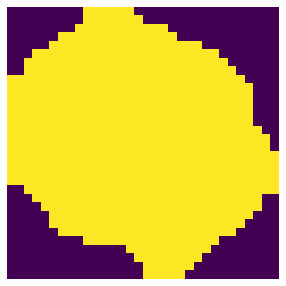

In [73]:
area_map = area_maps[0]
has_isolated_areas(area_map)

In [ ]:
def shortest_path(start_point, end_point, area_map):
    """
    PARAMETERS
    ---
    area_map : binary map, -1=obstacle, 0=area to be mapped.
    points : [(x,y)] points around which to dist fill (fuel station).
    """
    shape = area_map.shape
    dist_map = []
    v_map = []
    for _ in points:
        dm = area_map.copy()
        dist_map.append(np.int64(dm)) # obs = -1
        v_map.append((dm == OB).copy())
    
    for i,point in enumerate(points):
        assert is_valid(point, area_map.shape), \
        "invalid coordinate for center"
        assert dist_map[i][point] != OB, \
        "center is an obstacle"
    
    for i in range(len(points)):
        pval = 0
        center = points[i]
        dist_map[i][center] = pval
        v_map[i][center] = True

        to_visit = []
        get_udlr(dist_map[i], v_map[i], center, to_visit)
        while len(to_visit) > 0:
            pval += 1
            l = len(to_visit)
            for coord in to_visit:
                dist_map[i][coord] = pval
                v_map[i][coord] = True

            for i_ in range(l):
                coord = to_visit.pop(0)
                get_udlr(dist_map[i], v_map[i], coord, to_visit)
    return np.array(dist_map).min(axis=0)